## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7038680379413386484
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7164166144
locality {
  bus_id: 1
  links {
  }
}
incarnation: 18075604337686734720
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from utils.data_generator_seq2seq import data_generator_head_sal_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv2D, MaxPooling2D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_head_sal_reinject_output_1-32'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 32 # LSTM hidden units
filter_dim = 5
kernel_dim = 10

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_inputs)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.

final_width_px = 128 # 2560/20
final_height_px = 72 # 1440/20

sal_map_input = Input(shape=(final_height_px, final_width_px, 1))

conv_1 = Conv2D(filters=4, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(sal_map_input)
max_pooling_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(filters=8, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

print(max_pooling_4.shape)

decoder_input_raw = Flatten(data_format='channels_last')(max_pooling_4)
print(decoder_input_raw.shape)

decoder_input = Dense(latent_dim, activation="relu")(decoder_input_raw)

decoder_input = Reshape(target_shape=(1,latent_dim))(decoder_input)
print(decoder_input.shape)

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    dense_1_outputs = dense_1(decoder_outputs_1)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = decoder_outputs_1
    states = [dh1, dc1]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, sal_map_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, 4, 8, 16)
(?, ?)
(?, 1, 32)


(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 128, 4)   40          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 36, 64, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 36, 64, 8)    296         max_pooling2d_1[0][0]            
_________________________________________________________________________________

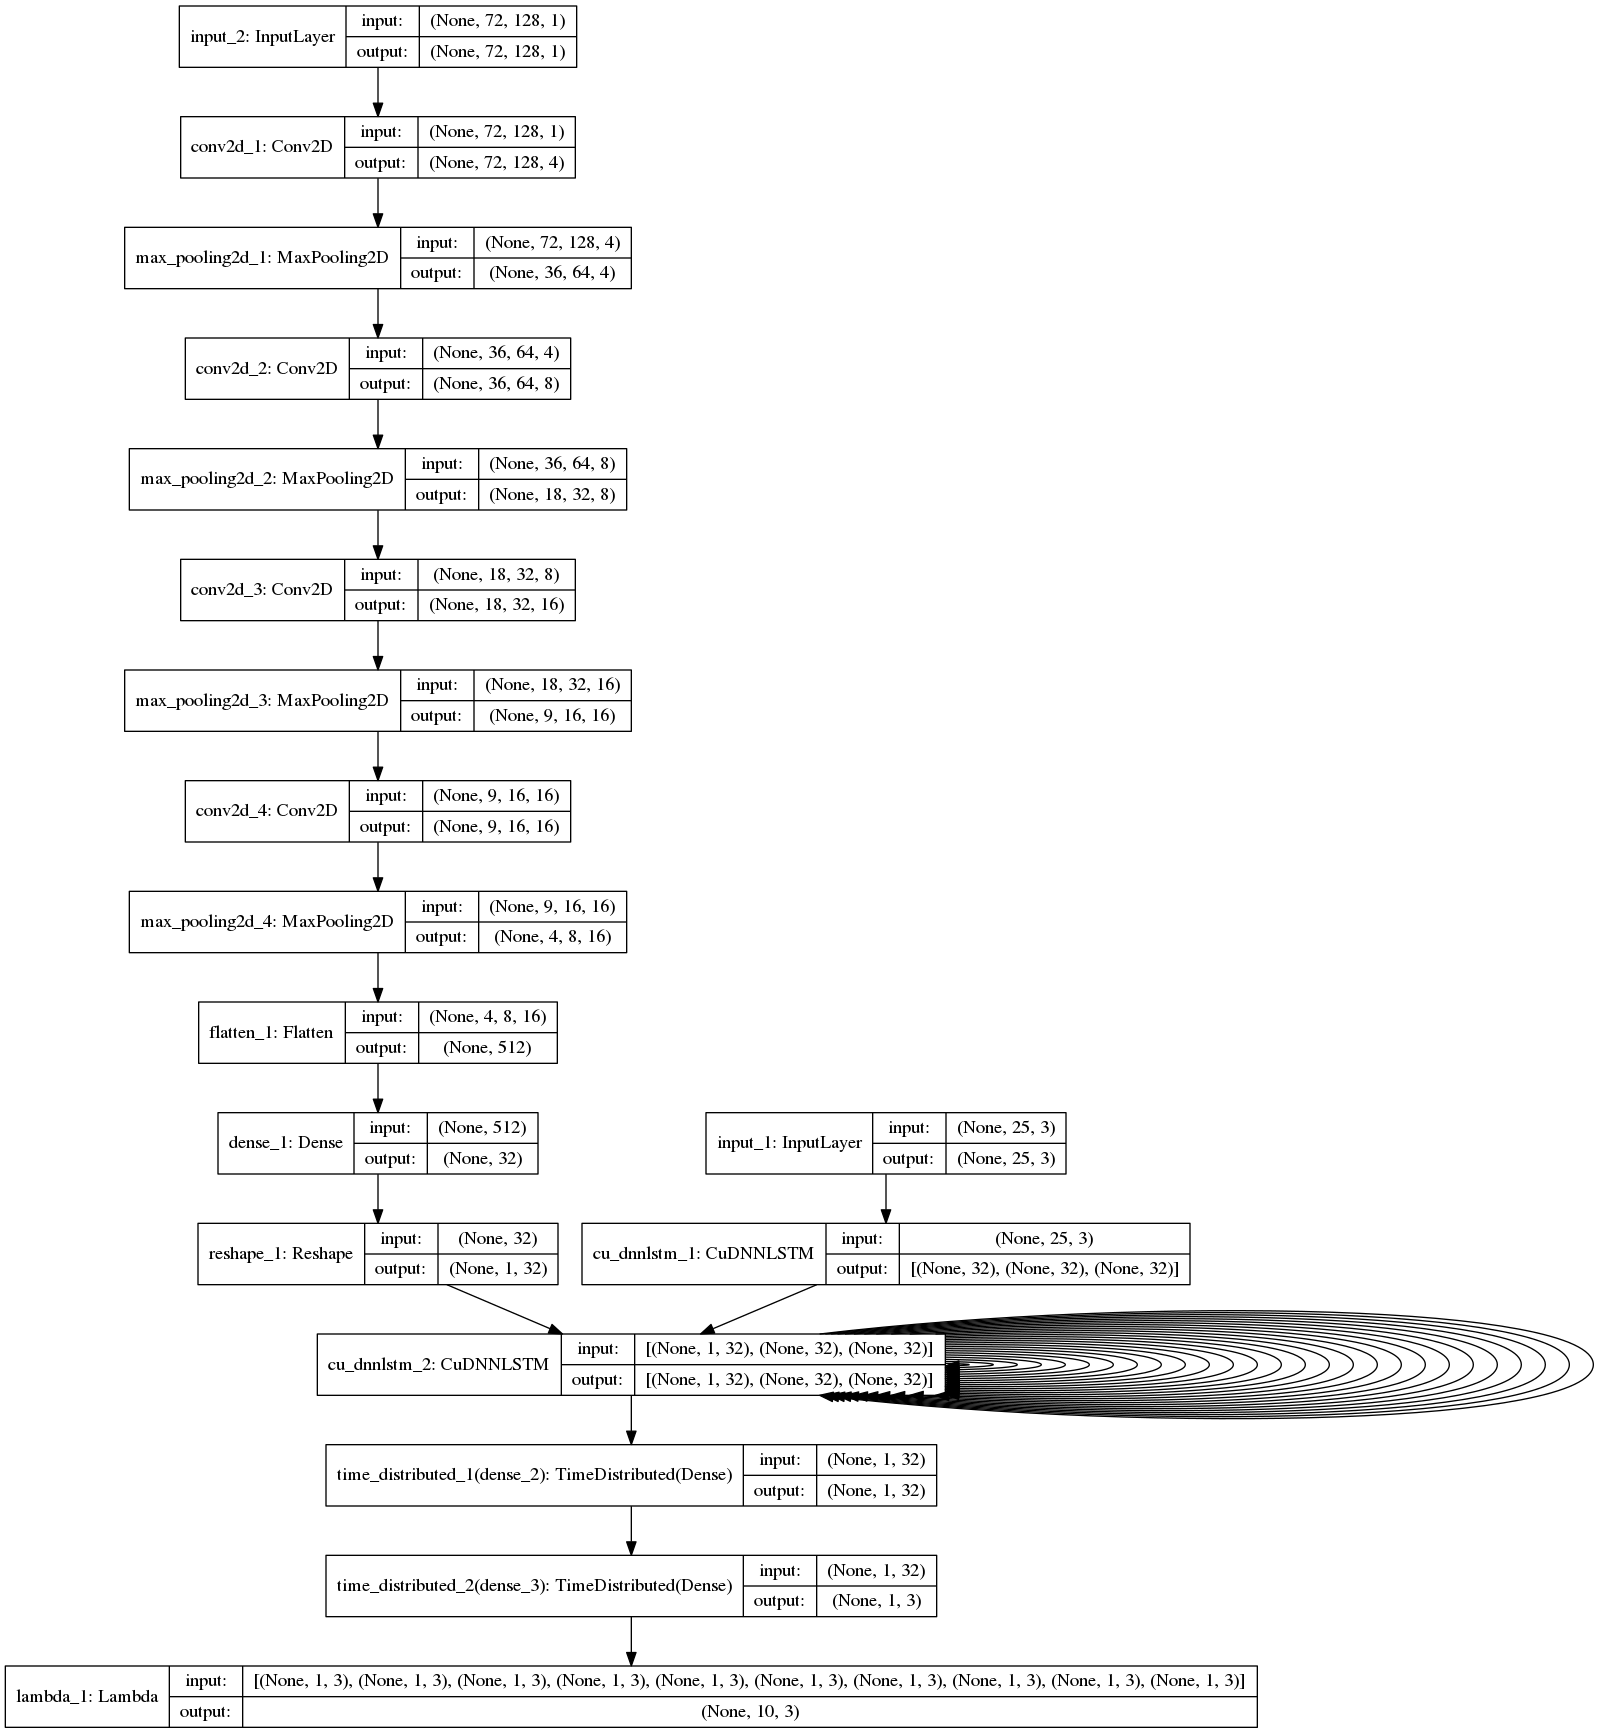

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images_train_h5_new", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(saliency_dir)
print(videos)
video_width = 3840

['013_13_times_square_static.h5', '002_01_art_gallery_static.h5', '002_02_theatre_scene_static.h5', '002_03_lions_static_cuts.h5', '002_04_copenhagen_harbour_static_cuts.h5', '002_07_factory_robots_static.h5', '002_09_elephants_static.h5', '002_12_gym_workout_static.h5', '002_13_times_square_static.h5', '002_14_new_orleans_drive_motion.h5', '002_16_interview_static.h5', '002_17_weather_forecast_static.h5', '002_18_bomb_trapped_static.h5', '002_20_car_fix_static.h5', '002_23_dog_food_factory_motion.h5', '003_01_art_gallery_static.h5', '003_02_theatre_scene_static.h5', '003_03_lions_static_cuts.h5', '003_04_copenhagen_harbour_static_cuts.h5', '003_05_florida_yacht_motion.h5', '003_07_factory_robots_static.h5', '003_08_madagascar_cuts.h5', '003_09_elephants_static.h5', '003_11_lohdi_garden_india_cuts.h5', '003_12_gym_workout_static.h5', '003_13_times_square_static.h5', '003_14_new_orleans_drive_motion.h5', '003_18_bomb_trapped_static.h5', '003_21_operation_room_static.h5', '003_23_dog_foo

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

(72, 128, 1)


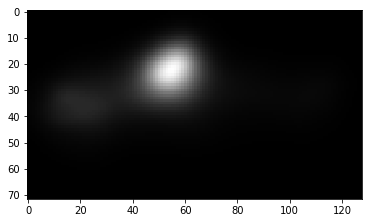

"\nfig=plt.figure(figsize=(18, 16), dpi= 80)\n\nplt.subplot(311)\nplt.plot(encoder_input[:,0,0], c='r')\nplt.grid(True)\n\nplt.subplot(312)\nplt.plot(encoder_input[:,0,1], c='g')\nplt.grid(True)\n\nplt.subplot(313)\nplt.plot(encoder_input[:,0,2], c='b')\nplt.grid(True)\n"

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)
print(decoder_input[1000].shape)
plt.imshow(decoder_input[1000,:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

'''
fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)
'''

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=(len(videos) - ind_max_train))
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/422 [..............................] - ETA: 27:35 - loss: 0.1653 - rmse: 0.3164

  2/422 [..............................] - ETA: 20:59 - loss: 0.1399 - rmse: 0.2684

  3/422 [..............................] - ETA: 19:26 - loss: 0.1404 - rmse: 0.2809

  4/422 [..............................] - ETA: 18:46 - loss: 0.1232 - rmse: 0.2387

  5/422 [..............................] - ETA: 18:18 - loss: 0.1294 - rmse: 0.2643

  6/422 [..............................] - ETA: 18:07 - loss: 0.1218 - rmse: 0.2513

  7/422 [..............................] - ETA: 17:57 - loss: 0.1173 - rmse: 0.2477

  8/422 [..............................] - ETA: 17:51 - loss: 0.1107 - rmse: 0.2356

  9/422 [..............................] - ETA: 17:41 - loss: 0.1074 - rmse: 0.2346

 10/422 [..............................] - ETA: 17:32 - loss: 0.1062 - rmse: 0.2321

 11/422 [..............................] - ETA: 17:01 - loss: 0.1050 - rmse: 0.2335

 12/422 [..............................] - ETA: 16:57 - loss: 0.1018 - rmse: 0.2283

 13/422 [..............................] - ETA: 16:56 - loss: 0.1001 - rmse: 0.2269

 14/422 [..............................] - ETA: 16:52 - loss: 0.0951 - rmse: 0.2148

 15/422 [>.............................] - ETA: 16:48 - loss: 0.0943 - rmse: 0.2141

 16/422 [>.............................] - ETA: 16:45 - loss: 0.0907 - rmse: 0.2071

 17/422 [>.............................] - ETA: 16:43 - loss: 0.0867 - rmse: 0.1975

 18/422 [>.............................] - ETA: 16:45 - loss: 0.0894 - rmse: 0.2052

 19/422 [>.............................] - ETA: 16:44 - loss: 0.0867 - rmse: 0.1990

 20/422 [>.............................] - ETA: 16:43 - loss: 0.0836 - rmse: 0.1923

 21/422 [>.............................] - ETA: 16:41 - loss: 0.0829 - rmse: 0.1926

 22/422 [>.............................] - ETA: 16:38 - loss: 0.0819 - rmse: 0.1911

 23/422 [>.............................] - ETA: 16:36 - loss: 0.0806 - rmse: 0.1903

 24/422 [>.............................] - ETA: 16:34 - loss: 0.0803 - rmse: 0.1898

 25/422 [>.............................] - ETA: 16:30 - loss: 0.0794 - rmse: 0.1880

 26/422 [>.............................] - ETA: 16:30 - loss: 0.0782 - rmse: 0.1857

 27/422 [>.............................] - ETA: 16:27 - loss: 0.0773 - rmse: 0.1864

 28/422 [>.............................] - ETA: 16:23 - loss: 0.0776 - rmse: 0.1872

 29/422 [=>............................] - ETA: 16:20 - loss: 0.0784 - rmse: 0.1895

 30/422 [=>............................] - ETA: 16:17 - loss: 0.0793 - rmse: 0.1909

 31/422 [=>............................] - ETA: 16:13 - loss: 0.0780 - rmse: 0.1887

 32/422 [=>............................] - ETA: 16:09 - loss: 0.0777 - rmse: 0.1882

 33/422 [=>............................] - ETA: 16:07 - loss: 0.0789 - rmse: 0.1925

 34/422 [=>............................] - ETA: 16:04 - loss: 0.0803 - rmse: 0.1962

 35/422 [=>............................] - ETA: 15:54 - loss: 0.0792 - rmse: 0.1951

 36/422 [=>............................] - ETA: 15:51 - loss: 0.0777 - rmse: 0.1910

 37/422 [=>............................] - ETA: 15:44 - loss: 0.0768 - rmse: 0.1893

 38/422 [=>............................] - ETA: 15:43 - loss: 0.0764 - rmse: 0.1890

 39/422 [=>............................] - ETA: 15:40 - loss: 0.0759 - rmse: 0.1886

 40/422 [=>............................] - ETA: 15:37 - loss: 0.0761 - rmse: 0.1906

 41/422 [=>............................] - ETA: 15:35 - loss: 0.0750 - rmse: 0.1896

 42/422 [=>............................] - ETA: 15:32 - loss: 0.0753 - rmse: 0.1913

 43/422 [==>...........................] - ETA: 15:30 - loss: 0.0766 - rmse: 0.1957

 44/422 [==>...........................] - ETA: 15:27 - loss: 0.0775 - rmse: 0.1973

 45/422 [==>...........................] - ETA: 15:19 - loss: 0.0774 - rmse: 0.1977

 46/422 [==>...........................] - ETA: 15:17 - loss: 0.0762 - rmse: 0.1953

 47/422 [==>...........................] - ETA: 15:16 - loss: 0.0756 - rmse: 0.1937

 48/422 [==>...........................] - ETA: 14:58 - loss: 0.0758 - rmse: 0.1944

 49/422 [==>...........................] - ETA: 14:41 - loss: 0.0753 - rmse: 0.1928

 50/422 [==>...........................] - ETA: 14:39 - loss: 0.0750 - rmse: 0.1919

 51/422 [==>...........................] - ETA: 14:37 - loss: 0.0744 - rmse: 0.1902

 52/422 [==>...........................] - ETA: 14:21 - loss: 0.0748 - rmse: 0.1919

 53/422 [==>...........................] - ETA: 14:17 - loss: 0.0746 - rmse: 0.1910

 54/422 [==>...........................] - ETA: 14:02 - loss: 0.0737 - rmse: 0.1893

 55/422 [==>...........................] - ETA: 14:02 - loss: 0.0738 - rmse: 0.1894

 56/422 [==>...........................] - ETA: 13:58 - loss: 0.0738 - rmse: 0.1893

 57/422 [===>..........................] - ETA: 13:44 - loss: 0.0737 - rmse: 0.1896

 58/422 [===>..........................] - ETA: 13:39 - loss: 0.0727 - rmse: 0.1871

 59/422 [===>..........................] - ETA: 13:25 - loss: 0.0728 - rmse: 0.1879

 60/422 [===>..........................] - ETA: 13:13 - loss: 0.0720 - rmse: 0.1855

 61/422 [===>..........................] - ETA: 13:11 - loss: 0.0721 - rmse: 0.1858

 62/422 [===>..........................] - ETA: 13:11 - loss: 0.0721 - rmse: 0.1858

 63/422 [===>..........................] - ETA: 13:10 - loss: 0.0721 - rmse: 0.1856

 64/422 [===>..........................] - ETA: 13:09 - loss: 0.0720 - rmse: 0.1860

 65/422 [===>..........................] - ETA: 13:08 - loss: 0.0717 - rmse: 0.1855

 66/422 [===>..........................] - ETA: 13:07 - loss: 0.0713 - rmse: 0.1844

 67/422 [===>..........................] - ETA: 12:55 - loss: 0.0709 - rmse: 0.1832

 68/422 [===>..........................] - ETA: 12:55 - loss: 0.0705 - rmse: 0.1834

 69/422 [===>..........................] - ETA: 12:54 - loss: 0.0708 - rmse: 0.1838

 70/422 [===>..........................] - ETA: 12:43 - loss: 0.0703 - rmse: 0.1828

 71/422 [====>.........................] - ETA: 12:33 - loss: 0.0704 - rmse: 0.1830

 72/422 [====>.........................] - ETA: 12:32 - loss: 0.0708 - rmse: 0.1838

 73/422 [====>.........................] - ETA: 12:22 - loss: 0.0704 - rmse: 0.1832

 74/422 [====>.........................] - ETA: 12:20 - loss: 0.0697 - rmse: 0.1817

 75/422 [====>.........................] - ETA: 12:11 - loss: 0.0701 - rmse: 0.1822

 76/422 [====>.........................] - ETA: 12:10 - loss: 0.0700 - rmse: 0.1824

 77/422 [====>.........................] - ETA: 12:09 - loss: 0.0705 - rmse: 0.1836

 78/422 [====>.........................] - ETA: 12:08 - loss: 0.0708 - rmse: 0.1840

 79/422 [====>.........................] - ETA: 12:08 - loss: 0.0711 - rmse: 0.1852

 80/422 [====>.........................] - ETA: 12:05 - loss: 0.0712 - rmse: 0.1852

 81/422 [====>.........................] - ETA: 11:55 - loss: 0.0714 - rmse: 0.1856

 82/422 [====>.........................] - ETA: 11:47 - loss: 0.0713 - rmse: 0.1856

 83/422 [====>.........................] - ETA: 11:38 - loss: 0.0712 - rmse: 0.1856

 84/422 [====>.........................] - ETA: 11:38 - loss: 0.0705 - rmse: 0.1842

 85/422 [=====>........................] - ETA: 11:38 - loss: 0.0698 - rmse: 0.1823

 86/422 [=====>........................] - ETA: 11:29 - loss: 0.0692 - rmse: 0.1809

 87/422 [=====>........................] - ETA: 11:28 - loss: 0.0689 - rmse: 0.1801

 88/422 [=====>........................] - ETA: 11:20 - loss: 0.0690 - rmse: 0.1802

 89/422 [=====>........................] - ETA: 11:19 - loss: 0.0691 - rmse: 0.1805

 90/422 [=====>........................] - ETA: 11:19 - loss: 0.0688 - rmse: 0.1800

 91/422 [=====>........................] - ETA: 11:11 - loss: 0.0688 - rmse: 0.1799

 92/422 [=====>........................] - ETA: 11:10 - loss: 0.0688 - rmse: 0.1799

 93/422 [=====>........................] - ETA: 11:10 - loss: 0.0685 - rmse: 0.1796

 94/422 [=====>........................] - ETA: 11:02 - loss: 0.0682 - rmse: 0.1787

 95/422 [=====>........................] - ETA: 10:55 - loss: 0.0684 - rmse: 0.1791

 96/422 [=====>........................] - ETA: 10:55 - loss: 0.0683 - rmse: 0.1790

 97/422 [=====>........................] - ETA: 10:54 - loss: 0.0680 - rmse: 0.1785

 98/422 [=====>........................] - ETA: 10:54 - loss: 0.0677 - rmse: 0.1785

 99/422 [======>.......................] - ETA: 10:46 - loss: 0.0674 - rmse: 0.1774

100/422 [======>.......................] - ETA: 10:44 - loss: 0.0669 - rmse: 0.1763

101/422 [======>.......................] - ETA: 10:43 - loss: 0.0678 - rmse: 0.1784

102/422 [======>.......................] - ETA: 10:36 - loss: 0.0678 - rmse: 0.1785

103/422 [======>.......................] - ETA: 10:35 - loss: 0.0675 - rmse: 0.1777

104/422 [======>.......................] - ETA: 10:35 - loss: 0.0674 - rmse: 0.1772

105/422 [======>.......................] - ETA: 10:35 - loss: 0.0674 - rmse: 0.1773

106/422 [======>.......................] - ETA: 10:28 - loss: 0.0673 - rmse: 0.1769

107/422 [======>.......................] - ETA: 10:21 - loss: 0.0668 - rmse: 0.1754

108/422 [======>.......................] - ETA: 10:21 - loss: 0.0664 - rmse: 0.1744

109/422 [======>.......................] - ETA: 10:14 - loss: 0.0663 - rmse: 0.1741

110/422 [======>.......................] - ETA: 10:14 - loss: 0.0664 - rmse: 0.1742

111/422 [======>.......................] - ETA: 10:08 - loss: 0.0667 - rmse: 0.1749

112/422 [======>.......................] - ETA: 10:06 - loss: 0.0666 - rmse: 0.1747

113/422 [=======>......................] - ETA: 10:05 - loss: 0.0662 - rmse: 0.1742

114/422 [=======>......................] - ETA: 10:05 - loss: 0.0660 - rmse: 0.1739

115/422 [=======>......................] - ETA: 10:04 - loss: 0.0660 - rmse: 0.1739

116/422 [=======>......................] - ETA: 9:58 - loss: 0.0662 - rmse: 0.1746 

117/422 [=======>......................] - ETA: 9:57 - loss: 0.0660 - rmse: 0.1741

118/422 [=======>......................] - ETA: 9:52 - loss: 0.0662 - rmse: 0.1746

119/422 [=======>......................] - ETA: 9:50 - loss: 0.0668 - rmse: 0.1757

120/422 [=======>......................] - ETA: 9:44 - loss: 0.0667 - rmse: 0.1758

121/422 [=======>......................] - ETA: 9:44 - loss: 0.0670 - rmse: 0.1768

122/422 [=======>......................] - ETA: 9:38 - loss: 0.0670 - rmse: 0.1768

123/422 [=======>......................] - ETA: 9:37 - loss: 0.0667 - rmse: 0.1763

124/422 [=======>......................] - ETA: 9:37 - loss: 0.0669 - rmse: 0.1771

125/422 [=======>......................] - ETA: 9:36 - loss: 0.0670 - rmse: 0.1771

126/422 [=======>......................] - ETA: 9:31 - loss: 0.0669 - rmse: 0.1766

127/422 [========>.....................] - ETA: 9:30 - loss: 0.0668 - rmse: 0.1766

128/422 [========>.....................] - ETA: 9:24 - loss: 0.0668 - rmse: 0.1764

129/422 [========>.....................] - ETA: 9:19 - loss: 0.0666 - rmse: 0.1759

130/422 [========>.....................] - ETA: 9:14 - loss: 0.0665 - rmse: 0.1755

131/422 [========>.....................] - ETA: 9:14 - loss: 0.0666 - rmse: 0.1759

132/422 [========>.....................] - ETA: 9:08 - loss: 0.0667 - rmse: 0.1760

133/422 [========>.....................] - ETA: 9:08 - loss: 0.0663 - rmse: 0.1753

134/422 [========>.....................] - ETA: 9:07 - loss: 0.0662 - rmse: 0.1750

135/422 [========>.....................] - ETA: 9:02 - loss: 0.0663 - rmse: 0.1754

136/422 [========>.....................] - ETA: 9:01 - loss: 0.0660 - rmse: 0.1746

137/422 [========>.....................] - ETA: 8:57 - loss: 0.0660 - rmse: 0.1745

138/422 [========>.....................] - ETA: 8:56 - loss: 0.0659 - rmse: 0.1741

139/422 [========>.....................] - ETA: 8:54 - loss: 0.0660 - rmse: 0.1740

140/422 [========>.....................] - ETA: 8:49 - loss: 0.0662 - rmse: 0.1745

141/422 [=========>....................] - ETA: 8:49 - loss: 0.0663 - rmse: 0.1747

142/422 [=========>....................] - ETA: 8:44 - loss: 0.0662 - rmse: 0.1747

143/422 [=========>....................] - ETA: 8:43 - loss: 0.0660 - rmse: 0.1740

144/422 [=========>....................] - ETA: 8:43 - loss: 0.0659 - rmse: 0.1740

145/422 [=========>....................] - ETA: 8:40 - loss: 0.0660 - rmse: 0.1740

146/422 [=========>....................] - ETA: 8:40 - loss: 0.0658 - rmse: 0.1735

147/422 [=========>....................] - ETA: 8:35 - loss: 0.0659 - rmse: 0.1736

148/422 [=========>....................] - ETA: 8:34 - loss: 0.0659 - rmse: 0.1738

149/422 [=========>....................] - ETA: 8:33 - loss: 0.0656 - rmse: 0.1728

150/422 [=========>....................] - ETA: 8:33 - loss: 0.0657 - rmse: 0.1735

151/422 [=========>....................] - ETA: 8:28 - loss: 0.0656 - rmse: 0.1731

152/422 [=========>....................] - ETA: 8:27 - loss: 0.0654 - rmse: 0.1725

153/422 [=========>....................] - ETA: 8:26 - loss: 0.0654 - rmse: 0.1727

154/422 [=========>....................] - ETA: 8:22 - loss: 0.0655 - rmse: 0.1726

155/422 [==========>...................] - ETA: 8:17 - loss: 0.0652 - rmse: 0.1719

156/422 [==========>...................] - ETA: 8:15 - loss: 0.0651 - rmse: 0.1718

157/422 [==========>...................] - ETA: 8:11 - loss: 0.0651 - rmse: 0.1717

158/422 [==========>...................] - ETA: 8:07 - loss: 0.0651 - rmse: 0.1716

159/422 [==========>...................] - ETA: 8:03 - loss: 0.0648 - rmse: 0.1711

160/422 [==========>...................] - ETA: 8:02 - loss: 0.0649 - rmse: 0.1714

161/422 [==========>...................] - ETA: 8:01 - loss: 0.0649 - rmse: 0.1716

162/422 [==========>...................] - ETA: 7:57 - loss: 0.0650 - rmse: 0.1719

163/422 [==========>...................] - ETA: 7:53 - loss: 0.0651 - rmse: 0.1720

164/422 [==========>...................] - ETA: 7:49 - loss: 0.0652 - rmse: 0.1725

165/422 [==========>...................] - ETA: 7:45 - loss: 0.0655 - rmse: 0.1732

166/422 [==========>...................] - ETA: 7:44 - loss: 0.0655 - rmse: 0.1733

167/422 [==========>...................] - ETA: 7:43 - loss: 0.0654 - rmse: 0.1731

168/422 [==========>...................] - ETA: 7:42 - loss: 0.0655 - rmse: 0.1733

169/422 [===========>..................] - ETA: 7:41 - loss: 0.0654 - rmse: 0.1732

170/422 [===========>..................] - ETA: 7:37 - loss: 0.0657 - rmse: 0.1740

171/422 [===========>..................] - ETA: 7:34 - loss: 0.0655 - rmse: 0.1734

172/422 [===========>..................] - ETA: 7:33 - loss: 0.0654 - rmse: 0.1732

173/422 [===========>..................] - ETA: 7:32 - loss: 0.0654 - rmse: 0.1730

174/422 [===========>..................] - ETA: 7:28 - loss: 0.0654 - rmse: 0.1729

175/422 [===========>..................] - ETA: 7:24 - loss: 0.0653 - rmse: 0.1727

176/422 [===========>..................] - ETA: 7:21 - loss: 0.0653 - rmse: 0.1728

177/422 [===========>..................] - ETA: 7:20 - loss: 0.0652 - rmse: 0.1731

178/422 [===========>..................] - ETA: 7:16 - loss: 0.0655 - rmse: 0.1737

179/422 [===========>..................] - ETA: 7:15 - loss: 0.0656 - rmse: 0.1739

180/422 [===========>..................] - ETA: 7:14 - loss: 0.0657 - rmse: 0.1738

181/422 [===========>..................] - ETA: 7:13 - loss: 0.0657 - rmse: 0.1740

182/422 [===========>..................] - ETA: 7:11 - loss: 0.0660 - rmse: 0.1749

183/422 [============>.................] - ETA: 7:08 - loss: 0.0660 - rmse: 0.1751

184/422 [============>.................] - ETA: 7:07 - loss: 0.0659 - rmse: 0.1746

185/422 [============>.................] - ETA: 7:06 - loss: 0.0660 - rmse: 0.1747

186/422 [============>.................] - ETA: 7:05 - loss: 0.0660 - rmse: 0.1747

187/422 [============>.................] - ETA: 7:01 - loss: 0.0660 - rmse: 0.1751

188/422 [============>.................] - ETA: 6:58 - loss: 0.0662 - rmse: 0.1754

189/422 [============>.................] - ETA: 6:55 - loss: 0.0661 - rmse: 0.1753

190/422 [============>.................] - ETA: 6:53 - loss: 0.0662 - rmse: 0.1754

191/422 [============>.................] - ETA: 6:51 - loss: 0.0662 - rmse: 0.1753

192/422 [============>.................] - ETA: 6:50 - loss: 0.0661 - rmse: 0.1752

193/422 [============>.................] - ETA: 6:49 - loss: 0.0660 - rmse: 0.1748

194/422 [============>.................] - ETA: 6:46 - loss: 0.0658 - rmse: 0.1747

195/422 [============>.................] - ETA: 6:45 - loss: 0.0658 - rmse: 0.1747

196/422 [============>.................] - ETA: 6:44 - loss: 0.0656 - rmse: 0.1741

197/422 [=============>................] - ETA: 6:40 - loss: 0.0655 - rmse: 0.1738

198/422 [=============>................] - ETA: 6:37 - loss: 0.0655 - rmse: 0.1736

199/422 [=============>................] - ETA: 6:36 - loss: 0.0656 - rmse: 0.1737

200/422 [=============>................] - ETA: 6:34 - loss: 0.0655 - rmse: 0.1736

201/422 [=============>................] - ETA: 6:31 - loss: 0.0656 - rmse: 0.1739

202/422 [=============>................] - ETA: 6:30 - loss: 0.0654 - rmse: 0.1733

203/422 [=============>................] - ETA: 6:27 - loss: 0.0653 - rmse: 0.1731

204/422 [=============>................] - ETA: 6:26 - loss: 0.0652 - rmse: 0.1729

205/422 [=============>................] - ETA: 6:22 - loss: 0.0651 - rmse: 0.1725

206/422 [=============>................] - ETA: 6:21 - loss: 0.0651 - rmse: 0.1725

207/422 [=============>................] - ETA: 6:20 - loss: 0.0650 - rmse: 0.1723

208/422 [=============>................] - ETA: 6:19 - loss: 0.0651 - rmse: 0.1727

209/422 [=============>................] - ETA: 6:18 - loss: 0.0651 - rmse: 0.1727

210/422 [=============>................] - ETA: 6:15 - loss: 0.0650 - rmse: 0.1723

211/422 [==============>...............] - ETA: 6:12 - loss: 0.0654 - rmse: 0.1734

212/422 [==============>...............] - ETA: 6:11 - loss: 0.0654 - rmse: 0.1738

213/422 [==============>...............] - ETA: 6:10 - loss: 0.0654 - rmse: 0.1738

214/422 [==============>...............] - ETA: 6:08 - loss: 0.0655 - rmse: 0.1741

215/422 [==============>...............] - ETA: 6:07 - loss: 0.0654 - rmse: 0.1739

216/422 [==============>...............] - ETA: 6:04 - loss: 0.0653 - rmse: 0.1739

217/422 [==============>...............] - ETA: 6:03 - loss: 0.0652 - rmse: 0.1739

218/422 [==============>...............] - ETA: 6:00 - loss: 0.0652 - rmse: 0.1738

219/422 [==============>...............] - ETA: 5:59 - loss: 0.0652 - rmse: 0.1741

220/422 [==============>...............] - ETA: 5:58 - loss: 0.0654 - rmse: 0.1744

221/422 [==============>...............] - ETA: 5:55 - loss: 0.0653 - rmse: 0.1740

222/422 [==============>...............] - ETA: 5:52 - loss: 0.0653 - rmse: 0.1742

223/422 [==============>...............] - ETA: 5:49 - loss: 0.0651 - rmse: 0.1738

224/422 [==============>...............] - ETA: 5:46 - loss: 0.0651 - rmse: 0.1736

225/422 [==============>...............] - ETA: 5:45 - loss: 0.0651 - rmse: 0.1739

226/422 [===============>..............] - ETA: 5:42 - loss: 0.0650 - rmse: 0.1738

227/422 [===============>..............] - ETA: 5:39 - loss: 0.0649 - rmse: 0.1735

228/422 [===============>..............] - ETA: 5:36 - loss: 0.0648 - rmse: 0.1730

229/422 [===============>..............] - ETA: 5:35 - loss: 0.0649 - rmse: 0.1732

230/422 [===============>..............] - ETA: 5:32 - loss: 0.0648 - rmse: 0.1729

231/422 [===============>..............] - ETA: 5:30 - loss: 0.0647 - rmse: 0.1728

232/422 [===============>..............] - ETA: 5:28 - loss: 0.0647 - rmse: 0.1728

233/422 [===============>..............] - ETA: 5:27 - loss: 0.0648 - rmse: 0.1728

234/422 [===============>..............] - ETA: 5:26 - loss: 0.0646 - rmse: 0.1724

235/422 [===============>..............] - ETA: 5:23 - loss: 0.0645 - rmse: 0.1725

236/422 [===============>..............] - ETA: 5:22 - loss: 0.0645 - rmse: 0.1723

237/422 [===============>..............] - ETA: 5:20 - loss: 0.0644 - rmse: 0.1719

238/422 [===============>..............] - ETA: 5:17 - loss: 0.0644 - rmse: 0.1719

239/422 [===============>..............] - ETA: 5:14 - loss: 0.0643 - rmse: 0.1717

240/422 [================>.............] - ETA: 5:13 - loss: 0.0642 - rmse: 0.1714

241/422 [================>.............] - ETA: 5:12 - loss: 0.0641 - rmse: 0.1715

242/422 [================>.............] - ETA: 5:09 - loss: 0.0641 - rmse: 0.1715

243/422 [================>.............] - ETA: 5:06 - loss: 0.0640 - rmse: 0.1713

244/422 [================>.............] - ETA: 5:04 - loss: 0.0640 - rmse: 0.1712

245/422 [================>.............] - ETA: 5:03 - loss: 0.0639 - rmse: 0.1708

246/422 [================>.............] - ETA: 5:01 - loss: 0.0641 - rmse: 0.1713

247/422 [================>.............] - ETA: 5:00 - loss: 0.0640 - rmse: 0.1710

248/422 [================>.............] - ETA: 4:59 - loss: 0.0641 - rmse: 0.1715

249/422 [================>.............] - ETA: 4:56 - loss: 0.0640 - rmse: 0.1712

250/422 [================>.............] - ETA: 4:55 - loss: 0.0642 - rmse: 0.1714

251/422 [================>.............] - ETA: 4:52 - loss: 0.0640 - rmse: 0.1710

252/422 [================>.............] - ETA: 4:49 - loss: 0.0641 - rmse: 0.1712

253/422 [================>.............] - ETA: 4:47 - loss: 0.0641 - rmse: 0.1713

254/422 [=================>............] - ETA: 4:46 - loss: 0.0641 - rmse: 0.1713

255/422 [=================>............] - ETA: 4:43 - loss: 0.0640 - rmse: 0.1711

256/422 [=================>............] - ETA: 4:41 - loss: 0.0643 - rmse: 0.1718

257/422 [=================>............] - ETA: 4:38 - loss: 0.0642 - rmse: 0.1721

258/422 [=================>............] - ETA: 4:37 - loss: 0.0643 - rmse: 0.1723

259/422 [=================>............] - ETA: 4:34 - loss: 0.0642 - rmse: 0.1721

260/422 [=================>............] - ETA: 4:33 - loss: 0.0645 - rmse: 0.1727

261/422 [=================>............] - ETA: 4:31 - loss: 0.0644 - rmse: 0.1726

262/422 [=================>............] - ETA: 4:28 - loss: 0.0643 - rmse: 0.1724

263/422 [=================>............] - ETA: 4:27 - loss: 0.0643 - rmse: 0.1724

264/422 [=================>............] - ETA: 4:25 - loss: 0.0647 - rmse: 0.1731

265/422 [=================>............] - ETA: 4:23 - loss: 0.0645 - rmse: 0.1727

266/422 [=================>............] - ETA: 4:22 - loss: 0.0645 - rmse: 0.1727

267/422 [=================>............] - ETA: 4:20 - loss: 0.0644 - rmse: 0.1726

268/422 [==================>...........] - ETA: 4:17 - loss: 0.0644 - rmse: 0.1725

269/422 [==================>...........] - ETA: 4:15 - loss: 0.0644 - rmse: 0.1725

270/422 [==================>...........] - ETA: 4:13 - loss: 0.0646 - rmse: 0.1728

271/422 [==================>...........] - ETA: 4:12 - loss: 0.0646 - rmse: 0.1732

272/422 [==================>...........] - ETA: 4:10 - loss: 0.0646 - rmse: 0.1731

273/422 [==================>...........] - ETA: 4:08 - loss: 0.0645 - rmse: 0.1729

274/422 [==================>...........] - ETA: 4:07 - loss: 0.0646 - rmse: 0.1732

275/422 [==================>...........] - ETA: 4:06 - loss: 0.0646 - rmse: 0.1730

276/422 [==================>...........] - ETA: 4:03 - loss: 0.0645 - rmse: 0.1730

277/422 [==================>...........] - ETA: 4:01 - loss: 0.0645 - rmse: 0.1728

278/422 [==================>...........] - ETA: 4:00 - loss: 0.0647 - rmse: 0.1732

279/422 [==================>...........] - ETA: 3:58 - loss: 0.0647 - rmse: 0.1733

280/422 [==================>...........] - ETA: 3:57 - loss: 0.0647 - rmse: 0.1734

281/422 [==================>...........] - ETA: 3:55 - loss: 0.0649 - rmse: 0.1737

282/422 [===================>..........] - ETA: 3:53 - loss: 0.0648 - rmse: 0.1736

283/422 [===================>..........] - ETA: 3:51 - loss: 0.0649 - rmse: 0.1737

284/422 [===================>..........] - ETA: 3:49 - loss: 0.0649 - rmse: 0.1738

285/422 [===================>..........] - ETA: 3:47 - loss: 0.0649 - rmse: 0.1739

286/422 [===================>..........] - ETA: 3:45 - loss: 0.0650 - rmse: 0.1742

287/422 [===================>..........] - ETA: 3:43 - loss: 0.0649 - rmse: 0.1741

288/422 [===================>..........] - ETA: 3:41 - loss: 0.0650 - rmse: 0.1742

289/422 [===================>..........] - ETA: 3:39 - loss: 0.0649 - rmse: 0.1740

290/422 [===================>..........] - ETA: 3:36 - loss: 0.0648 - rmse: 0.1739

291/422 [===================>..........] - ETA: 3:34 - loss: 0.0647 - rmse: 0.1738

292/422 [===================>..........] - ETA: 3:33 - loss: 0.0647 - rmse: 0.1736

293/422 [===================>..........] - ETA: 3:32 - loss: 0.0646 - rmse: 0.1733

294/422 [===================>..........] - ETA: 3:30 - loss: 0.0646 - rmse: 0.1736

295/422 [===================>..........] - ETA: 3:28 - loss: 0.0645 - rmse: 0.1733

296/422 [====================>.........] - ETA: 3:26 - loss: 0.0645 - rmse: 0.1734

297/422 [====================>.........] - ETA: 3:24 - loss: 0.0646 - rmse: 0.1735

298/422 [====================>.........] - ETA: 3:22 - loss: 0.0645 - rmse: 0.1733

299/422 [====================>.........] - ETA: 3:20 - loss: 0.0647 - rmse: 0.1736

300/422 [====================>.........] - ETA: 3:18 - loss: 0.0646 - rmse: 0.1735

301/422 [====================>.........] - ETA: 3:17 - loss: 0.0645 - rmse: 0.1731

302/422 [====================>.........] - ETA: 3:15 - loss: 0.0647 - rmse: 0.1736

303/422 [====================>.........] - ETA: 3:13 - loss: 0.0646 - rmse: 0.1732

304/422 [====================>.........] - ETA: 3:11 - loss: 0.0646 - rmse: 0.1732

305/422 [====================>.........] - ETA: 3:09 - loss: 0.0645 - rmse: 0.1730

306/422 [====================>.........] - ETA: 3:07 - loss: 0.0644 - rmse: 0.1730

307/422 [====================>.........] - ETA: 3:05 - loss: 0.0643 - rmse: 0.1728

308/422 [====================>.........] - ETA: 3:02 - loss: 0.0643 - rmse: 0.1726

309/422 [====================>.........] - ETA: 3:00 - loss: 0.0643 - rmse: 0.1727

310/422 [=====================>........] - ETA: 2:59 - loss: 0.0642 - rmse: 0.1725

311/422 [=====================>........] - ETA: 2:57 - loss: 0.0641 - rmse: 0.1722

312/422 [=====================>........] - ETA: 2:55 - loss: 0.0640 - rmse: 0.1721

313/422 [=====================>........] - ETA: 2:53 - loss: 0.0639 - rmse: 0.1719

314/422 [=====================>........] - ETA: 2:52 - loss: 0.0640 - rmse: 0.1719

315/422 [=====================>........] - ETA: 2:50 - loss: 0.0639 - rmse: 0.1719

316/422 [=====================>........] - ETA: 2:48 - loss: 0.0639 - rmse: 0.1717

317/422 [=====================>........] - ETA: 2:47 - loss: 0.0640 - rmse: 0.1718

318/422 [=====================>........] - ETA: 2:45 - loss: 0.0639 - rmse: 0.1715

319/422 [=====================>........] - ETA: 2:44 - loss: 0.0638 - rmse: 0.1712

320/422 [=====================>........] - ETA: 2:42 - loss: 0.0638 - rmse: 0.1714

321/422 [=====================>........] - ETA: 2:40 - loss: 0.0637 - rmse: 0.1711

322/422 [=====================>........] - ETA: 2:38 - loss: 0.0637 - rmse: 0.1710

323/422 [=====================>........] - ETA: 2:37 - loss: 0.0638 - rmse: 0.1714

324/422 [======================>.......] - ETA: 2:36 - loss: 0.0637 - rmse: 0.1713

325/422 [======================>.......] - ETA: 2:35 - loss: 0.0637 - rmse: 0.1712

326/422 [======================>.......] - ETA: 2:33 - loss: 0.0636 - rmse: 0.1709

327/422 [======================>.......] - ETA: 2:31 - loss: 0.0637 - rmse: 0.1710

328/422 [======================>.......] - ETA: 2:29 - loss: 0.0635 - rmse: 0.1706

329/422 [======================>.......] - ETA: 2:28 - loss: 0.0636 - rmse: 0.1708

330/422 [======================>.......] - ETA: 2:26 - loss: 0.0636 - rmse: 0.1709

331/422 [======================>.......] - ETA: 2:24 - loss: 0.0637 - rmse: 0.1710

332/422 [======================>.......] - ETA: 2:22 - loss: 0.0637 - rmse: 0.1711

333/422 [======================>.......] - ETA: 2:20 - loss: 0.0637 - rmse: 0.1711

334/422 [======================>.......] - ETA: 2:18 - loss: 0.0636 - rmse: 0.1709

335/422 [======================>.......] - ETA: 2:17 - loss: 0.0636 - rmse: 0.1708

336/422 [======================>.......] - ETA: 2:15 - loss: 0.0636 - rmse: 0.1707

337/422 [======================>.......] - ETA: 2:13 - loss: 0.0635 - rmse: 0.1704

338/422 [=======================>......] - ETA: 2:12 - loss: 0.0635 - rmse: 0.1705

339/422 [=======================>......] - ETA: 2:10 - loss: 0.0636 - rmse: 0.1706

340/422 [=======================>......] - ETA: 2:09 - loss: 0.0636 - rmse: 0.1708

341/422 [=======================>......] - ETA: 2:07 - loss: 0.0636 - rmse: 0.1708

342/422 [=======================>......] - ETA: 2:05 - loss: 0.0635 - rmse: 0.1706

343/422 [=======================>......] - ETA: 2:04 - loss: 0.0635 - rmse: 0.1706

344/422 [=======================>......] - ETA: 2:02 - loss: 0.0636 - rmse: 0.1708

345/422 [=======================>......] - ETA: 2:01 - loss: 0.0636 - rmse: 0.1708

346/422 [=======================>......] - ETA: 1:59 - loss: 0.0637 - rmse: 0.1711

347/422 [=======================>......] - ETA: 1:57 - loss: 0.0637 - rmse: 0.1711

348/422 [=======================>......] - ETA: 1:56 - loss: 0.0637 - rmse: 0.1709

349/422 [=======================>......] - ETA: 1:54 - loss: 0.0637 - rmse: 0.1710

350/422 [=======================>......] - ETA: 1:52 - loss: 0.0636 - rmse: 0.1709

351/422 [=======================>......] - ETA: 1:50 - loss: 0.0636 - rmse: 0.1709

352/422 [========================>.....] - ETA: 1:48 - loss: 0.0637 - rmse: 0.1710

353/422 [========================>.....] - ETA: 1:47 - loss: 0.0636 - rmse: 0.1709

354/422 [========================>.....] - ETA: 1:46 - loss: 0.0635 - rmse: 0.1710

355/422 [========================>.....] - ETA: 1:44 - loss: 0.0636 - rmse: 0.1710

356/422 [========================>.....] - ETA: 1:43 - loss: 0.0637 - rmse: 0.1710

357/422 [========================>.....] - ETA: 1:41 - loss: 0.0637 - rmse: 0.1712

358/422 [========================>.....] - ETA: 1:39 - loss: 0.0636 - rmse: 0.1709

359/422 [========================>.....] - ETA: 1:38 - loss: 0.0636 - rmse: 0.1708

360/422 [========================>.....] - ETA: 1:36 - loss: 0.0638 - rmse: 0.1711

361/422 [========================>.....] - ETA: 1:35 - loss: 0.0637 - rmse: 0.1709

362/422 [========================>.....] - ETA: 1:33 - loss: 0.0636 - rmse: 0.1708

363/422 [========================>.....] - ETA: 1:31 - loss: 0.0636 - rmse: 0.1707

364/422 [========================>.....] - ETA: 1:29 - loss: 0.0636 - rmse: 0.1706

365/422 [========================>.....] - ETA: 1:28 - loss: 0.0636 - rmse: 0.1709

366/422 [=========================>....] - ETA: 1:26 - loss: 0.0635 - rmse: 0.1707

367/422 [=========================>....] - ETA: 1:25 - loss: 0.0635 - rmse: 0.1706

368/422 [=========================>....] - ETA: 1:23 - loss: 0.0635 - rmse: 0.1707

369/422 [=========================>....] - ETA: 1:22 - loss: 0.0635 - rmse: 0.1705

370/422 [=========================>....] - ETA: 1:20 - loss: 0.0635 - rmse: 0.1706

371/422 [=========================>....] - ETA: 1:18 - loss: 0.0635 - rmse: 0.1704

372/422 [=========================>....] - ETA: 1:17 - loss: 0.0633 - rmse: 0.1701

373/422 [=========================>....] - ETA: 1:15 - loss: 0.0633 - rmse: 0.1701

374/422 [=========================>....] - ETA: 1:13 - loss: 0.0634 - rmse: 0.1703

375/422 [=========================>....] - ETA: 1:12 - loss: 0.0635 - rmse: 0.1703

376/422 [=========================>....] - ETA: 1:10 - loss: 0.0634 - rmse: 0.1704

377/422 [=========================>....] - ETA: 1:09 - loss: 0.0635 - rmse: 0.1705

378/422 [=========================>....] - ETA: 1:07 - loss: 0.0634 - rmse: 0.1704

379/422 [=========================>....] - ETA: 1:05 - loss: 0.0634 - rmse: 0.1703

380/422 [==========================>...] - ETA: 1:04 - loss: 0.0634 - rmse: 0.1703

381/422 [==========================>...] - ETA: 1:02 - loss: 0.0635 - rmse: 0.1705

382/422 [==========================>...] - ETA: 1:01 - loss: 0.0634 - rmse: 0.1704

383/422 [==========================>...] - ETA: 59s - loss: 0.0634 - rmse: 0.1703 

384/422 [==========================>...] - ETA: 57s - loss: 0.0633 - rmse: 0.1701

385/422 [==========================>...] - ETA: 56s - loss: 0.0633 - rmse: 0.1700

386/422 [==========================>...] - ETA: 54s - loss: 0.0632 - rmse: 0.1696

387/422 [==========================>...] - ETA: 53s - loss: 0.0632 - rmse: 0.1696

388/422 [==========================>...] - ETA: 51s - loss: 0.0631 - rmse: 0.1693

389/422 [==========================>...] - ETA: 50s - loss: 0.0630 - rmse: 0.1693

390/422 [==========================>...] - ETA: 48s - loss: 0.0630 - rmse: 0.1694

391/422 [==========================>...] - ETA: 46s - loss: 0.0630 - rmse: 0.1696

392/422 [==========================>...] - ETA: 45s - loss: 0.0632 - rmse: 0.1700

393/422 [==========================>...] - ETA: 43s - loss: 0.0631 - rmse: 0.1700

394/422 [===========================>..] - ETA: 42s - loss: 0.0632 - rmse: 0.1701

395/422 [===========================>..] - ETA: 40s - loss: 0.0631 - rmse: 0.1698

396/422 [===========================>..] - ETA: 39s - loss: 0.0630 - rmse: 0.1698

397/422 [===========================>..] - ETA: 37s - loss: 0.0630 - rmse: 0.1697

398/422 [===========================>..] - ETA: 36s - loss: 0.0629 - rmse: 0.1695

399/422 [===========================>..] - ETA: 34s - loss: 0.0630 - rmse: 0.1696

400/422 [===========================>..] - ETA: 33s - loss: 0.0630 - rmse: 0.1696

401/422 [===========================>..] - ETA: 31s - loss: 0.0630 - rmse: 0.1696

402/422 [===========================>..] - ETA: 30s - loss: 0.0629 - rmse: 0.1694

403/422 [===========================>..] - ETA: 28s - loss: 0.0629 - rmse: 0.1692

404/422 [===========================>..] - ETA: 26s - loss: 0.0629 - rmse: 0.1696

405/422 [===========================>..] - ETA: 25s - loss: 0.0629 - rmse: 0.1695

406/422 [===========================>..] - ETA: 24s - loss: 0.0630 - rmse: 0.1696

407/422 [===========================>..] - ETA: 22s - loss: 0.0629 - rmse: 0.1696

408/422 [============================>.] - ETA: 20s - loss: 0.0629 - rmse: 0.1697

409/422 [============================>.] - ETA: 19s - loss: 0.0630 - rmse: 0.1698

410/422 [============================>.] - ETA: 17s - loss: 0.0630 - rmse: 0.1699

411/422 [============================>.] - ETA: 16s - loss: 0.0630 - rmse: 0.1696

412/422 [============================>.] - ETA: 14s - loss: 0.0629 - rmse: 0.1695

413/422 [============================>.] - ETA: 13s - loss: 0.0629 - rmse: 0.1694

414/422 [============================>.] - ETA: 11s - loss: 0.0629 - rmse: 0.1694

415/422 [============================>.] - ETA: 10s - loss: 0.0629 - rmse: 0.1694

416/422 [============================>.] - ETA: 8s - loss: 0.0629 - rmse: 0.1694 

417/422 [============================>.] - ETA: 7s - loss: 0.0628 - rmse: 0.1691

418/422 [============================>.] - ETA: 5s - loss: 0.0627 - rmse: 0.1692

419/422 [============================>.] - ETA: 4s - loss: 0.0628 - rmse: 0.1695

420/422 [============================>.] - ETA: 2s - loss: 0.0628 - rmse: 0.1696

421/422 [============================>.] - ETA: 1s - loss: 0.0629 - rmse: 0.1698

422/422 [==============================] - 676s 2s/step - loss: 0.0629 - rmse: 0.1697 - val_loss: 0.0615 - val_rmse: 0.1762


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_2 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_2/strided_slice_16:0' shape=(?, 32) dtype=float32>, <tf.Tensor 'cu_dnnlstm_2/strided_slice_17:0' shape=(?, 32) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4

Epoch 2/150


  1/422 [..............................] - ETA: 2:50 - loss: 0.0415 - rmse: 0.1250

  2/422 [..............................] - ETA: 3:02 - loss: 0.0370 - rmse: 0.0970

  3/422 [..............................] - ETA: 3:04 - loss: 0.0335 - rmse: 0.0889

  4/422 [..............................] - ETA: 3:06 - loss: 0.0432 - rmse: 0.1133

  5/422 [..............................] - ETA: 3:10 - loss: 0.0468 - rmse: 0.1235

  6/422 [..............................] - ETA: 3:10 - loss: 0.0481 - rmse: 0.1318

  7/422 [..............................] - ETA: 3:10 - loss: 0.0522 - rmse: 0.1406

  8/422 [..............................] - ETA: 3:04 - loss: 0.0522 - rmse: 0.1425

  9/422 [..............................] - ETA: 3:04 - loss: 0.0504 - rmse: 0.1357

 10/422 [..............................] - ETA: 3:00 - loss: 0.0461 - rmse: 0.1254

 11/422 [..............................] - ETA: 3:01 - loss: 0.0442 - rmse: 0.1239

 12/422 [..............................] - ETA: 2:59 - loss: 0.0467 - rmse: 0.1293

 13/422 [..............................] - ETA: 2:59 - loss: 0.0478 - rmse: 0.1340

 14/422 [..............................] - ETA: 3:00 - loss: 0.0511 - rmse: 0.1391

 15/422 [>.............................] - ETA: 3:00 - loss: 0.0512 - rmse: 0.1383

 16/422 [>.............................] - ETA: 2:59 - loss: 0.0519 - rmse: 0.1430

 17/422 [>.............................] - ETA: 2:59 - loss: 0.0552 - rmse: 0.1513

 18/422 [>.............................] - ETA: 2:59 - loss: 0.0542 - rmse: 0.1490

 19/422 [>.............................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1498

 20/422 [>.............................] - ETA: 3:00 - loss: 0.0538 - rmse: 0.1490

 21/422 [>.............................] - ETA: 2:59 - loss: 0.0530 - rmse: 0.1462

 22/422 [>.............................] - ETA: 2:58 - loss: 0.0536 - rmse: 0.1468

 23/422 [>.............................] - ETA: 2:58 - loss: 0.0540 - rmse: 0.1470

 24/422 [>.............................] - ETA: 2:58 - loss: 0.0550 - rmse: 0.1502

 25/422 [>.............................] - ETA: 2:58 - loss: 0.0548 - rmse: 0.1504

 26/422 [>.............................] - ETA: 2:58 - loss: 0.0572 - rmse: 0.1579

 27/422 [>.............................] - ETA: 2:58 - loss: 0.0583 - rmse: 0.1599

 28/422 [>.............................] - ETA: 2:57 - loss: 0.0598 - rmse: 0.1635

 29/422 [=>............................] - ETA: 2:57 - loss: 0.0605 - rmse: 0.1649

 30/422 [=>............................] - ETA: 2:57 - loss: 0.0606 - rmse: 0.1659

 31/422 [=>............................] - ETA: 2:57 - loss: 0.0607 - rmse: 0.1660

 32/422 [=>............................] - ETA: 2:56 - loss: 0.0607 - rmse: 0.1663

 33/422 [=>............................] - ETA: 2:56 - loss: 0.0603 - rmse: 0.1644

 34/422 [=>............................] - ETA: 2:56 - loss: 0.0599 - rmse: 0.1643

 35/422 [=>............................] - ETA: 2:56 - loss: 0.0596 - rmse: 0.1625

 36/422 [=>............................] - ETA: 2:55 - loss: 0.0593 - rmse: 0.1612

 37/422 [=>............................] - ETA: 2:55 - loss: 0.0587 - rmse: 0.1597

 38/422 [=>............................] - ETA: 2:53 - loss: 0.0603 - rmse: 0.1640

 39/422 [=>............................] - ETA: 2:53 - loss: 0.0602 - rmse: 0.1653

 40/422 [=>............................] - ETA: 2:53 - loss: 0.0597 - rmse: 0.1638

 41/422 [=>............................] - ETA: 2:52 - loss: 0.0594 - rmse: 0.1628

 42/422 [=>............................] - ETA: 2:52 - loss: 0.0590 - rmse: 0.1610

 43/422 [==>...........................] - ETA: 2:52 - loss: 0.0586 - rmse: 0.1599

 44/422 [==>...........................] - ETA: 2:51 - loss: 0.0590 - rmse: 0.1613

 45/422 [==>...........................] - ETA: 2:51 - loss: 0.0588 - rmse: 0.1605

 46/422 [==>...........................] - ETA: 2:51 - loss: 0.0600 - rmse: 0.1635

 47/422 [==>...........................] - ETA: 2:50 - loss: 0.0611 - rmse: 0.1658

 48/422 [==>...........................] - ETA: 2:50 - loss: 0.0603 - rmse: 0.1636

 49/422 [==>...........................] - ETA: 2:50 - loss: 0.0610 - rmse: 0.1659

 50/422 [==>...........................] - ETA: 2:49 - loss: 0.0615 - rmse: 0.1668

 51/422 [==>...........................] - ETA: 2:49 - loss: 0.0606 - rmse: 0.1643

 52/422 [==>...........................] - ETA: 2:49 - loss: 0.0607 - rmse: 0.1645

 53/422 [==>...........................] - ETA: 2:49 - loss: 0.0614 - rmse: 0.1658

 54/422 [==>...........................] - ETA: 2:48 - loss: 0.0613 - rmse: 0.1658

 55/422 [==>...........................] - ETA: 2:48 - loss: 0.0613 - rmse: 0.1659

 56/422 [==>...........................] - ETA: 2:48 - loss: 0.0615 - rmse: 0.1673

 57/422 [===>..........................] - ETA: 2:48 - loss: 0.0612 - rmse: 0.1666

 58/422 [===>..........................] - ETA: 2:47 - loss: 0.0614 - rmse: 0.1670

 59/422 [===>..........................] - ETA: 2:47 - loss: 0.0616 - rmse: 0.1671

 60/422 [===>..........................] - ETA: 2:47 - loss: 0.0616 - rmse: 0.1673

 61/422 [===>..........................] - ETA: 2:46 - loss: 0.0617 - rmse: 0.1675

 62/422 [===>..........................] - ETA: 2:46 - loss: 0.0617 - rmse: 0.1674

 63/422 [===>..........................] - ETA: 2:45 - loss: 0.0619 - rmse: 0.1675

 64/422 [===>..........................] - ETA: 2:45 - loss: 0.0623 - rmse: 0.1679

 65/422 [===>..........................] - ETA: 2:44 - loss: 0.0620 - rmse: 0.1672

 66/422 [===>..........................] - ETA: 2:44 - loss: 0.0621 - rmse: 0.1674

 67/422 [===>..........................] - ETA: 2:43 - loss: 0.0630 - rmse: 0.1692

 68/422 [===>..........................] - ETA: 2:43 - loss: 0.0625 - rmse: 0.1681

 69/422 [===>..........................] - ETA: 2:43 - loss: 0.0633 - rmse: 0.1703

 70/422 [===>..........................] - ETA: 2:42 - loss: 0.0635 - rmse: 0.1705

 71/422 [====>.........................] - ETA: 2:41 - loss: 0.0635 - rmse: 0.1700

 72/422 [====>.........................] - ETA: 2:41 - loss: 0.0632 - rmse: 0.1698

 73/422 [====>.........................] - ETA: 2:40 - loss: 0.0633 - rmse: 0.1701

 74/422 [====>.........................] - ETA: 2:40 - loss: 0.0634 - rmse: 0.1702

 75/422 [====>.........................] - ETA: 2:40 - loss: 0.0630 - rmse: 0.1690

 76/422 [====>.........................] - ETA: 2:39 - loss: 0.0632 - rmse: 0.1694

 77/422 [====>.........................] - ETA: 2:39 - loss: 0.0626 - rmse: 0.1680

 78/422 [====>.........................] - ETA: 2:38 - loss: 0.0625 - rmse: 0.1676

 79/422 [====>.........................] - ETA: 2:38 - loss: 0.0625 - rmse: 0.1676

 80/422 [====>.........................] - ETA: 2:38 - loss: 0.0624 - rmse: 0.1672

 81/422 [====>.........................] - ETA: 2:37 - loss: 0.0621 - rmse: 0.1663

 82/422 [====>.........................] - ETA: 2:37 - loss: 0.0620 - rmse: 0.1662

 83/422 [====>.........................] - ETA: 2:36 - loss: 0.0620 - rmse: 0.1662

 84/422 [====>.........................] - ETA: 2:36 - loss: 0.0619 - rmse: 0.1664

 85/422 [=====>........................] - ETA: 2:35 - loss: 0.0622 - rmse: 0.1666

 86/422 [=====>........................] - ETA: 2:35 - loss: 0.0622 - rmse: 0.1667

 87/422 [=====>........................] - ETA: 2:34 - loss: 0.0622 - rmse: 0.1672

 88/422 [=====>........................] - ETA: 2:34 - loss: 0.0621 - rmse: 0.1670

 89/422 [=====>........................] - ETA: 2:33 - loss: 0.0619 - rmse: 0.1663

 90/422 [=====>........................] - ETA: 2:33 - loss: 0.0618 - rmse: 0.1663

 91/422 [=====>........................] - ETA: 2:33 - loss: 0.0619 - rmse: 0.1668

 92/422 [=====>........................] - ETA: 2:32 - loss: 0.0616 - rmse: 0.1665

 93/422 [=====>........................] - ETA: 2:32 - loss: 0.0614 - rmse: 0.1660

 94/422 [=====>........................] - ETA: 2:31 - loss: 0.0614 - rmse: 0.1659

 95/422 [=====>........................] - ETA: 2:31 - loss: 0.0612 - rmse: 0.1653

 96/422 [=====>........................] - ETA: 2:30 - loss: 0.0614 - rmse: 0.1660

 97/422 [=====>........................] - ETA: 2:30 - loss: 0.0610 - rmse: 0.1651

 98/422 [=====>........................] - ETA: 2:29 - loss: 0.0607 - rmse: 0.1646

 99/422 [======>.......................] - ETA: 2:29 - loss: 0.0608 - rmse: 0.1646

100/422 [======>.......................] - ETA: 2:28 - loss: 0.0613 - rmse: 0.1659

101/422 [======>.......................] - ETA: 2:28 - loss: 0.0622 - rmse: 0.1678

102/422 [======>.......................] - ETA: 2:28 - loss: 0.0623 - rmse: 0.1678

103/422 [======>.......................] - ETA: 2:27 - loss: 0.0625 - rmse: 0.1683

104/422 [======>.......................] - ETA: 2:27 - loss: 0.0624 - rmse: 0.1684

105/422 [======>.......................] - ETA: 2:26 - loss: 0.0620 - rmse: 0.1677

106/422 [======>.......................] - ETA: 2:26 - loss: 0.0619 - rmse: 0.1675

107/422 [======>.......................] - ETA: 2:25 - loss: 0.0624 - rmse: 0.1685

108/422 [======>.......................] - ETA: 2:25 - loss: 0.0622 - rmse: 0.1681

109/422 [======>.......................] - ETA: 2:25 - loss: 0.0620 - rmse: 0.1676

110/422 [======>.......................] - ETA: 2:24 - loss: 0.0620 - rmse: 0.1674

111/422 [======>.......................] - ETA: 2:24 - loss: 0.0617 - rmse: 0.1664

112/422 [======>.......................] - ETA: 2:23 - loss: 0.0617 - rmse: 0.1664

113/422 [=======>......................] - ETA: 2:23 - loss: 0.0617 - rmse: 0.1664

114/422 [=======>......................] - ETA: 2:22 - loss: 0.0616 - rmse: 0.1663

115/422 [=======>......................] - ETA: 2:22 - loss: 0.0618 - rmse: 0.1668

116/422 [=======>......................] - ETA: 2:21 - loss: 0.0620 - rmse: 0.1670

117/422 [=======>......................] - ETA: 2:21 - loss: 0.0619 - rmse: 0.1670

118/422 [=======>......................] - ETA: 2:21 - loss: 0.0622 - rmse: 0.1678

119/422 [=======>......................] - ETA: 2:20 - loss: 0.0622 - rmse: 0.1677

120/422 [=======>......................] - ETA: 2:20 - loss: 0.0620 - rmse: 0.1675

121/422 [=======>......................] - ETA: 2:19 - loss: 0.0622 - rmse: 0.1679

122/422 [=======>......................] - ETA: 2:18 - loss: 0.0622 - rmse: 0.1678

123/422 [=======>......................] - ETA: 2:18 - loss: 0.0624 - rmse: 0.1682

124/422 [=======>......................] - ETA: 2:18 - loss: 0.0622 - rmse: 0.1678

125/422 [=======>......................] - ETA: 2:17 - loss: 0.0623 - rmse: 0.1680

126/422 [=======>......................] - ETA: 2:17 - loss: 0.0622 - rmse: 0.1678

127/422 [========>.....................] - ETA: 2:16 - loss: 0.0619 - rmse: 0.1672

128/422 [========>.....................] - ETA: 2:16 - loss: 0.0621 - rmse: 0.1676

129/422 [========>.....................] - ETA: 2:15 - loss: 0.0617 - rmse: 0.1665

130/422 [========>.....................] - ETA: 2:15 - loss: 0.0614 - rmse: 0.1657

131/422 [========>.....................] - ETA: 2:15 - loss: 0.0613 - rmse: 0.1655

132/422 [========>.....................] - ETA: 2:14 - loss: 0.0615 - rmse: 0.1661

133/422 [========>.....................] - ETA: 2:14 - loss: 0.0613 - rmse: 0.1656

134/422 [========>.....................] - ETA: 2:13 - loss: 0.0613 - rmse: 0.1657

135/422 [========>.....................] - ETA: 2:13 - loss: 0.0611 - rmse: 0.1651

136/422 [========>.....................] - ETA: 2:12 - loss: 0.0611 - rmse: 0.1653

137/422 [========>.....................] - ETA: 2:12 - loss: 0.0612 - rmse: 0.1656

138/422 [========>.....................] - ETA: 2:11 - loss: 0.0612 - rmse: 0.1657

139/422 [========>.....................] - ETA: 2:11 - loss: 0.0613 - rmse: 0.1661

140/422 [========>.....................] - ETA: 2:10 - loss: 0.0614 - rmse: 0.1666

141/422 [=========>....................] - ETA: 2:10 - loss: 0.0612 - rmse: 0.1660

142/422 [=========>....................] - ETA: 2:09 - loss: 0.0612 - rmse: 0.1658

143/422 [=========>....................] - ETA: 2:09 - loss: 0.0609 - rmse: 0.1650

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0609 - rmse: 0.1651

145/422 [=========>....................] - ETA: 2:08 - loss: 0.0609 - rmse: 0.1652

146/422 [=========>....................] - ETA: 2:08 - loss: 0.0608 - rmse: 0.1650

147/422 [=========>....................] - ETA: 2:07 - loss: 0.0605 - rmse: 0.1643

148/422 [=========>....................] - ETA: 2:07 - loss: 0.0608 - rmse: 0.1647

149/422 [=========>....................] - ETA: 2:06 - loss: 0.0607 - rmse: 0.1648

150/422 [=========>....................] - ETA: 2:06 - loss: 0.0609 - rmse: 0.1651

151/422 [=========>....................] - ETA: 2:05 - loss: 0.0607 - rmse: 0.1646

152/422 [=========>....................] - ETA: 2:05 - loss: 0.0605 - rmse: 0.1641

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0606 - rmse: 0.1641

154/422 [=========>....................] - ETA: 2:04 - loss: 0.0605 - rmse: 0.1641

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0605 - rmse: 0.1639

156/422 [==========>...................] - ETA: 2:03 - loss: 0.0606 - rmse: 0.1638

157/422 [==========>...................] - ETA: 2:03 - loss: 0.0604 - rmse: 0.1632

158/422 [==========>...................] - ETA: 2:02 - loss: 0.0601 - rmse: 0.1624

159/422 [==========>...................] - ETA: 2:02 - loss: 0.0605 - rmse: 0.1636

160/422 [==========>...................] - ETA: 2:01 - loss: 0.0605 - rmse: 0.1634

161/422 [==========>...................] - ETA: 2:00 - loss: 0.0603 - rmse: 0.1633

162/422 [==========>...................] - ETA: 2:00 - loss: 0.0601 - rmse: 0.1628

163/422 [==========>...................] - ETA: 2:00 - loss: 0.0598 - rmse: 0.1620

164/422 [==========>...................] - ETA: 1:59 - loss: 0.0597 - rmse: 0.1615

165/422 [==========>...................] - ETA: 1:59 - loss: 0.0597 - rmse: 0.1617

166/422 [==========>...................] - ETA: 1:58 - loss: 0.0597 - rmse: 0.1614

167/422 [==========>...................] - ETA: 1:58 - loss: 0.0596 - rmse: 0.1611

168/422 [==========>...................] - ETA: 1:57 - loss: 0.0596 - rmse: 0.1611

169/422 [===========>..................] - ETA: 1:57 - loss: 0.0597 - rmse: 0.1614

170/422 [===========>..................] - ETA: 1:56 - loss: 0.0598 - rmse: 0.1618

171/422 [===========>..................] - ETA: 1:56 - loss: 0.0597 - rmse: 0.1618

172/422 [===========>..................] - ETA: 1:55 - loss: 0.0597 - rmse: 0.1616

173/422 [===========>..................] - ETA: 1:55 - loss: 0.0596 - rmse: 0.1613

174/422 [===========>..................] - ETA: 1:54 - loss: 0.0597 - rmse: 0.1617

175/422 [===========>..................] - ETA: 1:54 - loss: 0.0599 - rmse: 0.1624

176/422 [===========>..................] - ETA: 1:53 - loss: 0.0601 - rmse: 0.1628

177/422 [===========>..................] - ETA: 1:53 - loss: 0.0600 - rmse: 0.1628

178/422 [===========>..................] - ETA: 1:52 - loss: 0.0600 - rmse: 0.1628

179/422 [===========>..................] - ETA: 1:52 - loss: 0.0600 - rmse: 0.1628

180/422 [===========>..................] - ETA: 1:52 - loss: 0.0601 - rmse: 0.1636

181/422 [===========>..................] - ETA: 1:51 - loss: 0.0602 - rmse: 0.1637

182/422 [===========>..................] - ETA: 1:51 - loss: 0.0601 - rmse: 0.1633

183/422 [============>.................] - ETA: 1:50 - loss: 0.0600 - rmse: 0.1628

184/422 [============>.................] - ETA: 1:50 - loss: 0.0600 - rmse: 0.1628

185/422 [============>.................] - ETA: 1:49 - loss: 0.0600 - rmse: 0.1627

186/422 [============>.................] - ETA: 1:48 - loss: 0.0600 - rmse: 0.1628

187/422 [============>.................] - ETA: 1:48 - loss: 0.0597 - rmse: 0.1624

188/422 [============>.................] - ETA: 1:48 - loss: 0.0598 - rmse: 0.1623

189/422 [============>.................] - ETA: 1:47 - loss: 0.0597 - rmse: 0.1620

190/422 [============>.................] - ETA: 1:46 - loss: 0.0595 - rmse: 0.1615

191/422 [============>.................] - ETA: 1:46 - loss: 0.0596 - rmse: 0.1615

192/422 [============>.................] - ETA: 1:46 - loss: 0.0596 - rmse: 0.1620

193/422 [============>.................] - ETA: 1:45 - loss: 0.0597 - rmse: 0.1621

194/422 [============>.................] - ETA: 1:45 - loss: 0.0595 - rmse: 0.1616

195/422 [============>.................] - ETA: 1:44 - loss: 0.0597 - rmse: 0.1623

196/422 [============>.................] - ETA: 1:44 - loss: 0.0599 - rmse: 0.1627

197/422 [=============>................] - ETA: 1:43 - loss: 0.0599 - rmse: 0.1627

198/422 [=============>................] - ETA: 1:43 - loss: 0.0600 - rmse: 0.1630

199/422 [=============>................] - ETA: 1:42 - loss: 0.0600 - rmse: 0.1629

200/422 [=============>................] - ETA: 1:42 - loss: 0.0599 - rmse: 0.1627

201/422 [=============>................] - ETA: 1:41 - loss: 0.0601 - rmse: 0.1630

202/422 [=============>................] - ETA: 1:41 - loss: 0.0600 - rmse: 0.1632

203/422 [=============>................] - ETA: 1:41 - loss: 0.0601 - rmse: 0.1634

204/422 [=============>................] - ETA: 1:40 - loss: 0.0600 - rmse: 0.1632

205/422 [=============>................] - ETA: 1:40 - loss: 0.0599 - rmse: 0.1629

206/422 [=============>................] - ETA: 1:39 - loss: 0.0601 - rmse: 0.1632

207/422 [=============>................] - ETA: 1:39 - loss: 0.0600 - rmse: 0.1632

208/422 [=============>................] - ETA: 1:38 - loss: 0.0600 - rmse: 0.1630

209/422 [=============>................] - ETA: 1:38 - loss: 0.0598 - rmse: 0.1630

210/422 [=============>................] - ETA: 1:37 - loss: 0.0599 - rmse: 0.1631

211/422 [==============>...............] - ETA: 1:37 - loss: 0.0600 - rmse: 0.1635

212/422 [==============>...............] - ETA: 1:36 - loss: 0.0600 - rmse: 0.1637

213/422 [==============>...............] - ETA: 1:36 - loss: 0.0602 - rmse: 0.1638

214/422 [==============>...............] - ETA: 1:35 - loss: 0.0603 - rmse: 0.1643

215/422 [==============>...............] - ETA: 1:35 - loss: 0.0604 - rmse: 0.1644

216/422 [==============>...............] - ETA: 1:34 - loss: 0.0603 - rmse: 0.1643

217/422 [==============>...............] - ETA: 1:34 - loss: 0.0603 - rmse: 0.1641

218/422 [==============>...............] - ETA: 1:33 - loss: 0.0602 - rmse: 0.1642

219/422 [==============>...............] - ETA: 1:33 - loss: 0.0602 - rmse: 0.1640

220/422 [==============>...............] - ETA: 1:32 - loss: 0.0601 - rmse: 0.1638

221/422 [==============>...............] - ETA: 1:32 - loss: 0.0599 - rmse: 0.1632

222/422 [==============>...............] - ETA: 1:32 - loss: 0.0598 - rmse: 0.1631

223/422 [==============>...............] - ETA: 1:31 - loss: 0.0597 - rmse: 0.1628

224/422 [==============>...............] - ETA: 1:31 - loss: 0.0598 - rmse: 0.1629

225/422 [==============>...............] - ETA: 1:30 - loss: 0.0598 - rmse: 0.1630

226/422 [===============>..............] - ETA: 1:30 - loss: 0.0596 - rmse: 0.1624

227/422 [===============>..............] - ETA: 1:29 - loss: 0.0597 - rmse: 0.1626

228/422 [===============>..............] - ETA: 1:29 - loss: 0.0596 - rmse: 0.1626

229/422 [===============>..............] - ETA: 1:28 - loss: 0.0596 - rmse: 0.1625

230/422 [===============>..............] - ETA: 1:28 - loss: 0.0595 - rmse: 0.1624

231/422 [===============>..............] - ETA: 1:27 - loss: 0.0596 - rmse: 0.1626

232/422 [===============>..............] - ETA: 1:27 - loss: 0.0597 - rmse: 0.1631

233/422 [===============>..............] - ETA: 1:27 - loss: 0.0597 - rmse: 0.1630

234/422 [===============>..............] - ETA: 1:26 - loss: 0.0597 - rmse: 0.1631

235/422 [===============>..............] - ETA: 1:26 - loss: 0.0596 - rmse: 0.1629

236/422 [===============>..............] - ETA: 1:25 - loss: 0.0597 - rmse: 0.1631

237/422 [===============>..............] - ETA: 1:25 - loss: 0.0595 - rmse: 0.1626

238/422 [===============>..............] - ETA: 1:24 - loss: 0.0595 - rmse: 0.1625

239/422 [===============>..............] - ETA: 1:24 - loss: 0.0594 - rmse: 0.1623

240/422 [================>.............] - ETA: 1:23 - loss: 0.0593 - rmse: 0.1621

241/422 [================>.............] - ETA: 1:23 - loss: 0.0593 - rmse: 0.1623

242/422 [================>.............] - ETA: 1:22 - loss: 0.0592 - rmse: 0.1620

243/422 [================>.............] - ETA: 1:22 - loss: 0.0592 - rmse: 0.1618

244/422 [================>.............] - ETA: 1:22 - loss: 0.0591 - rmse: 0.1617

245/422 [================>.............] - ETA: 1:21 - loss: 0.0590 - rmse: 0.1615

246/422 [================>.............] - ETA: 1:21 - loss: 0.0590 - rmse: 0.1615

247/422 [================>.............] - ETA: 1:20 - loss: 0.0589 - rmse: 0.1613

248/422 [================>.............] - ETA: 1:20 - loss: 0.0590 - rmse: 0.1614

249/422 [================>.............] - ETA: 1:19 - loss: 0.0588 - rmse: 0.1610

250/422 [================>.............] - ETA: 1:19 - loss: 0.0589 - rmse: 0.1611

251/422 [================>.............] - ETA: 1:18 - loss: 0.0590 - rmse: 0.1613

252/422 [================>.............] - ETA: 1:18 - loss: 0.0591 - rmse: 0.1616

253/422 [================>.............] - ETA: 1:17 - loss: 0.0589 - rmse: 0.1611

254/422 [=================>............] - ETA: 1:17 - loss: 0.0588 - rmse: 0.1610

255/422 [=================>............] - ETA: 1:17 - loss: 0.0589 - rmse: 0.1613

256/422 [=================>............] - ETA: 1:16 - loss: 0.0590 - rmse: 0.1615

257/422 [=================>............] - ETA: 1:16 - loss: 0.0590 - rmse: 0.1615

258/422 [=================>............] - ETA: 1:15 - loss: 0.0589 - rmse: 0.1612

259/422 [=================>............] - ETA: 1:15 - loss: 0.0589 - rmse: 0.1611

260/422 [=================>............] - ETA: 1:14 - loss: 0.0589 - rmse: 0.1611

261/422 [=================>............] - ETA: 1:14 - loss: 0.0589 - rmse: 0.1614

262/422 [=================>............] - ETA: 1:13 - loss: 0.0589 - rmse: 0.1613

263/422 [=================>............] - ETA: 1:13 - loss: 0.0589 - rmse: 0.1612

264/422 [=================>............] - ETA: 1:13 - loss: 0.0589 - rmse: 0.1611

265/422 [=================>............] - ETA: 1:12 - loss: 0.0587 - rmse: 0.1607

266/422 [=================>............] - ETA: 1:12 - loss: 0.0587 - rmse: 0.1605

267/422 [=================>............] - ETA: 1:11 - loss: 0.0586 - rmse: 0.1602

268/422 [==================>...........] - ETA: 1:11 - loss: 0.0586 - rmse: 0.1604

269/422 [==================>...........] - ETA: 1:10 - loss: 0.0585 - rmse: 0.1601

270/422 [==================>...........] - ETA: 1:10 - loss: 0.0586 - rmse: 0.1602

271/422 [==================>...........] - ETA: 1:09 - loss: 0.0588 - rmse: 0.1606

272/422 [==================>...........] - ETA: 1:09 - loss: 0.0587 - rmse: 0.1607

273/422 [==================>...........] - ETA: 1:08 - loss: 0.0588 - rmse: 0.1609

274/422 [==================>...........] - ETA: 1:08 - loss: 0.0589 - rmse: 0.1611

275/422 [==================>...........] - ETA: 1:07 - loss: 0.0588 - rmse: 0.1611

276/422 [==================>...........] - ETA: 1:07 - loss: 0.0588 - rmse: 0.1611

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0588 - rmse: 0.1610

278/422 [==================>...........] - ETA: 1:06 - loss: 0.0588 - rmse: 0.1613

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0589 - rmse: 0.1614

280/422 [==================>...........] - ETA: 1:05 - loss: 0.0589 - rmse: 0.1613

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0588 - rmse: 0.1613

282/422 [===================>..........] - ETA: 1:04 - loss: 0.0589 - rmse: 0.1615

283/422 [===================>..........] - ETA: 1:04 - loss: 0.0589 - rmse: 0.1614

284/422 [===================>..........] - ETA: 1:03 - loss: 0.0588 - rmse: 0.1612

285/422 [===================>..........] - ETA: 1:03 - loss: 0.0588 - rmse: 0.1613

286/422 [===================>..........] - ETA: 1:02 - loss: 0.0587 - rmse: 0.1609

287/422 [===================>..........] - ETA: 1:02 - loss: 0.0588 - rmse: 0.1612

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0587 - rmse: 0.1612

289/422 [===================>..........] - ETA: 1:01 - loss: 0.0586 - rmse: 0.1608

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0584 - rmse: 0.1604

291/422 [===================>..........] - ETA: 1:00 - loss: 0.0583 - rmse: 0.1600

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0582 - rmse: 0.1599

293/422 [===================>..........] - ETA: 59s - loss: 0.0583 - rmse: 0.1600 

294/422 [===================>..........] - ETA: 59s - loss: 0.0582 - rmse: 0.1596

295/422 [===================>..........] - ETA: 58s - loss: 0.0583 - rmse: 0.1599

296/422 [====================>.........] - ETA: 58s - loss: 0.0583 - rmse: 0.1601

297/422 [====================>.........] - ETA: 57s - loss: 0.0583 - rmse: 0.1600

298/422 [====================>.........] - ETA: 57s - loss: 0.0584 - rmse: 0.1602

299/422 [====================>.........] - ETA: 56s - loss: 0.0583 - rmse: 0.1599

300/422 [====================>.........] - ETA: 56s - loss: 0.0583 - rmse: 0.1599

301/422 [====================>.........] - ETA: 56s - loss: 0.0582 - rmse: 0.1598

302/422 [====================>.........] - ETA: 55s - loss: 0.0582 - rmse: 0.1597

303/422 [====================>.........] - ETA: 55s - loss: 0.0582 - rmse: 0.1596

304/422 [====================>.........] - ETA: 54s - loss: 0.0582 - rmse: 0.1595

305/422 [====================>.........] - ETA: 54s - loss: 0.0585 - rmse: 0.1602

306/422 [====================>.........] - ETA: 53s - loss: 0.0585 - rmse: 0.1603

307/422 [====================>.........] - ETA: 53s - loss: 0.0584 - rmse: 0.1605

308/422 [====================>.........] - ETA: 52s - loss: 0.0583 - rmse: 0.1602

309/422 [====================>.........] - ETA: 52s - loss: 0.0584 - rmse: 0.1604

310/422 [=====================>........] - ETA: 51s - loss: 0.0584 - rmse: 0.1603

311/422 [=====================>........] - ETA: 51s - loss: 0.0583 - rmse: 0.1600

312/422 [=====================>........] - ETA: 50s - loss: 0.0582 - rmse: 0.1600

313/422 [=====================>........] - ETA: 50s - loss: 0.0582 - rmse: 0.1599

314/422 [=====================>........] - ETA: 50s - loss: 0.0581 - rmse: 0.1597

315/422 [=====================>........] - ETA: 49s - loss: 0.0581 - rmse: 0.1597

316/422 [=====================>........] - ETA: 49s - loss: 0.0583 - rmse: 0.1601

317/422 [=====================>........] - ETA: 48s - loss: 0.0582 - rmse: 0.1598

318/422 [=====================>........] - ETA: 48s - loss: 0.0581 - rmse: 0.1595

319/422 [=====================>........] - ETA: 47s - loss: 0.0581 - rmse: 0.1596

320/422 [=====================>........] - ETA: 47s - loss: 0.0581 - rmse: 0.1595

321/422 [=====================>........] - ETA: 46s - loss: 0.0582 - rmse: 0.1600

322/422 [=====================>........] - ETA: 46s - loss: 0.0582 - rmse: 0.1598

323/422 [=====================>........] - ETA: 45s - loss: 0.0582 - rmse: 0.1599

324/422 [======================>.......] - ETA: 45s - loss: 0.0582 - rmse: 0.1599

325/422 [======================>.......] - ETA: 44s - loss: 0.0581 - rmse: 0.1598

326/422 [======================>.......] - ETA: 44s - loss: 0.0580 - rmse: 0.1594

327/422 [======================>.......] - ETA: 44s - loss: 0.0581 - rmse: 0.1596

328/422 [======================>.......] - ETA: 43s - loss: 0.0580 - rmse: 0.1593

329/422 [======================>.......] - ETA: 43s - loss: 0.0579 - rmse: 0.1591

330/422 [======================>.......] - ETA: 42s - loss: 0.0579 - rmse: 0.1592

331/422 [======================>.......] - ETA: 42s - loss: 0.0580 - rmse: 0.1594

332/422 [======================>.......] - ETA: 41s - loss: 0.0581 - rmse: 0.1597

333/422 [======================>.......] - ETA: 41s - loss: 0.0581 - rmse: 0.1598

334/422 [======================>.......] - ETA: 40s - loss: 0.0581 - rmse: 0.1599

335/422 [======================>.......] - ETA: 40s - loss: 0.0581 - rmse: 0.1599

336/422 [======================>.......] - ETA: 39s - loss: 0.0581 - rmse: 0.1601

337/422 [======================>.......] - ETA: 39s - loss: 0.0581 - rmse: 0.1600

338/422 [=======================>......] - ETA: 38s - loss: 0.0582 - rmse: 0.1601

339/422 [=======================>......] - ETA: 38s - loss: 0.0583 - rmse: 0.1604

340/422 [=======================>......] - ETA: 37s - loss: 0.0583 - rmse: 0.1603

341/422 [=======================>......] - ETA: 37s - loss: 0.0583 - rmse: 0.1605

342/422 [=======================>......] - ETA: 37s - loss: 0.0583 - rmse: 0.1604

343/422 [=======================>......] - ETA: 36s - loss: 0.0584 - rmse: 0.1605

344/422 [=======================>......] - ETA: 36s - loss: 0.0583 - rmse: 0.1603

345/422 [=======================>......] - ETA: 35s - loss: 0.0583 - rmse: 0.1602

346/422 [=======================>......] - ETA: 35s - loss: 0.0582 - rmse: 0.1600

347/422 [=======================>......] - ETA: 34s - loss: 0.0581 - rmse: 0.1600

348/422 [=======================>......] - ETA: 34s - loss: 0.0581 - rmse: 0.1598

349/422 [=======================>......] - ETA: 33s - loss: 0.0582 - rmse: 0.1600

350/422 [=======================>......] - ETA: 33s - loss: 0.0582 - rmse: 0.1601

351/422 [=======================>......] - ETA: 32s - loss: 0.0581 - rmse: 0.1599

352/422 [========================>.....] - ETA: 32s - loss: 0.0582 - rmse: 0.1599

353/422 [========================>.....] - ETA: 31s - loss: 0.0582 - rmse: 0.1601

354/422 [========================>.....] - ETA: 31s - loss: 0.0581 - rmse: 0.1600

355/422 [========================>.....] - ETA: 31s - loss: 0.0581 - rmse: 0.1600

356/422 [========================>.....] - ETA: 30s - loss: 0.0582 - rmse: 0.1602

357/422 [========================>.....] - ETA: 30s - loss: 0.0582 - rmse: 0.1605

358/422 [========================>.....] - ETA: 29s - loss: 0.0584 - rmse: 0.1607

359/422 [========================>.....] - ETA: 29s - loss: 0.0585 - rmse: 0.1610

360/422 [========================>.....] - ETA: 28s - loss: 0.0587 - rmse: 0.1614

361/422 [========================>.....] - ETA: 28s - loss: 0.0587 - rmse: 0.1615

362/422 [========================>.....] - ETA: 27s - loss: 0.0587 - rmse: 0.1616

363/422 [========================>.....] - ETA: 27s - loss: 0.0587 - rmse: 0.1616

364/422 [========================>.....] - ETA: 26s - loss: 0.0588 - rmse: 0.1619

365/422 [========================>.....] - ETA: 26s - loss: 0.0588 - rmse: 0.1621

366/422 [=========================>....] - ETA: 25s - loss: 0.0588 - rmse: 0.1621

367/422 [=========================>....] - ETA: 25s - loss: 0.0588 - rmse: 0.1620

368/422 [=========================>....] - ETA: 24s - loss: 0.0588 - rmse: 0.1620

369/422 [=========================>....] - ETA: 24s - loss: 0.0588 - rmse: 0.1619

370/422 [=========================>....] - ETA: 24s - loss: 0.0590 - rmse: 0.1625

371/422 [=========================>....] - ETA: 23s - loss: 0.0590 - rmse: 0.1624

372/422 [=========================>....] - ETA: 23s - loss: 0.0589 - rmse: 0.1623

373/422 [=========================>....] - ETA: 22s - loss: 0.0590 - rmse: 0.1624

374/422 [=========================>....] - ETA: 22s - loss: 0.0589 - rmse: 0.1622

375/422 [=========================>....] - ETA: 21s - loss: 0.0589 - rmse: 0.1621

376/422 [=========================>....] - ETA: 21s - loss: 0.0588 - rmse: 0.1620

377/422 [=========================>....] - ETA: 20s - loss: 0.0588 - rmse: 0.1619

378/422 [=========================>....] - ETA: 20s - loss: 0.0588 - rmse: 0.1619

379/422 [=========================>....] - ETA: 19s - loss: 0.0589 - rmse: 0.1622

380/422 [==========================>...] - ETA: 19s - loss: 0.0589 - rmse: 0.1621

381/422 [==========================>...] - ETA: 18s - loss: 0.0588 - rmse: 0.1619

382/422 [==========================>...] - ETA: 18s - loss: 0.0588 - rmse: 0.1617

383/422 [==========================>...] - ETA: 18s - loss: 0.0588 - rmse: 0.1619

384/422 [==========================>...] - ETA: 17s - loss: 0.0588 - rmse: 0.1621

385/422 [==========================>...] - ETA: 17s - loss: 0.0589 - rmse: 0.1624

386/422 [==========================>...] - ETA: 16s - loss: 0.0589 - rmse: 0.1624

387/422 [==========================>...] - ETA: 16s - loss: 0.0590 - rmse: 0.1625

388/422 [==========================>...] - ETA: 15s - loss: 0.0590 - rmse: 0.1625

389/422 [==========================>...] - ETA: 15s - loss: 0.0590 - rmse: 0.1626

390/422 [==========================>...] - ETA: 14s - loss: 0.0590 - rmse: 0.1624

391/422 [==========================>...] - ETA: 14s - loss: 0.0591 - rmse: 0.1628

392/422 [==========================>...] - ETA: 13s - loss: 0.0591 - rmse: 0.1628

393/422 [==========================>...] - ETA: 13s - loss: 0.0591 - rmse: 0.1627

394/422 [===========================>..] - ETA: 12s - loss: 0.0591 - rmse: 0.1626

395/422 [===========================>..] - ETA: 12s - loss: 0.0591 - rmse: 0.1626

396/422 [===========================>..] - ETA: 12s - loss: 0.0591 - rmse: 0.1628

397/422 [===========================>..] - ETA: 11s - loss: 0.0590 - rmse: 0.1625

398/422 [===========================>..] - ETA: 11s - loss: 0.0591 - rmse: 0.1627

399/422 [===========================>..] - ETA: 10s - loss: 0.0592 - rmse: 0.1630

400/422 [===========================>..] - ETA: 10s - loss: 0.0591 - rmse: 0.1628

401/422 [===========================>..] - ETA: 9s - loss: 0.0591 - rmse: 0.1628 

402/422 [===========================>..] - ETA: 9s - loss: 0.0590 - rmse: 0.1626

403/422 [===========================>..] - ETA: 8s - loss: 0.0591 - rmse: 0.1626

404/422 [===========================>..] - ETA: 8s - loss: 0.0591 - rmse: 0.1626

405/422 [===========================>..] - ETA: 7s - loss: 0.0591 - rmse: 0.1629

406/422 [===========================>..] - ETA: 7s - loss: 0.0592 - rmse: 0.1629

407/422 [===========================>..] - ETA: 6s - loss: 0.0591 - rmse: 0.1628

408/422 [============================>.] - ETA: 6s - loss: 0.0591 - rmse: 0.1626

409/422 [============================>.] - ETA: 6s - loss: 0.0591 - rmse: 0.1625

410/422 [============================>.] - ETA: 5s - loss: 0.0590 - rmse: 0.1625

411/422 [============================>.] - ETA: 5s - loss: 0.0590 - rmse: 0.1623

412/422 [============================>.] - ETA: 4s - loss: 0.0590 - rmse: 0.1623

413/422 [============================>.] - ETA: 4s - loss: 0.0590 - rmse: 0.1624

414/422 [============================>.] - ETA: 3s - loss: 0.0590 - rmse: 0.1623

415/422 [============================>.] - ETA: 3s - loss: 0.0591 - rmse: 0.1626

416/422 [============================>.] - ETA: 2s - loss: 0.0591 - rmse: 0.1625

417/422 [============================>.] - ETA: 2s - loss: 0.0590 - rmse: 0.1624

418/422 [============================>.] - ETA: 1s - loss: 0.0591 - rmse: 0.1624

419/422 [============================>.] - ETA: 1s - loss: 0.0591 - rmse: 0.1625

420/422 [============================>.] - ETA: 0s - loss: 0.0592 - rmse: 0.1628

421/422 [============================>.] - ETA: 0s - loss: 0.0591 - rmse: 0.1626

422/422 [==============================] - 227s 538ms/step - loss: 0.0591 - rmse: 0.1625 - val_loss: 0.0602 - val_rmse: 0.1734


Epoch 3/150


  1/422 [..............................] - ETA: 3:17 - loss: 0.0698 - rmse: 0.1931

  2/422 [..............................] - ETA: 3:23 - loss: 0.0788 - rmse: 0.2049

  3/422 [..............................] - ETA: 3:17 - loss: 0.0646 - rmse: 0.1664

  4/422 [..............................] - ETA: 3:16 - loss: 0.0536 - rmse: 0.1394

  5/422 [..............................] - ETA: 3:17 - loss: 0.0503 - rmse: 0.1344

  6/422 [..............................] - ETA: 3:18 - loss: 0.0575 - rmse: 0.1576

  7/422 [..............................] - ETA: 3:17 - loss: 0.0559 - rmse: 0.1519

  8/422 [..............................] - ETA: 3:15 - loss: 0.0567 - rmse: 0.1517

  9/422 [..............................] - ETA: 3:14 - loss: 0.0570 - rmse: 0.1528

 10/422 [..............................] - ETA: 3:14 - loss: 0.0563 - rmse: 0.1548

 11/422 [..............................] - ETA: 3:09 - loss: 0.0558 - rmse: 0.1575

 12/422 [..............................] - ETA: 3:09 - loss: 0.0531 - rmse: 0.1482

 13/422 [..............................] - ETA: 3:10 - loss: 0.0521 - rmse: 0.1447

 14/422 [..............................] - ETA: 3:10 - loss: 0.0562 - rmse: 0.1532

 15/422 [>.............................] - ETA: 3:10 - loss: 0.0554 - rmse: 0.1505

 16/422 [>.............................] - ETA: 3:09 - loss: 0.0568 - rmse: 0.1553

 17/422 [>.............................] - ETA: 3:10 - loss: 0.0582 - rmse: 0.1596

 18/422 [>.............................] - ETA: 3:10 - loss: 0.0603 - rmse: 0.1648

 19/422 [>.............................] - ETA: 3:10 - loss: 0.0594 - rmse: 0.1642

 20/422 [>.............................] - ETA: 3:09 - loss: 0.0594 - rmse: 0.1629

 21/422 [>.............................] - ETA: 3:09 - loss: 0.0591 - rmse: 0.1609

 22/422 [>.............................] - ETA: 3:09 - loss: 0.0591 - rmse: 0.1610

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0597 - rmse: 0.1635

 24/422 [>.............................] - ETA: 3:06 - loss: 0.0603 - rmse: 0.1644

 25/422 [>.............................] - ETA: 3:06 - loss: 0.0610 - rmse: 0.1654

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0615 - rmse: 0.1674

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0612 - rmse: 0.1678

 28/422 [>.............................] - ETA: 3:04 - loss: 0.0615 - rmse: 0.1686

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0605 - rmse: 0.1658

 30/422 [=>............................] - ETA: 3:03 - loss: 0.0620 - rmse: 0.1684

 31/422 [=>............................] - ETA: 3:03 - loss: 0.0617 - rmse: 0.1675

 32/422 [=>............................] - ETA: 3:02 - loss: 0.0623 - rmse: 0.1692

 33/422 [=>............................] - ETA: 3:02 - loss: 0.0617 - rmse: 0.1675

 34/422 [=>............................] - ETA: 3:02 - loss: 0.0614 - rmse: 0.1664

 35/422 [=>............................] - ETA: 3:01 - loss: 0.0610 - rmse: 0.1652

 36/422 [=>............................] - ETA: 3:00 - loss: 0.0611 - rmse: 0.1652

 37/422 [=>............................] - ETA: 3:00 - loss: 0.0606 - rmse: 0.1639

 38/422 [=>............................] - ETA: 3:00 - loss: 0.0608 - rmse: 0.1639

 39/422 [=>............................] - ETA: 2:59 - loss: 0.0607 - rmse: 0.1630

 40/422 [=>............................] - ETA: 2:59 - loss: 0.0600 - rmse: 0.1618

 41/422 [=>............................] - ETA: 2:58 - loss: 0.0602 - rmse: 0.1622

 42/422 [=>............................] - ETA: 2:58 - loss: 0.0608 - rmse: 0.1648

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0606 - rmse: 0.1638

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0603 - rmse: 0.1631

 45/422 [==>...........................] - ETA: 2:56 - loss: 0.0598 - rmse: 0.1618

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0601 - rmse: 0.1631

 47/422 [==>...........................] - ETA: 2:56 - loss: 0.0599 - rmse: 0.1620

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0602 - rmse: 0.1624

 49/422 [==>...........................] - ETA: 2:55 - loss: 0.0606 - rmse: 0.1632

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0602 - rmse: 0.1623

 51/422 [==>...........................] - ETA: 2:54 - loss: 0.0601 - rmse: 0.1625

 52/422 [==>...........................] - ETA: 2:53 - loss: 0.0604 - rmse: 0.1633

 53/422 [==>...........................] - ETA: 2:53 - loss: 0.0607 - rmse: 0.1637

 54/422 [==>...........................] - ETA: 2:52 - loss: 0.0603 - rmse: 0.1626

 55/422 [==>...........................] - ETA: 2:52 - loss: 0.0605 - rmse: 0.1632

 56/422 [==>...........................] - ETA: 2:52 - loss: 0.0600 - rmse: 0.1621

 57/422 [===>..........................] - ETA: 2:51 - loss: 0.0596 - rmse: 0.1606

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0593 - rmse: 0.1601

 59/422 [===>..........................] - ETA: 2:50 - loss: 0.0590 - rmse: 0.1590

 60/422 [===>..........................] - ETA: 2:50 - loss: 0.0595 - rmse: 0.1596

 61/422 [===>..........................] - ETA: 2:49 - loss: 0.0600 - rmse: 0.1607

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0599 - rmse: 0.1605

 63/422 [===>..........................] - ETA: 2:48 - loss: 0.0604 - rmse: 0.1622

 64/422 [===>..........................] - ETA: 2:48 - loss: 0.0606 - rmse: 0.1626

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0603 - rmse: 0.1620

 66/422 [===>..........................] - ETA: 2:46 - loss: 0.0602 - rmse: 0.1618

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0599 - rmse: 0.1613

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0594 - rmse: 0.1609

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0595 - rmse: 0.1611

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0591 - rmse: 0.1608

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0593 - rmse: 0.1610

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0592 - rmse: 0.1603

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0592 - rmse: 0.1602

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0588 - rmse: 0.1591

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0585 - rmse: 0.1587

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0588 - rmse: 0.1596

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0591 - rmse: 0.1605

 78/422 [====>.........................] - ETA: 2:40 - loss: 0.0595 - rmse: 0.1617

 79/422 [====>.........................] - ETA: 2:40 - loss: 0.0595 - rmse: 0.1615

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0595 - rmse: 0.1618

 81/422 [====>.........................] - ETA: 2:39 - loss: 0.0593 - rmse: 0.1617

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0592 - rmse: 0.1620

 83/422 [====>.........................] - ETA: 2:38 - loss: 0.0592 - rmse: 0.1623

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0592 - rmse: 0.1619

 85/422 [=====>........................] - ETA: 2:37 - loss: 0.0592 - rmse: 0.1616

 86/422 [=====>........................] - ETA: 2:36 - loss: 0.0595 - rmse: 0.1627

 87/422 [=====>........................] - ETA: 2:36 - loss: 0.0601 - rmse: 0.1639

 88/422 [=====>........................] - ETA: 2:35 - loss: 0.0599 - rmse: 0.1633

 89/422 [=====>........................] - ETA: 2:35 - loss: 0.0599 - rmse: 0.1635

 90/422 [=====>........................] - ETA: 2:34 - loss: 0.0600 - rmse: 0.1639

 91/422 [=====>........................] - ETA: 2:34 - loss: 0.0605 - rmse: 0.1647

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0602 - rmse: 0.1644

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0600 - rmse: 0.1641

 94/422 [=====>........................] - ETA: 2:33 - loss: 0.0598 - rmse: 0.1633

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0594 - rmse: 0.1621

 96/422 [=====>........................] - ETA: 2:32 - loss: 0.0592 - rmse: 0.1618

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0593 - rmse: 0.1619

 98/422 [=====>........................] - ETA: 2:31 - loss: 0.0598 - rmse: 0.1629

 99/422 [======>.......................] - ETA: 2:30 - loss: 0.0599 - rmse: 0.1633

100/422 [======>.......................] - ETA: 2:30 - loss: 0.0599 - rmse: 0.1630

101/422 [======>.......................] - ETA: 2:29 - loss: 0.0597 - rmse: 0.1624

102/422 [======>.......................] - ETA: 2:29 - loss: 0.0598 - rmse: 0.1629

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0598 - rmse: 0.1630

104/422 [======>.......................] - ETA: 2:28 - loss: 0.0602 - rmse: 0.1636

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0601 - rmse: 0.1633

106/422 [======>.......................] - ETA: 2:27 - loss: 0.0603 - rmse: 0.1643

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0604 - rmse: 0.1648

108/422 [======>.......................] - ETA: 2:26 - loss: 0.0607 - rmse: 0.1654

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0609 - rmse: 0.1662

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0607 - rmse: 0.1658

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0605 - rmse: 0.1654

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0610 - rmse: 0.1667

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0610 - rmse: 0.1665

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0611 - rmse: 0.1670

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0613 - rmse: 0.1673

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0609 - rmse: 0.1663

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0609 - rmse: 0.1664

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0611 - rmse: 0.1668

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0607 - rmse: 0.1656

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0603 - rmse: 0.1646

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0603 - rmse: 0.1648

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0604 - rmse: 0.1649

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0604 - rmse: 0.1650

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0604 - rmse: 0.1653

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0603 - rmse: 0.1649

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0605 - rmse: 0.1653

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0606 - rmse: 0.1656

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0603 - rmse: 0.1650

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0604 - rmse: 0.1653

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0604 - rmse: 0.1651

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0600 - rmse: 0.1642

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0600 - rmse: 0.1638

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0601 - rmse: 0.1644

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0602 - rmse: 0.1646

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0601 - rmse: 0.1643

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0598 - rmse: 0.1636

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0600 - rmse: 0.1645

138/422 [========>.....................] - ETA: 2:12 - loss: 0.0600 - rmse: 0.1642

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0600 - rmse: 0.1644

140/422 [========>.....................] - ETA: 2:11 - loss: 0.0601 - rmse: 0.1649

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0605 - rmse: 0.1659

142/422 [=========>....................] - ETA: 2:10 - loss: 0.0605 - rmse: 0.1662

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0605 - rmse: 0.1663

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0603 - rmse: 0.1659

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0605 - rmse: 0.1663

146/422 [=========>....................] - ETA: 2:08 - loss: 0.0605 - rmse: 0.1662

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0603 - rmse: 0.1660

148/422 [=========>....................] - ETA: 2:07 - loss: 0.0604 - rmse: 0.1662

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0605 - rmse: 0.1663

150/422 [=========>....................] - ETA: 2:06 - loss: 0.0604 - rmse: 0.1661

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0605 - rmse: 0.1664

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0605 - rmse: 0.1664

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0605 - rmse: 0.1663

154/422 [=========>....................] - ETA: 2:04 - loss: 0.0603 - rmse: 0.1661

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0602 - rmse: 0.1655

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0599 - rmse: 0.1652

157/422 [==========>...................] - ETA: 2:03 - loss: 0.0599 - rmse: 0.1649

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0600 - rmse: 0.1654

159/422 [==========>...................] - ETA: 2:02 - loss: 0.0600 - rmse: 0.1654

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0599 - rmse: 0.1650

161/422 [==========>...................] - ETA: 2:01 - loss: 0.0599 - rmse: 0.1650

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0599 - rmse: 0.1651

163/422 [==========>...................] - ETA: 2:00 - loss: 0.0599 - rmse: 0.1650

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0599 - rmse: 0.1648

165/422 [==========>...................] - ETA: 1:59 - loss: 0.0601 - rmse: 0.1654

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0599 - rmse: 0.1647

167/422 [==========>...................] - ETA: 1:58 - loss: 0.0600 - rmse: 0.1651

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0600 - rmse: 0.1649

169/422 [===========>..................] - ETA: 1:57 - loss: 0.0600 - rmse: 0.1647

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0600 - rmse: 0.1646

171/422 [===========>..................] - ETA: 1:56 - loss: 0.0600 - rmse: 0.1648

172/422 [===========>..................] - ETA: 1:56 - loss: 0.0600 - rmse: 0.1647

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0600 - rmse: 0.1647

174/422 [===========>..................] - ETA: 1:55 - loss: 0.0602 - rmse: 0.1652

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0603 - rmse: 0.1656

176/422 [===========>..................] - ETA: 1:54 - loss: 0.0603 - rmse: 0.1656

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0602 - rmse: 0.1651

178/422 [===========>..................] - ETA: 1:53 - loss: 0.0601 - rmse: 0.1648

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0601 - rmse: 0.1649

180/422 [===========>..................] - ETA: 1:52 - loss: 0.0602 - rmse: 0.1652

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0600 - rmse: 0.1649

182/422 [===========>..................] - ETA: 1:51 - loss: 0.0598 - rmse: 0.1645

183/422 [============>.................] - ETA: 1:51 - loss: 0.0598 - rmse: 0.1643

184/422 [============>.................] - ETA: 1:51 - loss: 0.0598 - rmse: 0.1648

185/422 [============>.................] - ETA: 1:50 - loss: 0.0599 - rmse: 0.1652

186/422 [============>.................] - ETA: 1:50 - loss: 0.0599 - rmse: 0.1652

187/422 [============>.................] - ETA: 1:49 - loss: 0.0601 - rmse: 0.1655

188/422 [============>.................] - ETA: 1:49 - loss: 0.0601 - rmse: 0.1656

189/422 [============>.................] - ETA: 1:48 - loss: 0.0600 - rmse: 0.1654

190/422 [============>.................] - ETA: 1:48 - loss: 0.0600 - rmse: 0.1654

191/422 [============>.................] - ETA: 1:47 - loss: 0.0600 - rmse: 0.1652

192/422 [============>.................] - ETA: 1:47 - loss: 0.0600 - rmse: 0.1651

193/422 [============>.................] - ETA: 1:47 - loss: 0.0601 - rmse: 0.1653

194/422 [============>.................] - ETA: 1:46 - loss: 0.0602 - rmse: 0.1653

195/422 [============>.................] - ETA: 1:46 - loss: 0.0601 - rmse: 0.1650

196/422 [============>.................] - ETA: 1:45 - loss: 0.0599 - rmse: 0.1647

197/422 [=============>................] - ETA: 1:45 - loss: 0.0599 - rmse: 0.1648

198/422 [=============>................] - ETA: 1:44 - loss: 0.0598 - rmse: 0.1644

199/422 [=============>................] - ETA: 1:44 - loss: 0.0598 - rmse: 0.1644

200/422 [=============>................] - ETA: 1:43 - loss: 0.0597 - rmse: 0.1644

201/422 [=============>................] - ETA: 1:43 - loss: 0.0598 - rmse: 0.1646

202/422 [=============>................] - ETA: 1:43 - loss: 0.0598 - rmse: 0.1647

203/422 [=============>................] - ETA: 1:42 - loss: 0.0597 - rmse: 0.1643

204/422 [=============>................] - ETA: 1:42 - loss: 0.0597 - rmse: 0.1646

205/422 [=============>................] - ETA: 1:41 - loss: 0.0594 - rmse: 0.1640

206/422 [=============>................] - ETA: 1:41 - loss: 0.0595 - rmse: 0.1640

207/422 [=============>................] - ETA: 1:40 - loss: 0.0594 - rmse: 0.1639

208/422 [=============>................] - ETA: 1:40 - loss: 0.0593 - rmse: 0.1636

209/422 [=============>................] - ETA: 1:39 - loss: 0.0595 - rmse: 0.1641

210/422 [=============>................] - ETA: 1:39 - loss: 0.0597 - rmse: 0.1645

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0595 - rmse: 0.1640

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0596 - rmse: 0.1640

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0593 - rmse: 0.1634

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0592 - rmse: 0.1634

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0593 - rmse: 0.1637

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0592 - rmse: 0.1632

217/422 [==============>...............] - ETA: 1:35 - loss: 0.0591 - rmse: 0.1630

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0591 - rmse: 0.1629

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0590 - rmse: 0.1628

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0589 - rmse: 0.1624

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0587 - rmse: 0.1620

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0587 - rmse: 0.1620

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0588 - rmse: 0.1622

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0586 - rmse: 0.1618

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0586 - rmse: 0.1619

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0587 - rmse: 0.1624

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0587 - rmse: 0.1624

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0585 - rmse: 0.1620

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0587 - rmse: 0.1623

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0586 - rmse: 0.1622

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0587 - rmse: 0.1626

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0588 - rmse: 0.1626

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0586 - rmse: 0.1622

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0587 - rmse: 0.1623

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0588 - rmse: 0.1623

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0588 - rmse: 0.1623

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0589 - rmse: 0.1624

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0588 - rmse: 0.1623

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0590 - rmse: 0.1628

240/422 [================>.............] - ETA: 1:25 - loss: 0.0591 - rmse: 0.1631

241/422 [================>.............] - ETA: 1:24 - loss: 0.0590 - rmse: 0.1632

242/422 [================>.............] - ETA: 1:24 - loss: 0.0590 - rmse: 0.1632

243/422 [================>.............] - ETA: 1:23 - loss: 0.0590 - rmse: 0.1632

244/422 [================>.............] - ETA: 1:23 - loss: 0.0590 - rmse: 0.1630

245/422 [================>.............] - ETA: 1:22 - loss: 0.0589 - rmse: 0.1627

246/422 [================>.............] - ETA: 1:22 - loss: 0.0587 - rmse: 0.1624

247/422 [================>.............] - ETA: 1:21 - loss: 0.0586 - rmse: 0.1621

248/422 [================>.............] - ETA: 1:21 - loss: 0.0585 - rmse: 0.1618

249/422 [================>.............] - ETA: 1:20 - loss: 0.0585 - rmse: 0.1619

250/422 [================>.............] - ETA: 1:20 - loss: 0.0586 - rmse: 0.1621

251/422 [================>.............] - ETA: 1:20 - loss: 0.0585 - rmse: 0.1619

252/422 [================>.............] - ETA: 1:19 - loss: 0.0586 - rmse: 0.1622

253/422 [================>.............] - ETA: 1:19 - loss: 0.0587 - rmse: 0.1622

254/422 [=================>............] - ETA: 1:18 - loss: 0.0586 - rmse: 0.1619

255/422 [=================>............] - ETA: 1:18 - loss: 0.0585 - rmse: 0.1618

256/422 [=================>............] - ETA: 1:17 - loss: 0.0585 - rmse: 0.1616

257/422 [=================>............] - ETA: 1:17 - loss: 0.0584 - rmse: 0.1616

258/422 [=================>............] - ETA: 1:16 - loss: 0.0585 - rmse: 0.1617

259/422 [=================>............] - ETA: 1:16 - loss: 0.0585 - rmse: 0.1617

260/422 [=================>............] - ETA: 1:15 - loss: 0.0584 - rmse: 0.1614

261/422 [=================>............] - ETA: 1:15 - loss: 0.0583 - rmse: 0.1613

262/422 [=================>............] - ETA: 1:14 - loss: 0.0583 - rmse: 0.1610

263/422 [=================>............] - ETA: 1:14 - loss: 0.0585 - rmse: 0.1616

264/422 [=================>............] - ETA: 1:13 - loss: 0.0585 - rmse: 0.1618

265/422 [=================>............] - ETA: 1:13 - loss: 0.0585 - rmse: 0.1617

266/422 [=================>............] - ETA: 1:12 - loss: 0.0586 - rmse: 0.1619

267/422 [=================>............] - ETA: 1:12 - loss: 0.0584 - rmse: 0.1615

268/422 [==================>...........] - ETA: 1:11 - loss: 0.0584 - rmse: 0.1615

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0584 - rmse: 0.1617

270/422 [==================>...........] - ETA: 1:10 - loss: 0.0584 - rmse: 0.1616

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0583 - rmse: 0.1615

272/422 [==================>...........] - ETA: 1:09 - loss: 0.0582 - rmse: 0.1612

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0582 - rmse: 0.1612

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0582 - rmse: 0.1613

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0582 - rmse: 0.1612

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0581 - rmse: 0.1613

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0582 - rmse: 0.1612

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0581 - rmse: 0.1610

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0583 - rmse: 0.1614

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0582 - rmse: 0.1613

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0583 - rmse: 0.1614

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0582 - rmse: 0.1614

283/422 [===================>..........] - ETA: 1:04 - loss: 0.0582 - rmse: 0.1616

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0581 - rmse: 0.1611

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0582 - rmse: 0.1613

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0584 - rmse: 0.1620

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0584 - rmse: 0.1619

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0583 - rmse: 0.1617

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0581 - rmse: 0.1612

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0581 - rmse: 0.1612

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0583 - rmse: 0.1615

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0583 - rmse: 0.1616

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0583 - rmse: 0.1617

294/422 [===================>..........] - ETA: 59s - loss: 0.0584 - rmse: 0.1621 

295/422 [===================>..........] - ETA: 59s - loss: 0.0584 - rmse: 0.1623

296/422 [====================>.........] - ETA: 58s - loss: 0.0584 - rmse: 0.1624

297/422 [====================>.........] - ETA: 58s - loss: 0.0584 - rmse: 0.1624

298/422 [====================>.........] - ETA: 58s - loss: 0.0584 - rmse: 0.1624

299/422 [====================>.........] - ETA: 57s - loss: 0.0582 - rmse: 0.1620

300/422 [====================>.........] - ETA: 57s - loss: 0.0583 - rmse: 0.1620

301/422 [====================>.........] - ETA: 56s - loss: 0.0582 - rmse: 0.1618

302/422 [====================>.........] - ETA: 56s - loss: 0.0583 - rmse: 0.1619

303/422 [====================>.........] - ETA: 55s - loss: 0.0584 - rmse: 0.1622

304/422 [====================>.........] - ETA: 55s - loss: 0.0584 - rmse: 0.1622

305/422 [====================>.........] - ETA: 54s - loss: 0.0584 - rmse: 0.1620

306/422 [====================>.........] - ETA: 54s - loss: 0.0583 - rmse: 0.1617

307/422 [====================>.........] - ETA: 53s - loss: 0.0582 - rmse: 0.1616

308/422 [====================>.........] - ETA: 53s - loss: 0.0583 - rmse: 0.1619

309/422 [====================>.........] - ETA: 52s - loss: 0.0583 - rmse: 0.1620

310/422 [=====================>........] - ETA: 52s - loss: 0.0582 - rmse: 0.1618

311/422 [=====================>........] - ETA: 52s - loss: 0.0582 - rmse: 0.1617

312/422 [=====================>........] - ETA: 51s - loss: 0.0585 - rmse: 0.1623

313/422 [=====================>........] - ETA: 51s - loss: 0.0584 - rmse: 0.1622

314/422 [=====================>........] - ETA: 50s - loss: 0.0584 - rmse: 0.1621

315/422 [=====================>........] - ETA: 50s - loss: 0.0585 - rmse: 0.1622

316/422 [=====================>........] - ETA: 49s - loss: 0.0585 - rmse: 0.1622

317/422 [=====================>........] - ETA: 49s - loss: 0.0588 - rmse: 0.1628

318/422 [=====================>........] - ETA: 48s - loss: 0.0587 - rmse: 0.1625

319/422 [=====================>........] - ETA: 48s - loss: 0.0587 - rmse: 0.1627

320/422 [=====================>........] - ETA: 47s - loss: 0.0588 - rmse: 0.1629

321/422 [=====================>........] - ETA: 47s - loss: 0.0588 - rmse: 0.1627

322/422 [=====================>........] - ETA: 46s - loss: 0.0589 - rmse: 0.1632

323/422 [=====================>........] - ETA: 46s - loss: 0.0588 - rmse: 0.1629

324/422 [======================>.......] - ETA: 45s - loss: 0.0588 - rmse: 0.1629

325/422 [======================>.......] - ETA: 45s - loss: 0.0589 - rmse: 0.1630

326/422 [======================>.......] - ETA: 45s - loss: 0.0588 - rmse: 0.1630

327/422 [======================>.......] - ETA: 44s - loss: 0.0589 - rmse: 0.1632

328/422 [======================>.......] - ETA: 44s - loss: 0.0589 - rmse: 0.1631

329/422 [======================>.......] - ETA: 43s - loss: 0.0589 - rmse: 0.1632

330/422 [======================>.......] - ETA: 43s - loss: 0.0588 - rmse: 0.1631

331/422 [======================>.......] - ETA: 42s - loss: 0.0589 - rmse: 0.1632

332/422 [======================>.......] - ETA: 42s - loss: 0.0590 - rmse: 0.1635

333/422 [======================>.......] - ETA: 41s - loss: 0.0590 - rmse: 0.1637

334/422 [======================>.......] - ETA: 41s - loss: 0.0589 - rmse: 0.1636

335/422 [======================>.......] - ETA: 40s - loss: 0.0589 - rmse: 0.1635

336/422 [======================>.......] - ETA: 40s - loss: 0.0589 - rmse: 0.1635

337/422 [======================>.......] - ETA: 39s - loss: 0.0588 - rmse: 0.1632

338/422 [=======================>......] - ETA: 39s - loss: 0.0587 - rmse: 0.1630

339/422 [=======================>......] - ETA: 38s - loss: 0.0586 - rmse: 0.1627

340/422 [=======================>......] - ETA: 38s - loss: 0.0586 - rmse: 0.1626

341/422 [=======================>......] - ETA: 38s - loss: 0.0587 - rmse: 0.1630

342/422 [=======================>......] - ETA: 37s - loss: 0.0588 - rmse: 0.1632

343/422 [=======================>......] - ETA: 37s - loss: 0.0588 - rmse: 0.1630

344/422 [=======================>......] - ETA: 36s - loss: 0.0587 - rmse: 0.1630

345/422 [=======================>......] - ETA: 36s - loss: 0.0587 - rmse: 0.1629

346/422 [=======================>......] - ETA: 35s - loss: 0.0586 - rmse: 0.1626

347/422 [=======================>......] - ETA: 35s - loss: 0.0585 - rmse: 0.1624

348/422 [=======================>......] - ETA: 34s - loss: 0.0587 - rmse: 0.1629

349/422 [=======================>......] - ETA: 34s - loss: 0.0587 - rmse: 0.1629

350/422 [=======================>......] - ETA: 33s - loss: 0.0587 - rmse: 0.1629

351/422 [=======================>......] - ETA: 33s - loss: 0.0587 - rmse: 0.1630

352/422 [========================>.....] - ETA: 32s - loss: 0.0587 - rmse: 0.1630

353/422 [========================>.....] - ETA: 32s - loss: 0.0588 - rmse: 0.1631

354/422 [========================>.....] - ETA: 31s - loss: 0.0587 - rmse: 0.1630

355/422 [========================>.....] - ETA: 31s - loss: 0.0587 - rmse: 0.1629

356/422 [========================>.....] - ETA: 30s - loss: 0.0587 - rmse: 0.1629

357/422 [========================>.....] - ETA: 30s - loss: 0.0586 - rmse: 0.1627

358/422 [========================>.....] - ETA: 30s - loss: 0.0587 - rmse: 0.1629

359/422 [========================>.....] - ETA: 29s - loss: 0.0587 - rmse: 0.1630

360/422 [========================>.....] - ETA: 29s - loss: 0.0587 - rmse: 0.1630

361/422 [========================>.....] - ETA: 28s - loss: 0.0586 - rmse: 0.1629

362/422 [========================>.....] - ETA: 28s - loss: 0.0585 - rmse: 0.1627

363/422 [========================>.....] - ETA: 27s - loss: 0.0587 - rmse: 0.1630

364/422 [========================>.....] - ETA: 27s - loss: 0.0586 - rmse: 0.1627

365/422 [========================>.....] - ETA: 26s - loss: 0.0587 - rmse: 0.1630

366/422 [=========================>....] - ETA: 26s - loss: 0.0587 - rmse: 0.1630

367/422 [=========================>....] - ETA: 25s - loss: 0.0587 - rmse: 0.1630

368/422 [=========================>....] - ETA: 25s - loss: 0.0587 - rmse: 0.1629

369/422 [=========================>....] - ETA: 24s - loss: 0.0586 - rmse: 0.1626

370/422 [=========================>....] - ETA: 24s - loss: 0.0586 - rmse: 0.1625

371/422 [=========================>....] - ETA: 23s - loss: 0.0586 - rmse: 0.1624

372/422 [=========================>....] - ETA: 23s - loss: 0.0586 - rmse: 0.1625

373/422 [=========================>....] - ETA: 23s - loss: 0.0586 - rmse: 0.1624

374/422 [=========================>....] - ETA: 22s - loss: 0.0585 - rmse: 0.1625

375/422 [=========================>....] - ETA: 22s - loss: 0.0585 - rmse: 0.1623

376/422 [=========================>....] - ETA: 21s - loss: 0.0584 - rmse: 0.1621

377/422 [=========================>....] - ETA: 21s - loss: 0.0583 - rmse: 0.1619

378/422 [=========================>....] - ETA: 20s - loss: 0.0583 - rmse: 0.1617

379/422 [=========================>....] - ETA: 20s - loss: 0.0582 - rmse: 0.1616

380/422 [==========================>...] - ETA: 19s - loss: 0.0581 - rmse: 0.1615

381/422 [==========================>...] - ETA: 19s - loss: 0.0581 - rmse: 0.1612

382/422 [==========================>...] - ETA: 18s - loss: 0.0581 - rmse: 0.1613

383/422 [==========================>...] - ETA: 18s - loss: 0.0580 - rmse: 0.1611

384/422 [==========================>...] - ETA: 17s - loss: 0.0580 - rmse: 0.1609

385/422 [==========================>...] - ETA: 17s - loss: 0.0580 - rmse: 0.1611

386/422 [==========================>...] - ETA: 16s - loss: 0.0580 - rmse: 0.1610

387/422 [==========================>...] - ETA: 16s - loss: 0.0581 - rmse: 0.1614

388/422 [==========================>...] - ETA: 15s - loss: 0.0581 - rmse: 0.1614

389/422 [==========================>...] - ETA: 15s - loss: 0.0581 - rmse: 0.1614

390/422 [==========================>...] - ETA: 15s - loss: 0.0582 - rmse: 0.1614

391/422 [==========================>...] - ETA: 14s - loss: 0.0581 - rmse: 0.1612

392/422 [==========================>...] - ETA: 14s - loss: 0.0581 - rmse: 0.1612

393/422 [==========================>...] - ETA: 13s - loss: 0.0580 - rmse: 0.1609

394/422 [===========================>..] - ETA: 13s - loss: 0.0579 - rmse: 0.1609

395/422 [===========================>..] - ETA: 12s - loss: 0.0578 - rmse: 0.1607

396/422 [===========================>..] - ETA: 12s - loss: 0.0580 - rmse: 0.1613

397/422 [===========================>..] - ETA: 11s - loss: 0.0580 - rmse: 0.1610

398/422 [===========================>..] - ETA: 11s - loss: 0.0580 - rmse: 0.1611

399/422 [===========================>..] - ETA: 10s - loss: 0.0580 - rmse: 0.1612

400/422 [===========================>..] - ETA: 10s - loss: 0.0579 - rmse: 0.1609

401/422 [===========================>..] - ETA: 9s - loss: 0.0579 - rmse: 0.1609 

402/422 [===========================>..] - ETA: 9s - loss: 0.0579 - rmse: 0.1609

403/422 [===========================>..] - ETA: 8s - loss: 0.0579 - rmse: 0.1609

404/422 [===========================>..] - ETA: 8s - loss: 0.0578 - rmse: 0.1607

405/422 [===========================>..] - ETA: 7s - loss: 0.0578 - rmse: 0.1606

406/422 [===========================>..] - ETA: 7s - loss: 0.0577 - rmse: 0.1604

407/422 [===========================>..] - ETA: 7s - loss: 0.0578 - rmse: 0.1607

408/422 [============================>.] - ETA: 6s - loss: 0.0578 - rmse: 0.1606

409/422 [============================>.] - ETA: 6s - loss: 0.0578 - rmse: 0.1605

410/422 [============================>.] - ETA: 5s - loss: 0.0577 - rmse: 0.1604

411/422 [============================>.] - ETA: 5s - loss: 0.0576 - rmse: 0.1602

412/422 [============================>.] - ETA: 4s - loss: 0.0577 - rmse: 0.1602

413/422 [============================>.] - ETA: 4s - loss: 0.0577 - rmse: 0.1603

414/422 [============================>.] - ETA: 3s - loss: 0.0577 - rmse: 0.1603

415/422 [============================>.] - ETA: 3s - loss: 0.0577 - rmse: 0.1602

416/422 [============================>.] - ETA: 2s - loss: 0.0577 - rmse: 0.1601

417/422 [============================>.] - ETA: 2s - loss: 0.0577 - rmse: 0.1603

418/422 [============================>.] - ETA: 1s - loss: 0.0579 - rmse: 0.1606

419/422 [============================>.] - ETA: 1s - loss: 0.0579 - rmse: 0.1607

420/422 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1607

421/422 [============================>.] - ETA: 0s - loss: 0.0579 - rmse: 0.1607

422/422 [==============================] - 230s 544ms/step - loss: 0.0579 - rmse: 0.1608 - val_loss: 0.0591 - val_rmse: 0.1723


Epoch 4/150


  1/422 [..............................] - ETA: 3:26 - loss: 0.0430 - rmse: 0.1051

  2/422 [..............................] - ETA: 3:19 - loss: 0.0587 - rmse: 0.1479

  3/422 [..............................] - ETA: 3:22 - loss: 0.0484 - rmse: 0.1259

  4/422 [..............................] - ETA: 3:14 - loss: 0.0585 - rmse: 0.1492

  5/422 [..............................] - ETA: 3:16 - loss: 0.0539 - rmse: 0.1435

  6/422 [..............................] - ETA: 3:16 - loss: 0.0591 - rmse: 0.1572

  7/422 [..............................] - ETA: 3:17 - loss: 0.0541 - rmse: 0.1504

  8/422 [..............................] - ETA: 3:10 - loss: 0.0530 - rmse: 0.1493

  9/422 [..............................] - ETA: 3:11 - loss: 0.0558 - rmse: 0.1572

 10/422 [..............................] - ETA: 3:11 - loss: 0.0557 - rmse: 0.1575

 11/422 [..............................] - ETA: 3:12 - loss: 0.0553 - rmse: 0.1592

 12/422 [..............................] - ETA: 3:11 - loss: 0.0536 - rmse: 0.1547

 13/422 [..............................] - ETA: 3:09 - loss: 0.0553 - rmse: 0.1566

 14/422 [..............................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1577

 15/422 [>.............................] - ETA: 3:09 - loss: 0.0546 - rmse: 0.1555

 16/422 [>.............................] - ETA: 3:10 - loss: 0.0524 - rmse: 0.1485

 17/422 [>.............................] - ETA: 3:10 - loss: 0.0525 - rmse: 0.1468

 18/422 [>.............................] - ETA: 3:11 - loss: 0.0513 - rmse: 0.1453

 19/422 [>.............................] - ETA: 3:11 - loss: 0.0505 - rmse: 0.1436

 20/422 [>.............................] - ETA: 3:11 - loss: 0.0510 - rmse: 0.1448

 21/422 [>.............................] - ETA: 3:11 - loss: 0.0509 - rmse: 0.1441

 22/422 [>.............................] - ETA: 3:11 - loss: 0.0507 - rmse: 0.1437

 23/422 [>.............................] - ETA: 3:10 - loss: 0.0508 - rmse: 0.1450

 24/422 [>.............................] - ETA: 3:08 - loss: 0.0502 - rmse: 0.1447

 25/422 [>.............................] - ETA: 3:07 - loss: 0.0508 - rmse: 0.1457

 26/422 [>.............................] - ETA: 3:07 - loss: 0.0500 - rmse: 0.1432

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0506 - rmse: 0.1441

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0507 - rmse: 0.1436

 29/422 [=>............................] - ETA: 3:05 - loss: 0.0512 - rmse: 0.1447

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0508 - rmse: 0.1437

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0508 - rmse: 0.1455

 32/422 [=>............................] - ETA: 3:04 - loss: 0.0500 - rmse: 0.1427

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0496 - rmse: 0.1415

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0497 - rmse: 0.1442

 35/422 [=>............................] - ETA: 3:02 - loss: 0.0490 - rmse: 0.1435

 36/422 [=>............................] - ETA: 3:01 - loss: 0.0500 - rmse: 0.1457

 37/422 [=>............................] - ETA: 3:01 - loss: 0.0499 - rmse: 0.1452

 38/422 [=>............................] - ETA: 3:01 - loss: 0.0516 - rmse: 0.1492

 39/422 [=>............................] - ETA: 3:00 - loss: 0.0520 - rmse: 0.1519

 40/422 [=>............................] - ETA: 2:59 - loss: 0.0530 - rmse: 0.1543

 41/422 [=>............................] - ETA: 2:59 - loss: 0.0531 - rmse: 0.1542

 42/422 [=>............................] - ETA: 2:59 - loss: 0.0526 - rmse: 0.1526

 43/422 [==>...........................] - ETA: 2:59 - loss: 0.0526 - rmse: 0.1532

 44/422 [==>...........................] - ETA: 2:58 - loss: 0.0522 - rmse: 0.1521

 45/422 [==>...........................] - ETA: 2:58 - loss: 0.0524 - rmse: 0.1523

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0521 - rmse: 0.1512

 47/422 [==>...........................] - ETA: 2:57 - loss: 0.0512 - rmse: 0.1487

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0514 - rmse: 0.1497

 49/422 [==>...........................] - ETA: 2:56 - loss: 0.0515 - rmse: 0.1498

 50/422 [==>...........................] - ETA: 2:55 - loss: 0.0518 - rmse: 0.1506

 51/422 [==>...........................] - ETA: 2:55 - loss: 0.0519 - rmse: 0.1504

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0518 - rmse: 0.1502

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0519 - rmse: 0.1500

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0519 - rmse: 0.1503

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0515 - rmse: 0.1504

 56/422 [==>...........................] - ETA: 2:53 - loss: 0.0518 - rmse: 0.1509

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0526 - rmse: 0.1522

 58/422 [===>..........................] - ETA: 2:52 - loss: 0.0531 - rmse: 0.1532

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0532 - rmse: 0.1536

 60/422 [===>..........................] - ETA: 2:52 - loss: 0.0535 - rmse: 0.1548

 61/422 [===>..........................] - ETA: 2:51 - loss: 0.0538 - rmse: 0.1560

 62/422 [===>..........................] - ETA: 2:51 - loss: 0.0536 - rmse: 0.1553

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0539 - rmse: 0.1557

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0537 - rmse: 0.1550

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0535 - rmse: 0.1544

 66/422 [===>..........................] - ETA: 2:48 - loss: 0.0532 - rmse: 0.1533

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0533 - rmse: 0.1535

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0530 - rmse: 0.1524

 69/422 [===>..........................] - ETA: 2:47 - loss: 0.0536 - rmse: 0.1539

 70/422 [===>..........................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1530

 71/422 [====>.........................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1531

 72/422 [====>.........................] - ETA: 2:45 - loss: 0.0534 - rmse: 0.1529

 73/422 [====>.........................] - ETA: 2:45 - loss: 0.0539 - rmse: 0.1545

 74/422 [====>.........................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1550

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1550

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1553

 77/422 [====>.........................] - ETA: 2:43 - loss: 0.0541 - rmse: 0.1554

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0540 - rmse: 0.1548

 79/422 [====>.........................] - ETA: 2:42 - loss: 0.0542 - rmse: 0.1550

 80/422 [====>.........................] - ETA: 2:42 - loss: 0.0548 - rmse: 0.1561

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0547 - rmse: 0.1557

 82/422 [====>.........................] - ETA: 2:41 - loss: 0.0549 - rmse: 0.1560

 83/422 [====>.........................] - ETA: 2:40 - loss: 0.0546 - rmse: 0.1552

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1552

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0546 - rmse: 0.1548

 86/422 [=====>........................] - ETA: 2:39 - loss: 0.0546 - rmse: 0.1548

 87/422 [=====>........................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1552

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0545 - rmse: 0.1548

 89/422 [=====>........................] - ETA: 2:38 - loss: 0.0540 - rmse: 0.1533

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1535

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1546

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0548 - rmse: 0.1551

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0546 - rmse: 0.1553

 94/422 [=====>........................] - ETA: 2:35 - loss: 0.0551 - rmse: 0.1564

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0549 - rmse: 0.1559

 96/422 [=====>........................] - ETA: 2:34 - loss: 0.0548 - rmse: 0.1560

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1569

 98/422 [=====>........................] - ETA: 2:33 - loss: 0.0550 - rmse: 0.1568

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0548 - rmse: 0.1568

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0547 - rmse: 0.1563

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0549 - rmse: 0.1567

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0548 - rmse: 0.1561

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1575

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1579

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0557 - rmse: 0.1582

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1582

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0561 - rmse: 0.1590

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1600

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0564 - rmse: 0.1597

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1611

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0572 - rmse: 0.1614

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0569 - rmse: 0.1608

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1606

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1595

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1592

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1600

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0566 - rmse: 0.1603

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1602

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0563 - rmse: 0.1594

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1591

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0560 - rmse: 0.1585

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1581

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0557 - rmse: 0.1574

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1584

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0560 - rmse: 0.1584

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1589

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1582

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1581

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0558 - rmse: 0.1574

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0562 - rmse: 0.1585

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1580

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1573

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1573

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1580

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1583

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0564 - rmse: 0.1586

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1588

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1590

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1585

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1582

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1588

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1591

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1590

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1587

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0562 - rmse: 0.1581

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1581

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1583

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1599

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1601

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0569 - rmse: 0.1596

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0570 - rmse: 0.1595

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0574 - rmse: 0.1608

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0577 - rmse: 0.1617

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0574 - rmse: 0.1610

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0574 - rmse: 0.1610

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0575 - rmse: 0.1609

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0577 - rmse: 0.1614

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0578 - rmse: 0.1617

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0578 - rmse: 0.1614

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0578 - rmse: 0.1618

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0580 - rmse: 0.1622

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0579 - rmse: 0.1624

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0580 - rmse: 0.1624

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0578 - rmse: 0.1620

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0579 - rmse: 0.1620

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0580 - rmse: 0.1624

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0578 - rmse: 0.1622

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0583 - rmse: 0.1633

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0585 - rmse: 0.1638

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0586 - rmse: 0.1642

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0586 - rmse: 0.1640

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0584 - rmse: 0.1638

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0584 - rmse: 0.1636

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0584 - rmse: 0.1634

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0583 - rmse: 0.1632

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0582 - rmse: 0.1633

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0582 - rmse: 0.1631

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0581 - rmse: 0.1628

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0580 - rmse: 0.1627

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0578 - rmse: 0.1620

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0576 - rmse: 0.1615

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0577 - rmse: 0.1616

183/422 [============>.................] - ETA: 1:51 - loss: 0.0578 - rmse: 0.1618

184/422 [============>.................] - ETA: 1:51 - loss: 0.0580 - rmse: 0.1624

185/422 [============>.................] - ETA: 1:51 - loss: 0.0580 - rmse: 0.1622

186/422 [============>.................] - ETA: 1:50 - loss: 0.0580 - rmse: 0.1621

187/422 [============>.................] - ETA: 1:50 - loss: 0.0579 - rmse: 0.1619

188/422 [============>.................] - ETA: 1:49 - loss: 0.0579 - rmse: 0.1620

189/422 [============>.................] - ETA: 1:49 - loss: 0.0578 - rmse: 0.1616

190/422 [============>.................] - ETA: 1:48 - loss: 0.0578 - rmse: 0.1615

191/422 [============>.................] - ETA: 1:48 - loss: 0.0577 - rmse: 0.1611

192/422 [============>.................] - ETA: 1:47 - loss: 0.0577 - rmse: 0.1611

193/422 [============>.................] - ETA: 1:47 - loss: 0.0577 - rmse: 0.1613

194/422 [============>.................] - ETA: 1:46 - loss: 0.0577 - rmse: 0.1614

195/422 [============>.................] - ETA: 1:46 - loss: 0.0578 - rmse: 0.1617

196/422 [============>.................] - ETA: 1:45 - loss: 0.0579 - rmse: 0.1619

197/422 [=============>................] - ETA: 1:45 - loss: 0.0578 - rmse: 0.1616

198/422 [=============>................] - ETA: 1:44 - loss: 0.0577 - rmse: 0.1615

199/422 [=============>................] - ETA: 1:44 - loss: 0.0578 - rmse: 0.1618

200/422 [=============>................] - ETA: 1:43 - loss: 0.0582 - rmse: 0.1624

201/422 [=============>................] - ETA: 1:43 - loss: 0.0582 - rmse: 0.1628

202/422 [=============>................] - ETA: 1:43 - loss: 0.0582 - rmse: 0.1624

203/422 [=============>................] - ETA: 1:42 - loss: 0.0581 - rmse: 0.1622

204/422 [=============>................] - ETA: 1:42 - loss: 0.0581 - rmse: 0.1622

205/422 [=============>................] - ETA: 1:41 - loss: 0.0580 - rmse: 0.1621

206/422 [=============>................] - ETA: 1:41 - loss: 0.0580 - rmse: 0.1622

207/422 [=============>................] - ETA: 1:40 - loss: 0.0578 - rmse: 0.1617

208/422 [=============>................] - ETA: 1:40 - loss: 0.0580 - rmse: 0.1620

209/422 [=============>................] - ETA: 1:39 - loss: 0.0581 - rmse: 0.1621

210/422 [=============>................] - ETA: 1:39 - loss: 0.0581 - rmse: 0.1623

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0581 - rmse: 0.1625

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0579 - rmse: 0.1619

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0578 - rmse: 0.1618

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0579 - rmse: 0.1619

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0579 - rmse: 0.1621

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0578 - rmse: 0.1617

217/422 [==============>...............] - ETA: 1:35 - loss: 0.0576 - rmse: 0.1613

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0579 - rmse: 0.1618

219/422 [==============>...............] - ETA: 1:34 - loss: 0.0579 - rmse: 0.1619

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0583 - rmse: 0.1627

221/422 [==============>...............] - ETA: 1:33 - loss: 0.0582 - rmse: 0.1624

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0582 - rmse: 0.1625

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0582 - rmse: 0.1625

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0582 - rmse: 0.1623

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0583 - rmse: 0.1628

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0583 - rmse: 0.1628

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0582 - rmse: 0.1625

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0582 - rmse: 0.1626

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0582 - rmse: 0.1626

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0582 - rmse: 0.1626

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0583 - rmse: 0.1627

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0583 - rmse: 0.1627

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0582 - rmse: 0.1623

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0580 - rmse: 0.1619

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0579 - rmse: 0.1616

236/422 [===============>..............] - ETA: 1:26 - loss: 0.0580 - rmse: 0.1622

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0580 - rmse: 0.1622

238/422 [===============>..............] - ETA: 1:25 - loss: 0.0581 - rmse: 0.1623

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0580 - rmse: 0.1620

240/422 [================>.............] - ETA: 1:25 - loss: 0.0582 - rmse: 0.1625

241/422 [================>.............] - ETA: 1:24 - loss: 0.0580 - rmse: 0.1620

242/422 [================>.............] - ETA: 1:24 - loss: 0.0580 - rmse: 0.1622

243/422 [================>.............] - ETA: 1:23 - loss: 0.0580 - rmse: 0.1621

244/422 [================>.............] - ETA: 1:23 - loss: 0.0579 - rmse: 0.1617

245/422 [================>.............] - ETA: 1:22 - loss: 0.0580 - rmse: 0.1620

246/422 [================>.............] - ETA: 1:22 - loss: 0.0581 - rmse: 0.1621

247/422 [================>.............] - ETA: 1:21 - loss: 0.0581 - rmse: 0.1621

248/422 [================>.............] - ETA: 1:21 - loss: 0.0580 - rmse: 0.1620

249/422 [================>.............] - ETA: 1:20 - loss: 0.0579 - rmse: 0.1616

250/422 [================>.............] - ETA: 1:20 - loss: 0.0579 - rmse: 0.1618

251/422 [================>.............] - ETA: 1:19 - loss: 0.0578 - rmse: 0.1620

252/422 [================>.............] - ETA: 1:19 - loss: 0.0578 - rmse: 0.1619

253/422 [================>.............] - ETA: 1:18 - loss: 0.0579 - rmse: 0.1620

254/422 [=================>............] - ETA: 1:18 - loss: 0.0578 - rmse: 0.1619

255/422 [=================>............] - ETA: 1:18 - loss: 0.0578 - rmse: 0.1618

256/422 [=================>............] - ETA: 1:17 - loss: 0.0579 - rmse: 0.1621

257/422 [=================>............] - ETA: 1:17 - loss: 0.0579 - rmse: 0.1619

258/422 [=================>............] - ETA: 1:16 - loss: 0.0579 - rmse: 0.1620

259/422 [=================>............] - ETA: 1:16 - loss: 0.0579 - rmse: 0.1620

260/422 [=================>............] - ETA: 1:15 - loss: 0.0578 - rmse: 0.1616

261/422 [=================>............] - ETA: 1:15 - loss: 0.0577 - rmse: 0.1614

262/422 [=================>............] - ETA: 1:14 - loss: 0.0578 - rmse: 0.1616

263/422 [=================>............] - ETA: 1:14 - loss: 0.0578 - rmse: 0.1617

264/422 [=================>............] - ETA: 1:13 - loss: 0.0577 - rmse: 0.1616

265/422 [=================>............] - ETA: 1:13 - loss: 0.0577 - rmse: 0.1617

266/422 [=================>............] - ETA: 1:13 - loss: 0.0576 - rmse: 0.1614

267/422 [=================>............] - ETA: 1:12 - loss: 0.0577 - rmse: 0.1616

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0576 - rmse: 0.1614

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0577 - rmse: 0.1618

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1614

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0578 - rmse: 0.1618

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0579 - rmse: 0.1619

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0578 - rmse: 0.1618

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0577 - rmse: 0.1615

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0577 - rmse: 0.1615

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0577 - rmse: 0.1614

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0577 - rmse: 0.1613

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0578 - rmse: 0.1615

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0579 - rmse: 0.1619

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0578 - rmse: 0.1619

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0578 - rmse: 0.1618

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0578 - rmse: 0.1616

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0579 - rmse: 0.1618

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0579 - rmse: 0.1619

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0578 - rmse: 0.1617

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0578 - rmse: 0.1617

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0579 - rmse: 0.1617

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1613

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0577 - rmse: 0.1610

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0576 - rmse: 0.1608

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0576 - rmse: 0.1609

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1608

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0576 - rmse: 0.1606

294/422 [===================>..........] - ETA: 59s - loss: 0.0576 - rmse: 0.1607 

295/422 [===================>..........] - ETA: 59s - loss: 0.0576 - rmse: 0.1606

296/422 [====================>.........] - ETA: 58s - loss: 0.0577 - rmse: 0.1609

297/422 [====================>.........] - ETA: 58s - loss: 0.0576 - rmse: 0.1606

298/422 [====================>.........] - ETA: 58s - loss: 0.0576 - rmse: 0.1608

299/422 [====================>.........] - ETA: 57s - loss: 0.0576 - rmse: 0.1607

300/422 [====================>.........] - ETA: 57s - loss: 0.0578 - rmse: 0.1611

301/422 [====================>.........] - ETA: 56s - loss: 0.0578 - rmse: 0.1610

302/422 [====================>.........] - ETA: 56s - loss: 0.0578 - rmse: 0.1613

303/422 [====================>.........] - ETA: 55s - loss: 0.0580 - rmse: 0.1619

304/422 [====================>.........] - ETA: 55s - loss: 0.0580 - rmse: 0.1620

305/422 [====================>.........] - ETA: 54s - loss: 0.0581 - rmse: 0.1621

306/422 [====================>.........] - ETA: 54s - loss: 0.0580 - rmse: 0.1620

307/422 [====================>.........] - ETA: 53s - loss: 0.0581 - rmse: 0.1621

308/422 [====================>.........] - ETA: 53s - loss: 0.0582 - rmse: 0.1624

309/422 [====================>.........] - ETA: 52s - loss: 0.0584 - rmse: 0.1628

310/422 [=====================>........] - ETA: 52s - loss: 0.0585 - rmse: 0.1631

311/422 [=====================>........] - ETA: 51s - loss: 0.0585 - rmse: 0.1630

312/422 [=====================>........] - ETA: 51s - loss: 0.0587 - rmse: 0.1635

313/422 [=====================>........] - ETA: 51s - loss: 0.0587 - rmse: 0.1635

314/422 [=====================>........] - ETA: 50s - loss: 0.0586 - rmse: 0.1632

315/422 [=====================>........] - ETA: 50s - loss: 0.0586 - rmse: 0.1629

316/422 [=====================>........] - ETA: 49s - loss: 0.0586 - rmse: 0.1630

317/422 [=====================>........] - ETA: 49s - loss: 0.0587 - rmse: 0.1632

318/422 [=====================>........] - ETA: 48s - loss: 0.0587 - rmse: 0.1632

319/422 [=====================>........] - ETA: 48s - loss: 0.0587 - rmse: 0.1633

320/422 [=====================>........] - ETA: 47s - loss: 0.0587 - rmse: 0.1633

321/422 [=====================>........] - ETA: 47s - loss: 0.0587 - rmse: 0.1634

322/422 [=====================>........] - ETA: 46s - loss: 0.0588 - rmse: 0.1636

323/422 [=====================>........] - ETA: 46s - loss: 0.0588 - rmse: 0.1637

324/422 [======================>.......] - ETA: 45s - loss: 0.0590 - rmse: 0.1640

325/422 [======================>.......] - ETA: 45s - loss: 0.0590 - rmse: 0.1641

326/422 [======================>.......] - ETA: 44s - loss: 0.0590 - rmse: 0.1644

327/422 [======================>.......] - ETA: 44s - loss: 0.0591 - rmse: 0.1646

328/422 [======================>.......] - ETA: 44s - loss: 0.0592 - rmse: 0.1649

329/422 [======================>.......] - ETA: 43s - loss: 0.0593 - rmse: 0.1650

330/422 [======================>.......] - ETA: 43s - loss: 0.0594 - rmse: 0.1651

331/422 [======================>.......] - ETA: 42s - loss: 0.0593 - rmse: 0.1649

332/422 [======================>.......] - ETA: 42s - loss: 0.0592 - rmse: 0.1647

333/422 [======================>.......] - ETA: 41s - loss: 0.0592 - rmse: 0.1645

334/422 [======================>.......] - ETA: 41s - loss: 0.0591 - rmse: 0.1646

335/422 [======================>.......] - ETA: 40s - loss: 0.0591 - rmse: 0.1647

336/422 [======================>.......] - ETA: 40s - loss: 0.0592 - rmse: 0.1650

337/422 [======================>.......] - ETA: 39s - loss: 0.0592 - rmse: 0.1650

338/422 [=======================>......] - ETA: 39s - loss: 0.0592 - rmse: 0.1650

339/422 [=======================>......] - ETA: 38s - loss: 0.0591 - rmse: 0.1649

340/422 [=======================>......] - ETA: 38s - loss: 0.0591 - rmse: 0.1648

341/422 [=======================>......] - ETA: 37s - loss: 0.0591 - rmse: 0.1649

342/422 [=======================>......] - ETA: 37s - loss: 0.0591 - rmse: 0.1647

343/422 [=======================>......] - ETA: 37s - loss: 0.0590 - rmse: 0.1645

344/422 [=======================>......] - ETA: 36s - loss: 0.0589 - rmse: 0.1643

345/422 [=======================>......] - ETA: 36s - loss: 0.0589 - rmse: 0.1644

346/422 [=======================>......] - ETA: 35s - loss: 0.0590 - rmse: 0.1648

347/422 [=======================>......] - ETA: 35s - loss: 0.0590 - rmse: 0.1646

348/422 [=======================>......] - ETA: 34s - loss: 0.0590 - rmse: 0.1647

349/422 [=======================>......] - ETA: 34s - loss: 0.0590 - rmse: 0.1646

350/422 [=======================>......] - ETA: 33s - loss: 0.0590 - rmse: 0.1647

351/422 [=======================>......] - ETA: 33s - loss: 0.0590 - rmse: 0.1648

352/422 [========================>.....] - ETA: 32s - loss: 0.0590 - rmse: 0.1646

353/422 [========================>.....] - ETA: 32s - loss: 0.0589 - rmse: 0.1646

354/422 [========================>.....] - ETA: 31s - loss: 0.0588 - rmse: 0.1643

355/422 [========================>.....] - ETA: 31s - loss: 0.0587 - rmse: 0.1640

356/422 [========================>.....] - ETA: 30s - loss: 0.0587 - rmse: 0.1640

357/422 [========================>.....] - ETA: 30s - loss: 0.0586 - rmse: 0.1639

358/422 [========================>.....] - ETA: 30s - loss: 0.0586 - rmse: 0.1640

359/422 [========================>.....] - ETA: 29s - loss: 0.0587 - rmse: 0.1642

360/422 [========================>.....] - ETA: 29s - loss: 0.0586 - rmse: 0.1639

361/422 [========================>.....] - ETA: 28s - loss: 0.0586 - rmse: 0.1636

362/422 [========================>.....] - ETA: 28s - loss: 0.0586 - rmse: 0.1637

363/422 [========================>.....] - ETA: 27s - loss: 0.0584 - rmse: 0.1633

364/422 [========================>.....] - ETA: 27s - loss: 0.0585 - rmse: 0.1634

365/422 [========================>.....] - ETA: 26s - loss: 0.0585 - rmse: 0.1634

366/422 [=========================>....] - ETA: 26s - loss: 0.0584 - rmse: 0.1632

367/422 [=========================>....] - ETA: 25s - loss: 0.0583 - rmse: 0.1629

368/422 [=========================>....] - ETA: 25s - loss: 0.0582 - rmse: 0.1628

369/422 [=========================>....] - ETA: 24s - loss: 0.0583 - rmse: 0.1630

370/422 [=========================>....] - ETA: 24s - loss: 0.0584 - rmse: 0.1630

371/422 [=========================>....] - ETA: 23s - loss: 0.0583 - rmse: 0.1628

372/422 [=========================>....] - ETA: 23s - loss: 0.0582 - rmse: 0.1627

373/422 [=========================>....] - ETA: 23s - loss: 0.0583 - rmse: 0.1627

374/422 [=========================>....] - ETA: 22s - loss: 0.0583 - rmse: 0.1628

375/422 [=========================>....] - ETA: 22s - loss: 0.0582 - rmse: 0.1628

376/422 [=========================>....] - ETA: 21s - loss: 0.0582 - rmse: 0.1628

377/422 [=========================>....] - ETA: 21s - loss: 0.0581 - rmse: 0.1624

378/422 [=========================>....] - ETA: 20s - loss: 0.0581 - rmse: 0.1623

379/422 [=========================>....] - ETA: 20s - loss: 0.0581 - rmse: 0.1624

380/422 [==========================>...] - ETA: 19s - loss: 0.0580 - rmse: 0.1621

381/422 [==========================>...] - ETA: 19s - loss: 0.0580 - rmse: 0.1621

382/422 [==========================>...] - ETA: 18s - loss: 0.0580 - rmse: 0.1620

383/422 [==========================>...] - ETA: 18s - loss: 0.0580 - rmse: 0.1620

384/422 [==========================>...] - ETA: 17s - loss: 0.0580 - rmse: 0.1621

385/422 [==========================>...] - ETA: 17s - loss: 0.0580 - rmse: 0.1619

386/422 [==========================>...] - ETA: 16s - loss: 0.0580 - rmse: 0.1620

387/422 [==========================>...] - ETA: 16s - loss: 0.0580 - rmse: 0.1619

388/422 [==========================>...] - ETA: 15s - loss: 0.0579 - rmse: 0.1618

389/422 [==========================>...] - ETA: 15s - loss: 0.0579 - rmse: 0.1617

390/422 [==========================>...] - ETA: 15s - loss: 0.0578 - rmse: 0.1613

391/422 [==========================>...] - ETA: 14s - loss: 0.0577 - rmse: 0.1613

392/422 [==========================>...] - ETA: 14s - loss: 0.0577 - rmse: 0.1613

393/422 [==========================>...] - ETA: 13s - loss: 0.0578 - rmse: 0.1614

394/422 [===========================>..] - ETA: 13s - loss: 0.0577 - rmse: 0.1612

395/422 [===========================>..] - ETA: 12s - loss: 0.0577 - rmse: 0.1611

396/422 [===========================>..] - ETA: 12s - loss: 0.0577 - rmse: 0.1611

397/422 [===========================>..] - ETA: 11s - loss: 0.0578 - rmse: 0.1613

398/422 [===========================>..] - ETA: 11s - loss: 0.0578 - rmse: 0.1614

399/422 [===========================>..] - ETA: 10s - loss: 0.0578 - rmse: 0.1613

400/422 [===========================>..] - ETA: 10s - loss: 0.0578 - rmse: 0.1613

401/422 [===========================>..] - ETA: 9s - loss: 0.0577 - rmse: 0.1611 

402/422 [===========================>..] - ETA: 9s - loss: 0.0577 - rmse: 0.1610

403/422 [===========================>..] - ETA: 8s - loss: 0.0577 - rmse: 0.1611

404/422 [===========================>..] - ETA: 8s - loss: 0.0576 - rmse: 0.1608

405/422 [===========================>..] - ETA: 7s - loss: 0.0576 - rmse: 0.1608

406/422 [===========================>..] - ETA: 7s - loss: 0.0576 - rmse: 0.1608

407/422 [===========================>..] - ETA: 7s - loss: 0.0576 - rmse: 0.1607

408/422 [============================>.] - ETA: 6s - loss: 0.0576 - rmse: 0.1607

409/422 [============================>.] - ETA: 6s - loss: 0.0576 - rmse: 0.1606

410/422 [============================>.] - ETA: 5s - loss: 0.0575 - rmse: 0.1604

411/422 [============================>.] - ETA: 5s - loss: 0.0574 - rmse: 0.1603

412/422 [============================>.] - ETA: 4s - loss: 0.0575 - rmse: 0.1604

413/422 [============================>.] - ETA: 4s - loss: 0.0575 - rmse: 0.1605

414/422 [============================>.] - ETA: 3s - loss: 0.0575 - rmse: 0.1605

415/422 [============================>.] - ETA: 3s - loss: 0.0575 - rmse: 0.1606

416/422 [============================>.] - ETA: 2s - loss: 0.0575 - rmse: 0.1606

417/422 [============================>.] - ETA: 2s - loss: 0.0575 - rmse: 0.1605

418/422 [============================>.] - ETA: 1s - loss: 0.0575 - rmse: 0.1606

419/422 [============================>.] - ETA: 1s - loss: 0.0574 - rmse: 0.1603

420/422 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1602

421/422 [============================>.] - ETA: 0s - loss: 0.0573 - rmse: 0.1602

422/422 [==============================] - 229s 543ms/step - loss: 0.0573 - rmse: 0.1601 - val_loss: 0.0587 - val_rmse: 0.1718


Epoch 5/150


  1/422 [..............................] - ETA: 3:18 - loss: 0.0778 - rmse: 0.2251

  2/422 [..............................] - ETA: 3:19 - loss: 0.0734 - rmse: 0.2243

  3/422 [..............................] - ETA: 3:16 - loss: 0.0762 - rmse: 0.2411

  4/422 [..............................] - ETA: 3:16 - loss: 0.0751 - rmse: 0.2264

  5/422 [..............................] - ETA: 3:14 - loss: 0.0722 - rmse: 0.2100

  6/422 [..............................] - ETA: 3:14 - loss: 0.0699 - rmse: 0.2008

  7/422 [..............................] - ETA: 3:14 - loss: 0.0702 - rmse: 0.2012

  8/422 [..............................] - ETA: 3:13 - loss: 0.0696 - rmse: 0.1984

  9/422 [..............................] - ETA: 3:13 - loss: 0.0709 - rmse: 0.2040

 10/422 [..............................] - ETA: 3:12 - loss: 0.0665 - rmse: 0.1902

 11/422 [..............................] - ETA: 3:11 - loss: 0.0691 - rmse: 0.1973

 12/422 [..............................] - ETA: 3:10 - loss: 0.0663 - rmse: 0.1896

 13/422 [..............................] - ETA: 3:10 - loss: 0.0678 - rmse: 0.1915

 14/422 [..............................] - ETA: 3:10 - loss: 0.0683 - rmse: 0.1912

 15/422 [>.............................] - ETA: 3:10 - loss: 0.0675 - rmse: 0.1890

 16/422 [>.............................] - ETA: 3:09 - loss: 0.0665 - rmse: 0.1893

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0642 - rmse: 0.1835

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0644 - rmse: 0.1867

 19/422 [>.............................] - ETA: 3:08 - loss: 0.0631 - rmse: 0.1830

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0619 - rmse: 0.1803

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0616 - rmse: 0.1788

 22/422 [>.............................] - ETA: 3:07 - loss: 0.0607 - rmse: 0.1751

 23/422 [>.............................] - ETA: 3:07 - loss: 0.0590 - rmse: 0.1699

 24/422 [>.............................] - ETA: 3:07 - loss: 0.0592 - rmse: 0.1700

 25/422 [>.............................] - ETA: 3:07 - loss: 0.0597 - rmse: 0.1703

 26/422 [>.............................] - ETA: 3:06 - loss: 0.0592 - rmse: 0.1704

 27/422 [>.............................] - ETA: 3:06 - loss: 0.0592 - rmse: 0.1700

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0594 - rmse: 0.1707

 29/422 [=>............................] - ETA: 3:05 - loss: 0.0600 - rmse: 0.1720

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0605 - rmse: 0.1723

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0604 - rmse: 0.1712

 32/422 [=>............................] - ETA: 3:04 - loss: 0.0587 - rmse: 0.1665

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0573 - rmse: 0.1623

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0570 - rmse: 0.1630

 35/422 [=>............................] - ETA: 3:01 - loss: 0.0580 - rmse: 0.1654

 36/422 [=>............................] - ETA: 3:00 - loss: 0.0580 - rmse: 0.1646

 37/422 [=>............................] - ETA: 2:59 - loss: 0.0579 - rmse: 0.1651

 38/422 [=>............................] - ETA: 2:59 - loss: 0.0571 - rmse: 0.1632

 39/422 [=>............................] - ETA: 2:59 - loss: 0.0575 - rmse: 0.1645

 40/422 [=>............................] - ETA: 2:59 - loss: 0.0570 - rmse: 0.1631

 41/422 [=>............................] - ETA: 2:59 - loss: 0.0580 - rmse: 0.1663

 42/422 [=>............................] - ETA: 2:59 - loss: 0.0575 - rmse: 0.1656

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0585 - rmse: 0.1678

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0579 - rmse: 0.1659

 45/422 [==>...........................] - ETA: 2:56 - loss: 0.0580 - rmse: 0.1667

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0579 - rmse: 0.1665

 47/422 [==>...........................] - ETA: 2:55 - loss: 0.0589 - rmse: 0.1688

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0581 - rmse: 0.1664

 49/422 [==>...........................] - ETA: 2:55 - loss: 0.0598 - rmse: 0.1709

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0593 - rmse: 0.1696

 51/422 [==>...........................] - ETA: 2:54 - loss: 0.0590 - rmse: 0.1685

 52/422 [==>...........................] - ETA: 2:53 - loss: 0.0598 - rmse: 0.1703

 53/422 [==>...........................] - ETA: 2:53 - loss: 0.0596 - rmse: 0.1690

 54/422 [==>...........................] - ETA: 2:53 - loss: 0.0595 - rmse: 0.1691

 55/422 [==>...........................] - ETA: 2:52 - loss: 0.0590 - rmse: 0.1675

 56/422 [==>...........................] - ETA: 2:52 - loss: 0.0586 - rmse: 0.1668

 57/422 [===>..........................] - ETA: 2:51 - loss: 0.0584 - rmse: 0.1663

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0581 - rmse: 0.1652

 59/422 [===>..........................] - ETA: 2:50 - loss: 0.0585 - rmse: 0.1674

 60/422 [===>..........................] - ETA: 2:50 - loss: 0.0581 - rmse: 0.1666

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0579 - rmse: 0.1659

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0584 - rmse: 0.1672

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0581 - rmse: 0.1667

 64/422 [===>..........................] - ETA: 2:48 - loss: 0.0582 - rmse: 0.1669

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0579 - rmse: 0.1669

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0576 - rmse: 0.1656

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0576 - rmse: 0.1657

 68/422 [===>..........................] - ETA: 2:46 - loss: 0.0579 - rmse: 0.1663

 69/422 [===>..........................] - ETA: 2:46 - loss: 0.0582 - rmse: 0.1669

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0579 - rmse: 0.1657

 71/422 [====>.........................] - ETA: 2:45 - loss: 0.0577 - rmse: 0.1650

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0571 - rmse: 0.1636

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0564 - rmse: 0.1618

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0565 - rmse: 0.1622

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0567 - rmse: 0.1628

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0570 - rmse: 0.1632

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0571 - rmse: 0.1632

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0574 - rmse: 0.1642

 79/422 [====>.........................] - ETA: 2:40 - loss: 0.0578 - rmse: 0.1649

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0588 - rmse: 0.1672

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0588 - rmse: 0.1676

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0585 - rmse: 0.1666

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0584 - rmse: 0.1666

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0586 - rmse: 0.1671

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0587 - rmse: 0.1676

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0585 - rmse: 0.1670

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0584 - rmse: 0.1666

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0584 - rmse: 0.1666

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0583 - rmse: 0.1661

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0582 - rmse: 0.1658

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0580 - rmse: 0.1656

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0577 - rmse: 0.1646

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0577 - rmse: 0.1644

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0579 - rmse: 0.1652

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0579 - rmse: 0.1652

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0578 - rmse: 0.1647

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0576 - rmse: 0.1641

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0582 - rmse: 0.1655

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0582 - rmse: 0.1657

100/422 [======>.......................] - ETA: 2:30 - loss: 0.0579 - rmse: 0.1647

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0576 - rmse: 0.1637

102/422 [======>.......................] - ETA: 2:29 - loss: 0.0575 - rmse: 0.1635

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0575 - rmse: 0.1638

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0579 - rmse: 0.1647

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0582 - rmse: 0.1657

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0583 - rmse: 0.1659

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0586 - rmse: 0.1662

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0583 - rmse: 0.1653

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0580 - rmse: 0.1643

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1633

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0574 - rmse: 0.1631

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1622

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1616

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1609

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0564 - rmse: 0.1603

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0565 - rmse: 0.1605

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0564 - rmse: 0.1600

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0563 - rmse: 0.1596

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1601

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1600

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1595

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1595

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1600

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1599

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0560 - rmse: 0.1590

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1596

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1588

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1586

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1583

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1584

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0555 - rmse: 0.1582

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0553 - rmse: 0.1582

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0552 - rmse: 0.1580

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0552 - rmse: 0.1579

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1581

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0555 - rmse: 0.1583

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1584

138/422 [========>.....................] - ETA: 2:12 - loss: 0.0554 - rmse: 0.1581

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1589

140/422 [========>.....................] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1599

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1601

142/422 [=========>....................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1603

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0562 - rmse: 0.1600

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1607

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1602

146/422 [=========>....................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1605

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1606

148/422 [=========>....................] - ETA: 2:07 - loss: 0.0562 - rmse: 0.1603

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0560 - rmse: 0.1597

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0559 - rmse: 0.1595

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1593

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1599

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1597

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1604

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1611

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0568 - rmse: 0.1617

157/422 [==========>...................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1615

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0569 - rmse: 0.1616

159/422 [==========>...................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1613

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0566 - rmse: 0.1611

161/422 [==========>...................] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1612

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0566 - rmse: 0.1612

163/422 [==========>...................] - ETA: 2:00 - loss: 0.0568 - rmse: 0.1616

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0566 - rmse: 0.1611

165/422 [==========>...................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1610

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1609

167/422 [==========>...................] - ETA: 1:58 - loss: 0.0568 - rmse: 0.1614

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0568 - rmse: 0.1614

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0569 - rmse: 0.1619

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0571 - rmse: 0.1623

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0572 - rmse: 0.1625

172/422 [===========>..................] - ETA: 1:56 - loss: 0.0572 - rmse: 0.1625

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0572 - rmse: 0.1623

174/422 [===========>..................] - ETA: 1:55 - loss: 0.0572 - rmse: 0.1623

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1617

176/422 [===========>..................] - ETA: 1:54 - loss: 0.0569 - rmse: 0.1614

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0570 - rmse: 0.1619

178/422 [===========>..................] - ETA: 1:53 - loss: 0.0571 - rmse: 0.1622

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0570 - rmse: 0.1622

180/422 [===========>..................] - ETA: 1:52 - loss: 0.0571 - rmse: 0.1622

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0572 - rmse: 0.1627

182/422 [===========>..................] - ETA: 1:51 - loss: 0.0572 - rmse: 0.1625

183/422 [============>.................] - ETA: 1:51 - loss: 0.0571 - rmse: 0.1624

184/422 [============>.................] - ETA: 1:51 - loss: 0.0570 - rmse: 0.1618

185/422 [============>.................] - ETA: 1:50 - loss: 0.0570 - rmse: 0.1618

186/422 [============>.................] - ETA: 1:49 - loss: 0.0571 - rmse: 0.1620

187/422 [============>.................] - ETA: 1:49 - loss: 0.0572 - rmse: 0.1620

188/422 [============>.................] - ETA: 1:49 - loss: 0.0573 - rmse: 0.1624

189/422 [============>.................] - ETA: 1:48 - loss: 0.0576 - rmse: 0.1631

190/422 [============>.................] - ETA: 1:48 - loss: 0.0574 - rmse: 0.1624

191/422 [============>.................] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1623

192/422 [============>.................] - ETA: 1:47 - loss: 0.0572 - rmse: 0.1620

193/422 [============>.................] - ETA: 1:46 - loss: 0.0572 - rmse: 0.1616

194/422 [============>.................] - ETA: 1:46 - loss: 0.0573 - rmse: 0.1622

195/422 [============>.................] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1622

196/422 [============>.................] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1622

197/422 [=============>................] - ETA: 1:44 - loss: 0.0573 - rmse: 0.1620

198/422 [=============>................] - ETA: 1:44 - loss: 0.0575 - rmse: 0.1624

199/422 [=============>................] - ETA: 1:44 - loss: 0.0574 - rmse: 0.1621

200/422 [=============>................] - ETA: 1:43 - loss: 0.0574 - rmse: 0.1623

201/422 [=============>................] - ETA: 1:43 - loss: 0.0573 - rmse: 0.1621

202/422 [=============>................] - ETA: 1:42 - loss: 0.0573 - rmse: 0.1621

203/422 [=============>................] - ETA: 1:42 - loss: 0.0572 - rmse: 0.1619

204/422 [=============>................] - ETA: 1:41 - loss: 0.0572 - rmse: 0.1619

205/422 [=============>................] - ETA: 1:41 - loss: 0.0571 - rmse: 0.1616

206/422 [=============>................] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1612

207/422 [=============>................] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1612

208/422 [=============>................] - ETA: 1:39 - loss: 0.0570 - rmse: 0.1614

209/422 [=============>................] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1614

210/422 [=============>................] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1615

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1611

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1613

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1614

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1615

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1622

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1623

217/422 [==============>...............] - ETA: 1:35 - loss: 0.0574 - rmse: 0.1630

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1625

219/422 [==============>...............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1624

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0573 - rmse: 0.1626

221/422 [==============>...............] - ETA: 1:33 - loss: 0.0573 - rmse: 0.1626

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0571 - rmse: 0.1621

223/422 [==============>...............] - ETA: 1:32 - loss: 0.0572 - rmse: 0.1621

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0572 - rmse: 0.1623

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0573 - rmse: 0.1625

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0572 - rmse: 0.1625

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0573 - rmse: 0.1628

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0573 - rmse: 0.1628

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0574 - rmse: 0.1630

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0573 - rmse: 0.1626

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0572 - rmse: 0.1626

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0572 - rmse: 0.1627

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0571 - rmse: 0.1624

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1624

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1623

236/422 [===============>..............] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1621

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0570 - rmse: 0.1618

238/422 [===============>..............] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1615

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1616

240/422 [================>.............] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1617

241/422 [================>.............] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1618

242/422 [================>.............] - ETA: 1:24 - loss: 0.0570 - rmse: 0.1617

243/422 [================>.............] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1618

244/422 [================>.............] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1619

245/422 [================>.............] - ETA: 1:22 - loss: 0.0571 - rmse: 0.1619

246/422 [================>.............] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1614

247/422 [================>.............] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1613

248/422 [================>.............] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1608

249/422 [================>.............] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1605

250/422 [================>.............] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1603

251/422 [================>.............] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1603

252/422 [================>.............] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1603

253/422 [================>.............] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1604

254/422 [=================>............] - ETA: 1:18 - loss: 0.0567 - rmse: 0.1606

255/422 [=================>............] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1604

256/422 [=================>............] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1604

257/422 [=================>............] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1604

258/422 [=================>............] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1604

259/422 [=================>............] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1603

260/422 [=================>............] - ETA: 1:15 - loss: 0.0567 - rmse: 0.1604

261/422 [=================>............] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1599

262/422 [=================>............] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1600

263/422 [=================>............] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1598

264/422 [=================>............] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1599

265/422 [=================>............] - ETA: 1:13 - loss: 0.0566 - rmse: 0.1600

266/422 [=================>............] - ETA: 1:12 - loss: 0.0566 - rmse: 0.1599

267/422 [=================>............] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1601

268/422 [==================>...........] - ETA: 1:11 - loss: 0.0568 - rmse: 0.1606

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0569 - rmse: 0.1606

270/422 [==================>...........] - ETA: 1:10 - loss: 0.0569 - rmse: 0.1606

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0571 - rmse: 0.1613

272/422 [==================>...........] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1610

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0570 - rmse: 0.1611

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0569 - rmse: 0.1607

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0570 - rmse: 0.1609

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0569 - rmse: 0.1608

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0569 - rmse: 0.1609

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0571 - rmse: 0.1613

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1613

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0570 - rmse: 0.1611

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0569 - rmse: 0.1606

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0570 - rmse: 0.1609

283/422 [===================>..........] - ETA: 1:04 - loss: 0.0571 - rmse: 0.1611

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0572 - rmse: 0.1612

285/422 [===================>..........] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1612

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0572 - rmse: 0.1611

287/422 [===================>..........] - ETA: 1:02 - loss: 0.0575 - rmse: 0.1617

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1616

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0574 - rmse: 0.1616

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0574 - rmse: 0.1616

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0574 - rmse: 0.1615

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0573 - rmse: 0.1612

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0572 - rmse: 0.1610

294/422 [===================>..........] - ETA: 59s - loss: 0.0574 - rmse: 0.1613 

295/422 [===================>..........] - ETA: 59s - loss: 0.0573 - rmse: 0.1611

296/422 [====================>.........] - ETA: 58s - loss: 0.0574 - rmse: 0.1613

297/422 [====================>.........] - ETA: 58s - loss: 0.0573 - rmse: 0.1610

298/422 [====================>.........] - ETA: 57s - loss: 0.0573 - rmse: 0.1611

299/422 [====================>.........] - ETA: 57s - loss: 0.0573 - rmse: 0.1612

300/422 [====================>.........] - ETA: 56s - loss: 0.0573 - rmse: 0.1612

301/422 [====================>.........] - ETA: 56s - loss: 0.0573 - rmse: 0.1615

302/422 [====================>.........] - ETA: 55s - loss: 0.0572 - rmse: 0.1611

303/422 [====================>.........] - ETA: 55s - loss: 0.0573 - rmse: 0.1613

304/422 [====================>.........] - ETA: 54s - loss: 0.0573 - rmse: 0.1612

305/422 [====================>.........] - ETA: 54s - loss: 0.0572 - rmse: 0.1611

306/422 [====================>.........] - ETA: 54s - loss: 0.0573 - rmse: 0.1611

307/422 [====================>.........] - ETA: 53s - loss: 0.0573 - rmse: 0.1612

308/422 [====================>.........] - ETA: 53s - loss: 0.0572 - rmse: 0.1610

309/422 [====================>.........] - ETA: 52s - loss: 0.0573 - rmse: 0.1613

310/422 [=====================>........] - ETA: 52s - loss: 0.0573 - rmse: 0.1612

311/422 [=====================>........] - ETA: 51s - loss: 0.0573 - rmse: 0.1615

312/422 [=====================>........] - ETA: 51s - loss: 0.0574 - rmse: 0.1616

313/422 [=====================>........] - ETA: 50s - loss: 0.0574 - rmse: 0.1617

314/422 [=====================>........] - ETA: 50s - loss: 0.0574 - rmse: 0.1615

315/422 [=====================>........] - ETA: 49s - loss: 0.0573 - rmse: 0.1612

316/422 [=====================>........] - ETA: 49s - loss: 0.0573 - rmse: 0.1614

317/422 [=====================>........] - ETA: 48s - loss: 0.0573 - rmse: 0.1616

318/422 [=====================>........] - ETA: 48s - loss: 0.0572 - rmse: 0.1614

319/422 [=====================>........] - ETA: 48s - loss: 0.0574 - rmse: 0.1619

320/422 [=====================>........] - ETA: 47s - loss: 0.0573 - rmse: 0.1618

321/422 [=====================>........] - ETA: 47s - loss: 0.0574 - rmse: 0.1620

322/422 [=====================>........] - ETA: 46s - loss: 0.0574 - rmse: 0.1620

323/422 [=====================>........] - ETA: 46s - loss: 0.0573 - rmse: 0.1618

324/422 [======================>.......] - ETA: 45s - loss: 0.0573 - rmse: 0.1616

325/422 [======================>.......] - ETA: 45s - loss: 0.0573 - rmse: 0.1615

326/422 [======================>.......] - ETA: 44s - loss: 0.0573 - rmse: 0.1615

327/422 [======================>.......] - ETA: 44s - loss: 0.0572 - rmse: 0.1614

328/422 [======================>.......] - ETA: 43s - loss: 0.0572 - rmse: 0.1614

329/422 [======================>.......] - ETA: 43s - loss: 0.0572 - rmse: 0.1612

330/422 [======================>.......] - ETA: 42s - loss: 0.0571 - rmse: 0.1611

331/422 [======================>.......] - ETA: 42s - loss: 0.0571 - rmse: 0.1610

332/422 [======================>.......] - ETA: 41s - loss: 0.0571 - rmse: 0.1609

333/422 [======================>.......] - ETA: 41s - loss: 0.0571 - rmse: 0.1609

334/422 [======================>.......] - ETA: 41s - loss: 0.0571 - rmse: 0.1608

335/422 [======================>.......] - ETA: 40s - loss: 0.0570 - rmse: 0.1606

336/422 [======================>.......] - ETA: 40s - loss: 0.0570 - rmse: 0.1604

337/422 [======================>.......] - ETA: 39s - loss: 0.0569 - rmse: 0.1603

338/422 [=======================>......] - ETA: 39s - loss: 0.0570 - rmse: 0.1605

339/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1604

340/422 [=======================>......] - ETA: 38s - loss: 0.0569 - rmse: 0.1601

341/422 [=======================>......] - ETA: 37s - loss: 0.0569 - rmse: 0.1602

342/422 [=======================>......] - ETA: 37s - loss: 0.0568 - rmse: 0.1599

343/422 [=======================>......] - ETA: 36s - loss: 0.0567 - rmse: 0.1598

344/422 [=======================>......] - ETA: 36s - loss: 0.0568 - rmse: 0.1598

345/422 [=======================>......] - ETA: 35s - loss: 0.0568 - rmse: 0.1598

346/422 [=======================>......] - ETA: 35s - loss: 0.0569 - rmse: 0.1599

347/422 [=======================>......] - ETA: 34s - loss: 0.0569 - rmse: 0.1599

348/422 [=======================>......] - ETA: 34s - loss: 0.0569 - rmse: 0.1599

349/422 [=======================>......] - ETA: 33s - loss: 0.0568 - rmse: 0.1597

350/422 [=======================>......] - ETA: 33s - loss: 0.0567 - rmse: 0.1593

351/422 [=======================>......] - ETA: 33s - loss: 0.0566 - rmse: 0.1592

352/422 [========================>.....] - ETA: 32s - loss: 0.0567 - rmse: 0.1593

353/422 [========================>.....] - ETA: 32s - loss: 0.0567 - rmse: 0.1592

354/422 [========================>.....] - ETA: 31s - loss: 0.0566 - rmse: 0.1590

355/422 [========================>.....] - ETA: 31s - loss: 0.0566 - rmse: 0.1589

356/422 [========================>.....] - ETA: 30s - loss: 0.0565 - rmse: 0.1587

357/422 [========================>.....] - ETA: 30s - loss: 0.0566 - rmse: 0.1589

358/422 [========================>.....] - ETA: 29s - loss: 0.0566 - rmse: 0.1589

359/422 [========================>.....] - ETA: 29s - loss: 0.0565 - rmse: 0.1587

360/422 [========================>.....] - ETA: 28s - loss: 0.0565 - rmse: 0.1586

361/422 [========================>.....] - ETA: 28s - loss: 0.0565 - rmse: 0.1586

362/422 [========================>.....] - ETA: 27s - loss: 0.0567 - rmse: 0.1589

363/422 [========================>.....] - ETA: 27s - loss: 0.0567 - rmse: 0.1589

364/422 [========================>.....] - ETA: 26s - loss: 0.0567 - rmse: 0.1590

365/422 [========================>.....] - ETA: 26s - loss: 0.0568 - rmse: 0.1591

366/422 [=========================>....] - ETA: 26s - loss: 0.0569 - rmse: 0.1592

367/422 [=========================>....] - ETA: 25s - loss: 0.0570 - rmse: 0.1596

368/422 [=========================>....] - ETA: 25s - loss: 0.0570 - rmse: 0.1596

369/422 [=========================>....] - ETA: 24s - loss: 0.0570 - rmse: 0.1595

370/422 [=========================>....] - ETA: 24s - loss: 0.0569 - rmse: 0.1595

371/422 [=========================>....] - ETA: 23s - loss: 0.0568 - rmse: 0.1594

372/422 [=========================>....] - ETA: 23s - loss: 0.0568 - rmse: 0.1593

373/422 [=========================>....] - ETA: 22s - loss: 0.0568 - rmse: 0.1593

374/422 [=========================>....] - ETA: 22s - loss: 0.0568 - rmse: 0.1592

375/422 [=========================>....] - ETA: 21s - loss: 0.0568 - rmse: 0.1592

376/422 [=========================>....] - ETA: 21s - loss: 0.0568 - rmse: 0.1593

377/422 [=========================>....] - ETA: 20s - loss: 0.0567 - rmse: 0.1590

378/422 [=========================>....] - ETA: 20s - loss: 0.0567 - rmse: 0.1591

379/422 [=========================>....] - ETA: 19s - loss: 0.0568 - rmse: 0.1591

380/422 [==========================>...] - ETA: 19s - loss: 0.0568 - rmse: 0.1594

381/422 [==========================>...] - ETA: 19s - loss: 0.0568 - rmse: 0.1594

382/422 [==========================>...] - ETA: 18s - loss: 0.0568 - rmse: 0.1595

383/422 [==========================>...] - ETA: 18s - loss: 0.0568 - rmse: 0.1595

384/422 [==========================>...] - ETA: 17s - loss: 0.0568 - rmse: 0.1595

385/422 [==========================>...] - ETA: 17s - loss: 0.0568 - rmse: 0.1594

386/422 [==========================>...] - ETA: 16s - loss: 0.0568 - rmse: 0.1594

387/422 [==========================>...] - ETA: 16s - loss: 0.0569 - rmse: 0.1597

388/422 [==========================>...] - ETA: 15s - loss: 0.0569 - rmse: 0.1596

389/422 [==========================>...] - ETA: 15s - loss: 0.0569 - rmse: 0.1595

390/422 [==========================>...] - ETA: 14s - loss: 0.0569 - rmse: 0.1596

391/422 [==========================>...] - ETA: 14s - loss: 0.0568 - rmse: 0.1595

392/422 [==========================>...] - ETA: 13s - loss: 0.0567 - rmse: 0.1592

393/422 [==========================>...] - ETA: 13s - loss: 0.0568 - rmse: 0.1593

394/422 [===========================>..] - ETA: 13s - loss: 0.0567 - rmse: 0.1592

395/422 [===========================>..] - ETA: 12s - loss: 0.0567 - rmse: 0.1592

396/422 [===========================>..] - ETA: 12s - loss: 0.0569 - rmse: 0.1596

397/422 [===========================>..] - ETA: 11s - loss: 0.0569 - rmse: 0.1597

398/422 [===========================>..] - ETA: 11s - loss: 0.0569 - rmse: 0.1597

399/422 [===========================>..] - ETA: 10s - loss: 0.0569 - rmse: 0.1598

400/422 [===========================>..] - ETA: 10s - loss: 0.0569 - rmse: 0.1596

401/422 [===========================>..] - ETA: 9s - loss: 0.0569 - rmse: 0.1597 

402/422 [===========================>..] - ETA: 9s - loss: 0.0569 - rmse: 0.1596

403/422 [===========================>..] - ETA: 8s - loss: 0.0568 - rmse: 0.1593

404/422 [===========================>..] - ETA: 8s - loss: 0.0568 - rmse: 0.1594

405/422 [===========================>..] - ETA: 7s - loss: 0.0568 - rmse: 0.1593

406/422 [===========================>..] - ETA: 7s - loss: 0.0568 - rmse: 0.1594

407/422 [===========================>..] - ETA: 6s - loss: 0.0569 - rmse: 0.1596

408/422 [============================>.] - ETA: 6s - loss: 0.0569 - rmse: 0.1597

409/422 [============================>.] - ETA: 6s - loss: 0.0570 - rmse: 0.1599

410/422 [============================>.] - ETA: 5s - loss: 0.0570 - rmse: 0.1600

411/422 [============================>.] - ETA: 5s - loss: 0.0570 - rmse: 0.1601

412/422 [============================>.] - ETA: 4s - loss: 0.0570 - rmse: 0.1600

413/422 [============================>.] - ETA: 4s - loss: 0.0570 - rmse: 0.1599

414/422 [============================>.] - ETA: 3s - loss: 0.0570 - rmse: 0.1602

415/422 [============================>.] - ETA: 3s - loss: 0.0570 - rmse: 0.1601

416/422 [============================>.] - ETA: 2s - loss: 0.0569 - rmse: 0.1599

417/422 [============================>.] - ETA: 2s - loss: 0.0569 - rmse: 0.1598

418/422 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1597

419/422 [============================>.] - ETA: 1s - loss: 0.0569 - rmse: 0.1597

420/422 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1599

421/422 [============================>.] - ETA: 0s - loss: 0.0569 - rmse: 0.1597

422/422 [==============================] - 227s 537ms/step - loss: 0.0569 - rmse: 0.1598 - val_loss: 0.0589 - val_rmse: 0.1721


Epoch 6/150


  1/422 [..............................] - ETA: 3:27 - loss: 0.0602 - rmse: 0.1740

  2/422 [..............................] - ETA: 3:22 - loss: 0.0469 - rmse: 0.1548

  3/422 [..............................] - ETA: 3:19 - loss: 0.0588 - rmse: 0.1953

  4/422 [..............................] - ETA: 3:20 - loss: 0.0636 - rmse: 0.2081

  5/422 [..............................] - ETA: 3:19 - loss: 0.0592 - rmse: 0.1900

  6/422 [..............................] - ETA: 3:18 - loss: 0.0539 - rmse: 0.1733

  7/422 [..............................] - ETA: 3:17 - loss: 0.0537 - rmse: 0.1688

  8/422 [..............................] - ETA: 3:17 - loss: 0.0540 - rmse: 0.1673

  9/422 [..............................] - ETA: 3:16 - loss: 0.0533 - rmse: 0.1600

 10/422 [..............................] - ETA: 3:15 - loss: 0.0531 - rmse: 0.1620

 11/422 [..............................] - ETA: 3:15 - loss: 0.0531 - rmse: 0.1592

 12/422 [..............................] - ETA: 3:15 - loss: 0.0551 - rmse: 0.1643

 13/422 [..............................] - ETA: 3:14 - loss: 0.0554 - rmse: 0.1645

 14/422 [..............................] - ETA: 3:14 - loss: 0.0543 - rmse: 0.1608

 15/422 [>.............................] - ETA: 3:13 - loss: 0.0526 - rmse: 0.1606

 16/422 [>.............................] - ETA: 3:13 - loss: 0.0519 - rmse: 0.1584

 17/422 [>.............................] - ETA: 3:12 - loss: 0.0545 - rmse: 0.1648

 18/422 [>.............................] - ETA: 3:11 - loss: 0.0553 - rmse: 0.1657

 19/422 [>.............................] - ETA: 3:11 - loss: 0.0546 - rmse: 0.1642

 20/422 [>.............................] - ETA: 3:10 - loss: 0.0534 - rmse: 0.1594

 21/422 [>.............................] - ETA: 3:09 - loss: 0.0535 - rmse: 0.1591

 22/422 [>.............................] - ETA: 3:09 - loss: 0.0537 - rmse: 0.1596

 23/422 [>.............................] - ETA: 3:09 - loss: 0.0543 - rmse: 0.1632

 24/422 [>.............................] - ETA: 3:08 - loss: 0.0543 - rmse: 0.1635

 25/422 [>.............................] - ETA: 3:08 - loss: 0.0533 - rmse: 0.1596

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0515 - rmse: 0.1547

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0516 - rmse: 0.1538

 28/422 [>.............................] - ETA: 3:04 - loss: 0.0520 - rmse: 0.1552

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0516 - rmse: 0.1534

 30/422 [=>............................] - ETA: 3:03 - loss: 0.0518 - rmse: 0.1536

 31/422 [=>............................] - ETA: 3:03 - loss: 0.0520 - rmse: 0.1530

 32/422 [=>............................] - ETA: 3:02 - loss: 0.0522 - rmse: 0.1540

 33/422 [=>............................] - ETA: 3:02 - loss: 0.0509 - rmse: 0.1502

 34/422 [=>............................] - ETA: 3:02 - loss: 0.0512 - rmse: 0.1506

 35/422 [=>............................] - ETA: 3:01 - loss: 0.0516 - rmse: 0.1516

 36/422 [=>............................] - ETA: 3:01 - loss: 0.0518 - rmse: 0.1527

 37/422 [=>............................] - ETA: 3:01 - loss: 0.0515 - rmse: 0.1532

 38/422 [=>............................] - ETA: 3:00 - loss: 0.0511 - rmse: 0.1522

 39/422 [=>............................] - ETA: 3:00 - loss: 0.0516 - rmse: 0.1536

 40/422 [=>............................] - ETA: 2:59 - loss: 0.0521 - rmse: 0.1545

 41/422 [=>............................] - ETA: 2:59 - loss: 0.0525 - rmse: 0.1554

 42/422 [=>............................] - ETA: 2:58 - loss: 0.0521 - rmse: 0.1542

 43/422 [==>...........................] - ETA: 2:58 - loss: 0.0527 - rmse: 0.1567

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1581

 45/422 [==>...........................] - ETA: 2:57 - loss: 0.0535 - rmse: 0.1577

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0546 - rmse: 0.1601

 47/422 [==>...........................] - ETA: 2:56 - loss: 0.0543 - rmse: 0.1593

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1572

 49/422 [==>...........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1578

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0536 - rmse: 0.1578

 51/422 [==>...........................] - ETA: 2:54 - loss: 0.0530 - rmse: 0.1558

 52/422 [==>...........................] - ETA: 2:53 - loss: 0.0534 - rmse: 0.1573

 53/422 [==>...........................] - ETA: 2:53 - loss: 0.0532 - rmse: 0.1570

 54/422 [==>...........................] - ETA: 2:52 - loss: 0.0536 - rmse: 0.1572

 55/422 [==>...........................] - ETA: 2:51 - loss: 0.0529 - rmse: 0.1551

 56/422 [==>...........................] - ETA: 2:51 - loss: 0.0529 - rmse: 0.1554

 57/422 [===>..........................] - ETA: 2:50 - loss: 0.0533 - rmse: 0.1564

 58/422 [===>..........................] - ETA: 2:50 - loss: 0.0534 - rmse: 0.1561

 59/422 [===>..........................] - ETA: 2:50 - loss: 0.0531 - rmse: 0.1553

 60/422 [===>..........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1562

 61/422 [===>..........................] - ETA: 2:49 - loss: 0.0540 - rmse: 0.1573

 62/422 [===>..........................] - ETA: 2:48 - loss: 0.0539 - rmse: 0.1568

 63/422 [===>..........................] - ETA: 2:47 - loss: 0.0533 - rmse: 0.1551

 64/422 [===>..........................] - ETA: 2:47 - loss: 0.0539 - rmse: 0.1565

 65/422 [===>..........................] - ETA: 2:46 - loss: 0.0536 - rmse: 0.1555

 66/422 [===>..........................] - ETA: 2:46 - loss: 0.0535 - rmse: 0.1554

 67/422 [===>..........................] - ETA: 2:45 - loss: 0.0530 - rmse: 0.1539

 68/422 [===>..........................] - ETA: 2:44 - loss: 0.0534 - rmse: 0.1543

 69/422 [===>..........................] - ETA: 2:43 - loss: 0.0532 - rmse: 0.1536

 70/422 [===>..........................] - ETA: 2:43 - loss: 0.0529 - rmse: 0.1525

 71/422 [====>.........................] - ETA: 2:42 - loss: 0.0530 - rmse: 0.1524

 72/422 [====>.........................] - ETA: 2:42 - loss: 0.0527 - rmse: 0.1513

 73/422 [====>.........................] - ETA: 2:42 - loss: 0.0531 - rmse: 0.1533

 74/422 [====>.........................] - ETA: 2:41 - loss: 0.0532 - rmse: 0.1535

 75/422 [====>.........................] - ETA: 2:41 - loss: 0.0533 - rmse: 0.1539

 76/422 [====>.........................] - ETA: 2:40 - loss: 0.0540 - rmse: 0.1554

 77/422 [====>.........................] - ETA: 2:40 - loss: 0.0538 - rmse: 0.1552

 78/422 [====>.........................] - ETA: 2:39 - loss: 0.0539 - rmse: 0.1554

 79/422 [====>.........................] - ETA: 2:39 - loss: 0.0542 - rmse: 0.1558

 80/422 [====>.........................] - ETA: 2:38 - loss: 0.0541 - rmse: 0.1558

 81/422 [====>.........................] - ETA: 2:37 - loss: 0.0540 - rmse: 0.1553

 82/422 [====>.........................] - ETA: 2:37 - loss: 0.0539 - rmse: 0.1551

 83/422 [====>.........................] - ETA: 2:37 - loss: 0.0536 - rmse: 0.1547

 84/422 [====>.........................] - ETA: 2:36 - loss: 0.0535 - rmse: 0.1542

 85/422 [=====>........................] - ETA: 2:36 - loss: 0.0537 - rmse: 0.1553

 86/422 [=====>........................] - ETA: 2:35 - loss: 0.0537 - rmse: 0.1551

 87/422 [=====>........................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1558

 88/422 [=====>........................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1558

 89/422 [=====>........................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1560

 90/422 [=====>........................] - ETA: 2:33 - loss: 0.0542 - rmse: 0.1558

 91/422 [=====>........................] - ETA: 2:33 - loss: 0.0538 - rmse: 0.1547

 92/422 [=====>........................] - ETA: 2:33 - loss: 0.0541 - rmse: 0.1551

 93/422 [=====>........................] - ETA: 2:32 - loss: 0.0541 - rmse: 0.1550

 94/422 [=====>........................] - ETA: 2:32 - loss: 0.0541 - rmse: 0.1548

 95/422 [=====>........................] - ETA: 2:31 - loss: 0.0543 - rmse: 0.1553

 96/422 [=====>........................] - ETA: 2:31 - loss: 0.0540 - rmse: 0.1546

 97/422 [=====>........................] - ETA: 2:30 - loss: 0.0544 - rmse: 0.1552

 98/422 [=====>........................] - ETA: 2:29 - loss: 0.0544 - rmse: 0.1549

 99/422 [======>.......................] - ETA: 2:29 - loss: 0.0545 - rmse: 0.1552

100/422 [======>.......................] - ETA: 2:28 - loss: 0.0543 - rmse: 0.1546

101/422 [======>.......................] - ETA: 2:28 - loss: 0.0544 - rmse: 0.1547

102/422 [======>.......................] - ETA: 2:28 - loss: 0.0544 - rmse: 0.1549

103/422 [======>.......................] - ETA: 2:27 - loss: 0.0547 - rmse: 0.1556

104/422 [======>.......................] - ETA: 2:27 - loss: 0.0545 - rmse: 0.1547

105/422 [======>.......................] - ETA: 2:26 - loss: 0.0542 - rmse: 0.1541

106/422 [======>.......................] - ETA: 2:26 - loss: 0.0540 - rmse: 0.1539

107/422 [======>.......................] - ETA: 2:25 - loss: 0.0540 - rmse: 0.1544

108/422 [======>.......................] - ETA: 2:25 - loss: 0.0537 - rmse: 0.1537

109/422 [======>.......................] - ETA: 2:24 - loss: 0.0542 - rmse: 0.1549

110/422 [======>.......................] - ETA: 2:24 - loss: 0.0540 - rmse: 0.1545

111/422 [======>.......................] - ETA: 2:23 - loss: 0.0541 - rmse: 0.1548

112/422 [======>.......................] - ETA: 2:23 - loss: 0.0542 - rmse: 0.1551

113/422 [=======>......................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1547

114/422 [=======>......................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1547

115/422 [=======>......................] - ETA: 2:21 - loss: 0.0538 - rmse: 0.1537

116/422 [=======>......................] - ETA: 2:21 - loss: 0.0538 - rmse: 0.1536

117/422 [=======>......................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1534

118/422 [=======>......................] - ETA: 2:20 - loss: 0.0539 - rmse: 0.1542

119/422 [=======>......................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1542

120/422 [=======>......................] - ETA: 2:19 - loss: 0.0541 - rmse: 0.1544

121/422 [=======>......................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1547

122/422 [=======>......................] - ETA: 2:18 - loss: 0.0539 - rmse: 0.1538

123/422 [=======>......................] - ETA: 2:18 - loss: 0.0539 - rmse: 0.1541

124/422 [=======>......................] - ETA: 2:17 - loss: 0.0540 - rmse: 0.1542

125/422 [=======>......................] - ETA: 2:17 - loss: 0.0541 - rmse: 0.1546

126/422 [=======>......................] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1540

127/422 [========>.....................] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1540

128/422 [========>.....................] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1541

129/422 [========>.....................] - ETA: 2:15 - loss: 0.0538 - rmse: 0.1541

130/422 [========>.....................] - ETA: 2:14 - loss: 0.0543 - rmse: 0.1554

131/422 [========>.....................] - ETA: 2:14 - loss: 0.0541 - rmse: 0.1549

132/422 [========>.....................] - ETA: 2:14 - loss: 0.0540 - rmse: 0.1547

133/422 [========>.....................] - ETA: 2:13 - loss: 0.0540 - rmse: 0.1549

134/422 [========>.....................] - ETA: 2:13 - loss: 0.0542 - rmse: 0.1553

135/422 [========>.....................] - ETA: 2:12 - loss: 0.0541 - rmse: 0.1552

136/422 [========>.....................] - ETA: 2:12 - loss: 0.0544 - rmse: 0.1559

137/422 [========>.....................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1564

138/422 [========>.....................] - ETA: 2:11 - loss: 0.0544 - rmse: 0.1558

139/422 [========>.....................] - ETA: 2:10 - loss: 0.0544 - rmse: 0.1558

140/422 [========>.....................] - ETA: 2:10 - loss: 0.0546 - rmse: 0.1560

141/422 [=========>....................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1553

142/422 [=========>....................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1554

143/422 [=========>....................] - ETA: 2:08 - loss: 0.0544 - rmse: 0.1556

144/422 [=========>....................] - ETA: 2:08 - loss: 0.0544 - rmse: 0.1556

145/422 [=========>....................] - ETA: 2:08 - loss: 0.0547 - rmse: 0.1561

146/422 [=========>....................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1552

147/422 [=========>....................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1557

148/422 [=========>....................] - ETA: 2:06 - loss: 0.0546 - rmse: 0.1558

149/422 [=========>....................] - ETA: 2:06 - loss: 0.0551 - rmse: 0.1566

150/422 [=========>....................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1566

151/422 [=========>....................] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1573

152/422 [=========>....................] - ETA: 2:04 - loss: 0.0555 - rmse: 0.1576

153/422 [=========>....................] - ETA: 2:04 - loss: 0.0557 - rmse: 0.1580

154/422 [=========>....................] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1579

155/422 [==========>...................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1587

156/422 [==========>...................] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1589

157/422 [==========>...................] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1590

158/422 [==========>...................] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1596

159/422 [==========>...................] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1596

160/422 [==========>...................] - ETA: 2:00 - loss: 0.0564 - rmse: 0.1598

161/422 [==========>...................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1599

162/422 [==========>...................] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1595

163/422 [==========>...................] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1598

164/422 [==========>...................] - ETA: 1:58 - loss: 0.0563 - rmse: 0.1597

165/422 [==========>...................] - ETA: 1:58 - loss: 0.0562 - rmse: 0.1595

166/422 [==========>...................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1591

167/422 [==========>...................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1593

168/422 [==========>...................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1592

169/422 [===========>..................] - ETA: 1:56 - loss: 0.0560 - rmse: 0.1587

170/422 [===========>..................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1589

171/422 [===========>..................] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1587

172/422 [===========>..................] - ETA: 1:55 - loss: 0.0560 - rmse: 0.1586

173/422 [===========>..................] - ETA: 1:54 - loss: 0.0557 - rmse: 0.1580

174/422 [===========>..................] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1583

175/422 [===========>..................] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1581

176/422 [===========>..................] - ETA: 1:53 - loss: 0.0557 - rmse: 0.1585

177/422 [===========>..................] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1581

178/422 [===========>..................] - ETA: 1:52 - loss: 0.0558 - rmse: 0.1585

179/422 [===========>..................] - ETA: 1:52 - loss: 0.0559 - rmse: 0.1587

180/422 [===========>..................] - ETA: 1:51 - loss: 0.0560 - rmse: 0.1593

181/422 [===========>..................] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1586

182/422 [===========>..................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1583

183/422 [============>.................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1578

184/422 [============>.................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1581

185/422 [============>.................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1581

186/422 [============>.................] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1574

187/422 [============>.................] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1576

188/422 [============>.................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1574

189/422 [============>.................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1573

190/422 [============>.................] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1576

191/422 [============>.................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1576

192/422 [============>.................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1577

193/422 [============>.................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1578

194/422 [============>.................] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1582

195/422 [============>.................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1578

196/422 [============>.................] - ETA: 1:44 - loss: 0.0556 - rmse: 0.1581

197/422 [=============>................] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1588

198/422 [=============>................] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1587

199/422 [=============>................] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1585

200/422 [=============>................] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1592

201/422 [=============>................] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1588

202/422 [=============>................] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1585

203/422 [=============>................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1583

204/422 [=============>................] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1581

205/422 [=============>................] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1578

206/422 [=============>................] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1578

207/422 [=============>................] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1577

208/422 [=============>................] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1573

209/422 [=============>................] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1573

210/422 [=============>................] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1585

211/422 [==============>...............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1583

212/422 [==============>...............] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1583

213/422 [==============>...............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1584

214/422 [==============>...............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1585

215/422 [==============>...............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1580

216/422 [==============>...............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1585

217/422 [==============>...............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1583

218/422 [==============>...............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1588

219/422 [==============>...............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1586

220/422 [==============>...............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1585

221/422 [==============>...............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1583

222/422 [==============>...............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1580

223/422 [==============>...............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1577

224/422 [==============>...............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1578

225/422 [==============>...............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1578

226/422 [===============>..............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1575

227/422 [===============>..............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1572

228/422 [===============>..............] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1574

229/422 [===============>..............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1572

230/422 [===============>..............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1574

231/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1575

232/422 [===============>..............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1572

233/422 [===============>..............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1576

234/422 [===============>..............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1579

235/422 [===============>..............] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1576

236/422 [===============>..............] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1572

237/422 [===============>..............] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1572

238/422 [===============>..............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1570

239/422 [===============>..............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1570

240/422 [================>.............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1579

241/422 [================>.............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1579

242/422 [================>.............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1580

243/422 [================>.............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1580

244/422 [================>.............] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1581

245/422 [================>.............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1585

246/422 [================>.............] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1584

247/422 [================>.............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1588

248/422 [================>.............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1590

249/422 [================>.............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1588

250/422 [================>.............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1587

251/422 [================>.............] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1586

252/422 [================>.............] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1585

253/422 [================>.............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1584

254/422 [=================>............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1583

255/422 [=================>............] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1586

256/422 [=================>............] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1587

257/422 [=================>............] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1588

258/422 [=================>............] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1586

259/422 [=================>............] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1588

260/422 [=================>............] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1593

261/422 [=================>............] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1593

262/422 [=================>............] - ETA: 1:13 - loss: 0.0564 - rmse: 0.1592

263/422 [=================>............] - ETA: 1:13 - loss: 0.0564 - rmse: 0.1594

264/422 [=================>............] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1595

265/422 [=================>............] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1595

266/422 [=================>............] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1599

267/422 [=================>............] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1599

268/422 [==================>...........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1598

269/422 [==================>...........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1596

270/422 [==================>...........] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1593

271/422 [==================>...........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1593

272/422 [==================>...........] - ETA: 1:09 - loss: 0.0566 - rmse: 0.1597

273/422 [==================>...........] - ETA: 1:08 - loss: 0.0566 - rmse: 0.1597

274/422 [==================>...........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1593

275/422 [==================>...........] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1590

276/422 [==================>...........] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1591

277/422 [==================>...........] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1587

278/422 [==================>...........] - ETA: 1:06 - loss: 0.0562 - rmse: 0.1587

279/422 [==================>...........] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1587

280/422 [==================>...........] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1583

281/422 [==================>...........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1582

282/422 [===================>..........] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1584

283/422 [===================>..........] - ETA: 1:03 - loss: 0.0562 - rmse: 0.1584

284/422 [===================>..........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1586

285/422 [===================>..........] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1589

286/422 [===================>..........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1589

287/422 [===================>..........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1587

288/422 [===================>..........] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1587

289/422 [===================>..........] - ETA: 1:01 - loss: 0.0562 - rmse: 0.1586

290/422 [===================>..........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1582

291/422 [===================>..........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1588

292/422 [===================>..........] - ETA: 59s - loss: 0.0563 - rmse: 0.1588 

293/422 [===================>..........] - ETA: 59s - loss: 0.0563 - rmse: 0.1586

294/422 [===================>..........] - ETA: 59s - loss: 0.0563 - rmse: 0.1586

295/422 [===================>..........] - ETA: 58s - loss: 0.0563 - rmse: 0.1586

296/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1582

297/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1583

298/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1582

299/422 [====================>.........] - ETA: 56s - loss: 0.0561 - rmse: 0.1581

300/422 [====================>.........] - ETA: 56s - loss: 0.0562 - rmse: 0.1583

301/422 [====================>.........] - ETA: 55s - loss: 0.0564 - rmse: 0.1588

302/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1586

303/422 [====================>.........] - ETA: 54s - loss: 0.0563 - rmse: 0.1586

304/422 [====================>.........] - ETA: 54s - loss: 0.0564 - rmse: 0.1587

305/422 [====================>.........] - ETA: 53s - loss: 0.0563 - rmse: 0.1586

306/422 [====================>.........] - ETA: 53s - loss: 0.0562 - rmse: 0.1584

307/422 [====================>.........] - ETA: 53s - loss: 0.0562 - rmse: 0.1585

308/422 [====================>.........] - ETA: 52s - loss: 0.0562 - rmse: 0.1583

309/422 [====================>.........] - ETA: 52s - loss: 0.0563 - rmse: 0.1586

310/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1587

311/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1586

312/422 [=====================>........] - ETA: 50s - loss: 0.0562 - rmse: 0.1585

313/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1586

314/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1585

315/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1588

316/422 [=====================>........] - ETA: 48s - loss: 0.0563 - rmse: 0.1589

317/422 [=====================>........] - ETA: 48s - loss: 0.0564 - rmse: 0.1592

318/422 [=====================>........] - ETA: 48s - loss: 0.0564 - rmse: 0.1594

319/422 [=====================>........] - ETA: 47s - loss: 0.0565 - rmse: 0.1595

320/422 [=====================>........] - ETA: 47s - loss: 0.0564 - rmse: 0.1591

321/422 [=====================>........] - ETA: 46s - loss: 0.0565 - rmse: 0.1593

322/422 [=====================>........] - ETA: 46s - loss: 0.0566 - rmse: 0.1594

323/422 [=====================>........] - ETA: 45s - loss: 0.0566 - rmse: 0.1595

324/422 [======================>.......] - ETA: 45s - loss: 0.0566 - rmse: 0.1593

325/422 [======================>.......] - ETA: 44s - loss: 0.0566 - rmse: 0.1593

326/422 [======================>.......] - ETA: 44s - loss: 0.0565 - rmse: 0.1592

327/422 [======================>.......] - ETA: 43s - loss: 0.0566 - rmse: 0.1595

328/422 [======================>.......] - ETA: 43s - loss: 0.0567 - rmse: 0.1595

329/422 [======================>.......] - ETA: 42s - loss: 0.0566 - rmse: 0.1594

330/422 [======================>.......] - ETA: 42s - loss: 0.0566 - rmse: 0.1593

331/422 [======================>.......] - ETA: 42s - loss: 0.0565 - rmse: 0.1591

332/422 [======================>.......] - ETA: 41s - loss: 0.0565 - rmse: 0.1590

333/422 [======================>.......] - ETA: 41s - loss: 0.0565 - rmse: 0.1591

334/422 [======================>.......] - ETA: 40s - loss: 0.0565 - rmse: 0.1590

335/422 [======================>.......] - ETA: 40s - loss: 0.0565 - rmse: 0.1590

336/422 [======================>.......] - ETA: 39s - loss: 0.0565 - rmse: 0.1590

337/422 [======================>.......] - ETA: 39s - loss: 0.0564 - rmse: 0.1589

338/422 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1586

339/422 [=======================>......] - ETA: 38s - loss: 0.0564 - rmse: 0.1588

340/422 [=======================>......] - ETA: 37s - loss: 0.0566 - rmse: 0.1594

341/422 [=======================>......] - ETA: 37s - loss: 0.0566 - rmse: 0.1594

342/422 [=======================>......] - ETA: 36s - loss: 0.0566 - rmse: 0.1593

343/422 [=======================>......] - ETA: 36s - loss: 0.0568 - rmse: 0.1597

344/422 [=======================>......] - ETA: 36s - loss: 0.0568 - rmse: 0.1599

345/422 [=======================>......] - ETA: 35s - loss: 0.0569 - rmse: 0.1600

346/422 [=======================>......] - ETA: 35s - loss: 0.0568 - rmse: 0.1600

347/422 [=======================>......] - ETA: 34s - loss: 0.0567 - rmse: 0.1598

348/422 [=======================>......] - ETA: 34s - loss: 0.0568 - rmse: 0.1602

349/422 [=======================>......] - ETA: 33s - loss: 0.0568 - rmse: 0.1601

350/422 [=======================>......] - ETA: 33s - loss: 0.0568 - rmse: 0.1600

351/422 [=======================>......] - ETA: 32s - loss: 0.0569 - rmse: 0.1603

352/422 [========================>.....] - ETA: 32s - loss: 0.0569 - rmse: 0.1603

353/422 [========================>.....] - ETA: 31s - loss: 0.0568 - rmse: 0.1600

354/422 [========================>.....] - ETA: 31s - loss: 0.0567 - rmse: 0.1598

355/422 [========================>.....] - ETA: 30s - loss: 0.0567 - rmse: 0.1596

356/422 [========================>.....] - ETA: 30s - loss: 0.0566 - rmse: 0.1595

357/422 [========================>.....] - ETA: 30s - loss: 0.0566 - rmse: 0.1596

358/422 [========================>.....] - ETA: 29s - loss: 0.0567 - rmse: 0.1597

359/422 [========================>.....] - ETA: 29s - loss: 0.0566 - rmse: 0.1596

360/422 [========================>.....] - ETA: 28s - loss: 0.0566 - rmse: 0.1595

361/422 [========================>.....] - ETA: 28s - loss: 0.0565 - rmse: 0.1593

362/422 [========================>.....] - ETA: 27s - loss: 0.0565 - rmse: 0.1593

363/422 [========================>.....] - ETA: 27s - loss: 0.0565 - rmse: 0.1593

364/422 [========================>.....] - ETA: 26s - loss: 0.0565 - rmse: 0.1592

365/422 [========================>.....] - ETA: 26s - loss: 0.0566 - rmse: 0.1594

366/422 [=========================>....] - ETA: 25s - loss: 0.0565 - rmse: 0.1592

367/422 [=========================>....] - ETA: 25s - loss: 0.0566 - rmse: 0.1593

368/422 [=========================>....] - ETA: 25s - loss: 0.0565 - rmse: 0.1591

369/422 [=========================>....] - ETA: 24s - loss: 0.0565 - rmse: 0.1590

370/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1587

371/422 [=========================>....] - ETA: 23s - loss: 0.0564 - rmse: 0.1587

372/422 [=========================>....] - ETA: 23s - loss: 0.0564 - rmse: 0.1588

373/422 [=========================>....] - ETA: 22s - loss: 0.0564 - rmse: 0.1590

374/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1588

375/422 [=========================>....] - ETA: 21s - loss: 0.0563 - rmse: 0.1589

376/422 [=========================>....] - ETA: 21s - loss: 0.0563 - rmse: 0.1587

377/422 [=========================>....] - ETA: 20s - loss: 0.0563 - rmse: 0.1588

378/422 [=========================>....] - ETA: 20s - loss: 0.0562 - rmse: 0.1585

379/422 [=========================>....] - ETA: 19s - loss: 0.0563 - rmse: 0.1586

380/422 [==========================>...] - ETA: 19s - loss: 0.0563 - rmse: 0.1586

381/422 [==========================>...] - ETA: 18s - loss: 0.0562 - rmse: 0.1584

382/422 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1589

383/422 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1590

384/422 [==========================>...] - ETA: 17s - loss: 0.0564 - rmse: 0.1592

385/422 [==========================>...] - ETA: 17s - loss: 0.0563 - rmse: 0.1590

386/422 [==========================>...] - ETA: 16s - loss: 0.0564 - rmse: 0.1591

387/422 [==========================>...] - ETA: 16s - loss: 0.0564 - rmse: 0.1591

388/422 [==========================>...] - ETA: 15s - loss: 0.0563 - rmse: 0.1590

389/422 [==========================>...] - ETA: 15s - loss: 0.0565 - rmse: 0.1593

390/422 [==========================>...] - ETA: 14s - loss: 0.0565 - rmse: 0.1595

391/422 [==========================>...] - ETA: 14s - loss: 0.0565 - rmse: 0.1593

392/422 [==========================>...] - ETA: 13s - loss: 0.0564 - rmse: 0.1592

393/422 [==========================>...] - ETA: 13s - loss: 0.0565 - rmse: 0.1593

394/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1593

395/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1591

396/422 [===========================>..] - ETA: 12s - loss: 0.0565 - rmse: 0.1594

397/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1593

398/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1597

399/422 [===========================>..] - ETA: 10s - loss: 0.0567 - rmse: 0.1596

400/422 [===========================>..] - ETA: 10s - loss: 0.0567 - rmse: 0.1597

401/422 [===========================>..] - ETA: 9s - loss: 0.0567 - rmse: 0.1597 

402/422 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1594

403/422 [===========================>..] - ETA: 8s - loss: 0.0567 - rmse: 0.1596

404/422 [===========================>..] - ETA: 8s - loss: 0.0567 - rmse: 0.1596

405/422 [===========================>..] - ETA: 7s - loss: 0.0567 - rmse: 0.1596

406/422 [===========================>..] - ETA: 7s - loss: 0.0567 - rmse: 0.1595

407/422 [===========================>..] - ETA: 6s - loss: 0.0566 - rmse: 0.1594

408/422 [============================>.] - ETA: 6s - loss: 0.0567 - rmse: 0.1597

409/422 [============================>.] - ETA: 6s - loss: 0.0567 - rmse: 0.1596

410/422 [============================>.] - ETA: 5s - loss: 0.0566 - rmse: 0.1594

411/422 [============================>.] - ETA: 5s - loss: 0.0567 - rmse: 0.1595

412/422 [============================>.] - ETA: 4s - loss: 0.0567 - rmse: 0.1597

413/422 [============================>.] - ETA: 4s - loss: 0.0568 - rmse: 0.1598

414/422 [============================>.] - ETA: 3s - loss: 0.0567 - rmse: 0.1596

415/422 [============================>.] - ETA: 3s - loss: 0.0567 - rmse: 0.1596

416/422 [============================>.] - ETA: 2s - loss: 0.0567 - rmse: 0.1594

417/422 [============================>.] - ETA: 2s - loss: 0.0567 - rmse: 0.1595

418/422 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1593

419/422 [============================>.] - ETA: 1s - loss: 0.0566 - rmse: 0.1593

420/422 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1594

421/422 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1595

422/422 [==============================] - 227s 537ms/step - loss: 0.0566 - rmse: 0.1592 - val_loss: 0.0586 - val_rmse: 0.1721


Epoch 7/150


  1/422 [..............................] - ETA: 3:26 - loss: 0.0856 - rmse: 0.2799

  2/422 [..............................] - ETA: 3:23 - loss: 0.0543 - rmse: 0.1682

  3/422 [..............................] - ETA: 3:21 - loss: 0.0570 - rmse: 0.1705

  4/422 [..............................] - ETA: 3:20 - loss: 0.0563 - rmse: 0.1705

  5/422 [..............................] - ETA: 3:20 - loss: 0.0582 - rmse: 0.1848

  6/422 [..............................] - ETA: 3:19 - loss: 0.0595 - rmse: 0.1909

  7/422 [..............................] - ETA: 3:18 - loss: 0.0607 - rmse: 0.1951

  8/422 [..............................] - ETA: 3:16 - loss: 0.0608 - rmse: 0.1914

  9/422 [..............................] - ETA: 3:15 - loss: 0.0552 - rmse: 0.1732

 10/422 [..............................] - ETA: 3:15 - loss: 0.0566 - rmse: 0.1800

 11/422 [..............................] - ETA: 3:10 - loss: 0.0573 - rmse: 0.1787

 12/422 [..............................] - ETA: 3:08 - loss: 0.0568 - rmse: 0.1755

 13/422 [..............................] - ETA: 3:08 - loss: 0.0562 - rmse: 0.1705

 14/422 [..............................] - ETA: 3:08 - loss: 0.0543 - rmse: 0.1695

 15/422 [>.............................] - ETA: 3:06 - loss: 0.0585 - rmse: 0.1770

 16/422 [>.............................] - ETA: 3:03 - loss: 0.0597 - rmse: 0.1768

 17/422 [>.............................] - ETA: 3:03 - loss: 0.0588 - rmse: 0.1730

 18/422 [>.............................] - ETA: 3:03 - loss: 0.0582 - rmse: 0.1722

 19/422 [>.............................] - ETA: 3:03 - loss: 0.0569 - rmse: 0.1674

 20/422 [>.............................] - ETA: 3:03 - loss: 0.0563 - rmse: 0.1661

 21/422 [>.............................] - ETA: 3:03 - loss: 0.0587 - rmse: 0.1707

 22/422 [>.............................] - ETA: 3:03 - loss: 0.0584 - rmse: 0.1683

 23/422 [>.............................] - ETA: 3:03 - loss: 0.0571 - rmse: 0.1639

 24/422 [>.............................] - ETA: 3:02 - loss: 0.0576 - rmse: 0.1650

 25/422 [>.............................] - ETA: 3:00 - loss: 0.0590 - rmse: 0.1668

 26/422 [>.............................] - ETA: 3:00 - loss: 0.0608 - rmse: 0.1709

 27/422 [>.............................] - ETA: 3:00 - loss: 0.0608 - rmse: 0.1707

 28/422 [>.............................] - ETA: 3:00 - loss: 0.0606 - rmse: 0.1695

 29/422 [=>............................] - ETA: 2:59 - loss: 0.0610 - rmse: 0.1699

 30/422 [=>............................] - ETA: 2:59 - loss: 0.0609 - rmse: 0.1699

 31/422 [=>............................] - ETA: 2:59 - loss: 0.0596 - rmse: 0.1663

 32/422 [=>............................] - ETA: 2:57 - loss: 0.0600 - rmse: 0.1680

 33/422 [=>............................] - ETA: 2:55 - loss: 0.0607 - rmse: 0.1685

 34/422 [=>............................] - ETA: 2:55 - loss: 0.0596 - rmse: 0.1667

 35/422 [=>............................] - ETA: 2:55 - loss: 0.0588 - rmse: 0.1642

 36/422 [=>............................] - ETA: 2:55 - loss: 0.0586 - rmse: 0.1637

 37/422 [=>............................] - ETA: 2:54 - loss: 0.0586 - rmse: 0.1644

 38/422 [=>............................] - ETA: 2:54 - loss: 0.0584 - rmse: 0.1646

 39/422 [=>............................] - ETA: 2:54 - loss: 0.0582 - rmse: 0.1650

 40/422 [=>............................] - ETA: 2:54 - loss: 0.0586 - rmse: 0.1658

 41/422 [=>............................] - ETA: 2:53 - loss: 0.0585 - rmse: 0.1653

 42/422 [=>............................] - ETA: 2:53 - loss: 0.0584 - rmse: 0.1650

 43/422 [==>...........................] - ETA: 2:53 - loss: 0.0582 - rmse: 0.1644

 44/422 [==>...........................] - ETA: 2:52 - loss: 0.0583 - rmse: 0.1646

 45/422 [==>...........................] - ETA: 2:52 - loss: 0.0578 - rmse: 0.1640

 46/422 [==>...........................] - ETA: 2:51 - loss: 0.0574 - rmse: 0.1630

 47/422 [==>...........................] - ETA: 2:51 - loss: 0.0566 - rmse: 0.1609

 48/422 [==>...........................] - ETA: 2:50 - loss: 0.0567 - rmse: 0.1606

 49/422 [==>...........................] - ETA: 2:50 - loss: 0.0571 - rmse: 0.1626

 50/422 [==>...........................] - ETA: 2:50 - loss: 0.0583 - rmse: 0.1653

 51/422 [==>...........................] - ETA: 2:49 - loss: 0.0581 - rmse: 0.1654

 52/422 [==>...........................] - ETA: 2:49 - loss: 0.0581 - rmse: 0.1649

 53/422 [==>...........................] - ETA: 2:49 - loss: 0.0585 - rmse: 0.1660

 54/422 [==>...........................] - ETA: 2:48 - loss: 0.0585 - rmse: 0.1659

 55/422 [==>...........................] - ETA: 2:48 - loss: 0.0584 - rmse: 0.1662

 56/422 [==>...........................] - ETA: 2:48 - loss: 0.0599 - rmse: 0.1702

 57/422 [===>..........................] - ETA: 2:48 - loss: 0.0596 - rmse: 0.1696

 58/422 [===>..........................] - ETA: 2:47 - loss: 0.0595 - rmse: 0.1707

 59/422 [===>..........................] - ETA: 2:47 - loss: 0.0591 - rmse: 0.1698

 60/422 [===>..........................] - ETA: 2:47 - loss: 0.0590 - rmse: 0.1694

 61/422 [===>..........................] - ETA: 2:46 - loss: 0.0593 - rmse: 0.1699

 62/422 [===>..........................] - ETA: 2:46 - loss: 0.0589 - rmse: 0.1692

 63/422 [===>..........................] - ETA: 2:45 - loss: 0.0587 - rmse: 0.1684

 64/422 [===>..........................] - ETA: 2:45 - loss: 0.0590 - rmse: 0.1695

 65/422 [===>..........................] - ETA: 2:45 - loss: 0.0588 - rmse: 0.1692

 66/422 [===>..........................] - ETA: 2:44 - loss: 0.0587 - rmse: 0.1694

 67/422 [===>..........................] - ETA: 2:44 - loss: 0.0592 - rmse: 0.1703

 68/422 [===>..........................] - ETA: 2:43 - loss: 0.0595 - rmse: 0.1714

 69/422 [===>..........................] - ETA: 2:43 - loss: 0.0593 - rmse: 0.1707

 70/422 [===>..........................] - ETA: 2:42 - loss: 0.0595 - rmse: 0.1708

 71/422 [====>.........................] - ETA: 2:42 - loss: 0.0595 - rmse: 0.1708

 72/422 [====>.........................] - ETA: 2:42 - loss: 0.0597 - rmse: 0.1717

 73/422 [====>.........................] - ETA: 2:41 - loss: 0.0597 - rmse: 0.1715

 74/422 [====>.........................] - ETA: 2:41 - loss: 0.0595 - rmse: 0.1708

 75/422 [====>.........................] - ETA: 2:41 - loss: 0.0598 - rmse: 0.1721

 76/422 [====>.........................] - ETA: 2:40 - loss: 0.0595 - rmse: 0.1713

 77/422 [====>.........................] - ETA: 2:40 - loss: 0.0595 - rmse: 0.1712

 78/422 [====>.........................] - ETA: 2:39 - loss: 0.0596 - rmse: 0.1710

 79/422 [====>.........................] - ETA: 2:39 - loss: 0.0594 - rmse: 0.1706

 80/422 [====>.........................] - ETA: 2:38 - loss: 0.0593 - rmse: 0.1700

 81/422 [====>.........................] - ETA: 2:38 - loss: 0.0594 - rmse: 0.1702

 82/422 [====>.........................] - ETA: 2:37 - loss: 0.0593 - rmse: 0.1701

 83/422 [====>.........................] - ETA: 2:37 - loss: 0.0595 - rmse: 0.1711

 84/422 [====>.........................] - ETA: 2:37 - loss: 0.0592 - rmse: 0.1703

 85/422 [=====>........................] - ETA: 2:36 - loss: 0.0591 - rmse: 0.1697

 86/422 [=====>........................] - ETA: 2:36 - loss: 0.0587 - rmse: 0.1687

 87/422 [=====>........................] - ETA: 2:35 - loss: 0.0590 - rmse: 0.1694

 88/422 [=====>........................] - ETA: 2:35 - loss: 0.0589 - rmse: 0.1695

 89/422 [=====>........................] - ETA: 2:35 - loss: 0.0588 - rmse: 0.1693

 90/422 [=====>........................] - ETA: 2:34 - loss: 0.0591 - rmse: 0.1697

 91/422 [=====>........................] - ETA: 2:34 - loss: 0.0591 - rmse: 0.1696

 92/422 [=====>........................] - ETA: 2:33 - loss: 0.0589 - rmse: 0.1690

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0588 - rmse: 0.1685

 94/422 [=====>........................] - ETA: 2:32 - loss: 0.0586 - rmse: 0.1678

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0584 - rmse: 0.1673

 96/422 [=====>........................] - ETA: 2:31 - loss: 0.0581 - rmse: 0.1667

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0582 - rmse: 0.1668

 98/422 [=====>........................] - ETA: 2:30 - loss: 0.0580 - rmse: 0.1658

 99/422 [======>.......................] - ETA: 2:30 - loss: 0.0577 - rmse: 0.1650

100/422 [======>.......................] - ETA: 2:30 - loss: 0.0582 - rmse: 0.1665

101/422 [======>.......................] - ETA: 2:29 - loss: 0.0584 - rmse: 0.1668

102/422 [======>.......................] - ETA: 2:28 - loss: 0.0583 - rmse: 0.1663

103/422 [======>.......................] - ETA: 2:28 - loss: 0.0584 - rmse: 0.1665

104/422 [======>.......................] - ETA: 2:28 - loss: 0.0584 - rmse: 0.1665

105/422 [======>.......................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1653

106/422 [======>.......................] - ETA: 2:27 - loss: 0.0582 - rmse: 0.1660

107/422 [======>.......................] - ETA: 2:26 - loss: 0.0584 - rmse: 0.1662

108/422 [======>.......................] - ETA: 2:26 - loss: 0.0584 - rmse: 0.1661

109/422 [======>.......................] - ETA: 2:25 - loss: 0.0580 - rmse: 0.1649

110/422 [======>.......................] - ETA: 2:25 - loss: 0.0579 - rmse: 0.1646

111/422 [======>.......................] - ETA: 2:24 - loss: 0.0581 - rmse: 0.1649

112/422 [======>.......................] - ETA: 2:24 - loss: 0.0582 - rmse: 0.1651

113/422 [=======>......................] - ETA: 2:23 - loss: 0.0583 - rmse: 0.1649

114/422 [=======>......................] - ETA: 2:23 - loss: 0.0581 - rmse: 0.1642

115/422 [=======>......................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1632

116/422 [=======>......................] - ETA: 2:22 - loss: 0.0575 - rmse: 0.1626

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0573 - rmse: 0.1622

118/422 [=======>......................] - ETA: 2:21 - loss: 0.0574 - rmse: 0.1624

119/422 [=======>......................] - ETA: 2:20 - loss: 0.0573 - rmse: 0.1619

120/422 [=======>......................] - ETA: 2:20 - loss: 0.0575 - rmse: 0.1627

121/422 [=======>......................] - ETA: 2:20 - loss: 0.0573 - rmse: 0.1622

122/422 [=======>......................] - ETA: 2:19 - loss: 0.0573 - rmse: 0.1623

123/422 [=======>......................] - ETA: 2:19 - loss: 0.0575 - rmse: 0.1628

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0576 - rmse: 0.1632

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0577 - rmse: 0.1632

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0580 - rmse: 0.1640

127/422 [========>.....................] - ETA: 2:17 - loss: 0.0578 - rmse: 0.1634

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0580 - rmse: 0.1639

129/422 [========>.....................] - ETA: 2:16 - loss: 0.0579 - rmse: 0.1639

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0578 - rmse: 0.1637

131/422 [========>.....................] - ETA: 2:15 - loss: 0.0578 - rmse: 0.1637

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0578 - rmse: 0.1638

133/422 [========>.....................] - ETA: 2:14 - loss: 0.0579 - rmse: 0.1643

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0578 - rmse: 0.1640

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0579 - rmse: 0.1644

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0579 - rmse: 0.1645

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0578 - rmse: 0.1643

138/422 [========>.....................] - ETA: 2:12 - loss: 0.0575 - rmse: 0.1635

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0575 - rmse: 0.1634

140/422 [========>.....................] - ETA: 2:11 - loss: 0.0574 - rmse: 0.1630

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0575 - rmse: 0.1629

142/422 [=========>....................] - ETA: 2:10 - loss: 0.0573 - rmse: 0.1623

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0573 - rmse: 0.1620

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0571 - rmse: 0.1618

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1622

146/422 [=========>....................] - ETA: 2:08 - loss: 0.0573 - rmse: 0.1625

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1623

148/422 [=========>....................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1620

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1626

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1629

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0573 - rmse: 0.1630

152/422 [=========>....................] - ETA: 2:05 - loss: 0.0571 - rmse: 0.1625

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0571 - rmse: 0.1625

154/422 [=========>....................] - ETA: 2:04 - loss: 0.0570 - rmse: 0.1620

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0570 - rmse: 0.1621

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0568 - rmse: 0.1614

157/422 [==========>...................] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1612

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0569 - rmse: 0.1614

159/422 [==========>...................] - ETA: 2:02 - loss: 0.0568 - rmse: 0.1612

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1614

161/422 [==========>...................] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1618

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0570 - rmse: 0.1616

163/422 [==========>...................] - ETA: 2:00 - loss: 0.0570 - rmse: 0.1617

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0573 - rmse: 0.1623

165/422 [==========>...................] - ETA: 1:59 - loss: 0.0572 - rmse: 0.1619

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0571 - rmse: 0.1621

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0573 - rmse: 0.1625

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0572 - rmse: 0.1622

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0572 - rmse: 0.1623

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0569 - rmse: 0.1618

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0569 - rmse: 0.1617

172/422 [===========>..................] - ETA: 1:56 - loss: 0.0569 - rmse: 0.1615

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0568 - rmse: 0.1613

174/422 [===========>..................] - ETA: 1:55 - loss: 0.0567 - rmse: 0.1612

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1614

176/422 [===========>..................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1612

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1607

178/422 [===========>..................] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1607

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0567 - rmse: 0.1609

180/422 [===========>..................] - ETA: 1:52 - loss: 0.0569 - rmse: 0.1612

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0571 - rmse: 0.1617

182/422 [===========>..................] - ETA: 1:51 - loss: 0.0573 - rmse: 0.1620

183/422 [============>.................] - ETA: 1:51 - loss: 0.0573 - rmse: 0.1621

184/422 [============>.................] - ETA: 1:50 - loss: 0.0572 - rmse: 0.1617

185/422 [============>.................] - ETA: 1:50 - loss: 0.0570 - rmse: 0.1613

186/422 [============>.................] - ETA: 1:50 - loss: 0.0570 - rmse: 0.1610

187/422 [============>.................] - ETA: 1:49 - loss: 0.0569 - rmse: 0.1612

188/422 [============>.................] - ETA: 1:49 - loss: 0.0569 - rmse: 0.1609

189/422 [============>.................] - ETA: 1:48 - loss: 0.0568 - rmse: 0.1608

190/422 [============>.................] - ETA: 1:48 - loss: 0.0567 - rmse: 0.1604

191/422 [============>.................] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1606

192/422 [============>.................] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1608

193/422 [============>.................] - ETA: 1:46 - loss: 0.0569 - rmse: 0.1614

194/422 [============>.................] - ETA: 1:46 - loss: 0.0572 - rmse: 0.1623

195/422 [============>.................] - ETA: 1:45 - loss: 0.0570 - rmse: 0.1617

196/422 [============>.................] - ETA: 1:45 - loss: 0.0568 - rmse: 0.1611

197/422 [=============>................] - ETA: 1:44 - loss: 0.0568 - rmse: 0.1613

198/422 [=============>................] - ETA: 1:44 - loss: 0.0569 - rmse: 0.1614

199/422 [=============>................] - ETA: 1:43 - loss: 0.0569 - rmse: 0.1616

200/422 [=============>................] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1614

201/422 [=============>................] - ETA: 1:43 - loss: 0.0571 - rmse: 0.1619

202/422 [=============>................] - ETA: 1:42 - loss: 0.0570 - rmse: 0.1616

203/422 [=============>................] - ETA: 1:42 - loss: 0.0569 - rmse: 0.1614

204/422 [=============>................] - ETA: 1:41 - loss: 0.0571 - rmse: 0.1619

205/422 [=============>................] - ETA: 1:41 - loss: 0.0572 - rmse: 0.1622

206/422 [=============>................] - ETA: 1:40 - loss: 0.0571 - rmse: 0.1619

207/422 [=============>................] - ETA: 1:40 - loss: 0.0571 - rmse: 0.1620

208/422 [=============>................] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1618

209/422 [=============>................] - ETA: 1:39 - loss: 0.0572 - rmse: 0.1619

210/422 [=============>................] - ETA: 1:38 - loss: 0.0571 - rmse: 0.1616

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1611

212/422 [==============>...............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1609

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1609

214/422 [==============>...............] - ETA: 1:36 - loss: 0.0569 - rmse: 0.1609

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1611

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1609

217/422 [==============>...............] - ETA: 1:35 - loss: 0.0571 - rmse: 0.1613

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1614

219/422 [==============>...............] - ETA: 1:34 - loss: 0.0570 - rmse: 0.1609

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0569 - rmse: 0.1606

221/422 [==============>...............] - ETA: 1:33 - loss: 0.0570 - rmse: 0.1608

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0570 - rmse: 0.1607

223/422 [==============>...............] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1605

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0569 - rmse: 0.1608

225/422 [==============>...............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1607

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1604

227/422 [===============>..............] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1602

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1600

229/422 [===============>..............] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1603

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1605

231/422 [===============>..............] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1606

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1606

233/422 [===============>..............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1606

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0569 - rmse: 0.1604

235/422 [===============>..............] - ETA: 1:26 - loss: 0.0570 - rmse: 0.1605

236/422 [===============>..............] - ETA: 1:26 - loss: 0.0570 - rmse: 0.1604

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1606

238/422 [===============>..............] - ETA: 1:25 - loss: 0.0570 - rmse: 0.1604

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1602

240/422 [================>.............] - ETA: 1:24 - loss: 0.0570 - rmse: 0.1603

241/422 [================>.............] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1598

242/422 [================>.............] - ETA: 1:23 - loss: 0.0571 - rmse: 0.1606

243/422 [================>.............] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1606

244/422 [================>.............] - ETA: 1:22 - loss: 0.0571 - rmse: 0.1606

245/422 [================>.............] - ETA: 1:22 - loss: 0.0571 - rmse: 0.1608

246/422 [================>.............] - ETA: 1:21 - loss: 0.0571 - rmse: 0.1609

247/422 [================>.............] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1605

248/422 [================>.............] - ETA: 1:20 - loss: 0.0571 - rmse: 0.1607

249/422 [================>.............] - ETA: 1:20 - loss: 0.0570 - rmse: 0.1606

250/422 [================>.............] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1611

251/422 [================>.............] - ETA: 1:19 - loss: 0.0572 - rmse: 0.1610

252/422 [================>.............] - ETA: 1:19 - loss: 0.0573 - rmse: 0.1615

253/422 [================>.............] - ETA: 1:18 - loss: 0.0572 - rmse: 0.1616

254/422 [=================>............] - ETA: 1:18 - loss: 0.0573 - rmse: 0.1616

255/422 [=================>............] - ETA: 1:17 - loss: 0.0573 - rmse: 0.1616

256/422 [=================>............] - ETA: 1:17 - loss: 0.0575 - rmse: 0.1621

257/422 [=================>............] - ETA: 1:16 - loss: 0.0574 - rmse: 0.1619

258/422 [=================>............] - ETA: 1:16 - loss: 0.0573 - rmse: 0.1617

259/422 [=================>............] - ETA: 1:15 - loss: 0.0573 - rmse: 0.1616

260/422 [=================>............] - ETA: 1:15 - loss: 0.0572 - rmse: 0.1613

261/422 [=================>............] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1613

262/422 [=================>............] - ETA: 1:14 - loss: 0.0572 - rmse: 0.1614

263/422 [=================>............] - ETA: 1:13 - loss: 0.0571 - rmse: 0.1613

264/422 [=================>............] - ETA: 1:13 - loss: 0.0572 - rmse: 0.1614

265/422 [=================>............] - ETA: 1:13 - loss: 0.0573 - rmse: 0.1617

266/422 [=================>............] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1614

267/422 [=================>............] - ETA: 1:12 - loss: 0.0572 - rmse: 0.1613

268/422 [==================>...........] - ETA: 1:11 - loss: 0.0572 - rmse: 0.1613

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0573 - rmse: 0.1614

270/422 [==================>...........] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1615

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0573 - rmse: 0.1615

272/422 [==================>...........] - ETA: 1:09 - loss: 0.0572 - rmse: 0.1614

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0571 - rmse: 0.1612

274/422 [==================>...........] - ETA: 1:08 - loss: 0.0571 - rmse: 0.1612

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0572 - rmse: 0.1615

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0573 - rmse: 0.1617

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0572 - rmse: 0.1614

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0573 - rmse: 0.1616

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0572 - rmse: 0.1615

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0571 - rmse: 0.1612

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0572 - rmse: 0.1615

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0573 - rmse: 0.1616

283/422 [===================>..........] - ETA: 1:04 - loss: 0.0575 - rmse: 0.1623

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0575 - rmse: 0.1620

285/422 [===================>..........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1616

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1616

287/422 [===================>..........] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1615

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0572 - rmse: 0.1612

289/422 [===================>..........] - ETA: 1:01 - loss: 0.0570 - rmse: 0.1611

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1607

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0569 - rmse: 0.1607

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0568 - rmse: 0.1605

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0568 - rmse: 0.1606

294/422 [===================>..........] - ETA: 59s - loss: 0.0569 - rmse: 0.1609 

295/422 [===================>..........] - ETA: 59s - loss: 0.0569 - rmse: 0.1609

296/422 [====================>.........] - ETA: 58s - loss: 0.0567 - rmse: 0.1605

297/422 [====================>.........] - ETA: 58s - loss: 0.0568 - rmse: 0.1606

298/422 [====================>.........] - ETA: 57s - loss: 0.0568 - rmse: 0.1606

299/422 [====================>.........] - ETA: 57s - loss: 0.0567 - rmse: 0.1602

300/422 [====================>.........] - ETA: 56s - loss: 0.0566 - rmse: 0.1600

301/422 [====================>.........] - ETA: 56s - loss: 0.0565 - rmse: 0.1597

302/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1592

303/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1591

304/422 [====================>.........] - ETA: 55s - loss: 0.0562 - rmse: 0.1589

305/422 [====================>.........] - ETA: 54s - loss: 0.0563 - rmse: 0.1591

306/422 [====================>.........] - ETA: 54s - loss: 0.0562 - rmse: 0.1590

307/422 [====================>.........] - ETA: 53s - loss: 0.0564 - rmse: 0.1594

308/422 [====================>.........] - ETA: 53s - loss: 0.0563 - rmse: 0.1594

309/422 [====================>.........] - ETA: 52s - loss: 0.0563 - rmse: 0.1593

310/422 [=====================>........] - ETA: 52s - loss: 0.0563 - rmse: 0.1593

311/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1593

312/422 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1592

313/422 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1588

314/422 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1589

315/422 [=====================>........] - ETA: 49s - loss: 0.0562 - rmse: 0.1591

316/422 [=====================>........] - ETA: 49s - loss: 0.0562 - rmse: 0.1589

317/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1589

318/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1590

319/422 [=====================>........] - ETA: 47s - loss: 0.0562 - rmse: 0.1589

320/422 [=====================>........] - ETA: 47s - loss: 0.0562 - rmse: 0.1588

321/422 [=====================>........] - ETA: 47s - loss: 0.0562 - rmse: 0.1588

322/422 [=====================>........] - ETA: 46s - loss: 0.0562 - rmse: 0.1588

323/422 [=====================>........] - ETA: 46s - loss: 0.0562 - rmse: 0.1588

324/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1588

325/422 [======================>.......] - ETA: 45s - loss: 0.0562 - rmse: 0.1589

326/422 [======================>.......] - ETA: 44s - loss: 0.0562 - rmse: 0.1587

327/422 [======================>.......] - ETA: 44s - loss: 0.0561 - rmse: 0.1586

328/422 [======================>.......] - ETA: 43s - loss: 0.0560 - rmse: 0.1583

329/422 [======================>.......] - ETA: 43s - loss: 0.0560 - rmse: 0.1583

330/422 [======================>.......] - ETA: 42s - loss: 0.0560 - rmse: 0.1582

331/422 [======================>.......] - ETA: 42s - loss: 0.0559 - rmse: 0.1580

332/422 [======================>.......] - ETA: 41s - loss: 0.0560 - rmse: 0.1583

333/422 [======================>.......] - ETA: 41s - loss: 0.0561 - rmse: 0.1586

334/422 [======================>.......] - ETA: 40s - loss: 0.0560 - rmse: 0.1583

335/422 [======================>.......] - ETA: 40s - loss: 0.0560 - rmse: 0.1584

336/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1582

337/422 [======================>.......] - ETA: 39s - loss: 0.0559 - rmse: 0.1583

338/422 [=======================>......] - ETA: 39s - loss: 0.0560 - rmse: 0.1583

339/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1583

340/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1584

341/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1585

342/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1587

343/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1587

344/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1586

345/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1585

346/422 [=======================>......] - ETA: 35s - loss: 0.0562 - rmse: 0.1588

347/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1585

348/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1584

349/422 [=======================>......] - ETA: 33s - loss: 0.0561 - rmse: 0.1583

350/422 [=======================>......] - ETA: 33s - loss: 0.0561 - rmse: 0.1583

351/422 [=======================>......] - ETA: 33s - loss: 0.0562 - rmse: 0.1585

352/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1584

353/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1584

354/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1584

355/422 [========================>.....] - ETA: 31s - loss: 0.0562 - rmse: 0.1585

356/422 [========================>.....] - ETA: 30s - loss: 0.0561 - rmse: 0.1583

357/422 [========================>.....] - ETA: 30s - loss: 0.0561 - rmse: 0.1584

358/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1584

359/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1585

360/422 [========================>.....] - ETA: 28s - loss: 0.0563 - rmse: 0.1586

361/422 [========================>.....] - ETA: 28s - loss: 0.0562 - rmse: 0.1586

362/422 [========================>.....] - ETA: 27s - loss: 0.0563 - rmse: 0.1588

363/422 [========================>.....] - ETA: 27s - loss: 0.0565 - rmse: 0.1592

364/422 [========================>.....] - ETA: 26s - loss: 0.0564 - rmse: 0.1590

365/422 [========================>.....] - ETA: 26s - loss: 0.0565 - rmse: 0.1592

366/422 [=========================>....] - ETA: 26s - loss: 0.0567 - rmse: 0.1595

367/422 [=========================>....] - ETA: 25s - loss: 0.0566 - rmse: 0.1595

368/422 [=========================>....] - ETA: 25s - loss: 0.0566 - rmse: 0.1595

369/422 [=========================>....] - ETA: 24s - loss: 0.0566 - rmse: 0.1596

370/422 [=========================>....] - ETA: 24s - loss: 0.0567 - rmse: 0.1599

371/422 [=========================>....] - ETA: 23s - loss: 0.0567 - rmse: 0.1599

372/422 [=========================>....] - ETA: 23s - loss: 0.0566 - rmse: 0.1596

373/422 [=========================>....] - ETA: 22s - loss: 0.0567 - rmse: 0.1598

374/422 [=========================>....] - ETA: 22s - loss: 0.0569 - rmse: 0.1601

375/422 [=========================>....] - ETA: 21s - loss: 0.0568 - rmse: 0.1601

376/422 [=========================>....] - ETA: 21s - loss: 0.0568 - rmse: 0.1601

377/422 [=========================>....] - ETA: 20s - loss: 0.0568 - rmse: 0.1602

378/422 [=========================>....] - ETA: 20s - loss: 0.0568 - rmse: 0.1600

379/422 [=========================>....] - ETA: 20s - loss: 0.0567 - rmse: 0.1598

380/422 [==========================>...] - ETA: 19s - loss: 0.0567 - rmse: 0.1596

381/422 [==========================>...] - ETA: 19s - loss: 0.0566 - rmse: 0.1594

382/422 [==========================>...] - ETA: 18s - loss: 0.0567 - rmse: 0.1597

383/422 [==========================>...] - ETA: 18s - loss: 0.0566 - rmse: 0.1596

384/422 [==========================>...] - ETA: 17s - loss: 0.0566 - rmse: 0.1596

385/422 [==========================>...] - ETA: 17s - loss: 0.0566 - rmse: 0.1596

386/422 [==========================>...] - ETA: 16s - loss: 0.0568 - rmse: 0.1600

387/422 [==========================>...] - ETA: 16s - loss: 0.0569 - rmse: 0.1603

388/422 [==========================>...] - ETA: 15s - loss: 0.0568 - rmse: 0.1602

389/422 [==========================>...] - ETA: 15s - loss: 0.0568 - rmse: 0.1600

390/422 [==========================>...] - ETA: 14s - loss: 0.0568 - rmse: 0.1602

391/422 [==========================>...] - ETA: 14s - loss: 0.0570 - rmse: 0.1606

392/422 [==========================>...] - ETA: 13s - loss: 0.0571 - rmse: 0.1607

393/422 [==========================>...] - ETA: 13s - loss: 0.0570 - rmse: 0.1605

394/422 [===========================>..] - ETA: 13s - loss: 0.0570 - rmse: 0.1604

395/422 [===========================>..] - ETA: 12s - loss: 0.0569 - rmse: 0.1602

396/422 [===========================>..] - ETA: 12s - loss: 0.0570 - rmse: 0.1603

397/422 [===========================>..] - ETA: 11s - loss: 0.0570 - rmse: 0.1603

398/422 [===========================>..] - ETA: 11s - loss: 0.0569 - rmse: 0.1602

399/422 [===========================>..] - ETA: 10s - loss: 0.0570 - rmse: 0.1604

400/422 [===========================>..] - ETA: 10s - loss: 0.0570 - rmse: 0.1604

401/422 [===========================>..] - ETA: 9s - loss: 0.0570 - rmse: 0.1604 

402/422 [===========================>..] - ETA: 9s - loss: 0.0570 - rmse: 0.1604

403/422 [===========================>..] - ETA: 8s - loss: 0.0570 - rmse: 0.1604

404/422 [===========================>..] - ETA: 8s - loss: 0.0571 - rmse: 0.1606

405/422 [===========================>..] - ETA: 7s - loss: 0.0572 - rmse: 0.1608

406/422 [===========================>..] - ETA: 7s - loss: 0.0571 - rmse: 0.1606

407/422 [===========================>..] - ETA: 6s - loss: 0.0570 - rmse: 0.1604

408/422 [============================>.] - ETA: 6s - loss: 0.0569 - rmse: 0.1602

409/422 [============================>.] - ETA: 6s - loss: 0.0569 - rmse: 0.1601

410/422 [============================>.] - ETA: 5s - loss: 0.0569 - rmse: 0.1601

411/422 [============================>.] - ETA: 5s - loss: 0.0569 - rmse: 0.1601

412/422 [============================>.] - ETA: 4s - loss: 0.0569 - rmse: 0.1601

413/422 [============================>.] - ETA: 4s - loss: 0.0570 - rmse: 0.1602

414/422 [============================>.] - ETA: 3s - loss: 0.0569 - rmse: 0.1599

415/422 [============================>.] - ETA: 3s - loss: 0.0569 - rmse: 0.1600

416/422 [============================>.] - ETA: 2s - loss: 0.0568 - rmse: 0.1598

417/422 [============================>.] - ETA: 2s - loss: 0.0568 - rmse: 0.1599

418/422 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1599

419/422 [============================>.] - ETA: 1s - loss: 0.0568 - rmse: 0.1599

420/422 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1597

421/422 [============================>.] - ETA: 0s - loss: 0.0567 - rmse: 0.1597

422/422 [==============================] - 229s 542ms/step - loss: 0.0567 - rmse: 0.1597 - val_loss: 0.0591 - val_rmse: 0.1716


Epoch 8/150


  1/422 [..............................] - ETA: 3:30 - loss: 0.0745 - rmse: 0.2201

  2/422 [..............................] - ETA: 3:10 - loss: 0.0494 - rmse: 0.1406

  3/422 [..............................] - ETA: 2:55 - loss: 0.0468 - rmse: 0.1329

  4/422 [..............................] - ETA: 3:00 - loss: 0.0476 - rmse: 0.1291

  5/422 [..............................] - ETA: 3:05 - loss: 0.0518 - rmse: 0.1393

  6/422 [..............................] - ETA: 3:06 - loss: 0.0489 - rmse: 0.1313

  7/422 [..............................] - ETA: 3:08 - loss: 0.0468 - rmse: 0.1232

  8/422 [..............................] - ETA: 3:08 - loss: 0.0451 - rmse: 0.1176

  9/422 [..............................] - ETA: 3:08 - loss: 0.0455 - rmse: 0.1276

 10/422 [..............................] - ETA: 3:08 - loss: 0.0449 - rmse: 0.1245

 11/422 [..............................] - ETA: 3:09 - loss: 0.0504 - rmse: 0.1355

 12/422 [..............................] - ETA: 3:05 - loss: 0.0518 - rmse: 0.1406

 13/422 [..............................] - ETA: 3:05 - loss: 0.0538 - rmse: 0.1496

 14/422 [..............................] - ETA: 3:06 - loss: 0.0533 - rmse: 0.1476

 15/422 [>.............................] - ETA: 3:06 - loss: 0.0527 - rmse: 0.1447

 16/422 [>.............................] - ETA: 3:06 - loss: 0.0512 - rmse: 0.1418

 17/422 [>.............................] - ETA: 3:06 - loss: 0.0543 - rmse: 0.1502

 18/422 [>.............................] - ETA: 3:06 - loss: 0.0541 - rmse: 0.1511

 19/422 [>.............................] - ETA: 3:06 - loss: 0.0530 - rmse: 0.1478

 20/422 [>.............................] - ETA: 3:06 - loss: 0.0539 - rmse: 0.1506

 21/422 [>.............................] - ETA: 3:06 - loss: 0.0541 - rmse: 0.1523

 22/422 [>.............................] - ETA: 3:06 - loss: 0.0540 - rmse: 0.1525

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0529 - rmse: 0.1498

 24/422 [>.............................] - ETA: 3:05 - loss: 0.0512 - rmse: 0.1457

 25/422 [>.............................] - ETA: 3:05 - loss: 0.0512 - rmse: 0.1467

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0525 - rmse: 0.1492

 27/422 [>.............................] - ETA: 3:04 - loss: 0.0525 - rmse: 0.1489

 28/422 [>.............................] - ETA: 3:04 - loss: 0.0515 - rmse: 0.1479

 29/422 [=>............................] - ETA: 3:03 - loss: 0.0521 - rmse: 0.1514

 30/422 [=>............................] - ETA: 3:01 - loss: 0.0525 - rmse: 0.1513

 31/422 [=>............................] - ETA: 2:59 - loss: 0.0538 - rmse: 0.1533

 32/422 [=>............................] - ETA: 2:57 - loss: 0.0524 - rmse: 0.1496

 33/422 [=>............................] - ETA: 2:57 - loss: 0.0530 - rmse: 0.1515

 34/422 [=>............................] - ETA: 2:57 - loss: 0.0524 - rmse: 0.1511

 35/422 [=>............................] - ETA: 2:57 - loss: 0.0536 - rmse: 0.1540

 36/422 [=>............................] - ETA: 2:56 - loss: 0.0544 - rmse: 0.1560

 37/422 [=>............................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1544

 38/422 [=>............................] - ETA: 2:56 - loss: 0.0544 - rmse: 0.1552

 39/422 [=>............................] - ETA: 2:56 - loss: 0.0548 - rmse: 0.1559

 40/422 [=>............................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1542

 41/422 [=>............................] - ETA: 2:55 - loss: 0.0546 - rmse: 0.1551

 42/422 [=>............................] - ETA: 2:55 - loss: 0.0543 - rmse: 0.1547

 43/422 [==>...........................] - ETA: 2:55 - loss: 0.0540 - rmse: 0.1546

 44/422 [==>...........................] - ETA: 2:54 - loss: 0.0535 - rmse: 0.1535

 45/422 [==>...........................] - ETA: 2:54 - loss: 0.0536 - rmse: 0.1538

 46/422 [==>...........................] - ETA: 2:53 - loss: 0.0538 - rmse: 0.1541

 47/422 [==>...........................] - ETA: 2:52 - loss: 0.0542 - rmse: 0.1543

 48/422 [==>...........................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1532

 49/422 [==>...........................] - ETA: 2:52 - loss: 0.0535 - rmse: 0.1527

 50/422 [==>...........................] - ETA: 2:52 - loss: 0.0533 - rmse: 0.1519

 51/422 [==>...........................] - ETA: 2:51 - loss: 0.0533 - rmse: 0.1513

 52/422 [==>...........................] - ETA: 2:51 - loss: 0.0525 - rmse: 0.1491

 53/422 [==>...........................] - ETA: 2:51 - loss: 0.0527 - rmse: 0.1494

 54/422 [==>...........................] - ETA: 2:50 - loss: 0.0530 - rmse: 0.1501

 55/422 [==>...........................] - ETA: 2:50 - loss: 0.0538 - rmse: 0.1523

 56/422 [==>...........................] - ETA: 2:50 - loss: 0.0545 - rmse: 0.1544

 57/422 [===>..........................] - ETA: 2:49 - loss: 0.0550 - rmse: 0.1553

 58/422 [===>..........................] - ETA: 2:49 - loss: 0.0553 - rmse: 0.1564

 59/422 [===>..........................] - ETA: 2:48 - loss: 0.0557 - rmse: 0.1567

 60/422 [===>..........................] - ETA: 2:48 - loss: 0.0557 - rmse: 0.1567

 61/422 [===>..........................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1571

 62/422 [===>..........................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1562

 63/422 [===>..........................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1568

 64/422 [===>..........................] - ETA: 2:46 - loss: 0.0559 - rmse: 0.1568

 65/422 [===>..........................] - ETA: 2:45 - loss: 0.0560 - rmse: 0.1572

 66/422 [===>..........................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1569

 67/422 [===>..........................] - ETA: 2:44 - loss: 0.0557 - rmse: 0.1571

 68/422 [===>..........................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1575

 69/422 [===>..........................] - ETA: 2:43 - loss: 0.0565 - rmse: 0.1588

 70/422 [===>..........................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1595

 71/422 [====>.........................] - ETA: 2:42 - loss: 0.0568 - rmse: 0.1604

 72/422 [====>.........................] - ETA: 2:42 - loss: 0.0567 - rmse: 0.1606

 73/422 [====>.........................] - ETA: 2:41 - loss: 0.0565 - rmse: 0.1601

 74/422 [====>.........................] - ETA: 2:41 - loss: 0.0566 - rmse: 0.1605

 75/422 [====>.........................] - ETA: 2:41 - loss: 0.0564 - rmse: 0.1601

 76/422 [====>.........................] - ETA: 2:40 - loss: 0.0565 - rmse: 0.1602

 77/422 [====>.........................] - ETA: 2:40 - loss: 0.0562 - rmse: 0.1591

 78/422 [====>.........................] - ETA: 2:39 - loss: 0.0562 - rmse: 0.1591

 79/422 [====>.........................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1579

 80/422 [====>.........................] - ETA: 2:39 - loss: 0.0565 - rmse: 0.1594

 81/422 [====>.........................] - ETA: 2:38 - loss: 0.0560 - rmse: 0.1582

 82/422 [====>.........................] - ETA: 2:37 - loss: 0.0558 - rmse: 0.1579

 83/422 [====>.........................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1571

 84/422 [====>.........................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1577

 85/422 [=====>........................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1585

 86/422 [=====>........................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1585

 87/422 [=====>........................] - ETA: 2:35 - loss: 0.0558 - rmse: 0.1584

 88/422 [=====>........................] - ETA: 2:35 - loss: 0.0565 - rmse: 0.1604

 89/422 [=====>........................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1619

 90/422 [=====>........................] - ETA: 2:34 - loss: 0.0570 - rmse: 0.1632

 91/422 [=====>........................] - ETA: 2:34 - loss: 0.0573 - rmse: 0.1636

 92/422 [=====>........................] - ETA: 2:33 - loss: 0.0571 - rmse: 0.1629

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1621

 94/422 [=====>........................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1610

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0563 - rmse: 0.1607

 96/422 [=====>........................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1604

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1604

 98/422 [=====>........................] - ETA: 2:31 - loss: 0.0561 - rmse: 0.1599

 99/422 [======>.......................] - ETA: 2:30 - loss: 0.0558 - rmse: 0.1589

100/422 [======>.......................] - ETA: 2:30 - loss: 0.0559 - rmse: 0.1598

101/422 [======>.......................] - ETA: 2:29 - loss: 0.0561 - rmse: 0.1600

102/422 [======>.......................] - ETA: 2:29 - loss: 0.0566 - rmse: 0.1611

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0566 - rmse: 0.1613

104/422 [======>.......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1609

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0566 - rmse: 0.1616

106/422 [======>.......................] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1624

107/422 [======>.......................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1624

108/422 [======>.......................] - ETA: 2:26 - loss: 0.0571 - rmse: 0.1629

109/422 [======>.......................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1630

110/422 [======>.......................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1629

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1628

112/422 [======>.......................] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1628

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0570 - rmse: 0.1630

114/422 [=======>......................] - ETA: 2:23 - loss: 0.0566 - rmse: 0.1618

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1618

116/422 [=======>......................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1615

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1606

118/422 [=======>......................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1602

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0564 - rmse: 0.1605

120/422 [=======>......................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1602

121/422 [=======>......................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1602

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1602

123/422 [=======>......................] - ETA: 2:19 - loss: 0.0560 - rmse: 0.1595

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0558 - rmse: 0.1589

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0557 - rmse: 0.1584

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1599

127/422 [========>.....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1598

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1598

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1599

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1604

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1600

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1592

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1589

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0558 - rmse: 0.1581

135/422 [========>.....................] - ETA: 2:13 - loss: 0.0558 - rmse: 0.1581

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0557 - rmse: 0.1582

137/422 [========>.....................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1583

138/422 [========>.....................] - ETA: 2:12 - loss: 0.0557 - rmse: 0.1583

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1587

140/422 [========>.....................] - ETA: 2:11 - loss: 0.0560 - rmse: 0.1593

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0560 - rmse: 0.1595

142/422 [=========>....................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1590

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1584

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1585

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0556 - rmse: 0.1583

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0560 - rmse: 0.1592

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0561 - rmse: 0.1592

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1586

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1589

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1587

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1581

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1582

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0555 - rmse: 0.1579

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1576

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1570

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1570

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0550 - rmse: 0.1569

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1568

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1566

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1566

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1570

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1574

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0552 - rmse: 0.1567

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0552 - rmse: 0.1567

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0553 - rmse: 0.1568

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1565

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0551 - rmse: 0.1562

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0549 - rmse: 0.1557

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0552 - rmse: 0.1566

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0550 - rmse: 0.1559

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0548 - rmse: 0.1555

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1557

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0548 - rmse: 0.1554

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0547 - rmse: 0.1551

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0546 - rmse: 0.1550

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0547 - rmse: 0.1552

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0548 - rmse: 0.1553

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1550

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1552

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1553

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1550

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1551

183/422 [============>.................] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1552

184/422 [============>.................] - ETA: 1:51 - loss: 0.0548 - rmse: 0.1549

185/422 [============>.................] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1548

186/422 [============>.................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1546

187/422 [============>.................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1545

188/422 [============>.................] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1543

189/422 [============>.................] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1537

190/422 [============>.................] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1543

191/422 [============>.................] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1548

192/422 [============>.................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1546

193/422 [============>.................] - ETA: 1:47 - loss: 0.0547 - rmse: 0.1547

194/422 [============>.................] - ETA: 1:46 - loss: 0.0547 - rmse: 0.1546

195/422 [============>.................] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1550

196/422 [============>.................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1550

197/422 [=============>................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1549

198/422 [=============>................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1550

199/422 [=============>................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1549

200/422 [=============>................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1554

201/422 [=============>................] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1557

202/422 [=============>................] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1556

203/422 [=============>................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1562

204/422 [=============>................] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1561

205/422 [=============>................] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1569

206/422 [=============>................] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1569

207/422 [=============>................] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1570

208/422 [=============>................] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1572

209/422 [=============>................] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1572

210/422 [=============>................] - ETA: 1:39 - loss: 0.0556 - rmse: 0.1574

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1573

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1573

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1576

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1574

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1578

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1572

217/422 [==============>...............] - ETA: 1:35 - loss: 0.0555 - rmse: 0.1569

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1567

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0555 - rmse: 0.1569

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1573

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0557 - rmse: 0.1576

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1578

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1578

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1574

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1575

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1569

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1570

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1571

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1569

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1569

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1572

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1571

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1571

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1573

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1572

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1571

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0556 - rmse: 0.1574

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1570

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1569

240/422 [================>.............] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1570

241/422 [================>.............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1568

242/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1566

243/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1563

244/422 [================>.............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1568

245/422 [================>.............] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1562

246/422 [================>.............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1561

247/422 [================>.............] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1563

248/422 [================>.............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1562

249/422 [================>.............] - ETA: 1:21 - loss: 0.0551 - rmse: 0.1563

250/422 [================>.............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1564

251/422 [================>.............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1564

252/422 [================>.............] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1566

253/422 [================>.............] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1565

254/422 [=================>............] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1569

255/422 [=================>............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1567

256/422 [=================>............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1567

257/422 [=================>............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1567

258/422 [=================>............] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1571

259/422 [=================>............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1573

260/422 [=================>............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1574

261/422 [=================>............] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1577

262/422 [=================>............] - ETA: 1:14 - loss: 0.0556 - rmse: 0.1575

263/422 [=================>............] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1572

264/422 [=================>............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1574

265/422 [=================>............] - ETA: 1:13 - loss: 0.0556 - rmse: 0.1574

266/422 [=================>............] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1575

267/422 [=================>............] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1575

268/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1573

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1574

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1578

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1579

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1578

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1579

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1582

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1581

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1578

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1581

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1579

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1578

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1579

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1580

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0559 - rmse: 0.1578

283/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1577

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1577

285/422 [===================>..........] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1573

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1571

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1572

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1571

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1568

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1569

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1567

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1570

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1573

294/422 [===================>..........] - ETA: 59s - loss: 0.0556 - rmse: 0.1570 

295/422 [===================>..........] - ETA: 59s - loss: 0.0556 - rmse: 0.1570

296/422 [====================>.........] - ETA: 58s - loss: 0.0556 - rmse: 0.1572

297/422 [====================>.........] - ETA: 58s - loss: 0.0557 - rmse: 0.1574

298/422 [====================>.........] - ETA: 57s - loss: 0.0556 - rmse: 0.1572

299/422 [====================>.........] - ETA: 57s - loss: 0.0556 - rmse: 0.1574

300/422 [====================>.........] - ETA: 56s - loss: 0.0557 - rmse: 0.1577

301/422 [====================>.........] - ETA: 56s - loss: 0.0558 - rmse: 0.1578

302/422 [====================>.........] - ETA: 56s - loss: 0.0557 - rmse: 0.1575

303/422 [====================>.........] - ETA: 55s - loss: 0.0557 - rmse: 0.1578

304/422 [====================>.........] - ETA: 55s - loss: 0.0558 - rmse: 0.1581

305/422 [====================>.........] - ETA: 54s - loss: 0.0559 - rmse: 0.1582

306/422 [====================>.........] - ETA: 54s - loss: 0.0558 - rmse: 0.1582

307/422 [====================>.........] - ETA: 53s - loss: 0.0558 - rmse: 0.1582

308/422 [====================>.........] - ETA: 53s - loss: 0.0559 - rmse: 0.1583

309/422 [====================>.........] - ETA: 52s - loss: 0.0560 - rmse: 0.1586

310/422 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1584

311/422 [=====================>........] - ETA: 51s - loss: 0.0559 - rmse: 0.1585

312/422 [=====================>........] - ETA: 51s - loss: 0.0559 - rmse: 0.1584

313/422 [=====================>........] - ETA: 50s - loss: 0.0559 - rmse: 0.1583

314/422 [=====================>........] - ETA: 50s - loss: 0.0558 - rmse: 0.1581

315/422 [=====================>........] - ETA: 49s - loss: 0.0557 - rmse: 0.1578

316/422 [=====================>........] - ETA: 49s - loss: 0.0558 - rmse: 0.1579

317/422 [=====================>........] - ETA: 49s - loss: 0.0557 - rmse: 0.1578

318/422 [=====================>........] - ETA: 48s - loss: 0.0557 - rmse: 0.1577

319/422 [=====================>........] - ETA: 48s - loss: 0.0557 - rmse: 0.1578

320/422 [=====================>........] - ETA: 47s - loss: 0.0557 - rmse: 0.1577

321/422 [=====================>........] - ETA: 47s - loss: 0.0557 - rmse: 0.1576

322/422 [=====================>........] - ETA: 46s - loss: 0.0556 - rmse: 0.1577

323/422 [=====================>........] - ETA: 46s - loss: 0.0556 - rmse: 0.1576

324/422 [======================>.......] - ETA: 45s - loss: 0.0556 - rmse: 0.1576

325/422 [======================>.......] - ETA: 45s - loss: 0.0556 - rmse: 0.1573

326/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1575

327/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1573

328/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1574

329/422 [======================>.......] - ETA: 43s - loss: 0.0556 - rmse: 0.1573

330/422 [======================>.......] - ETA: 42s - loss: 0.0557 - rmse: 0.1577

331/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1576

332/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1576

333/422 [======================>.......] - ETA: 41s - loss: 0.0557 - rmse: 0.1579

334/422 [======================>.......] - ETA: 41s - loss: 0.0556 - rmse: 0.1576

335/422 [======================>.......] - ETA: 40s - loss: 0.0556 - rmse: 0.1576

336/422 [======================>.......] - ETA: 40s - loss: 0.0556 - rmse: 0.1575

337/422 [======================>.......] - ETA: 39s - loss: 0.0557 - rmse: 0.1578

338/422 [=======================>......] - ETA: 39s - loss: 0.0557 - rmse: 0.1576

339/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1576

340/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1576

341/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1575

342/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1576

343/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1574

344/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1575

345/422 [=======================>......] - ETA: 35s - loss: 0.0556 - rmse: 0.1575

346/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1576

347/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1576

348/422 [=======================>......] - ETA: 34s - loss: 0.0557 - rmse: 0.1576

349/422 [=======================>......] - ETA: 34s - loss: 0.0557 - rmse: 0.1577

350/422 [=======================>......] - ETA: 33s - loss: 0.0557 - rmse: 0.1577

351/422 [=======================>......] - ETA: 33s - loss: 0.0557 - rmse: 0.1575

352/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1578

353/422 [========================>.....] - ETA: 32s - loss: 0.0557 - rmse: 0.1576

354/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1574

355/422 [========================>.....] - ETA: 31s - loss: 0.0557 - rmse: 0.1575

356/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1576

357/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1576

358/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1573

359/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1573

360/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1572

361/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1573

362/422 [========================>.....] - ETA: 28s - loss: 0.0556 - rmse: 0.1574

363/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1571

364/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1571

365/422 [========================>.....] - ETA: 26s - loss: 0.0556 - rmse: 0.1573

366/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1574

367/422 [=========================>....] - ETA: 25s - loss: 0.0557 - rmse: 0.1577

368/422 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1580

369/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1578

370/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1579

371/422 [=========================>....] - ETA: 23s - loss: 0.0558 - rmse: 0.1579

372/422 [=========================>....] - ETA: 23s - loss: 0.0557 - rmse: 0.1578

373/422 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1577

374/422 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1577

375/422 [=========================>....] - ETA: 21s - loss: 0.0558 - rmse: 0.1579

376/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1577

377/422 [=========================>....] - ETA: 21s - loss: 0.0558 - rmse: 0.1578

378/422 [=========================>....] - ETA: 20s - loss: 0.0559 - rmse: 0.1581

379/422 [=========================>....] - ETA: 20s - loss: 0.0559 - rmse: 0.1580

380/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1581

381/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1579

382/422 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1585

383/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1584

384/422 [==========================>...] - ETA: 17s - loss: 0.0561 - rmse: 0.1587

385/422 [==========================>...] - ETA: 17s - loss: 0.0561 - rmse: 0.1587

386/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1584

387/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1583

388/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1584

389/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1585

390/422 [==========================>...] - ETA: 14s - loss: 0.0563 - rmse: 0.1589

391/422 [==========================>...] - ETA: 14s - loss: 0.0563 - rmse: 0.1589

392/422 [==========================>...] - ETA: 14s - loss: 0.0563 - rmse: 0.1590

393/422 [==========================>...] - ETA: 13s - loss: 0.0563 - rmse: 0.1589

394/422 [===========================>..] - ETA: 13s - loss: 0.0564 - rmse: 0.1592

395/422 [===========================>..] - ETA: 12s - loss: 0.0565 - rmse: 0.1592

396/422 [===========================>..] - ETA: 12s - loss: 0.0564 - rmse: 0.1591

397/422 [===========================>..] - ETA: 11s - loss: 0.0566 - rmse: 0.1596

398/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1594

399/422 [===========================>..] - ETA: 10s - loss: 0.0565 - rmse: 0.1593

400/422 [===========================>..] - ETA: 10s - loss: 0.0565 - rmse: 0.1592

401/422 [===========================>..] - ETA: 9s - loss: 0.0564 - rmse: 0.1590 

402/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1587

403/422 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1587

404/422 [===========================>..] - ETA: 8s - loss: 0.0564 - rmse: 0.1591

405/422 [===========================>..] - ETA: 7s - loss: 0.0565 - rmse: 0.1592

406/422 [===========================>..] - ETA: 7s - loss: 0.0565 - rmse: 0.1593

407/422 [===========================>..] - ETA: 7s - loss: 0.0566 - rmse: 0.1595

408/422 [============================>.] - ETA: 6s - loss: 0.0566 - rmse: 0.1595

409/422 [============================>.] - ETA: 6s - loss: 0.0565 - rmse: 0.1592

410/422 [============================>.] - ETA: 5s - loss: 0.0565 - rmse: 0.1591

411/422 [============================>.] - ETA: 5s - loss: 0.0565 - rmse: 0.1592

412/422 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1590

413/422 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1590

414/422 [============================>.] - ETA: 3s - loss: 0.0564 - rmse: 0.1589

415/422 [============================>.] - ETA: 3s - loss: 0.0564 - rmse: 0.1588

416/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1588

417/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1588

418/422 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1590

419/422 [============================>.] - ETA: 1s - loss: 0.0564 - rmse: 0.1591

420/422 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1592

421/422 [============================>.] - ETA: 0s - loss: 0.0564 - rmse: 0.1590

422/422 [==============================] - 229s 543ms/step - loss: 0.0564 - rmse: 0.1590 - val_loss: 0.0580 - val_rmse: 0.1698


Epoch 9/150


  1/422 [..............................] - ETA: 3:29 - loss: 0.0509 - rmse: 0.1715

  2/422 [..............................] - ETA: 3:22 - loss: 0.0407 - rmse: 0.1637

  3/422 [..............................] - ETA: 3:21 - loss: 0.0460 - rmse: 0.1572

  4/422 [..............................] - ETA: 3:19 - loss: 0.0494 - rmse: 0.1672

  5/422 [..............................] - ETA: 3:13 - loss: 0.0497 - rmse: 0.1619

  6/422 [..............................] - ETA: 3:15 - loss: 0.0468 - rmse: 0.1576

  7/422 [..............................] - ETA: 3:16 - loss: 0.0459 - rmse: 0.1537

  8/422 [..............................] - ETA: 3:16 - loss: 0.0473 - rmse: 0.1570

  9/422 [..............................] - ETA: 3:16 - loss: 0.0468 - rmse: 0.1522

 10/422 [..............................] - ETA: 3:15 - loss: 0.0448 - rmse: 0.1435

 11/422 [..............................] - ETA: 3:14 - loss: 0.0478 - rmse: 0.1529

 12/422 [..............................] - ETA: 3:14 - loss: 0.0483 - rmse: 0.1541

 13/422 [..............................] - ETA: 3:13 - loss: 0.0478 - rmse: 0.1517

 14/422 [..............................] - ETA: 3:12 - loss: 0.0487 - rmse: 0.1527

 15/422 [>.............................] - ETA: 3:10 - loss: 0.0494 - rmse: 0.1513

 16/422 [>.............................] - ETA: 3:07 - loss: 0.0503 - rmse: 0.1535

 17/422 [>.............................] - ETA: 3:07 - loss: 0.0505 - rmse: 0.1537

 18/422 [>.............................] - ETA: 3:07 - loss: 0.0503 - rmse: 0.1526

 19/422 [>.............................] - ETA: 3:07 - loss: 0.0506 - rmse: 0.1535

 20/422 [>.............................] - ETA: 3:07 - loss: 0.0503 - rmse: 0.1525

 21/422 [>.............................] - ETA: 3:06 - loss: 0.0499 - rmse: 0.1512

 22/422 [>.............................] - ETA: 3:06 - loss: 0.0498 - rmse: 0.1514

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0491 - rmse: 0.1487

 24/422 [>.............................] - ETA: 3:05 - loss: 0.0501 - rmse: 0.1504

 25/422 [>.............................] - ETA: 3:05 - loss: 0.0513 - rmse: 0.1531

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0522 - rmse: 0.1556

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0519 - rmse: 0.1534

 28/422 [>.............................] - ETA: 3:04 - loss: 0.0523 - rmse: 0.1542

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0536 - rmse: 0.1582

 30/422 [=>............................] - ETA: 3:04 - loss: 0.0528 - rmse: 0.1558

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0540 - rmse: 0.1592

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0545 - rmse: 0.1598

 33/422 [=>............................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1575

 34/422 [=>............................] - ETA: 3:02 - loss: 0.0540 - rmse: 0.1574

 35/422 [=>............................] - ETA: 3:02 - loss: 0.0526 - rmse: 0.1534

 36/422 [=>............................] - ETA: 3:01 - loss: 0.0521 - rmse: 0.1529

 37/422 [=>............................] - ETA: 3:01 - loss: 0.0510 - rmse: 0.1495

 38/422 [=>............................] - ETA: 3:00 - loss: 0.0527 - rmse: 0.1529

 39/422 [=>............................] - ETA: 2:59 - loss: 0.0519 - rmse: 0.1503

 40/422 [=>............................] - ETA: 2:59 - loss: 0.0516 - rmse: 0.1498

 41/422 [=>............................] - ETA: 2:59 - loss: 0.0516 - rmse: 0.1492

 42/422 [=>............................] - ETA: 2:58 - loss: 0.0521 - rmse: 0.1503

 43/422 [==>...........................] - ETA: 2:58 - loss: 0.0516 - rmse: 0.1485

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0508 - rmse: 0.1460

 45/422 [==>...........................] - ETA: 2:57 - loss: 0.0508 - rmse: 0.1461

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0508 - rmse: 0.1460

 47/422 [==>...........................] - ETA: 2:56 - loss: 0.0505 - rmse: 0.1448

 48/422 [==>...........................] - ETA: 2:54 - loss: 0.0510 - rmse: 0.1455

 49/422 [==>...........................] - ETA: 2:53 - loss: 0.0505 - rmse: 0.1438

 50/422 [==>...........................] - ETA: 2:53 - loss: 0.0515 - rmse: 0.1466

 51/422 [==>...........................] - ETA: 2:53 - loss: 0.0509 - rmse: 0.1445

 52/422 [==>...........................] - ETA: 2:52 - loss: 0.0514 - rmse: 0.1454

 53/422 [==>...........................] - ETA: 2:51 - loss: 0.0523 - rmse: 0.1475

 54/422 [==>...........................] - ETA: 2:51 - loss: 0.0523 - rmse: 0.1480

 55/422 [==>...........................] - ETA: 2:50 - loss: 0.0528 - rmse: 0.1502

 56/422 [==>...........................] - ETA: 2:50 - loss: 0.0527 - rmse: 0.1503

 57/422 [===>..........................] - ETA: 2:50 - loss: 0.0530 - rmse: 0.1508

 58/422 [===>..........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1514

 59/422 [===>..........................] - ETA: 2:49 - loss: 0.0534 - rmse: 0.1513

 60/422 [===>..........................] - ETA: 2:48 - loss: 0.0535 - rmse: 0.1513

 61/422 [===>..........................] - ETA: 2:48 - loss: 0.0539 - rmse: 0.1521

 62/422 [===>..........................] - ETA: 2:48 - loss: 0.0540 - rmse: 0.1520

 63/422 [===>..........................] - ETA: 2:47 - loss: 0.0541 - rmse: 0.1525

 64/422 [===>..........................] - ETA: 2:47 - loss: 0.0551 - rmse: 0.1548

 65/422 [===>..........................] - ETA: 2:46 - loss: 0.0560 - rmse: 0.1572

 66/422 [===>..........................] - ETA: 2:46 - loss: 0.0565 - rmse: 0.1582

 67/422 [===>..........................] - ETA: 2:45 - loss: 0.0569 - rmse: 0.1597

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0566 - rmse: 0.1594

 69/422 [===>..........................] - ETA: 2:44 - loss: 0.0569 - rmse: 0.1605

 70/422 [===>..........................] - ETA: 2:44 - loss: 0.0569 - rmse: 0.1607

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0566 - rmse: 0.1598

 72/422 [====>.........................] - ETA: 2:43 - loss: 0.0563 - rmse: 0.1599

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0561 - rmse: 0.1598

 74/422 [====>.........................] - ETA: 2:42 - loss: 0.0564 - rmse: 0.1604

 75/422 [====>.........................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1597

 76/422 [====>.........................] - ETA: 2:41 - loss: 0.0561 - rmse: 0.1592

 77/422 [====>.........................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1599

 78/422 [====>.........................] - ETA: 2:40 - loss: 0.0568 - rmse: 0.1602

 79/422 [====>.........................] - ETA: 2:39 - loss: 0.0566 - rmse: 0.1596

 80/422 [====>.........................] - ETA: 2:39 - loss: 0.0568 - rmse: 0.1602

 81/422 [====>.........................] - ETA: 2:38 - loss: 0.0568 - rmse: 0.1600

 82/422 [====>.........................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1611

 83/422 [====>.........................] - ETA: 2:37 - loss: 0.0572 - rmse: 0.1616

 84/422 [====>.........................] - ETA: 2:37 - loss: 0.0571 - rmse: 0.1612

 85/422 [=====>........................] - ETA: 2:36 - loss: 0.0573 - rmse: 0.1613

 86/422 [=====>........................] - ETA: 2:36 - loss: 0.0569 - rmse: 0.1605

 87/422 [=====>........................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1600

 88/422 [=====>........................] - ETA: 2:35 - loss: 0.0571 - rmse: 0.1607

 89/422 [=====>........................] - ETA: 2:34 - loss: 0.0574 - rmse: 0.1614

 90/422 [=====>........................] - ETA: 2:34 - loss: 0.0574 - rmse: 0.1617

 91/422 [=====>........................] - ETA: 2:33 - loss: 0.0571 - rmse: 0.1609

 92/422 [=====>........................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1600

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0569 - rmse: 0.1600

 94/422 [=====>........................] - ETA: 2:32 - loss: 0.0570 - rmse: 0.1599

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0566 - rmse: 0.1588

 96/422 [=====>........................] - ETA: 2:31 - loss: 0.0565 - rmse: 0.1590

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0568 - rmse: 0.1593

 98/422 [=====>........................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1588

 99/422 [======>.......................] - ETA: 2:30 - loss: 0.0567 - rmse: 0.1590

100/422 [======>.......................] - ETA: 2:30 - loss: 0.0567 - rmse: 0.1595

101/422 [======>.......................] - ETA: 2:29 - loss: 0.0567 - rmse: 0.1597

102/422 [======>.......................] - ETA: 2:29 - loss: 0.0568 - rmse: 0.1601

103/422 [======>.......................] - ETA: 2:28 - loss: 0.0567 - rmse: 0.1598

104/422 [======>.......................] - ETA: 2:28 - loss: 0.0566 - rmse: 0.1591

105/422 [======>.......................] - ETA: 2:27 - loss: 0.0565 - rmse: 0.1586

106/422 [======>.......................] - ETA: 2:27 - loss: 0.0565 - rmse: 0.1587

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1581

108/422 [======>.......................] - ETA: 2:26 - loss: 0.0563 - rmse: 0.1580

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1589

110/422 [======>.......................] - ETA: 2:25 - loss: 0.0565 - rmse: 0.1590

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0563 - rmse: 0.1591

112/422 [======>.......................] - ETA: 2:24 - loss: 0.0561 - rmse: 0.1584

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1588

114/422 [=======>......................] - ETA: 2:23 - loss: 0.0561 - rmse: 0.1592

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0563 - rmse: 0.1596

116/422 [=======>......................] - ETA: 2:22 - loss: 0.0564 - rmse: 0.1597

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0567 - rmse: 0.1604

118/422 [=======>......................] - ETA: 2:21 - loss: 0.0567 - rmse: 0.1607

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1609

120/422 [=======>......................] - ETA: 2:20 - loss: 0.0571 - rmse: 0.1618

121/422 [=======>......................] - ETA: 2:20 - loss: 0.0573 - rmse: 0.1620

122/422 [=======>......................] - ETA: 2:19 - loss: 0.0577 - rmse: 0.1629

123/422 [=======>......................] - ETA: 2:19 - loss: 0.0577 - rmse: 0.1628

124/422 [=======>......................] - ETA: 2:18 - loss: 0.0576 - rmse: 0.1627

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0576 - rmse: 0.1627

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0574 - rmse: 0.1621

127/422 [========>.....................] - ETA: 2:17 - loss: 0.0571 - rmse: 0.1612

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0568 - rmse: 0.1603

129/422 [========>.....................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1596

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1597

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0569 - rmse: 0.1603

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0571 - rmse: 0.1612

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0568 - rmse: 0.1603

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0569 - rmse: 0.1604

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1603

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0568 - rmse: 0.1602

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0568 - rmse: 0.1604

138/422 [========>.....................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1606

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0567 - rmse: 0.1603

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1607

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0570 - rmse: 0.1610

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0570 - rmse: 0.1611

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0569 - rmse: 0.1609

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0569 - rmse: 0.1608

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1613

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0569 - rmse: 0.1615

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1617

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0568 - rmse: 0.1615

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1610

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1608

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1607

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0566 - rmse: 0.1608

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0565 - rmse: 0.1605

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1602

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1599

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0561 - rmse: 0.1597

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0561 - rmse: 0.1598

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1595

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1593

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1588

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1589

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1593

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1592

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0557 - rmse: 0.1586

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1588

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1589

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0557 - rmse: 0.1585

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1583

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1584

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1587

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1598

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1597

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1591

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1597

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1600

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1604

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1602

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1603

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1605

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1605

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1606

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0566 - rmse: 0.1609

183/422 [============>.................] - ETA: 1:52 - loss: 0.0564 - rmse: 0.1601

184/422 [============>.................] - ETA: 1:51 - loss: 0.0563 - rmse: 0.1597

185/422 [============>.................] - ETA: 1:51 - loss: 0.0562 - rmse: 0.1593

186/422 [============>.................] - ETA: 1:50 - loss: 0.0563 - rmse: 0.1596

187/422 [============>.................] - ETA: 1:50 - loss: 0.0561 - rmse: 0.1592

188/422 [============>.................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1597

189/422 [============>.................] - ETA: 1:49 - loss: 0.0562 - rmse: 0.1597

190/422 [============>.................] - ETA: 1:48 - loss: 0.0562 - rmse: 0.1598

191/422 [============>.................] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1596

192/422 [============>.................] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1596

193/422 [============>.................] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1593

194/422 [============>.................] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1592

195/422 [============>.................] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1588

196/422 [============>.................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1586

197/422 [=============>................] - ETA: 1:45 - loss: 0.0559 - rmse: 0.1584

198/422 [=============>................] - ETA: 1:45 - loss: 0.0560 - rmse: 0.1587

199/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1588

200/422 [=============>................] - ETA: 1:43 - loss: 0.0560 - rmse: 0.1583

201/422 [=============>................] - ETA: 1:43 - loss: 0.0559 - rmse: 0.1581

202/422 [=============>................] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1584

203/422 [=============>................] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1580

204/422 [=============>................] - ETA: 1:42 - loss: 0.0558 - rmse: 0.1579

205/422 [=============>................] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1577

206/422 [=============>................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1581

207/422 [=============>................] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1579

208/422 [=============>................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1579

209/422 [=============>................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1584

210/422 [=============>................] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1587

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1582

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0559 - rmse: 0.1579

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1575

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1573

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1574

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1578

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1581

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0560 - rmse: 0.1584

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0558 - rmse: 0.1579

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1580

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0558 - rmse: 0.1579

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1584

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0558 - rmse: 0.1578

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1578

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1575

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1578

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1582

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1580

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1579

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1579

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1578

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1582

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1581

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1581

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1586

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1589

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0563 - rmse: 0.1594

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1590

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1586

240/422 [================>.............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1584

241/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1585

242/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1586

243/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1588

244/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1588

245/422 [================>.............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1587

246/422 [================>.............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1584

247/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1584

248/422 [================>.............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1581

249/422 [================>.............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1581

250/422 [================>.............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1585

251/422 [================>.............] - ETA: 1:20 - loss: 0.0559 - rmse: 0.1585

252/422 [================>.............] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1586

253/422 [================>.............] - ETA: 1:19 - loss: 0.0558 - rmse: 0.1584

254/422 [=================>............] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1586

255/422 [=================>............] - ETA: 1:18 - loss: 0.0559 - rmse: 0.1588

256/422 [=================>............] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1587

257/422 [=================>............] - ETA: 1:17 - loss: 0.0558 - rmse: 0.1586

258/422 [=================>............] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1584

259/422 [=================>............] - ETA: 1:16 - loss: 0.0558 - rmse: 0.1582

260/422 [=================>............] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1584

261/422 [=================>............] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1586

262/422 [=================>............] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1585

263/422 [=================>............] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1584

264/422 [=================>............] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1587

265/422 [=================>............] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1588

266/422 [=================>............] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1588

267/422 [=================>............] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1587

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1588

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1587

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1588

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1590

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1588

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0559 - rmse: 0.1585

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1585

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1582

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1577

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1578

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1576

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1577

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1576

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1575

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1579

283/422 [===================>..........] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1579

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1576

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1573

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1576

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1575

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1572

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1573

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1572

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0553 - rmse: 0.1570

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1571

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1570

294/422 [===================>..........] - ETA: 59s - loss: 0.0554 - rmse: 0.1570 

295/422 [===================>..........] - ETA: 59s - loss: 0.0554 - rmse: 0.1569

296/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1572

297/422 [====================>.........] - ETA: 58s - loss: 0.0555 - rmse: 0.1573

298/422 [====================>.........] - ETA: 58s - loss: 0.0555 - rmse: 0.1574

299/422 [====================>.........] - ETA: 57s - loss: 0.0555 - rmse: 0.1574

300/422 [====================>.........] - ETA: 57s - loss: 0.0554 - rmse: 0.1571

301/422 [====================>.........] - ETA: 56s - loss: 0.0555 - rmse: 0.1572

302/422 [====================>.........] - ETA: 56s - loss: 0.0555 - rmse: 0.1570

303/422 [====================>.........] - ETA: 55s - loss: 0.0554 - rmse: 0.1569

304/422 [====================>.........] - ETA: 55s - loss: 0.0554 - rmse: 0.1570

305/422 [====================>.........] - ETA: 54s - loss: 0.0554 - rmse: 0.1571

306/422 [====================>.........] - ETA: 54s - loss: 0.0556 - rmse: 0.1575

307/422 [====================>.........] - ETA: 53s - loss: 0.0555 - rmse: 0.1572

308/422 [====================>.........] - ETA: 53s - loss: 0.0557 - rmse: 0.1577

309/422 [====================>.........] - ETA: 52s - loss: 0.0556 - rmse: 0.1575

310/422 [=====================>........] - ETA: 52s - loss: 0.0556 - rmse: 0.1574

311/422 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1572

312/422 [=====================>........] - ETA: 51s - loss: 0.0556 - rmse: 0.1574

313/422 [=====================>........] - ETA: 51s - loss: 0.0557 - rmse: 0.1579

314/422 [=====================>........] - ETA: 50s - loss: 0.0558 - rmse: 0.1580

315/422 [=====================>........] - ETA: 50s - loss: 0.0557 - rmse: 0.1579

316/422 [=====================>........] - ETA: 49s - loss: 0.0557 - rmse: 0.1580

317/422 [=====================>........] - ETA: 49s - loss: 0.0556 - rmse: 0.1577

318/422 [=====================>........] - ETA: 48s - loss: 0.0555 - rmse: 0.1574

319/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1572

320/422 [=====================>........] - ETA: 47s - loss: 0.0554 - rmse: 0.1572

321/422 [=====================>........] - ETA: 47s - loss: 0.0554 - rmse: 0.1571

322/422 [=====================>........] - ETA: 46s - loss: 0.0554 - rmse: 0.1570

323/422 [=====================>........] - ETA: 46s - loss: 0.0553 - rmse: 0.1570

324/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1574

325/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1575

326/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1573

327/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1572

328/422 [======================>.......] - ETA: 44s - loss: 0.0555 - rmse: 0.1573

329/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1572

330/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1572

331/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1571

332/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1570

333/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1570

334/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1570

335/422 [======================>.......] - ETA: 40s - loss: 0.0555 - rmse: 0.1572

336/422 [======================>.......] - ETA: 40s - loss: 0.0555 - rmse: 0.1571

337/422 [======================>.......] - ETA: 39s - loss: 0.0554 - rmse: 0.1570

338/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1575

339/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1580

340/422 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1577

341/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1579

342/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1584

343/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1587

344/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1587

345/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1588

346/422 [=======================>......] - ETA: 35s - loss: 0.0562 - rmse: 0.1589

347/422 [=======================>......] - ETA: 35s - loss: 0.0562 - rmse: 0.1588

348/422 [=======================>......] - ETA: 34s - loss: 0.0562 - rmse: 0.1587

349/422 [=======================>......] - ETA: 34s - loss: 0.0562 - rmse: 0.1587

350/422 [=======================>......] - ETA: 33s - loss: 0.0562 - rmse: 0.1588

351/422 [=======================>......] - ETA: 33s - loss: 0.0562 - rmse: 0.1588

352/422 [========================>.....] - ETA: 32s - loss: 0.0562 - rmse: 0.1590

353/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1591

354/422 [========================>.....] - ETA: 31s - loss: 0.0562 - rmse: 0.1589

355/422 [========================>.....] - ETA: 31s - loss: 0.0562 - rmse: 0.1588

356/422 [========================>.....] - ETA: 30s - loss: 0.0562 - rmse: 0.1588

357/422 [========================>.....] - ETA: 30s - loss: 0.0561 - rmse: 0.1586

358/422 [========================>.....] - ETA: 29s - loss: 0.0561 - rmse: 0.1586

359/422 [========================>.....] - ETA: 29s - loss: 0.0561 - rmse: 0.1585

360/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1588

361/422 [========================>.....] - ETA: 28s - loss: 0.0562 - rmse: 0.1591

362/422 [========================>.....] - ETA: 28s - loss: 0.0563 - rmse: 0.1593

363/422 [========================>.....] - ETA: 27s - loss: 0.0563 - rmse: 0.1593

364/422 [========================>.....] - ETA: 27s - loss: 0.0562 - rmse: 0.1591

365/422 [========================>.....] - ETA: 26s - loss: 0.0562 - rmse: 0.1590

366/422 [=========================>....] - ETA: 26s - loss: 0.0561 - rmse: 0.1587

367/422 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1584

368/422 [=========================>....] - ETA: 25s - loss: 0.0561 - rmse: 0.1588

369/422 [=========================>....] - ETA: 24s - loss: 0.0561 - rmse: 0.1588

370/422 [=========================>....] - ETA: 24s - loss: 0.0561 - rmse: 0.1587

371/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1589

372/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1589

373/422 [=========================>....] - ETA: 22s - loss: 0.0562 - rmse: 0.1589

374/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1590

375/422 [=========================>....] - ETA: 22s - loss: 0.0563 - rmse: 0.1590

376/422 [=========================>....] - ETA: 21s - loss: 0.0562 - rmse: 0.1587

377/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1588

378/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1585

379/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1582

380/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1582

381/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1581

382/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1580

383/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1580

384/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1578

385/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1577

386/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1576

387/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1577

388/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1577

389/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1579

390/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1577

391/422 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1575

392/422 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1574

393/422 [==========================>...] - ETA: 13s - loss: 0.0556 - rmse: 0.1572

394/422 [===========================>..] - ETA: 13s - loss: 0.0556 - rmse: 0.1572

395/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1573

396/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1574

397/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1574

398/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1574

399/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1574

400/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1576

401/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1577 

402/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1577

403/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1578

404/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1580

405/422 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1580

406/422 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1584

407/422 [===========================>..] - ETA: 7s - loss: 0.0561 - rmse: 0.1584

408/422 [============================>.] - ETA: 6s - loss: 0.0560 - rmse: 0.1582

409/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1582

410/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1583

411/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1581

412/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1582

413/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1580

414/422 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1582

415/422 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1582

416/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1582

417/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1582

418/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1580

419/422 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1583

420/422 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1588

421/422 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1587

422/422 [==============================] - 229s 542ms/step - loss: 0.0563 - rmse: 0.1588 - val_loss: 0.0579 - val_rmse: 0.1707


Epoch 10/150


  1/422 [..............................] - ETA: 3:20 - loss: 0.0443 - rmse: 0.1557

  2/422 [..............................] - ETA: 3:19 - loss: 0.0433 - rmse: 0.1345

  3/422 [..............................] - ETA: 3:17 - loss: 0.0436 - rmse: 0.1503

  4/422 [..............................] - ETA: 3:16 - loss: 0.0516 - rmse: 0.1624

  5/422 [..............................] - ETA: 3:15 - loss: 0.0515 - rmse: 0.1659

  6/422 [..............................] - ETA: 3:15 - loss: 0.0511 - rmse: 0.1683

  7/422 [..............................] - ETA: 3:15 - loss: 0.0528 - rmse: 0.1675

  8/422 [..............................] - ETA: 3:15 - loss: 0.0527 - rmse: 0.1621

  9/422 [..............................] - ETA: 3:15 - loss: 0.0559 - rmse: 0.1684

 10/422 [..............................] - ETA: 3:15 - loss: 0.0542 - rmse: 0.1631

 11/422 [..............................] - ETA: 3:14 - loss: 0.0543 - rmse: 0.1648

 12/422 [..............................] - ETA: 3:14 - loss: 0.0541 - rmse: 0.1636

 13/422 [..............................] - ETA: 3:14 - loss: 0.0585 - rmse: 0.1739

 14/422 [..............................] - ETA: 3:13 - loss: 0.0596 - rmse: 0.1749

 15/422 [>.............................] - ETA: 3:12 - loss: 0.0602 - rmse: 0.1751

 16/422 [>.............................] - ETA: 3:12 - loss: 0.0578 - rmse: 0.1671

 17/422 [>.............................] - ETA: 3:11 - loss: 0.0568 - rmse: 0.1638

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0584 - rmse: 0.1671

 19/422 [>.............................] - ETA: 3:06 - loss: 0.0561 - rmse: 0.1607

 20/422 [>.............................] - ETA: 3:06 - loss: 0.0556 - rmse: 0.1596

 21/422 [>.............................] - ETA: 3:05 - loss: 0.0545 - rmse: 0.1562

 22/422 [>.............................] - ETA: 3:04 - loss: 0.0560 - rmse: 0.1589

 23/422 [>.............................] - ETA: 3:04 - loss: 0.0550 - rmse: 0.1552

 24/422 [>.............................] - ETA: 3:04 - loss: 0.0564 - rmse: 0.1600

 25/422 [>.............................] - ETA: 3:04 - loss: 0.0563 - rmse: 0.1592

 26/422 [>.............................] - ETA: 3:03 - loss: 0.0551 - rmse: 0.1561

 27/422 [>.............................] - ETA: 3:01 - loss: 0.0554 - rmse: 0.1572

 28/422 [>.............................] - ETA: 3:01 - loss: 0.0571 - rmse: 0.1600

 29/422 [=>............................] - ETA: 3:01 - loss: 0.0581 - rmse: 0.1622

 30/422 [=>............................] - ETA: 3:00 - loss: 0.0576 - rmse: 0.1609

 31/422 [=>............................] - ETA: 3:00 - loss: 0.0584 - rmse: 0.1652

 32/422 [=>............................] - ETA: 3:00 - loss: 0.0599 - rmse: 0.1682

 33/422 [=>............................] - ETA: 2:59 - loss: 0.0605 - rmse: 0.1689

 34/422 [=>............................] - ETA: 2:59 - loss: 0.0598 - rmse: 0.1673

 35/422 [=>............................] - ETA: 2:59 - loss: 0.0591 - rmse: 0.1654

 36/422 [=>............................] - ETA: 2:58 - loss: 0.0594 - rmse: 0.1669

 37/422 [=>............................] - ETA: 2:58 - loss: 0.0586 - rmse: 0.1643

 38/422 [=>............................] - ETA: 2:58 - loss: 0.0581 - rmse: 0.1626

 39/422 [=>............................] - ETA: 2:57 - loss: 0.0590 - rmse: 0.1652

 40/422 [=>............................] - ETA: 2:56 - loss: 0.0584 - rmse: 0.1644

 41/422 [=>............................] - ETA: 2:55 - loss: 0.0586 - rmse: 0.1645

 42/422 [=>............................] - ETA: 2:55 - loss: 0.0589 - rmse: 0.1654

 43/422 [==>...........................] - ETA: 2:55 - loss: 0.0591 - rmse: 0.1658

 44/422 [==>...........................] - ETA: 2:54 - loss: 0.0595 - rmse: 0.1669

 45/422 [==>...........................] - ETA: 2:54 - loss: 0.0593 - rmse: 0.1675

 46/422 [==>...........................] - ETA: 2:53 - loss: 0.0597 - rmse: 0.1690

 47/422 [==>...........................] - ETA: 2:53 - loss: 0.0593 - rmse: 0.1673

 48/422 [==>...........................] - ETA: 2:53 - loss: 0.0596 - rmse: 0.1681

 49/422 [==>...........................] - ETA: 2:52 - loss: 0.0599 - rmse: 0.1689

 50/422 [==>...........................] - ETA: 2:52 - loss: 0.0594 - rmse: 0.1689

 51/422 [==>...........................] - ETA: 2:52 - loss: 0.0591 - rmse: 0.1681

 52/422 [==>...........................] - ETA: 2:51 - loss: 0.0592 - rmse: 0.1684

 53/422 [==>...........................] - ETA: 2:51 - loss: 0.0598 - rmse: 0.1695

 54/422 [==>...........................] - ETA: 2:50 - loss: 0.0596 - rmse: 0.1683

 55/422 [==>...........................] - ETA: 2:50 - loss: 0.0596 - rmse: 0.1682

 56/422 [==>...........................] - ETA: 2:50 - loss: 0.0593 - rmse: 0.1671

 57/422 [===>..........................] - ETA: 2:49 - loss: 0.0593 - rmse: 0.1669

 58/422 [===>..........................] - ETA: 2:49 - loss: 0.0593 - rmse: 0.1669

 59/422 [===>..........................] - ETA: 2:49 - loss: 0.0590 - rmse: 0.1667

 60/422 [===>..........................] - ETA: 2:48 - loss: 0.0597 - rmse: 0.1688

 61/422 [===>..........................] - ETA: 2:48 - loss: 0.0596 - rmse: 0.1685

 62/422 [===>..........................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1669

 63/422 [===>..........................] - ETA: 2:47 - loss: 0.0585 - rmse: 0.1651

 64/422 [===>..........................] - ETA: 2:47 - loss: 0.0585 - rmse: 0.1651

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0584 - rmse: 0.1661

 66/422 [===>..........................] - ETA: 2:46 - loss: 0.0583 - rmse: 0.1663

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0581 - rmse: 0.1655

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0578 - rmse: 0.1643

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0575 - rmse: 0.1634

 70/422 [===>..........................] - ETA: 2:44 - loss: 0.0571 - rmse: 0.1620

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0570 - rmse: 0.1622

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0571 - rmse: 0.1619

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0573 - rmse: 0.1627

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0568 - rmse: 0.1612

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0566 - rmse: 0.1604

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0572 - rmse: 0.1616

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0576 - rmse: 0.1627

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0575 - rmse: 0.1626

 79/422 [====>.........................] - ETA: 2:40 - loss: 0.0576 - rmse: 0.1624

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0575 - rmse: 0.1620

 81/422 [====>.........................] - ETA: 2:39 - loss: 0.0572 - rmse: 0.1612

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0569 - rmse: 0.1601

 83/422 [====>.........................] - ETA: 2:38 - loss: 0.0571 - rmse: 0.1608

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1606

 85/422 [=====>........................] - ETA: 2:37 - loss: 0.0565 - rmse: 0.1592

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1597

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0566 - rmse: 0.1591

 88/422 [=====>........................] - ETA: 2:36 - loss: 0.0567 - rmse: 0.1593

 89/422 [=====>........................] - ETA: 2:35 - loss: 0.0571 - rmse: 0.1599

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1592

 91/422 [=====>........................] - ETA: 2:34 - loss: 0.0570 - rmse: 0.1592

 92/422 [=====>........................] - ETA: 2:33 - loss: 0.0570 - rmse: 0.1592

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1581

 94/422 [=====>........................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1578

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0567 - rmse: 0.1582

 96/422 [=====>........................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1585

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0573 - rmse: 0.1594

 98/422 [=====>........................] - ETA: 2:31 - loss: 0.0571 - rmse: 0.1590

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0574 - rmse: 0.1601

100/422 [======>.......................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1593

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0569 - rmse: 0.1588

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1592

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0569 - rmse: 0.1588

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0568 - rmse: 0.1587

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1587

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0567 - rmse: 0.1581

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0570 - rmse: 0.1585

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1587

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1583

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0567 - rmse: 0.1577

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0567 - rmse: 0.1579

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1578

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0565 - rmse: 0.1573

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1571

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0562 - rmse: 0.1568

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1566

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1564

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1570

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1571

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0559 - rmse: 0.1565

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1571

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1579

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1577

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0564 - rmse: 0.1584

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0565 - rmse: 0.1586

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1581

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0564 - rmse: 0.1583

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0566 - rmse: 0.1592

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0567 - rmse: 0.1593

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1584

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0561 - rmse: 0.1576

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1578

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1581

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0562 - rmse: 0.1581

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1575

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1575

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1572

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1576

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1574

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0558 - rmse: 0.1572

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0559 - rmse: 0.1575

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1577

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1578

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0561 - rmse: 0.1578

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0562 - rmse: 0.1579

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1574

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0560 - rmse: 0.1575

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0561 - rmse: 0.1579

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1578

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1573

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0562 - rmse: 0.1579

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1583

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0562 - rmse: 0.1580

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1583

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1574

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0558 - rmse: 0.1569

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0557 - rmse: 0.1566

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1568

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1575

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1573

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1574

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0560 - rmse: 0.1576

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0560 - rmse: 0.1574

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1581

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1579

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0562 - rmse: 0.1578

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1572

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1573

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1571

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1574

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0559 - rmse: 0.1570

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1578

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1575

174/422 [===========>..................] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1578

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1576

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1578

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0562 - rmse: 0.1578

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0561 - rmse: 0.1577

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0562 - rmse: 0.1578

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1577

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1577

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0561 - rmse: 0.1574

183/422 [============>.................] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1574

184/422 [============>.................] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1571

185/422 [============>.................] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1567

186/422 [============>.................] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1564

187/422 [============>.................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1569

188/422 [============>.................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1566

189/422 [============>.................] - ETA: 1:49 - loss: 0.0558 - rmse: 0.1567

190/422 [============>.................] - ETA: 1:49 - loss: 0.0557 - rmse: 0.1566

191/422 [============>.................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1561

192/422 [============>.................] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1558

193/422 [============>.................] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1556

194/422 [============>.................] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1557

195/422 [============>.................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1556

196/422 [============>.................] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1564

197/422 [=============>................] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1563

198/422 [=============>................] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1568

199/422 [=============>................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1567

200/422 [=============>................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1567

201/422 [=============>................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1564

202/422 [=============>................] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1564

203/422 [=============>................] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1563

204/422 [=============>................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1562

205/422 [=============>................] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1567

206/422 [=============>................] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1566

207/422 [=============>................] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1566

208/422 [=============>................] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1567

209/422 [=============>................] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1563

210/422 [=============>................] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1562

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1563

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1560

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1561

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1560

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1561

216/422 [==============>...............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1565

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1564

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1561

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1560

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1564

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1559

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1561

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1572

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1568

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1573

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1570

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1571

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1571

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1572

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1572

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1573

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0557 - rmse: 0.1575

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1580

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1577

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1575

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0558 - rmse: 0.1577

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1577

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1583

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0562 - rmse: 0.1588

240/422 [================>.............] - ETA: 1:25 - loss: 0.0561 - rmse: 0.1586

241/422 [================>.............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1588

242/422 [================>.............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1588

243/422 [================>.............] - ETA: 1:24 - loss: 0.0561 - rmse: 0.1584

244/422 [================>.............] - ETA: 1:23 - loss: 0.0561 - rmse: 0.1585

245/422 [================>.............] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1589

246/422 [================>.............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1595

247/422 [================>.............] - ETA: 1:22 - loss: 0.0566 - rmse: 0.1599

248/422 [================>.............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1600

249/422 [================>.............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1598

250/422 [================>.............] - ETA: 1:21 - loss: 0.0566 - rmse: 0.1599

251/422 [================>.............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1598

252/422 [================>.............] - ETA: 1:20 - loss: 0.0565 - rmse: 0.1595

253/422 [================>.............] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1596

254/422 [=================>............] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1597

255/422 [=================>............] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1593

256/422 [=================>............] - ETA: 1:18 - loss: 0.0563 - rmse: 0.1594

257/422 [=================>............] - ETA: 1:17 - loss: 0.0564 - rmse: 0.1595

258/422 [=================>............] - ETA: 1:17 - loss: 0.0563 - rmse: 0.1592

259/422 [=================>............] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1591

260/422 [=================>............] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1589

261/422 [=================>............] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1590

262/422 [=================>............] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1588

263/422 [=================>............] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1590

264/422 [=================>............] - ETA: 1:14 - loss: 0.0562 - rmse: 0.1589

265/422 [=================>............] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1588

266/422 [=================>............] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1591

267/422 [=================>............] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1588

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1587

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1587

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1587

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1585

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1587

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0564 - rmse: 0.1594

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1598

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1597

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1594

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1592

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1595

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1596

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1595

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1594

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1594

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1597

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1599

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1594

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1596

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1597

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1597

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1598

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1594

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1593

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1594

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1596

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1597

295/422 [===================>..........] - ETA: 59s - loss: 0.0562 - rmse: 0.1594 

296/422 [====================>.........] - ETA: 59s - loss: 0.0564 - rmse: 0.1597

297/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1597

298/422 [====================>.........] - ETA: 58s - loss: 0.0563 - rmse: 0.1595

299/422 [====================>.........] - ETA: 57s - loss: 0.0562 - rmse: 0.1594

300/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1596

301/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1597

302/422 [====================>.........] - ETA: 56s - loss: 0.0565 - rmse: 0.1603

303/422 [====================>.........] - ETA: 56s - loss: 0.0566 - rmse: 0.1603

304/422 [====================>.........] - ETA: 55s - loss: 0.0566 - rmse: 0.1606

305/422 [====================>.........] - ETA: 55s - loss: 0.0565 - rmse: 0.1603

306/422 [====================>.........] - ETA: 54s - loss: 0.0566 - rmse: 0.1603

307/422 [====================>.........] - ETA: 54s - loss: 0.0566 - rmse: 0.1603

308/422 [====================>.........] - ETA: 53s - loss: 0.0565 - rmse: 0.1600

309/422 [====================>.........] - ETA: 53s - loss: 0.0565 - rmse: 0.1600

310/422 [=====================>........] - ETA: 52s - loss: 0.0565 - rmse: 0.1600

311/422 [=====================>........] - ETA: 52s - loss: 0.0565 - rmse: 0.1600

312/422 [=====================>........] - ETA: 51s - loss: 0.0565 - rmse: 0.1600

313/422 [=====================>........] - ETA: 51s - loss: 0.0565 - rmse: 0.1600

314/422 [=====================>........] - ETA: 50s - loss: 0.0565 - rmse: 0.1597

315/422 [=====================>........] - ETA: 50s - loss: 0.0564 - rmse: 0.1595

316/422 [=====================>........] - ETA: 49s - loss: 0.0562 - rmse: 0.1590

317/422 [=====================>........] - ETA: 49s - loss: 0.0562 - rmse: 0.1590

318/422 [=====================>........] - ETA: 48s - loss: 0.0563 - rmse: 0.1592

319/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1590

320/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1590

321/422 [=====================>........] - ETA: 47s - loss: 0.0562 - rmse: 0.1590

322/422 [=====================>........] - ETA: 47s - loss: 0.0564 - rmse: 0.1594

323/422 [=====================>........] - ETA: 46s - loss: 0.0564 - rmse: 0.1594

324/422 [======================>.......] - ETA: 46s - loss: 0.0565 - rmse: 0.1595

325/422 [======================>.......] - ETA: 45s - loss: 0.0564 - rmse: 0.1594

326/422 [======================>.......] - ETA: 45s - loss: 0.0564 - rmse: 0.1593

327/422 [======================>.......] - ETA: 44s - loss: 0.0565 - rmse: 0.1595

328/422 [======================>.......] - ETA: 44s - loss: 0.0564 - rmse: 0.1594

329/422 [======================>.......] - ETA: 43s - loss: 0.0564 - rmse: 0.1593

330/422 [======================>.......] - ETA: 43s - loss: 0.0564 - rmse: 0.1592

331/422 [======================>.......] - ETA: 42s - loss: 0.0563 - rmse: 0.1590

332/422 [======================>.......] - ETA: 42s - loss: 0.0562 - rmse: 0.1587

333/422 [======================>.......] - ETA: 41s - loss: 0.0561 - rmse: 0.1584

334/422 [======================>.......] - ETA: 41s - loss: 0.0561 - rmse: 0.1583

335/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1581

336/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1580

337/422 [======================>.......] - ETA: 39s - loss: 0.0559 - rmse: 0.1579

338/422 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1577

339/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1579

340/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1576

341/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1576

342/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1577

343/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1578

344/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1576

345/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1577

346/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1579

347/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1579

348/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1580

349/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1580

350/422 [=======================>......] - ETA: 33s - loss: 0.0558 - rmse: 0.1579

351/422 [=======================>......] - ETA: 33s - loss: 0.0558 - rmse: 0.1580

352/422 [========================>.....] - ETA: 32s - loss: 0.0559 - rmse: 0.1580

353/422 [========================>.....] - ETA: 32s - loss: 0.0559 - rmse: 0.1579

354/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1580

355/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1579

356/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1577

357/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1575

358/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1576

359/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1575

360/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1574

361/422 [========================>.....] - ETA: 28s - loss: 0.0558 - rmse: 0.1577

362/422 [========================>.....] - ETA: 28s - loss: 0.0558 - rmse: 0.1578

363/422 [========================>.....] - ETA: 27s - loss: 0.0559 - rmse: 0.1579

364/422 [========================>.....] - ETA: 27s - loss: 0.0558 - rmse: 0.1577

365/422 [========================>.....] - ETA: 26s - loss: 0.0558 - rmse: 0.1577

366/422 [=========================>....] - ETA: 26s - loss: 0.0559 - rmse: 0.1580

367/422 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1581

368/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1580

369/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1578

370/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1578

371/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1580

372/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1579

373/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1580

374/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1580

375/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1581

376/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1581

377/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1583

378/422 [=========================>....] - ETA: 20s - loss: 0.0561 - rmse: 0.1585

379/422 [=========================>....] - ETA: 20s - loss: 0.0561 - rmse: 0.1586

380/422 [==========================>...] - ETA: 19s - loss: 0.0562 - rmse: 0.1588

381/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1585

382/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1583

383/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1579

384/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1582

385/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1581

386/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1578

387/422 [==========================>...] - ETA: 16s - loss: 0.0558 - rmse: 0.1577

388/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1577

389/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1577

390/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1577

391/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1577

392/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1580

393/422 [==========================>...] - ETA: 13s - loss: 0.0560 - rmse: 0.1582

394/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1581

395/422 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1586

396/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1584

397/422 [===========================>..] - ETA: 11s - loss: 0.0560 - rmse: 0.1584

398/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1584

399/422 [===========================>..] - ETA: 10s - loss: 0.0563 - rmse: 0.1589

400/422 [===========================>..] - ETA: 10s - loss: 0.0563 - rmse: 0.1590

401/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1589 

402/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1588

403/422 [===========================>..] - ETA: 8s - loss: 0.0562 - rmse: 0.1586

404/422 [===========================>..] - ETA: 8s - loss: 0.0563 - rmse: 0.1587

405/422 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1586

406/422 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1586

407/422 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1585

408/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1582

409/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1582

410/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1580

411/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1581

412/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1581

413/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1582

414/422 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1582

415/422 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1582

416/422 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1585

417/422 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1584

418/422 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1584

419/422 [============================>.] - ETA: 1s - loss: 0.0561 - rmse: 0.1585

420/422 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1584

421/422 [============================>.] - ETA: 0s - loss: 0.0561 - rmse: 0.1584

422/422 [==============================] - 229s 544ms/step - loss: 0.0560 - rmse: 0.1582 - val_loss: 0.0576 - val_rmse: 0.1702


Epoch 11/150


  1/422 [..............................] - ETA: 3:18 - loss: 0.0302 - rmse: 0.0679

  2/422 [..............................] - ETA: 3:19 - loss: 0.0659 - rmse: 0.1530

  3/422 [..............................] - ETA: 3:16 - loss: 0.0538 - rmse: 0.1250

  4/422 [..............................] - ETA: 3:19 - loss: 0.0512 - rmse: 0.1221

  5/422 [..............................] - ETA: 3:18 - loss: 0.0585 - rmse: 0.1482

  6/422 [..............................] - ETA: 3:20 - loss: 0.0557 - rmse: 0.1408

  7/422 [..............................] - ETA: 3:12 - loss: 0.0638 - rmse: 0.1653

  8/422 [..............................] - ETA: 3:14 - loss: 0.0615 - rmse: 0.1577

  9/422 [..............................] - ETA: 3:14 - loss: 0.0641 - rmse: 0.1710

 10/422 [..............................] - ETA: 3:15 - loss: 0.0602 - rmse: 0.1630

 11/422 [..............................] - ETA: 3:14 - loss: 0.0590 - rmse: 0.1613

 12/422 [..............................] - ETA: 3:13 - loss: 0.0592 - rmse: 0.1638

 13/422 [..............................] - ETA: 3:13 - loss: 0.0605 - rmse: 0.1666

 14/422 [..............................] - ETA: 3:12 - loss: 0.0589 - rmse: 0.1633

 15/422 [>.............................] - ETA: 3:12 - loss: 0.0580 - rmse: 0.1605

 16/422 [>.............................] - ETA: 3:12 - loss: 0.0569 - rmse: 0.1609

 17/422 [>.............................] - ETA: 3:12 - loss: 0.0561 - rmse: 0.1586

 18/422 [>.............................] - ETA: 3:12 - loss: 0.0558 - rmse: 0.1570

 19/422 [>.............................] - ETA: 3:10 - loss: 0.0568 - rmse: 0.1581

 20/422 [>.............................] - ETA: 3:07 - loss: 0.0549 - rmse: 0.1531

 21/422 [>.............................] - ETA: 3:06 - loss: 0.0558 - rmse: 0.1553

 22/422 [>.............................] - ETA: 3:06 - loss: 0.0597 - rmse: 0.1660

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0598 - rmse: 0.1655

 24/422 [>.............................] - ETA: 3:06 - loss: 0.0592 - rmse: 0.1645

 25/422 [>.............................] - ETA: 3:06 - loss: 0.0580 - rmse: 0.1610

 26/422 [>.............................] - ETA: 3:06 - loss: 0.0570 - rmse: 0.1582

 27/422 [>.............................] - ETA: 3:06 - loss: 0.0577 - rmse: 0.1619

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0586 - rmse: 0.1640

 29/422 [=>............................] - ETA: 3:05 - loss: 0.0577 - rmse: 0.1610

 30/422 [=>............................] - ETA: 3:04 - loss: 0.0580 - rmse: 0.1611

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0581 - rmse: 0.1613

 32/422 [=>............................] - ETA: 3:02 - loss: 0.0589 - rmse: 0.1631

 33/422 [=>............................] - ETA: 3:02 - loss: 0.0584 - rmse: 0.1609

 34/422 [=>............................] - ETA: 3:02 - loss: 0.0594 - rmse: 0.1628

 35/422 [=>............................] - ETA: 3:02 - loss: 0.0596 - rmse: 0.1637

 36/422 [=>............................] - ETA: 3:01 - loss: 0.0589 - rmse: 0.1625

 37/422 [=>............................] - ETA: 3:01 - loss: 0.0600 - rmse: 0.1654

 38/422 [=>............................] - ETA: 3:00 - loss: 0.0601 - rmse: 0.1659

 39/422 [=>............................] - ETA: 3:00 - loss: 0.0594 - rmse: 0.1640

 40/422 [=>............................] - ETA: 2:59 - loss: 0.0592 - rmse: 0.1632

 41/422 [=>............................] - ETA: 2:59 - loss: 0.0588 - rmse: 0.1616

 42/422 [=>............................] - ETA: 2:58 - loss: 0.0583 - rmse: 0.1608

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0590 - rmse: 0.1621

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0588 - rmse: 0.1620

 45/422 [==>...........................] - ETA: 2:57 - loss: 0.0585 - rmse: 0.1611

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0589 - rmse: 0.1629

 47/422 [==>...........................] - ETA: 2:56 - loss: 0.0588 - rmse: 0.1625

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0580 - rmse: 0.1603

 49/422 [==>...........................] - ETA: 2:55 - loss: 0.0575 - rmse: 0.1584

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0582 - rmse: 0.1595

 51/422 [==>...........................] - ETA: 2:54 - loss: 0.0577 - rmse: 0.1590

 52/422 [==>...........................] - ETA: 2:53 - loss: 0.0568 - rmse: 0.1574

 53/422 [==>...........................] - ETA: 2:53 - loss: 0.0566 - rmse: 0.1567

 54/422 [==>...........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1571

 55/422 [==>...........................] - ETA: 2:52 - loss: 0.0575 - rmse: 0.1588

 56/422 [==>...........................] - ETA: 2:51 - loss: 0.0576 - rmse: 0.1587

 57/422 [===>..........................] - ETA: 2:51 - loss: 0.0571 - rmse: 0.1573

 58/422 [===>..........................] - ETA: 2:50 - loss: 0.0574 - rmse: 0.1584

 59/422 [===>..........................] - ETA: 2:50 - loss: 0.0587 - rmse: 0.1616

 60/422 [===>..........................] - ETA: 2:49 - loss: 0.0587 - rmse: 0.1619

 61/422 [===>..........................] - ETA: 2:49 - loss: 0.0592 - rmse: 0.1630

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0589 - rmse: 0.1620

 63/422 [===>..........................] - ETA: 2:48 - loss: 0.0588 - rmse: 0.1617

 64/422 [===>..........................] - ETA: 2:48 - loss: 0.0584 - rmse: 0.1616

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0588 - rmse: 0.1620

 66/422 [===>..........................] - ETA: 2:46 - loss: 0.0590 - rmse: 0.1622

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0588 - rmse: 0.1616

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0590 - rmse: 0.1622

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0587 - rmse: 0.1618

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0584 - rmse: 0.1609

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0583 - rmse: 0.1601

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0584 - rmse: 0.1601

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0584 - rmse: 0.1600

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0581 - rmse: 0.1591

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0579 - rmse: 0.1588

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0581 - rmse: 0.1597

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0582 - rmse: 0.1598

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0579 - rmse: 0.1591

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0577 - rmse: 0.1591

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0577 - rmse: 0.1591

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0577 - rmse: 0.1590

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0572 - rmse: 0.1576

 83/422 [====>.........................] - ETA: 2:38 - loss: 0.0571 - rmse: 0.1572

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0568 - rmse: 0.1563

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1561

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0566 - rmse: 0.1564

 87/422 [=====>........................] - ETA: 2:36 - loss: 0.0565 - rmse: 0.1560

 88/422 [=====>........................] - ETA: 2:36 - loss: 0.0562 - rmse: 0.1553

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0560 - rmse: 0.1552

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0562 - rmse: 0.1555

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0564 - rmse: 0.1559

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0560 - rmse: 0.1548

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0565 - rmse: 0.1563

 94/422 [=====>........................] - ETA: 2:33 - loss: 0.0566 - rmse: 0.1573

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1574

 96/422 [=====>........................] - ETA: 2:32 - loss: 0.0566 - rmse: 0.1572

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1581

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0570 - rmse: 0.1584

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0570 - rmse: 0.1584

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0572 - rmse: 0.1587

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0569 - rmse: 0.1580

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0569 - rmse: 0.1577

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0570 - rmse: 0.1579

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0569 - rmse: 0.1575

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0569 - rmse: 0.1573

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0570 - rmse: 0.1581

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1584

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1584

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0569 - rmse: 0.1581

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0567 - rmse: 0.1573

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1582

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0575 - rmse: 0.1593

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1593

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0572 - rmse: 0.1589

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1592

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1592

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0575 - rmse: 0.1597

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0573 - rmse: 0.1594

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0572 - rmse: 0.1591

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1585

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1584

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0570 - rmse: 0.1582

123/422 [=======>......................] - ETA: 2:19 - loss: 0.0568 - rmse: 0.1579

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0571 - rmse: 0.1586

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0573 - rmse: 0.1590

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0573 - rmse: 0.1589

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0576 - rmse: 0.1598

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0575 - rmse: 0.1593

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0575 - rmse: 0.1594

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0577 - rmse: 0.1599

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0578 - rmse: 0.1601

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0578 - rmse: 0.1601

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0581 - rmse: 0.1607

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0581 - rmse: 0.1604

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0579 - rmse: 0.1600

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0577 - rmse: 0.1596

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0576 - rmse: 0.1592

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0575 - rmse: 0.1590

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0577 - rmse: 0.1596

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0575 - rmse: 0.1589

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0576 - rmse: 0.1595

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0576 - rmse: 0.1593

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0577 - rmse: 0.1595

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0577 - rmse: 0.1594

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0574 - rmse: 0.1586

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0574 - rmse: 0.1586

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1579

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1579

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0570 - rmse: 0.1580

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0569 - rmse: 0.1576

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1569

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1565

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0562 - rmse: 0.1559

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1557

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1564

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1568

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0565 - rmse: 0.1563

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0566 - rmse: 0.1569

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0570 - rmse: 0.1580

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0570 - rmse: 0.1581

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1577

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1575

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0567 - rmse: 0.1571

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1569

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0567 - rmse: 0.1571

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0568 - rmse: 0.1572

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0567 - rmse: 0.1573

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0566 - rmse: 0.1569

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0566 - rmse: 0.1569

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0566 - rmse: 0.1569

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0565 - rmse: 0.1565

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0565 - rmse: 0.1566

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0566 - rmse: 0.1569

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1565

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1569

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1569

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0565 - rmse: 0.1566

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1567

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1562

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1565

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1567

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1566

183/422 [============>.................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1569

184/422 [============>.................] - ETA: 1:51 - loss: 0.0567 - rmse: 0.1572

185/422 [============>.................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1574

186/422 [============>.................] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1576

187/422 [============>.................] - ETA: 1:50 - loss: 0.0566 - rmse: 0.1575

188/422 [============>.................] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1576

189/422 [============>.................] - ETA: 1:49 - loss: 0.0564 - rmse: 0.1569

190/422 [============>.................] - ETA: 1:48 - loss: 0.0562 - rmse: 0.1564

191/422 [============>.................] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1566

192/422 [============>.................] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1566

193/422 [============>.................] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1566

194/422 [============>.................] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1564

195/422 [============>.................] - ETA: 1:46 - loss: 0.0562 - rmse: 0.1564

196/422 [============>.................] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1564

197/422 [=============>................] - ETA: 1:45 - loss: 0.0562 - rmse: 0.1565

198/422 [=============>................] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1564

199/422 [=============>................] - ETA: 1:44 - loss: 0.0563 - rmse: 0.1566

200/422 [=============>................] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1562

201/422 [=============>................] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1564

202/422 [=============>................] - ETA: 1:42 - loss: 0.0562 - rmse: 0.1567

203/422 [=============>................] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1572

204/422 [=============>................] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1570

205/422 [=============>................] - ETA: 1:41 - loss: 0.0562 - rmse: 0.1567

206/422 [=============>................] - ETA: 1:41 - loss: 0.0561 - rmse: 0.1565

207/422 [=============>................] - ETA: 1:40 - loss: 0.0564 - rmse: 0.1571

208/422 [=============>................] - ETA: 1:40 - loss: 0.0562 - rmse: 0.1567

209/422 [=============>................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1561

210/422 [=============>................] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1559

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1564

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1569

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1569

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0563 - rmse: 0.1570

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1567

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0561 - rmse: 0.1568

217/422 [==============>...............] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1571

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1570

219/422 [==============>...............] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1573

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1576

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1574

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1572

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0563 - rmse: 0.1571

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1572

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0562 - rmse: 0.1567

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1569

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1566

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1569

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1570

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1577

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1578

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0562 - rmse: 0.1575

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1578

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1575

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0563 - rmse: 0.1580

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0564 - rmse: 0.1580

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1580

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0564 - rmse: 0.1580

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1581

240/422 [================>.............] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1583

241/422 [================>.............] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1585

242/422 [================>.............] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1585

243/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1586

244/422 [================>.............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1582

245/422 [================>.............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1583

246/422 [================>.............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1584

247/422 [================>.............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1580

248/422 [================>.............] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1581

249/422 [================>.............] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1578

250/422 [================>.............] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1581

251/422 [================>.............] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1580

252/422 [================>.............] - ETA: 1:19 - loss: 0.0564 - rmse: 0.1581

253/422 [================>.............] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1578

254/422 [=================>............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1579

255/422 [=================>............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1578

256/422 [=================>............] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1579

257/422 [=================>............] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1580

258/422 [=================>............] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1579

259/422 [=================>............] - ETA: 1:16 - loss: 0.0565 - rmse: 0.1579

260/422 [=================>............] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1577

261/422 [=================>............] - ETA: 1:15 - loss: 0.0564 - rmse: 0.1578

262/422 [=================>............] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1574

263/422 [=================>............] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1574

264/422 [=================>............] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1575

265/422 [=================>............] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1576

266/422 [=================>............] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1576

267/422 [=================>............] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1578

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1582

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1578

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0563 - rmse: 0.1578

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0562 - rmse: 0.1574

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1573

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0562 - rmse: 0.1578

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1579

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0563 - rmse: 0.1579

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1579

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1577

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0562 - rmse: 0.1577

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0563 - rmse: 0.1579

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1585

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1588

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1586

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1585

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1587

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1587

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0565 - rmse: 0.1583

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1587

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1584

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0563 - rmse: 0.1582

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1584

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1584

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0565 - rmse: 0.1584

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0565 - rmse: 0.1587

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0565 - rmse: 0.1587

295/422 [===================>..........] - ETA: 59s - loss: 0.0564 - rmse: 0.1584 

296/422 [====================>.........] - ETA: 59s - loss: 0.0564 - rmse: 0.1584

297/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1585

298/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1584

299/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1586

300/422 [====================>.........] - ETA: 57s - loss: 0.0565 - rmse: 0.1587

301/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1583

302/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1582

303/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1583

304/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1582

305/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1583

306/422 [====================>.........] - ETA: 54s - loss: 0.0563 - rmse: 0.1585

307/422 [====================>.........] - ETA: 54s - loss: 0.0562 - rmse: 0.1584

308/422 [====================>.........] - ETA: 53s - loss: 0.0562 - rmse: 0.1584

309/422 [====================>.........] - ETA: 53s - loss: 0.0563 - rmse: 0.1587

310/422 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1587

311/422 [=====================>........] - ETA: 52s - loss: 0.0563 - rmse: 0.1587

312/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1587

313/422 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1588

314/422 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1588

315/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1589

316/422 [=====================>........] - ETA: 50s - loss: 0.0564 - rmse: 0.1591

317/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1590

318/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1589

319/422 [=====================>........] - ETA: 48s - loss: 0.0563 - rmse: 0.1588

320/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1588

321/422 [=====================>........] - ETA: 47s - loss: 0.0562 - rmse: 0.1587

322/422 [=====================>........] - ETA: 47s - loss: 0.0562 - rmse: 0.1587

323/422 [=====================>........] - ETA: 46s - loss: 0.0560 - rmse: 0.1583

324/422 [======================>.......] - ETA: 46s - loss: 0.0560 - rmse: 0.1582

325/422 [======================>.......] - ETA: 45s - loss: 0.0560 - rmse: 0.1580

326/422 [======================>.......] - ETA: 45s - loss: 0.0559 - rmse: 0.1581

327/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1579

328/422 [======================>.......] - ETA: 44s - loss: 0.0561 - rmse: 0.1583

329/422 [======================>.......] - ETA: 43s - loss: 0.0560 - rmse: 0.1581

330/422 [======================>.......] - ETA: 43s - loss: 0.0560 - rmse: 0.1581

331/422 [======================>.......] - ETA: 42s - loss: 0.0560 - rmse: 0.1582

332/422 [======================>.......] - ETA: 42s - loss: 0.0560 - rmse: 0.1581

333/422 [======================>.......] - ETA: 42s - loss: 0.0560 - rmse: 0.1581

334/422 [======================>.......] - ETA: 41s - loss: 0.0560 - rmse: 0.1581

335/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1579

336/422 [======================>.......] - ETA: 40s - loss: 0.0560 - rmse: 0.1581

337/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1578

338/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1579

339/422 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1577

340/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1579

341/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1576

342/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1580

343/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1576

344/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1576

345/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1574

346/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1576

347/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1579

348/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1579

349/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1579

350/422 [=======================>......] - ETA: 33s - loss: 0.0559 - rmse: 0.1580

351/422 [=======================>......] - ETA: 33s - loss: 0.0559 - rmse: 0.1580

352/422 [========================>.....] - ETA: 33s - loss: 0.0558 - rmse: 0.1580

353/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1581

354/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1579

355/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1581

356/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1583

357/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1584

358/422 [========================>.....] - ETA: 30s - loss: 0.0558 - rmse: 0.1583

359/422 [========================>.....] - ETA: 29s - loss: 0.0559 - rmse: 0.1584

360/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1585

361/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1585

362/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1586

363/422 [========================>.....] - ETA: 27s - loss: 0.0560 - rmse: 0.1586

364/422 [========================>.....] - ETA: 27s - loss: 0.0560 - rmse: 0.1586

365/422 [========================>.....] - ETA: 26s - loss: 0.0561 - rmse: 0.1587

366/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1585

367/422 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1585

368/422 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1589

369/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1593

370/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1593

371/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1590

372/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1589

373/422 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1587

374/422 [=========================>....] - ETA: 22s - loss: 0.0561 - rmse: 0.1586

375/422 [=========================>....] - ETA: 22s - loss: 0.0561 - rmse: 0.1585

376/422 [=========================>....] - ETA: 21s - loss: 0.0562 - rmse: 0.1589

377/422 [=========================>....] - ETA: 21s - loss: 0.0562 - rmse: 0.1588

378/422 [=========================>....] - ETA: 20s - loss: 0.0562 - rmse: 0.1588

379/422 [=========================>....] - ETA: 20s - loss: 0.0563 - rmse: 0.1591

380/422 [==========================>...] - ETA: 19s - loss: 0.0565 - rmse: 0.1596

381/422 [==========================>...] - ETA: 19s - loss: 0.0565 - rmse: 0.1596

382/422 [==========================>...] - ETA: 18s - loss: 0.0563 - rmse: 0.1593

383/422 [==========================>...] - ETA: 18s - loss: 0.0564 - rmse: 0.1595

384/422 [==========================>...] - ETA: 17s - loss: 0.0564 - rmse: 0.1593

385/422 [==========================>...] - ETA: 17s - loss: 0.0563 - rmse: 0.1592

386/422 [==========================>...] - ETA: 16s - loss: 0.0563 - rmse: 0.1592

387/422 [==========================>...] - ETA: 16s - loss: 0.0562 - rmse: 0.1590

388/422 [==========================>...] - ETA: 15s - loss: 0.0562 - rmse: 0.1590

389/422 [==========================>...] - ETA: 15s - loss: 0.0563 - rmse: 0.1590

390/422 [==========================>...] - ETA: 15s - loss: 0.0563 - rmse: 0.1590

391/422 [==========================>...] - ETA: 14s - loss: 0.0563 - rmse: 0.1591

392/422 [==========================>...] - ETA: 14s - loss: 0.0563 - rmse: 0.1591

393/422 [==========================>...] - ETA: 13s - loss: 0.0563 - rmse: 0.1590

394/422 [===========================>..] - ETA: 13s - loss: 0.0562 - rmse: 0.1589

395/422 [===========================>..] - ETA: 12s - loss: 0.0562 - rmse: 0.1587

396/422 [===========================>..] - ETA: 12s - loss: 0.0562 - rmse: 0.1587

397/422 [===========================>..] - ETA: 11s - loss: 0.0563 - rmse: 0.1588

398/422 [===========================>..] - ETA: 11s - loss: 0.0563 - rmse: 0.1589

399/422 [===========================>..] - ETA: 10s - loss: 0.0563 - rmse: 0.1589

400/422 [===========================>..] - ETA: 10s - loss: 0.0563 - rmse: 0.1588

401/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1587 

402/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1588

403/422 [===========================>..] - ETA: 8s - loss: 0.0564 - rmse: 0.1590

404/422 [===========================>..] - ETA: 8s - loss: 0.0564 - rmse: 0.1591

405/422 [===========================>..] - ETA: 7s - loss: 0.0564 - rmse: 0.1590

406/422 [===========================>..] - ETA: 7s - loss: 0.0564 - rmse: 0.1589

407/422 [===========================>..] - ETA: 7s - loss: 0.0565 - rmse: 0.1592

408/422 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1589

409/422 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1590

410/422 [============================>.] - ETA: 5s - loss: 0.0564 - rmse: 0.1589

411/422 [============================>.] - ETA: 5s - loss: 0.0563 - rmse: 0.1588

412/422 [============================>.] - ETA: 4s - loss: 0.0563 - rmse: 0.1587

413/422 [============================>.] - ETA: 4s - loss: 0.0563 - rmse: 0.1589

414/422 [============================>.] - ETA: 3s - loss: 0.0563 - rmse: 0.1588

415/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1587

416/422 [============================>.] - ETA: 2s - loss: 0.0562 - rmse: 0.1588

417/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1589

418/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1589

419/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1589

420/422 [============================>.] - ETA: 0s - loss: 0.0563 - rmse: 0.1588

421/422 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1588

422/422 [==============================] - 230s 546ms/step - loss: 0.0562 - rmse: 0.1586 - val_loss: 0.0582 - val_rmse: 0.1713


Epoch 12/150


  1/422 [..............................] - ETA: 3:23 - loss: 0.0661 - rmse: 0.1639

  2/422 [..............................] - ETA: 3:22 - loss: 0.0647 - rmse: 0.1733

  3/422 [..............................] - ETA: 3:20 - loss: 0.0581 - rmse: 0.1570

  4/422 [..............................] - ETA: 3:20 - loss: 0.0664 - rmse: 0.1797

  5/422 [..............................] - ETA: 3:19 - loss: 0.0633 - rmse: 0.1716

  6/422 [..............................] - ETA: 3:19 - loss: 0.0543 - rmse: 0.1471

  7/422 [..............................] - ETA: 3:18 - loss: 0.0538 - rmse: 0.1514

  8/422 [..............................] - ETA: 3:19 - loss: 0.0536 - rmse: 0.1499

  9/422 [..............................] - ETA: 3:19 - loss: 0.0518 - rmse: 0.1517

 10/422 [..............................] - ETA: 3:18 - loss: 0.0547 - rmse: 0.1585

 11/422 [..............................] - ETA: 3:19 - loss: 0.0572 - rmse: 0.1637

 12/422 [..............................] - ETA: 3:20 - loss: 0.0561 - rmse: 0.1598

 13/422 [..............................] - ETA: 3:20 - loss: 0.0579 - rmse: 0.1644

 14/422 [..............................] - ETA: 3:20 - loss: 0.0557 - rmse: 0.1590

 15/422 [>.............................] - ETA: 3:21 - loss: 0.0584 - rmse: 0.1649

 16/422 [>.............................] - ETA: 3:21 - loss: 0.0575 - rmse: 0.1616

 17/422 [>.............................] - ETA: 3:20 - loss: 0.0586 - rmse: 0.1628

 18/422 [>.............................] - ETA: 3:20 - loss: 0.0588 - rmse: 0.1628

 19/422 [>.............................] - ETA: 3:19 - loss: 0.0586 - rmse: 0.1626

 20/422 [>.............................] - ETA: 3:18 - loss: 0.0560 - rmse: 0.1554

 21/422 [>.............................] - ETA: 3:15 - loss: 0.0568 - rmse: 0.1564

 22/422 [>.............................] - ETA: 3:15 - loss: 0.0571 - rmse: 0.1571

 23/422 [>.............................] - ETA: 3:14 - loss: 0.0576 - rmse: 0.1581

 24/422 [>.............................] - ETA: 3:14 - loss: 0.0583 - rmse: 0.1592

 25/422 [>.............................] - ETA: 3:13 - loss: 0.0588 - rmse: 0.1603

 26/422 [>.............................] - ETA: 3:12 - loss: 0.0586 - rmse: 0.1593

 27/422 [>.............................] - ETA: 3:12 - loss: 0.0596 - rmse: 0.1637

 28/422 [>.............................] - ETA: 3:11 - loss: 0.0594 - rmse: 0.1624

 29/422 [=>............................] - ETA: 3:11 - loss: 0.0593 - rmse: 0.1622

 30/422 [=>............................] - ETA: 3:11 - loss: 0.0595 - rmse: 0.1637

 31/422 [=>............................] - ETA: 3:10 - loss: 0.0593 - rmse: 0.1639

 32/422 [=>............................] - ETA: 3:09 - loss: 0.0591 - rmse: 0.1625

 33/422 [=>............................] - ETA: 3:09 - loss: 0.0596 - rmse: 0.1636

 34/422 [=>............................] - ETA: 3:08 - loss: 0.0588 - rmse: 0.1612

 35/422 [=>............................] - ETA: 3:08 - loss: 0.0585 - rmse: 0.1616

 36/422 [=>............................] - ETA: 3:07 - loss: 0.0600 - rmse: 0.1658

 37/422 [=>............................] - ETA: 3:06 - loss: 0.0593 - rmse: 0.1636

 38/422 [=>............................] - ETA: 3:06 - loss: 0.0597 - rmse: 0.1649

 39/422 [=>............................] - ETA: 3:06 - loss: 0.0596 - rmse: 0.1646

 40/422 [=>............................] - ETA: 3:05 - loss: 0.0592 - rmse: 0.1645

 41/422 [=>............................] - ETA: 3:04 - loss: 0.0590 - rmse: 0.1649

 42/422 [=>............................] - ETA: 3:03 - loss: 0.0581 - rmse: 0.1638

 43/422 [==>...........................] - ETA: 3:02 - loss: 0.0577 - rmse: 0.1639

 44/422 [==>...........................] - ETA: 3:02 - loss: 0.0574 - rmse: 0.1631

 45/422 [==>...........................] - ETA: 3:01 - loss: 0.0570 - rmse: 0.1624

 46/422 [==>...........................] - ETA: 3:01 - loss: 0.0567 - rmse: 0.1609

 47/422 [==>...........................] - ETA: 3:00 - loss: 0.0561 - rmse: 0.1591

 48/422 [==>...........................] - ETA: 3:00 - loss: 0.0558 - rmse: 0.1585

 49/422 [==>...........................] - ETA: 2:59 - loss: 0.0558 - rmse: 0.1584

 50/422 [==>...........................] - ETA: 2:58 - loss: 0.0553 - rmse: 0.1575

 51/422 [==>...........................] - ETA: 2:58 - loss: 0.0551 - rmse: 0.1567

 52/422 [==>...........................] - ETA: 2:57 - loss: 0.0553 - rmse: 0.1573

 53/422 [==>...........................] - ETA: 2:56 - loss: 0.0552 - rmse: 0.1570

 54/422 [==>...........................] - ETA: 2:55 - loss: 0.0558 - rmse: 0.1583

 55/422 [==>...........................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1561

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0550 - rmse: 0.1557

 57/422 [===>..........................] - ETA: 2:54 - loss: 0.0542 - rmse: 0.1535

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0552 - rmse: 0.1559

 59/422 [===>..........................] - ETA: 2:53 - loss: 0.0557 - rmse: 0.1571

 60/422 [===>..........................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1580

 61/422 [===>..........................] - ETA: 2:52 - loss: 0.0568 - rmse: 0.1599

 62/422 [===>..........................] - ETA: 2:52 - loss: 0.0569 - rmse: 0.1603

 63/422 [===>..........................] - ETA: 2:51 - loss: 0.0568 - rmse: 0.1598

 64/422 [===>..........................] - ETA: 2:51 - loss: 0.0570 - rmse: 0.1603

 65/422 [===>..........................] - ETA: 2:50 - loss: 0.0571 - rmse: 0.1604

 66/422 [===>..........................] - ETA: 2:50 - loss: 0.0575 - rmse: 0.1613

 67/422 [===>..........................] - ETA: 2:49 - loss: 0.0574 - rmse: 0.1607

 68/422 [===>..........................] - ETA: 2:49 - loss: 0.0573 - rmse: 0.1609

 69/422 [===>..........................] - ETA: 2:48 - loss: 0.0581 - rmse: 0.1636

 70/422 [===>..........................] - ETA: 2:48 - loss: 0.0577 - rmse: 0.1631

 71/422 [====>.........................] - ETA: 2:47 - loss: 0.0577 - rmse: 0.1626

 72/422 [====>.........................] - ETA: 2:47 - loss: 0.0579 - rmse: 0.1630

 73/422 [====>.........................] - ETA: 2:46 - loss: 0.0580 - rmse: 0.1630

 74/422 [====>.........................] - ETA: 2:46 - loss: 0.0582 - rmse: 0.1635

 75/422 [====>.........................] - ETA: 2:45 - loss: 0.0585 - rmse: 0.1653

 76/422 [====>.........................] - ETA: 2:45 - loss: 0.0579 - rmse: 0.1641

 77/422 [====>.........................] - ETA: 2:44 - loss: 0.0579 - rmse: 0.1639

 78/422 [====>.........................] - ETA: 2:44 - loss: 0.0581 - rmse: 0.1643

 79/422 [====>.........................] - ETA: 2:43 - loss: 0.0582 - rmse: 0.1643

 80/422 [====>.........................] - ETA: 2:43 - loss: 0.0580 - rmse: 0.1639

 81/422 [====>.........................] - ETA: 2:42 - loss: 0.0583 - rmse: 0.1644

 82/422 [====>.........................] - ETA: 2:42 - loss: 0.0582 - rmse: 0.1640

 83/422 [====>.........................] - ETA: 2:41 - loss: 0.0576 - rmse: 0.1624

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0573 - rmse: 0.1615

 85/422 [=====>........................] - ETA: 2:40 - loss: 0.0571 - rmse: 0.1607

 86/422 [=====>........................] - ETA: 2:39 - loss: 0.0573 - rmse: 0.1612

 87/422 [=====>........................] - ETA: 2:39 - loss: 0.0575 - rmse: 0.1617

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0572 - rmse: 0.1610

 89/422 [=====>........................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1611

 90/422 [=====>........................] - ETA: 2:38 - loss: 0.0568 - rmse: 0.1604

 91/422 [=====>........................] - ETA: 2:37 - loss: 0.0564 - rmse: 0.1592

 92/422 [=====>........................] - ETA: 2:37 - loss: 0.0569 - rmse: 0.1603

 93/422 [=====>........................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1598

 94/422 [=====>........................] - ETA: 2:36 - loss: 0.0570 - rmse: 0.1605

 95/422 [=====>........................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1599

 96/422 [=====>........................] - ETA: 2:35 - loss: 0.0569 - rmse: 0.1600

 97/422 [=====>........................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1595

 98/422 [=====>........................] - ETA: 2:34 - loss: 0.0566 - rmse: 0.1593

 99/422 [======>.......................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1598

100/422 [======>.......................] - ETA: 2:33 - loss: 0.0565 - rmse: 0.1591

101/422 [======>.......................] - ETA: 2:32 - loss: 0.0563 - rmse: 0.1583

102/422 [======>.......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1598

103/422 [======>.......................] - ETA: 2:31 - loss: 0.0570 - rmse: 0.1608

104/422 [======>.......................] - ETA: 2:31 - loss: 0.0571 - rmse: 0.1609

105/422 [======>.......................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1608

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1614

107/422 [======>.......................] - ETA: 2:29 - loss: 0.0571 - rmse: 0.1608

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0571 - rmse: 0.1606

109/422 [======>.......................] - ETA: 2:28 - loss: 0.0571 - rmse: 0.1605

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0572 - rmse: 0.1613

111/422 [======>.......................] - ETA: 2:27 - loss: 0.0576 - rmse: 0.1621

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0575 - rmse: 0.1621

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0575 - rmse: 0.1622

114/422 [=======>......................] - ETA: 2:26 - loss: 0.0577 - rmse: 0.1630

115/422 [=======>......................] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1628

116/422 [=======>......................] - ETA: 2:25 - loss: 0.0575 - rmse: 0.1624

117/422 [=======>......................] - ETA: 2:24 - loss: 0.0578 - rmse: 0.1632

118/422 [=======>......................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1622

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0574 - rmse: 0.1622

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1624

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0581 - rmse: 0.1638

122/422 [=======>......................] - ETA: 2:22 - loss: 0.0580 - rmse: 0.1636

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0581 - rmse: 0.1637

124/422 [=======>......................] - ETA: 2:21 - loss: 0.0579 - rmse: 0.1631

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0583 - rmse: 0.1640

126/422 [=======>......................] - ETA: 2:20 - loss: 0.0584 - rmse: 0.1645

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0585 - rmse: 0.1647

128/422 [========>.....................] - ETA: 2:19 - loss: 0.0585 - rmse: 0.1649

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0585 - rmse: 0.1646

130/422 [========>.....................] - ETA: 2:18 - loss: 0.0584 - rmse: 0.1643

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0583 - rmse: 0.1639

132/422 [========>.....................] - ETA: 2:17 - loss: 0.0584 - rmse: 0.1643

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0581 - rmse: 0.1637

134/422 [========>.....................] - ETA: 2:16 - loss: 0.0584 - rmse: 0.1645

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0584 - rmse: 0.1646

136/422 [========>.....................] - ETA: 2:15 - loss: 0.0584 - rmse: 0.1645

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0587 - rmse: 0.1652

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0587 - rmse: 0.1652

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0589 - rmse: 0.1654

140/422 [========>.....................] - ETA: 2:13 - loss: 0.0589 - rmse: 0.1654

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0588 - rmse: 0.1651

142/422 [=========>....................] - ETA: 2:12 - loss: 0.0586 - rmse: 0.1648

143/422 [=========>....................] - ETA: 2:12 - loss: 0.0585 - rmse: 0.1642

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0587 - rmse: 0.1649

145/422 [=========>....................] - ETA: 2:11 - loss: 0.0585 - rmse: 0.1646

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0588 - rmse: 0.1652

147/422 [=========>....................] - ETA: 2:10 - loss: 0.0586 - rmse: 0.1645

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0587 - rmse: 0.1648

149/422 [=========>....................] - ETA: 2:09 - loss: 0.0587 - rmse: 0.1648

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0585 - rmse: 0.1642

151/422 [=========>....................] - ETA: 2:08 - loss: 0.0584 - rmse: 0.1639

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0587 - rmse: 0.1647

153/422 [=========>....................] - ETA: 2:07 - loss: 0.0585 - rmse: 0.1642

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0583 - rmse: 0.1639

155/422 [==========>...................] - ETA: 2:06 - loss: 0.0584 - rmse: 0.1641

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0584 - rmse: 0.1643

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0583 - rmse: 0.1641

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0583 - rmse: 0.1638

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0583 - rmse: 0.1638

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0585 - rmse: 0.1640

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0585 - rmse: 0.1640

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0584 - rmse: 0.1637

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0583 - rmse: 0.1636

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0584 - rmse: 0.1636

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0585 - rmse: 0.1637

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0583 - rmse: 0.1632

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0581 - rmse: 0.1630

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0581 - rmse: 0.1630

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0582 - rmse: 0.1631

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0583 - rmse: 0.1632

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0583 - rmse: 0.1632

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0584 - rmse: 0.1638

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0584 - rmse: 0.1638

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0584 - rmse: 0.1639

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0583 - rmse: 0.1635

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0582 - rmse: 0.1632

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0581 - rmse: 0.1628

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0582 - rmse: 0.1629

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0584 - rmse: 0.1633

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0583 - rmse: 0.1631

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0581 - rmse: 0.1625

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0579 - rmse: 0.1620

183/422 [============>.................] - ETA: 1:52 - loss: 0.0578 - rmse: 0.1622

184/422 [============>.................] - ETA: 1:51 - loss: 0.0578 - rmse: 0.1621

185/422 [============>.................] - ETA: 1:51 - loss: 0.0576 - rmse: 0.1620

186/422 [============>.................] - ETA: 1:51 - loss: 0.0575 - rmse: 0.1615

187/422 [============>.................] - ETA: 1:50 - loss: 0.0573 - rmse: 0.1610

188/422 [============>.................] - ETA: 1:50 - loss: 0.0573 - rmse: 0.1614

189/422 [============>.................] - ETA: 1:49 - loss: 0.0573 - rmse: 0.1616

190/422 [============>.................] - ETA: 1:49 - loss: 0.0573 - rmse: 0.1613

191/422 [============>.................] - ETA: 1:48 - loss: 0.0572 - rmse: 0.1609

192/422 [============>.................] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1608

193/422 [============>.................] - ETA: 1:47 - loss: 0.0572 - rmse: 0.1610

194/422 [============>.................] - ETA: 1:47 - loss: 0.0570 - rmse: 0.1605

195/422 [============>.................] - ETA: 1:47 - loss: 0.0569 - rmse: 0.1601

196/422 [============>.................] - ETA: 1:46 - loss: 0.0569 - rmse: 0.1601

197/422 [=============>................] - ETA: 1:46 - loss: 0.0570 - rmse: 0.1602

198/422 [=============>................] - ETA: 1:45 - loss: 0.0570 - rmse: 0.1602

199/422 [=============>................] - ETA: 1:45 - loss: 0.0570 - rmse: 0.1602

200/422 [=============>................] - ETA: 1:44 - loss: 0.0571 - rmse: 0.1604

201/422 [=============>................] - ETA: 1:44 - loss: 0.0570 - rmse: 0.1600

202/422 [=============>................] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1594

203/422 [=============>................] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1592

204/422 [=============>................] - ETA: 1:42 - loss: 0.0567 - rmse: 0.1591

205/422 [=============>................] - ETA: 1:42 - loss: 0.0571 - rmse: 0.1602

206/422 [=============>................] - ETA: 1:41 - loss: 0.0570 - rmse: 0.1600

207/422 [=============>................] - ETA: 1:41 - loss: 0.0569 - rmse: 0.1597

208/422 [=============>................] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1602

209/422 [=============>................] - ETA: 1:40 - loss: 0.0570 - rmse: 0.1604

210/422 [=============>................] - ETA: 1:40 - loss: 0.0570 - rmse: 0.1604

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0570 - rmse: 0.1604

212/422 [==============>...............] - ETA: 1:39 - loss: 0.0570 - rmse: 0.1603

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1601

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1599

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0569 - rmse: 0.1598

216/422 [==============>...............] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1601

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0569 - rmse: 0.1599

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0569 - rmse: 0.1599

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1597

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1592

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1593

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1590

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1590

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1591

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1592

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1588

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1587

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1589

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1590

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1585

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1588

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1588

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1590

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0565 - rmse: 0.1591

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1597

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0568 - rmse: 0.1598

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1598

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1595

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1594

240/422 [================>.............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1598

241/422 [================>.............] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1596

242/422 [================>.............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1594

243/422 [================>.............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1593

244/422 [================>.............] - ETA: 1:23 - loss: 0.0563 - rmse: 0.1589

245/422 [================>.............] - ETA: 1:23 - loss: 0.0564 - rmse: 0.1591

246/422 [================>.............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1590

247/422 [================>.............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1592

248/422 [================>.............] - ETA: 1:22 - loss: 0.0563 - rmse: 0.1588

249/422 [================>.............] - ETA: 1:21 - loss: 0.0563 - rmse: 0.1586

250/422 [================>.............] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1585

251/422 [================>.............] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1588

252/422 [================>.............] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1588

253/422 [================>.............] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1589

254/422 [=================>............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1588

255/422 [=================>............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1587

256/422 [=================>............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1588

257/422 [=================>............] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1587

258/422 [=================>............] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1584

259/422 [=================>............] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1584

260/422 [=================>............] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1586

261/422 [=================>............] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1588

262/422 [=================>............] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1584

263/422 [=================>............] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1583

264/422 [=================>............] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1581

265/422 [=================>............] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1579

266/422 [=================>............] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1575

267/422 [=================>............] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1574

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1575

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0556 - rmse: 0.1572

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1570

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1568

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1566

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1565

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1566

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1566

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1568

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0555 - rmse: 0.1570

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1573

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1575

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1571

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1572

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0556 - rmse: 0.1574

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1570

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1568

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1565

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1562

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1565

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1565

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1569

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0556 - rmse: 0.1569

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1571

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1570

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1573

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1574

295/422 [===================>..........] - ETA: 59s - loss: 0.0557 - rmse: 0.1572 

296/422 [====================>.........] - ETA: 59s - loss: 0.0557 - rmse: 0.1573

297/422 [====================>.........] - ETA: 58s - loss: 0.0557 - rmse: 0.1572

298/422 [====================>.........] - ETA: 58s - loss: 0.0556 - rmse: 0.1570

299/422 [====================>.........] - ETA: 57s - loss: 0.0558 - rmse: 0.1575

300/422 [====================>.........] - ETA: 57s - loss: 0.0558 - rmse: 0.1575

301/422 [====================>.........] - ETA: 56s - loss: 0.0558 - rmse: 0.1577

302/422 [====================>.........] - ETA: 56s - loss: 0.0558 - rmse: 0.1576

303/422 [====================>.........] - ETA: 55s - loss: 0.0559 - rmse: 0.1576

304/422 [====================>.........] - ETA: 55s - loss: 0.0559 - rmse: 0.1576

305/422 [====================>.........] - ETA: 54s - loss: 0.0558 - rmse: 0.1573

306/422 [====================>.........] - ETA: 54s - loss: 0.0558 - rmse: 0.1572

307/422 [====================>.........] - ETA: 54s - loss: 0.0558 - rmse: 0.1573

308/422 [====================>.........] - ETA: 53s - loss: 0.0558 - rmse: 0.1573

309/422 [====================>.........] - ETA: 53s - loss: 0.0558 - rmse: 0.1573

310/422 [=====================>........] - ETA: 52s - loss: 0.0556 - rmse: 0.1570

311/422 [=====================>........] - ETA: 52s - loss: 0.0556 - rmse: 0.1571

312/422 [=====================>........] - ETA: 51s - loss: 0.0555 - rmse: 0.1569

313/422 [=====================>........] - ETA: 51s - loss: 0.0554 - rmse: 0.1565

314/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1564

315/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1565

316/422 [=====================>........] - ETA: 49s - loss: 0.0554 - rmse: 0.1564

317/422 [=====================>........] - ETA: 49s - loss: 0.0554 - rmse: 0.1563

318/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1562

319/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1562

320/422 [=====================>........] - ETA: 47s - loss: 0.0553 - rmse: 0.1560

321/422 [=====================>........] - ETA: 47s - loss: 0.0553 - rmse: 0.1561

322/422 [=====================>........] - ETA: 46s - loss: 0.0553 - rmse: 0.1558

323/422 [=====================>........] - ETA: 46s - loss: 0.0553 - rmse: 0.1561

324/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1564

325/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1563

326/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1560

327/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1564

328/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1564

329/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1566

330/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1567

331/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1568

332/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1567

333/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1568

334/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1567

335/422 [======================>.......] - ETA: 40s - loss: 0.0555 - rmse: 0.1568

336/422 [======================>.......] - ETA: 40s - loss: 0.0556 - rmse: 0.1569

337/422 [======================>.......] - ETA: 39s - loss: 0.0556 - rmse: 0.1570

338/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1570

339/422 [=======================>......] - ETA: 39s - loss: 0.0556 - rmse: 0.1570

340/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1571

341/422 [=======================>......] - ETA: 38s - loss: 0.0557 - rmse: 0.1572

342/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1573

343/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1575

344/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1572

345/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1577

346/422 [=======================>......] - ETA: 35s - loss: 0.0560 - rmse: 0.1580

347/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1582

348/422 [=======================>......] - ETA: 34s - loss: 0.0562 - rmse: 0.1582

349/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1582

350/422 [=======================>......] - ETA: 33s - loss: 0.0560 - rmse: 0.1579

351/422 [=======================>......] - ETA: 33s - loss: 0.0560 - rmse: 0.1578

352/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1580

353/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1577

354/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1578

355/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1576

356/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1574

357/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1571

358/422 [========================>.....] - ETA: 30s - loss: 0.0557 - rmse: 0.1571

359/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1570

360/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1570

361/422 [========================>.....] - ETA: 28s - loss: 0.0558 - rmse: 0.1575

362/422 [========================>.....] - ETA: 28s - loss: 0.0558 - rmse: 0.1577

363/422 [========================>.....] - ETA: 27s - loss: 0.0558 - rmse: 0.1575

364/422 [========================>.....] - ETA: 27s - loss: 0.0558 - rmse: 0.1576

365/422 [========================>.....] - ETA: 26s - loss: 0.0560 - rmse: 0.1579

366/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1579

367/422 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1579

368/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1580

369/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1580

370/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1580

371/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1579

372/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1579

373/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1582

374/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1582

375/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1580

376/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1580

377/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1578

378/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1581

379/422 [=========================>....] - ETA: 20s - loss: 0.0559 - rmse: 0.1580

380/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1578

381/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1580

382/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1582

383/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1582

384/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1582

385/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1584

386/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1584

387/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1583

388/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1585

389/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1587

390/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1586

391/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1583

392/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1582

393/422 [==========================>...] - ETA: 13s - loss: 0.0558 - rmse: 0.1580

394/422 [===========================>..] - ETA: 13s - loss: 0.0558 - rmse: 0.1580

395/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1582

396/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1580

397/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1583

398/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1583

399/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1582

400/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1582

401/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1581 

402/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1580

403/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1582

404/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1582

405/422 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1586

406/422 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1585

407/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1584

408/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1583

409/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1580

410/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1579

411/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1580

412/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1582

413/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1583

414/422 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1584

415/422 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1585

416/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1586

417/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1584

418/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1583

419/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1583

420/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1584

421/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1585

422/422 [==============================] - 230s 544ms/step - loss: 0.0559 - rmse: 0.1584 - val_loss: 0.0575 - val_rmse: 0.1700


Epoch 13/150


  1/422 [..............................] - ETA: 3:20 - loss: 0.0555 - rmse: 0.1271

  2/422 [..............................] - ETA: 3:17 - loss: 0.0446 - rmse: 0.1057

  3/422 [..............................] - ETA: 3:17 - loss: 0.0496 - rmse: 0.1265

  4/422 [..............................] - ETA: 3:19 - loss: 0.0421 - rmse: 0.1093

  5/422 [..............................] - ETA: 3:08 - loss: 0.0471 - rmse: 0.1267

  6/422 [..............................] - ETA: 3:05 - loss: 0.0458 - rmse: 0.1229

  7/422 [..............................] - ETA: 3:07 - loss: 0.0455 - rmse: 0.1200

  8/422 [..............................] - ETA: 3:08 - loss: 0.0446 - rmse: 0.1177

  9/422 [..............................] - ETA: 3:03 - loss: 0.0441 - rmse: 0.1160

 10/422 [..............................] - ETA: 3:03 - loss: 0.0446 - rmse: 0.1227

 11/422 [..............................] - ETA: 3:00 - loss: 0.0509 - rmse: 0.1403

 12/422 [..............................] - ETA: 3:01 - loss: 0.0535 - rmse: 0.1468

 13/422 [..............................] - ETA: 3:01 - loss: 0.0517 - rmse: 0.1424

 14/422 [..............................] - ETA: 3:01 - loss: 0.0490 - rmse: 0.1348

 15/422 [>.............................] - ETA: 3:02 - loss: 0.0501 - rmse: 0.1367

 16/422 [>.............................] - ETA: 3:02 - loss: 0.0490 - rmse: 0.1367

 17/422 [>.............................] - ETA: 3:03 - loss: 0.0486 - rmse: 0.1353

 18/422 [>.............................] - ETA: 3:03 - loss: 0.0487 - rmse: 0.1370

 19/422 [>.............................] - ETA: 3:03 - loss: 0.0515 - rmse: 0.1437

 20/422 [>.............................] - ETA: 3:03 - loss: 0.0495 - rmse: 0.1378

 21/422 [>.............................] - ETA: 3:03 - loss: 0.0498 - rmse: 0.1387

 22/422 [>.............................] - ETA: 3:03 - loss: 0.0502 - rmse: 0.1389

 23/422 [>.............................] - ETA: 3:03 - loss: 0.0506 - rmse: 0.1393

 24/422 [>.............................] - ETA: 3:01 - loss: 0.0512 - rmse: 0.1399

 25/422 [>.............................] - ETA: 3:01 - loss: 0.0505 - rmse: 0.1388

 26/422 [>.............................] - ETA: 3:01 - loss: 0.0501 - rmse: 0.1378

 27/422 [>.............................] - ETA: 3:01 - loss: 0.0508 - rmse: 0.1396

 28/422 [>.............................] - ETA: 3:01 - loss: 0.0519 - rmse: 0.1415

 29/422 [=>............................] - ETA: 3:00 - loss: 0.0508 - rmse: 0.1384

 30/422 [=>............................] - ETA: 3:00 - loss: 0.0511 - rmse: 0.1394

 31/422 [=>............................] - ETA: 3:00 - loss: 0.0522 - rmse: 0.1438

 32/422 [=>............................] - ETA: 3:00 - loss: 0.0533 - rmse: 0.1465

 33/422 [=>............................] - ETA: 3:00 - loss: 0.0534 - rmse: 0.1475

 34/422 [=>............................] - ETA: 2:59 - loss: 0.0536 - rmse: 0.1489

 35/422 [=>............................] - ETA: 2:59 - loss: 0.0560 - rmse: 0.1558

 36/422 [=>............................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1523

 37/422 [=>............................] - ETA: 2:57 - loss: 0.0552 - rmse: 0.1537

 38/422 [=>............................] - ETA: 2:56 - loss: 0.0560 - rmse: 0.1556

 39/422 [=>............................] - ETA: 2:56 - loss: 0.0556 - rmse: 0.1541

 40/422 [=>............................] - ETA: 2:55 - loss: 0.0563 - rmse: 0.1556

 41/422 [=>............................] - ETA: 2:54 - loss: 0.0565 - rmse: 0.1559

 42/422 [=>............................] - ETA: 2:54 - loss: 0.0573 - rmse: 0.1579

 43/422 [==>...........................] - ETA: 2:54 - loss: 0.0566 - rmse: 0.1561

 44/422 [==>...........................] - ETA: 2:53 - loss: 0.0568 - rmse: 0.1559

 45/422 [==>...........................] - ETA: 2:52 - loss: 0.0570 - rmse: 0.1561

 46/422 [==>...........................] - ETA: 2:52 - loss: 0.0564 - rmse: 0.1544

 47/422 [==>...........................] - ETA: 2:50 - loss: 0.0565 - rmse: 0.1543

 48/422 [==>...........................] - ETA: 2:50 - loss: 0.0576 - rmse: 0.1570

 49/422 [==>...........................] - ETA: 2:50 - loss: 0.0574 - rmse: 0.1574

 50/422 [==>...........................] - ETA: 2:49 - loss: 0.0579 - rmse: 0.1601

 51/422 [==>...........................] - ETA: 2:49 - loss: 0.0589 - rmse: 0.1623

 52/422 [==>...........................] - ETA: 2:48 - loss: 0.0594 - rmse: 0.1644

 53/422 [==>...........................] - ETA: 2:48 - loss: 0.0593 - rmse: 0.1639

 54/422 [==>...........................] - ETA: 2:48 - loss: 0.0589 - rmse: 0.1631

 55/422 [==>...........................] - ETA: 2:47 - loss: 0.0583 - rmse: 0.1612

 56/422 [==>...........................] - ETA: 2:47 - loss: 0.0582 - rmse: 0.1615

 57/422 [===>..........................] - ETA: 2:46 - loss: 0.0583 - rmse: 0.1614

 58/422 [===>..........................] - ETA: 2:46 - loss: 0.0586 - rmse: 0.1623

 59/422 [===>..........................] - ETA: 2:46 - loss: 0.0587 - rmse: 0.1630

 60/422 [===>..........................] - ETA: 2:45 - loss: 0.0589 - rmse: 0.1632

 61/422 [===>..........................] - ETA: 2:45 - loss: 0.0586 - rmse: 0.1625

 62/422 [===>..........................] - ETA: 2:44 - loss: 0.0585 - rmse: 0.1628

 63/422 [===>..........................] - ETA: 2:44 - loss: 0.0583 - rmse: 0.1627

 64/422 [===>..........................] - ETA: 2:44 - loss: 0.0584 - rmse: 0.1627

 65/422 [===>..........................] - ETA: 2:43 - loss: 0.0578 - rmse: 0.1609

 66/422 [===>..........................] - ETA: 2:43 - loss: 0.0576 - rmse: 0.1598

 67/422 [===>..........................] - ETA: 2:43 - loss: 0.0572 - rmse: 0.1595

 68/422 [===>..........................] - ETA: 2:42 - loss: 0.0578 - rmse: 0.1610

 69/422 [===>..........................] - ETA: 2:42 - loss: 0.0578 - rmse: 0.1612

 70/422 [===>..........................] - ETA: 2:42 - loss: 0.0574 - rmse: 0.1603

 71/422 [====>.........................] - ETA: 2:41 - loss: 0.0577 - rmse: 0.1617

 72/422 [====>.........................] - ETA: 2:41 - loss: 0.0573 - rmse: 0.1616

 73/422 [====>.........................] - ETA: 2:40 - loss: 0.0572 - rmse: 0.1613

 74/422 [====>.........................] - ETA: 2:39 - loss: 0.0575 - rmse: 0.1615

 75/422 [====>.........................] - ETA: 2:39 - loss: 0.0572 - rmse: 0.1606

 76/422 [====>.........................] - ETA: 2:38 - loss: 0.0572 - rmse: 0.1604

 77/422 [====>.........................] - ETA: 2:38 - loss: 0.0571 - rmse: 0.1600

 78/422 [====>.........................] - ETA: 2:38 - loss: 0.0573 - rmse: 0.1603

 79/422 [====>.........................] - ETA: 2:37 - loss: 0.0576 - rmse: 0.1616

 80/422 [====>.........................] - ETA: 2:37 - loss: 0.0575 - rmse: 0.1612

 81/422 [====>.........................] - ETA: 2:37 - loss: 0.0579 - rmse: 0.1624

 82/422 [====>.........................] - ETA: 2:36 - loss: 0.0578 - rmse: 0.1626

 83/422 [====>.........................] - ETA: 2:35 - loss: 0.0574 - rmse: 0.1617

 84/422 [====>.........................] - ETA: 2:35 - loss: 0.0572 - rmse: 0.1612

 85/422 [=====>........................] - ETA: 2:35 - loss: 0.0574 - rmse: 0.1619

 86/422 [=====>........................] - ETA: 2:34 - loss: 0.0576 - rmse: 0.1628

 87/422 [=====>........................] - ETA: 2:34 - loss: 0.0574 - rmse: 0.1623

 88/422 [=====>........................] - ETA: 2:33 - loss: 0.0575 - rmse: 0.1626

 89/422 [=====>........................] - ETA: 2:33 - loss: 0.0576 - rmse: 0.1625

 90/422 [=====>........................] - ETA: 2:32 - loss: 0.0575 - rmse: 0.1621

 91/422 [=====>........................] - ETA: 2:32 - loss: 0.0577 - rmse: 0.1624

 92/422 [=====>........................] - ETA: 2:32 - loss: 0.0575 - rmse: 0.1619

 93/422 [=====>........................] - ETA: 2:31 - loss: 0.0574 - rmse: 0.1620

 94/422 [=====>........................] - ETA: 2:31 - loss: 0.0574 - rmse: 0.1619

 95/422 [=====>........................] - ETA: 2:30 - loss: 0.0573 - rmse: 0.1616

 96/422 [=====>........................] - ETA: 2:30 - loss: 0.0572 - rmse: 0.1610

 97/422 [=====>........................] - ETA: 2:29 - loss: 0.0572 - rmse: 0.1612

 98/422 [=====>........................] - ETA: 2:29 - loss: 0.0570 - rmse: 0.1609

 99/422 [======>.......................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1614

100/422 [======>.......................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1616

101/422 [======>.......................] - ETA: 2:27 - loss: 0.0576 - rmse: 0.1623

102/422 [======>.......................] - ETA: 2:27 - loss: 0.0572 - rmse: 0.1618

103/422 [======>.......................] - ETA: 2:26 - loss: 0.0571 - rmse: 0.1618

104/422 [======>.......................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1631

105/422 [======>.......................] - ETA: 2:25 - loss: 0.0576 - rmse: 0.1632

106/422 [======>.......................] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1637

107/422 [======>.......................] - ETA: 2:25 - loss: 0.0574 - rmse: 0.1626

108/422 [======>.......................] - ETA: 2:24 - loss: 0.0572 - rmse: 0.1624

109/422 [======>.......................] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1625

110/422 [======>.......................] - ETA: 2:23 - loss: 0.0573 - rmse: 0.1625

111/422 [======>.......................] - ETA: 2:22 - loss: 0.0570 - rmse: 0.1615

112/422 [======>.......................] - ETA: 2:22 - loss: 0.0572 - rmse: 0.1622

113/422 [=======>......................] - ETA: 2:22 - loss: 0.0571 - rmse: 0.1619

114/422 [=======>......................] - ETA: 2:21 - loss: 0.0569 - rmse: 0.1614

115/422 [=======>......................] - ETA: 2:21 - loss: 0.0567 - rmse: 0.1606

116/422 [=======>......................] - ETA: 2:20 - loss: 0.0570 - rmse: 0.1612

117/422 [=======>......................] - ETA: 2:20 - loss: 0.0572 - rmse: 0.1616

118/422 [=======>......................] - ETA: 2:19 - loss: 0.0574 - rmse: 0.1621

119/422 [=======>......................] - ETA: 2:19 - loss: 0.0571 - rmse: 0.1614

120/422 [=======>......................] - ETA: 2:19 - loss: 0.0572 - rmse: 0.1616

121/422 [=======>......................] - ETA: 2:18 - loss: 0.0574 - rmse: 0.1625

122/422 [=======>......................] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1618

123/422 [=======>......................] - ETA: 2:17 - loss: 0.0571 - rmse: 0.1615

124/422 [=======>......................] - ETA: 2:17 - loss: 0.0573 - rmse: 0.1617

125/422 [=======>......................] - ETA: 2:16 - loss: 0.0571 - rmse: 0.1612

126/422 [=======>......................] - ETA: 2:16 - loss: 0.0571 - rmse: 0.1614

127/422 [========>.....................] - ETA: 2:15 - loss: 0.0573 - rmse: 0.1619

128/422 [========>.....................] - ETA: 2:15 - loss: 0.0573 - rmse: 0.1620

129/422 [========>.....................] - ETA: 2:14 - loss: 0.0573 - rmse: 0.1618

130/422 [========>.....................] - ETA: 2:14 - loss: 0.0570 - rmse: 0.1611

131/422 [========>.....................] - ETA: 2:13 - loss: 0.0569 - rmse: 0.1606

132/422 [========>.....................] - ETA: 2:13 - loss: 0.0567 - rmse: 0.1601

133/422 [========>.....................] - ETA: 2:13 - loss: 0.0568 - rmse: 0.1604

134/422 [========>.....................] - ETA: 2:12 - loss: 0.0566 - rmse: 0.1597

135/422 [========>.....................] - ETA: 2:12 - loss: 0.0570 - rmse: 0.1605

136/422 [========>.....................] - ETA: 2:11 - loss: 0.0571 - rmse: 0.1611

137/422 [========>.....................] - ETA: 2:11 - loss: 0.0570 - rmse: 0.1607

138/422 [========>.....................] - ETA: 2:10 - loss: 0.0569 - rmse: 0.1606

139/422 [========>.....................] - ETA: 2:10 - loss: 0.0569 - rmse: 0.1607

140/422 [========>.....................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1608

141/422 [=========>....................] - ETA: 2:09 - loss: 0.0566 - rmse: 0.1603

142/422 [=========>....................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1606

143/422 [=========>....................] - ETA: 2:08 - loss: 0.0568 - rmse: 0.1606

144/422 [=========>....................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1599

145/422 [=========>....................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1604

146/422 [=========>....................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1602

147/422 [=========>....................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1593

148/422 [=========>....................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1590

149/422 [=========>....................] - ETA: 2:06 - loss: 0.0565 - rmse: 0.1594

150/422 [=========>....................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1591

151/422 [=========>....................] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1591

152/422 [=========>....................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1589

153/422 [=========>....................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1581

154/422 [=========>....................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1577

155/422 [==========>...................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1582

156/422 [==========>...................] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1583

157/422 [==========>...................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1581

158/422 [==========>...................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1580

159/422 [==========>...................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1580

160/422 [==========>...................] - ETA: 2:01 - loss: 0.0558 - rmse: 0.1577

161/422 [==========>...................] - ETA: 2:00 - loss: 0.0555 - rmse: 0.1569

162/422 [==========>...................] - ETA: 2:00 - loss: 0.0556 - rmse: 0.1571

163/422 [==========>...................] - ETA: 1:59 - loss: 0.0553 - rmse: 0.1566

164/422 [==========>...................] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1562

165/422 [==========>...................] - ETA: 1:59 - loss: 0.0551 - rmse: 0.1562

166/422 [==========>...................] - ETA: 1:58 - loss: 0.0553 - rmse: 0.1563

167/422 [==========>...................] - ETA: 1:57 - loss: 0.0553 - rmse: 0.1565

168/422 [==========>...................] - ETA: 1:57 - loss: 0.0552 - rmse: 0.1560

169/422 [===========>..................] - ETA: 1:57 - loss: 0.0549 - rmse: 0.1555

170/422 [===========>..................] - ETA: 1:56 - loss: 0.0548 - rmse: 0.1551

171/422 [===========>..................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1553

172/422 [===========>..................] - ETA: 1:55 - loss: 0.0548 - rmse: 0.1547

173/422 [===========>..................] - ETA: 1:55 - loss: 0.0547 - rmse: 0.1545

174/422 [===========>..................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1546

175/422 [===========>..................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1549

176/422 [===========>..................] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1543

177/422 [===========>..................] - ETA: 1:53 - loss: 0.0542 - rmse: 0.1539

178/422 [===========>..................] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1541

179/422 [===========>..................] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1540

180/422 [===========>..................] - ETA: 1:52 - loss: 0.0541 - rmse: 0.1535

181/422 [===========>..................] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1542

182/422 [===========>..................] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1540

183/422 [============>.................] - ETA: 1:50 - loss: 0.0542 - rmse: 0.1539

184/422 [============>.................] - ETA: 1:50 - loss: 0.0542 - rmse: 0.1541

185/422 [============>.................] - ETA: 1:49 - loss: 0.0541 - rmse: 0.1537

186/422 [============>.................] - ETA: 1:49 - loss: 0.0540 - rmse: 0.1535

187/422 [============>.................] - ETA: 1:49 - loss: 0.0539 - rmse: 0.1532

188/422 [============>.................] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1534

189/422 [============>.................] - ETA: 1:48 - loss: 0.0540 - rmse: 0.1532

190/422 [============>.................] - ETA: 1:47 - loss: 0.0539 - rmse: 0.1530

191/422 [============>.................] - ETA: 1:47 - loss: 0.0540 - rmse: 0.1535

192/422 [============>.................] - ETA: 1:46 - loss: 0.0540 - rmse: 0.1534

193/422 [============>.................] - ETA: 1:46 - loss: 0.0538 - rmse: 0.1530

194/422 [============>.................] - ETA: 1:45 - loss: 0.0538 - rmse: 0.1530

195/422 [============>.................] - ETA: 1:45 - loss: 0.0537 - rmse: 0.1525

196/422 [============>.................] - ETA: 1:44 - loss: 0.0537 - rmse: 0.1526

197/422 [=============>................] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1530

198/422 [=============>................] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1533

199/422 [=============>................] - ETA: 1:43 - loss: 0.0538 - rmse: 0.1529

200/422 [=============>................] - ETA: 1:43 - loss: 0.0539 - rmse: 0.1534

201/422 [=============>................] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1532

202/422 [=============>................] - ETA: 1:42 - loss: 0.0538 - rmse: 0.1532

203/422 [=============>................] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1529

204/422 [=============>................] - ETA: 1:41 - loss: 0.0537 - rmse: 0.1529

205/422 [=============>................] - ETA: 1:40 - loss: 0.0537 - rmse: 0.1530

206/422 [=============>................] - ETA: 1:40 - loss: 0.0537 - rmse: 0.1532

207/422 [=============>................] - ETA: 1:39 - loss: 0.0536 - rmse: 0.1530

208/422 [=============>................] - ETA: 1:39 - loss: 0.0536 - rmse: 0.1528

209/422 [=============>................] - ETA: 1:39 - loss: 0.0535 - rmse: 0.1528

210/422 [=============>................] - ETA: 1:38 - loss: 0.0536 - rmse: 0.1529

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0535 - rmse: 0.1528

212/422 [==============>...............] - ETA: 1:37 - loss: 0.0536 - rmse: 0.1530

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0534 - rmse: 0.1527

214/422 [==============>...............] - ETA: 1:36 - loss: 0.0534 - rmse: 0.1526

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0534 - rmse: 0.1526

216/422 [==============>...............] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1530

217/422 [==============>...............] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1530

218/422 [==============>...............] - ETA: 1:34 - loss: 0.0535 - rmse: 0.1529

219/422 [==============>...............] - ETA: 1:34 - loss: 0.0536 - rmse: 0.1530

220/422 [==============>...............] - ETA: 1:33 - loss: 0.0537 - rmse: 0.1531

221/422 [==============>...............] - ETA: 1:33 - loss: 0.0537 - rmse: 0.1532

222/422 [==============>...............] - ETA: 1:32 - loss: 0.0537 - rmse: 0.1532

223/422 [==============>...............] - ETA: 1:32 - loss: 0.0538 - rmse: 0.1535

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0538 - rmse: 0.1534

225/422 [==============>...............] - ETA: 1:31 - loss: 0.0539 - rmse: 0.1537

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0539 - rmse: 0.1538

227/422 [===============>..............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1541

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1541

229/422 [===============>..............] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1539

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1542

231/422 [===============>..............] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1543

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1543

233/422 [===============>..............] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1547

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0544 - rmse: 0.1545

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1547

236/422 [===============>..............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1553

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0547 - rmse: 0.1553

238/422 [===============>..............] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1554

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0546 - rmse: 0.1550

240/422 [================>.............] - ETA: 1:24 - loss: 0.0546 - rmse: 0.1549

241/422 [================>.............] - ETA: 1:24 - loss: 0.0544 - rmse: 0.1545

242/422 [================>.............] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1543

243/422 [================>.............] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1543

244/422 [================>.............] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1542

245/422 [================>.............] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1544

246/422 [================>.............] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1543

247/422 [================>.............] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1543

248/422 [================>.............] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1544

249/422 [================>.............] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1541

250/422 [================>.............] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1544

251/422 [================>.............] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1545

252/422 [================>.............] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1544

253/422 [================>.............] - ETA: 1:18 - loss: 0.0545 - rmse: 0.1546

254/422 [=================>............] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1547

255/422 [=================>............] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1544

256/422 [=================>............] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1540

257/422 [=================>............] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1540

258/422 [=================>............] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1539

259/422 [=================>............] - ETA: 1:16 - loss: 0.0543 - rmse: 0.1542

260/422 [=================>............] - ETA: 1:15 - loss: 0.0541 - rmse: 0.1538

261/422 [=================>............] - ETA: 1:15 - loss: 0.0541 - rmse: 0.1537

262/422 [=================>............] - ETA: 1:14 - loss: 0.0542 - rmse: 0.1540

263/422 [=================>............] - ETA: 1:14 - loss: 0.0544 - rmse: 0.1546

264/422 [=================>............] - ETA: 1:13 - loss: 0.0545 - rmse: 0.1546

265/422 [=================>............] - ETA: 1:13 - loss: 0.0544 - rmse: 0.1545

266/422 [=================>............] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1547

267/422 [=================>............] - ETA: 1:12 - loss: 0.0545 - rmse: 0.1546

268/422 [==================>...........] - ETA: 1:11 - loss: 0.0545 - rmse: 0.1546

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1547

270/422 [==================>...........] - ETA: 1:10 - loss: 0.0544 - rmse: 0.1544

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0545 - rmse: 0.1545

272/422 [==================>...........] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1545

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0545 - rmse: 0.1543

274/422 [==================>...........] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1544

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0545 - rmse: 0.1544

276/422 [==================>...........] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1540

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1539

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1541

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1545

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1543

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1546

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1549

283/422 [===================>..........] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1547

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1546

285/422 [===================>..........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1551

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1552

287/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1557

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0550 - rmse: 0.1557

289/422 [===================>..........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1553

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1552

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1551

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1551

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1551

294/422 [===================>..........] - ETA: 59s - loss: 0.0548 - rmse: 0.1549 

295/422 [===================>..........] - ETA: 59s - loss: 0.0549 - rmse: 0.1550

296/422 [====================>.........] - ETA: 58s - loss: 0.0548 - rmse: 0.1548

297/422 [====================>.........] - ETA: 58s - loss: 0.0547 - rmse: 0.1549

298/422 [====================>.........] - ETA: 57s - loss: 0.0548 - rmse: 0.1552

299/422 [====================>.........] - ETA: 57s - loss: 0.0547 - rmse: 0.1551

300/422 [====================>.........] - ETA: 56s - loss: 0.0547 - rmse: 0.1551

301/422 [====================>.........] - ETA: 56s - loss: 0.0546 - rmse: 0.1548

302/422 [====================>.........] - ETA: 55s - loss: 0.0546 - rmse: 0.1548

303/422 [====================>.........] - ETA: 55s - loss: 0.0548 - rmse: 0.1552

304/422 [====================>.........] - ETA: 55s - loss: 0.0549 - rmse: 0.1558

305/422 [====================>.........] - ETA: 54s - loss: 0.0550 - rmse: 0.1558

306/422 [====================>.........] - ETA: 54s - loss: 0.0550 - rmse: 0.1558

307/422 [====================>.........] - ETA: 53s - loss: 0.0550 - rmse: 0.1557

308/422 [====================>.........] - ETA: 53s - loss: 0.0550 - rmse: 0.1557

309/422 [====================>.........] - ETA: 52s - loss: 0.0549 - rmse: 0.1555

310/422 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1557

311/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1557

312/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1558

313/422 [=====================>........] - ETA: 50s - loss: 0.0551 - rmse: 0.1557

314/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1556

315/422 [=====================>........] - ETA: 49s - loss: 0.0551 - rmse: 0.1557

316/422 [=====================>........] - ETA: 49s - loss: 0.0551 - rmse: 0.1558

317/422 [=====================>........] - ETA: 49s - loss: 0.0552 - rmse: 0.1561

318/422 [=====================>........] - ETA: 48s - loss: 0.0552 - rmse: 0.1563

319/422 [=====================>........] - ETA: 48s - loss: 0.0552 - rmse: 0.1563

320/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1562

321/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1561

322/422 [=====================>........] - ETA: 46s - loss: 0.0550 - rmse: 0.1558

323/422 [=====================>........] - ETA: 46s - loss: 0.0550 - rmse: 0.1557

324/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1556

325/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1556

326/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1556

327/422 [======================>.......] - ETA: 44s - loss: 0.0549 - rmse: 0.1557

328/422 [======================>.......] - ETA: 43s - loss: 0.0548 - rmse: 0.1553

329/422 [======================>.......] - ETA: 43s - loss: 0.0547 - rmse: 0.1549

330/422 [======================>.......] - ETA: 43s - loss: 0.0547 - rmse: 0.1550

331/422 [======================>.......] - ETA: 42s - loss: 0.0548 - rmse: 0.1553

332/422 [======================>.......] - ETA: 42s - loss: 0.0548 - rmse: 0.1554

333/422 [======================>.......] - ETA: 41s - loss: 0.0548 - rmse: 0.1553

334/422 [======================>.......] - ETA: 41s - loss: 0.0548 - rmse: 0.1553

335/422 [======================>.......] - ETA: 40s - loss: 0.0548 - rmse: 0.1552

336/422 [======================>.......] - ETA: 40s - loss: 0.0547 - rmse: 0.1550

337/422 [======================>.......] - ETA: 39s - loss: 0.0547 - rmse: 0.1549

338/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1547

339/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1549

340/422 [=======================>......] - ETA: 38s - loss: 0.0549 - rmse: 0.1553

341/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1551

342/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1550

343/422 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1549

344/422 [=======================>......] - ETA: 36s - loss: 0.0547 - rmse: 0.1547

345/422 [=======================>......] - ETA: 36s - loss: 0.0549 - rmse: 0.1550

346/422 [=======================>......] - ETA: 35s - loss: 0.0550 - rmse: 0.1556

347/422 [=======================>......] - ETA: 35s - loss: 0.0550 - rmse: 0.1553

348/422 [=======================>......] - ETA: 34s - loss: 0.0550 - rmse: 0.1554

349/422 [=======================>......] - ETA: 34s - loss: 0.0550 - rmse: 0.1555

350/422 [=======================>......] - ETA: 33s - loss: 0.0551 - rmse: 0.1557

351/422 [=======================>......] - ETA: 33s - loss: 0.0551 - rmse: 0.1558

352/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1559

353/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1558

354/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1560

355/422 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1565

356/422 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1567

357/422 [========================>.....] - ETA: 30s - loss: 0.0555 - rmse: 0.1567

358/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1569

359/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1570

360/422 [========================>.....] - ETA: 29s - loss: 0.0556 - rmse: 0.1572

361/422 [========================>.....] - ETA: 28s - loss: 0.0557 - rmse: 0.1574

362/422 [========================>.....] - ETA: 28s - loss: 0.0557 - rmse: 0.1574

363/422 [========================>.....] - ETA: 27s - loss: 0.0556 - rmse: 0.1572

364/422 [========================>.....] - ETA: 27s - loss: 0.0557 - rmse: 0.1574

365/422 [========================>.....] - ETA: 26s - loss: 0.0557 - rmse: 0.1574

366/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1573

367/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1573

368/422 [=========================>....] - ETA: 25s - loss: 0.0556 - rmse: 0.1573

369/422 [=========================>....] - ETA: 24s - loss: 0.0557 - rmse: 0.1576

370/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1578

371/422 [=========================>....] - ETA: 23s - loss: 0.0558 - rmse: 0.1578

372/422 [=========================>....] - ETA: 23s - loss: 0.0558 - rmse: 0.1579

373/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1579

374/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1579

375/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1579

376/422 [=========================>....] - ETA: 21s - loss: 0.0558 - rmse: 0.1579

377/422 [=========================>....] - ETA: 21s - loss: 0.0558 - rmse: 0.1576

378/422 [=========================>....] - ETA: 20s - loss: 0.0557 - rmse: 0.1574

379/422 [=========================>....] - ETA: 20s - loss: 0.0556 - rmse: 0.1570

380/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1570

381/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1571

382/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1572

383/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1572

384/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1573

385/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1574

386/422 [==========================>...] - ETA: 16s - loss: 0.0556 - rmse: 0.1573

387/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1576

388/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1575

389/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1575

390/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1574

391/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1574

392/422 [==========================>...] - ETA: 14s - loss: 0.0557 - rmse: 0.1575

393/422 [==========================>...] - ETA: 13s - loss: 0.0557 - rmse: 0.1575

394/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1576

395/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1575

396/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1575

397/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1576

398/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1577

399/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1581

400/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1581

401/422 [===========================>..] - ETA: 9s - loss: 0.0559 - rmse: 0.1582 

402/422 [===========================>..] - ETA: 9s - loss: 0.0560 - rmse: 0.1584

403/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1583

404/422 [===========================>..] - ETA: 8s - loss: 0.0560 - rmse: 0.1583

405/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1582

406/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1582

407/422 [===========================>..] - ETA: 7s - loss: 0.0559 - rmse: 0.1581

408/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1580

409/422 [============================>.] - ETA: 6s - loss: 0.0558 - rmse: 0.1580

410/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1581

411/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1580

412/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1581

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1580

414/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1582

415/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1582

416/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1580

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1579

418/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1580

419/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1580

420/422 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1580

421/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1582

422/422 [==============================] - 230s 545ms/step - loss: 0.0559 - rmse: 0.1581 - val_loss: 0.0575 - val_rmse: 0.1701


Epoch 14/150


  1/422 [..............................] - ETA: 3:20 - loss: 0.0498 - rmse: 0.1400

  2/422 [..............................] - ETA: 3:20 - loss: 0.0357 - rmse: 0.0968

  3/422 [..............................] - ETA: 3:17 - loss: 0.0548 - rmse: 0.1526

  4/422 [..............................] - ETA: 3:20 - loss: 0.0657 - rmse: 0.1866

  5/422 [..............................] - ETA: 3:18 - loss: 0.0604 - rmse: 0.1719

  6/422 [..............................] - ETA: 3:18 - loss: 0.0564 - rmse: 0.1621

  7/422 [..............................] - ETA: 3:18 - loss: 0.0528 - rmse: 0.1566

  8/422 [..............................] - ETA: 3:18 - loss: 0.0540 - rmse: 0.1575

  9/422 [..............................] - ETA: 3:18 - loss: 0.0571 - rmse: 0.1637

 10/422 [..............................] - ETA: 3:18 - loss: 0.0590 - rmse: 0.1697

 11/422 [..............................] - ETA: 3:15 - loss: 0.0588 - rmse: 0.1665

 12/422 [..............................] - ETA: 3:14 - loss: 0.0583 - rmse: 0.1666

 13/422 [..............................] - ETA: 3:14 - loss: 0.0595 - rmse: 0.1676

 14/422 [..............................] - ETA: 3:13 - loss: 0.0606 - rmse: 0.1697

 15/422 [>.............................] - ETA: 3:09 - loss: 0.0612 - rmse: 0.1693

 16/422 [>.............................] - ETA: 3:06 - loss: 0.0630 - rmse: 0.1742

 17/422 [>.............................] - ETA: 3:06 - loss: 0.0617 - rmse: 0.1711

 18/422 [>.............................] - ETA: 3:05 - loss: 0.0624 - rmse: 0.1726

 19/422 [>.............................] - ETA: 3:02 - loss: 0.0633 - rmse: 0.1731

 20/422 [>.............................] - ETA: 3:02 - loss: 0.0618 - rmse: 0.1693

 21/422 [>.............................] - ETA: 3:02 - loss: 0.0652 - rmse: 0.1778

 22/422 [>.............................] - ETA: 3:02 - loss: 0.0654 - rmse: 0.1785

 23/422 [>.............................] - ETA: 3:01 - loss: 0.0676 - rmse: 0.1835

 24/422 [>.............................] - ETA: 3:01 - loss: 0.0656 - rmse: 0.1787

 25/422 [>.............................] - ETA: 2:59 - loss: 0.0644 - rmse: 0.1768

 26/422 [>.............................] - ETA: 2:59 - loss: 0.0644 - rmse: 0.1768

 27/422 [>.............................] - ETA: 2:59 - loss: 0.0661 - rmse: 0.1826

 28/422 [>.............................] - ETA: 2:59 - loss: 0.0654 - rmse: 0.1809

 29/422 [=>............................] - ETA: 2:59 - loss: 0.0646 - rmse: 0.1786

 30/422 [=>............................] - ETA: 2:58 - loss: 0.0633 - rmse: 0.1747

 31/422 [=>............................] - ETA: 2:57 - loss: 0.0635 - rmse: 0.1759

 32/422 [=>............................] - ETA: 2:56 - loss: 0.0631 - rmse: 0.1739

 33/422 [=>............................] - ETA: 2:56 - loss: 0.0631 - rmse: 0.1735

 34/422 [=>............................] - ETA: 2:56 - loss: 0.0628 - rmse: 0.1734

 35/422 [=>............................] - ETA: 2:56 - loss: 0.0637 - rmse: 0.1755

 36/422 [=>............................] - ETA: 2:56 - loss: 0.0648 - rmse: 0.1785

 37/422 [=>............................] - ETA: 2:55 - loss: 0.0646 - rmse: 0.1788

 38/422 [=>............................] - ETA: 2:55 - loss: 0.0643 - rmse: 0.1786

 39/422 [=>............................] - ETA: 2:55 - loss: 0.0639 - rmse: 0.1773

 40/422 [=>............................] - ETA: 2:54 - loss: 0.0634 - rmse: 0.1760

 41/422 [=>............................] - ETA: 2:53 - loss: 0.0635 - rmse: 0.1757

 42/422 [=>............................] - ETA: 2:53 - loss: 0.0635 - rmse: 0.1772

 43/422 [==>...........................] - ETA: 2:53 - loss: 0.0635 - rmse: 0.1767

 44/422 [==>...........................] - ETA: 2:53 - loss: 0.0627 - rmse: 0.1748

 45/422 [==>...........................] - ETA: 2:52 - loss: 0.0616 - rmse: 0.1716

 46/422 [==>...........................] - ETA: 2:52 - loss: 0.0618 - rmse: 0.1718

 47/422 [==>...........................] - ETA: 2:52 - loss: 0.0615 - rmse: 0.1711

 48/422 [==>...........................] - ETA: 2:51 - loss: 0.0614 - rmse: 0.1711

 49/422 [==>...........................] - ETA: 2:50 - loss: 0.0611 - rmse: 0.1698

 50/422 [==>...........................] - ETA: 2:50 - loss: 0.0608 - rmse: 0.1689

 51/422 [==>...........................] - ETA: 2:50 - loss: 0.0604 - rmse: 0.1681

 52/422 [==>...........................] - ETA: 2:50 - loss: 0.0603 - rmse: 0.1685

 53/422 [==>...........................] - ETA: 2:50 - loss: 0.0606 - rmse: 0.1703

 54/422 [==>...........................] - ETA: 2:49 - loss: 0.0606 - rmse: 0.1705

 55/422 [==>...........................] - ETA: 2:49 - loss: 0.0608 - rmse: 0.1713

 56/422 [==>...........................] - ETA: 2:49 - loss: 0.0617 - rmse: 0.1736

 57/422 [===>..........................] - ETA: 2:48 - loss: 0.0612 - rmse: 0.1720

 58/422 [===>..........................] - ETA: 2:48 - loss: 0.0606 - rmse: 0.1701

 59/422 [===>..........................] - ETA: 2:48 - loss: 0.0608 - rmse: 0.1706

 60/422 [===>..........................] - ETA: 2:47 - loss: 0.0604 - rmse: 0.1706

 61/422 [===>..........................] - ETA: 2:47 - loss: 0.0606 - rmse: 0.1708

 62/422 [===>..........................] - ETA: 2:46 - loss: 0.0602 - rmse: 0.1702

 63/422 [===>..........................] - ETA: 2:46 - loss: 0.0604 - rmse: 0.1707

 64/422 [===>..........................] - ETA: 2:46 - loss: 0.0602 - rmse: 0.1697

 65/422 [===>..........................] - ETA: 2:45 - loss: 0.0601 - rmse: 0.1696

 66/422 [===>..........................] - ETA: 2:45 - loss: 0.0598 - rmse: 0.1688

 67/422 [===>..........................] - ETA: 2:45 - loss: 0.0592 - rmse: 0.1669

 68/422 [===>..........................] - ETA: 2:44 - loss: 0.0592 - rmse: 0.1668

 69/422 [===>..........................] - ETA: 2:43 - loss: 0.0595 - rmse: 0.1676

 70/422 [===>..........................] - ETA: 2:43 - loss: 0.0595 - rmse: 0.1673

 71/422 [====>.........................] - ETA: 2:43 - loss: 0.0595 - rmse: 0.1672

 72/422 [====>.........................] - ETA: 2:42 - loss: 0.0590 - rmse: 0.1658

 73/422 [====>.........................] - ETA: 2:42 - loss: 0.0585 - rmse: 0.1641

 74/422 [====>.........................] - ETA: 2:41 - loss: 0.0583 - rmse: 0.1632

 75/422 [====>.........................] - ETA: 2:41 - loss: 0.0590 - rmse: 0.1647

 76/422 [====>.........................] - ETA: 2:40 - loss: 0.0591 - rmse: 0.1649

 77/422 [====>.........................] - ETA: 2:40 - loss: 0.0592 - rmse: 0.1651

 78/422 [====>.........................] - ETA: 2:39 - loss: 0.0596 - rmse: 0.1658

 79/422 [====>.........................] - ETA: 2:39 - loss: 0.0598 - rmse: 0.1661

 80/422 [====>.........................] - ETA: 2:38 - loss: 0.0600 - rmse: 0.1666

 81/422 [====>.........................] - ETA: 2:38 - loss: 0.0600 - rmse: 0.1665

 82/422 [====>.........................] - ETA: 2:38 - loss: 0.0594 - rmse: 0.1650

 83/422 [====>.........................] - ETA: 2:37 - loss: 0.0595 - rmse: 0.1652

 84/422 [====>.........................] - ETA: 2:37 - loss: 0.0592 - rmse: 0.1647

 85/422 [=====>........................] - ETA: 2:36 - loss: 0.0590 - rmse: 0.1646

 86/422 [=====>........................] - ETA: 2:36 - loss: 0.0591 - rmse: 0.1647

 87/422 [=====>........................] - ETA: 2:36 - loss: 0.0588 - rmse: 0.1639

 88/422 [=====>........................] - ETA: 2:35 - loss: 0.0589 - rmse: 0.1640

 89/422 [=====>........................] - ETA: 2:35 - loss: 0.0587 - rmse: 0.1636

 90/422 [=====>........................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1640

 91/422 [=====>........................] - ETA: 2:34 - loss: 0.0587 - rmse: 0.1638

 92/422 [=====>........................] - ETA: 2:33 - loss: 0.0593 - rmse: 0.1655

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0589 - rmse: 0.1643

 94/422 [=====>........................] - ETA: 2:32 - loss: 0.0586 - rmse: 0.1638

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0585 - rmse: 0.1634

 96/422 [=====>........................] - ETA: 2:31 - loss: 0.0582 - rmse: 0.1624

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0578 - rmse: 0.1619

 98/422 [=====>........................] - ETA: 2:31 - loss: 0.0577 - rmse: 0.1616

 99/422 [======>.......................] - ETA: 2:30 - loss: 0.0575 - rmse: 0.1607

100/422 [======>.......................] - ETA: 2:30 - loss: 0.0574 - rmse: 0.1605

101/422 [======>.......................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1601

102/422 [======>.......................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1597

103/422 [======>.......................] - ETA: 2:28 - loss: 0.0572 - rmse: 0.1597

104/422 [======>.......................] - ETA: 2:28 - loss: 0.0570 - rmse: 0.1590

105/422 [======>.......................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1595

106/422 [======>.......................] - ETA: 2:27 - loss: 0.0570 - rmse: 0.1591

107/422 [======>.......................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1592

108/422 [======>.......................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1590

109/422 [======>.......................] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1590

110/422 [======>.......................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1590

111/422 [======>.......................] - ETA: 2:24 - loss: 0.0572 - rmse: 0.1592

112/422 [======>.......................] - ETA: 2:24 - loss: 0.0572 - rmse: 0.1591

113/422 [=======>......................] - ETA: 2:23 - loss: 0.0570 - rmse: 0.1589

114/422 [=======>......................] - ETA: 2:23 - loss: 0.0572 - rmse: 0.1596

115/422 [=======>......................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1602

116/422 [=======>......................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1603

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0572 - rmse: 0.1596

118/422 [=======>......................] - ETA: 2:21 - loss: 0.0574 - rmse: 0.1602

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0573 - rmse: 0.1599

120/422 [=======>......................] - ETA: 2:20 - loss: 0.0572 - rmse: 0.1595

121/422 [=======>......................] - ETA: 2:20 - loss: 0.0571 - rmse: 0.1601

122/422 [=======>......................] - ETA: 2:19 - loss: 0.0573 - rmse: 0.1606

123/422 [=======>......................] - ETA: 2:19 - loss: 0.0575 - rmse: 0.1611

124/422 [=======>......................] - ETA: 2:18 - loss: 0.0573 - rmse: 0.1605

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0575 - rmse: 0.1610

126/422 [=======>......................] - ETA: 2:17 - loss: 0.0576 - rmse: 0.1614

127/422 [========>.....................] - ETA: 2:17 - loss: 0.0575 - rmse: 0.1613

128/422 [========>.....................] - ETA: 2:16 - loss: 0.0576 - rmse: 0.1615

129/422 [========>.....................] - ETA: 2:15 - loss: 0.0575 - rmse: 0.1613

130/422 [========>.....................] - ETA: 2:15 - loss: 0.0573 - rmse: 0.1607

131/422 [========>.....................] - ETA: 2:14 - loss: 0.0572 - rmse: 0.1608

132/422 [========>.....................] - ETA: 2:14 - loss: 0.0573 - rmse: 0.1611

133/422 [========>.....................] - ETA: 2:14 - loss: 0.0575 - rmse: 0.1618

134/422 [========>.....................] - ETA: 2:13 - loss: 0.0575 - rmse: 0.1616

135/422 [========>.....................] - ETA: 2:13 - loss: 0.0574 - rmse: 0.1611

136/422 [========>.....................] - ETA: 2:12 - loss: 0.0577 - rmse: 0.1621

137/422 [========>.....................] - ETA: 2:12 - loss: 0.0578 - rmse: 0.1620

138/422 [========>.....................] - ETA: 2:11 - loss: 0.0579 - rmse: 0.1622

139/422 [========>.....................] - ETA: 2:11 - loss: 0.0579 - rmse: 0.1623

140/422 [========>.....................] - ETA: 2:10 - loss: 0.0577 - rmse: 0.1617

141/422 [=========>....................] - ETA: 2:10 - loss: 0.0577 - rmse: 0.1616

142/422 [=========>....................] - ETA: 2:09 - loss: 0.0577 - rmse: 0.1618

143/422 [=========>....................] - ETA: 2:09 - loss: 0.0575 - rmse: 0.1616

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0576 - rmse: 0.1617

145/422 [=========>....................] - ETA: 2:08 - loss: 0.0577 - rmse: 0.1620

146/422 [=========>....................] - ETA: 2:08 - loss: 0.0576 - rmse: 0.1617

147/422 [=========>....................] - ETA: 2:07 - loss: 0.0575 - rmse: 0.1617

148/422 [=========>....................] - ETA: 2:07 - loss: 0.0576 - rmse: 0.1618

149/422 [=========>....................] - ETA: 2:06 - loss: 0.0576 - rmse: 0.1624

150/422 [=========>....................] - ETA: 2:06 - loss: 0.0578 - rmse: 0.1629

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0577 - rmse: 0.1627

152/422 [=========>....................] - ETA: 2:05 - loss: 0.0578 - rmse: 0.1628

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0577 - rmse: 0.1627

154/422 [=========>....................] - ETA: 2:04 - loss: 0.0576 - rmse: 0.1624

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0577 - rmse: 0.1626

156/422 [==========>...................] - ETA: 2:03 - loss: 0.0578 - rmse: 0.1629

157/422 [==========>...................] - ETA: 2:03 - loss: 0.0579 - rmse: 0.1629

158/422 [==========>...................] - ETA: 2:02 - loss: 0.0584 - rmse: 0.1644

159/422 [==========>...................] - ETA: 2:02 - loss: 0.0584 - rmse: 0.1645

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0587 - rmse: 0.1652

161/422 [==========>...................] - ETA: 2:01 - loss: 0.0584 - rmse: 0.1644

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0584 - rmse: 0.1648

163/422 [==========>...................] - ETA: 2:00 - loss: 0.0584 - rmse: 0.1646

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0584 - rmse: 0.1648

165/422 [==========>...................] - ETA: 1:59 - loss: 0.0582 - rmse: 0.1641

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0581 - rmse: 0.1640

167/422 [==========>...................] - ETA: 1:58 - loss: 0.0581 - rmse: 0.1642

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0579 - rmse: 0.1637

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0578 - rmse: 0.1635

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0579 - rmse: 0.1635

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0578 - rmse: 0.1633

172/422 [===========>..................] - ETA: 1:56 - loss: 0.0578 - rmse: 0.1632

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0579 - rmse: 0.1635

174/422 [===========>..................] - ETA: 1:55 - loss: 0.0577 - rmse: 0.1631

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0576 - rmse: 0.1630

176/422 [===========>..................] - ETA: 1:54 - loss: 0.0576 - rmse: 0.1631

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0577 - rmse: 0.1632

178/422 [===========>..................] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1632

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0574 - rmse: 0.1626

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0572 - rmse: 0.1621

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0573 - rmse: 0.1623

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0572 - rmse: 0.1621

183/422 [============>.................] - ETA: 1:51 - loss: 0.0571 - rmse: 0.1617

184/422 [============>.................] - ETA: 1:51 - loss: 0.0571 - rmse: 0.1615

185/422 [============>.................] - ETA: 1:50 - loss: 0.0569 - rmse: 0.1611

186/422 [============>.................] - ETA: 1:50 - loss: 0.0569 - rmse: 0.1612

187/422 [============>.................] - ETA: 1:49 - loss: 0.0572 - rmse: 0.1618

188/422 [============>.................] - ETA: 1:49 - loss: 0.0571 - rmse: 0.1613

189/422 [============>.................] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1613

190/422 [============>.................] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1615

191/422 [============>.................] - ETA: 1:48 - loss: 0.0570 - rmse: 0.1611

192/422 [============>.................] - ETA: 1:47 - loss: 0.0572 - rmse: 0.1615

193/422 [============>.................] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1617

194/422 [============>.................] - ETA: 1:46 - loss: 0.0571 - rmse: 0.1611

195/422 [============>.................] - ETA: 1:46 - loss: 0.0571 - rmse: 0.1611

196/422 [============>.................] - ETA: 1:45 - loss: 0.0570 - rmse: 0.1607

197/422 [=============>................] - ETA: 1:45 - loss: 0.0570 - rmse: 0.1608

198/422 [=============>................] - ETA: 1:44 - loss: 0.0573 - rmse: 0.1616

199/422 [=============>................] - ETA: 1:44 - loss: 0.0575 - rmse: 0.1619

200/422 [=============>................] - ETA: 1:43 - loss: 0.0576 - rmse: 0.1622

201/422 [=============>................] - ETA: 1:43 - loss: 0.0575 - rmse: 0.1620

202/422 [=============>................] - ETA: 1:42 - loss: 0.0576 - rmse: 0.1620

203/422 [=============>................] - ETA: 1:42 - loss: 0.0575 - rmse: 0.1617

204/422 [=============>................] - ETA: 1:42 - loss: 0.0573 - rmse: 0.1611

205/422 [=============>................] - ETA: 1:41 - loss: 0.0571 - rmse: 0.1606

206/422 [=============>................] - ETA: 1:41 - loss: 0.0571 - rmse: 0.1604

207/422 [=============>................] - ETA: 1:40 - loss: 0.0571 - rmse: 0.1603

208/422 [=============>................] - ETA: 1:40 - loss: 0.0572 - rmse: 0.1608

209/422 [=============>................] - ETA: 1:39 - loss: 0.0573 - rmse: 0.1612

210/422 [=============>................] - ETA: 1:39 - loss: 0.0574 - rmse: 0.1617

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0574 - rmse: 0.1618

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0574 - rmse: 0.1616

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0574 - rmse: 0.1617

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0573 - rmse: 0.1617

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0571 - rmse: 0.1612

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0571 - rmse: 0.1612

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0570 - rmse: 0.1609

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1615

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1615

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0571 - rmse: 0.1613

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0571 - rmse: 0.1614

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0572 - rmse: 0.1616

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0574 - rmse: 0.1621

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0574 - rmse: 0.1620

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0575 - rmse: 0.1621

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0576 - rmse: 0.1622

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0575 - rmse: 0.1621

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0575 - rmse: 0.1619

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0574 - rmse: 0.1617

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0574 - rmse: 0.1618

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0575 - rmse: 0.1622

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0575 - rmse: 0.1624

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0574 - rmse: 0.1620

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1615

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0572 - rmse: 0.1613

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0571 - rmse: 0.1611

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1609

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0572 - rmse: 0.1614

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0572 - rmse: 0.1614

240/422 [================>.............] - ETA: 1:25 - loss: 0.0572 - rmse: 0.1614

241/422 [================>.............] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1614

242/422 [================>.............] - ETA: 1:24 - loss: 0.0569 - rmse: 0.1609

243/422 [================>.............] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1610

244/422 [================>.............] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1609

245/422 [================>.............] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1609

246/422 [================>.............] - ETA: 1:22 - loss: 0.0570 - rmse: 0.1611

247/422 [================>.............] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1611

248/422 [================>.............] - ETA: 1:21 - loss: 0.0569 - rmse: 0.1608

249/422 [================>.............] - ETA: 1:21 - loss: 0.0570 - rmse: 0.1609

250/422 [================>.............] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1616

251/422 [================>.............] - ETA: 1:20 - loss: 0.0572 - rmse: 0.1614

252/422 [================>.............] - ETA: 1:19 - loss: 0.0570 - rmse: 0.1611

253/422 [================>.............] - ETA: 1:19 - loss: 0.0568 - rmse: 0.1606

254/422 [=================>............] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1606

255/422 [=================>............] - ETA: 1:18 - loss: 0.0568 - rmse: 0.1604

256/422 [=================>............] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1602

257/422 [=================>............] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1602

258/422 [=================>............] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1602

259/422 [=================>............] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1603

260/422 [=================>............] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1604

261/422 [=================>............] - ETA: 1:15 - loss: 0.0567 - rmse: 0.1607

262/422 [=================>............] - ETA: 1:14 - loss: 0.0568 - rmse: 0.1610

263/422 [=================>............] - ETA: 1:14 - loss: 0.0569 - rmse: 0.1612

264/422 [=================>............] - ETA: 1:13 - loss: 0.0568 - rmse: 0.1611

265/422 [=================>............] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1610

266/422 [=================>............] - ETA: 1:13 - loss: 0.0567 - rmse: 0.1609

267/422 [=================>............] - ETA: 1:12 - loss: 0.0568 - rmse: 0.1612

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0567 - rmse: 0.1611

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0567 - rmse: 0.1609

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0566 - rmse: 0.1607

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1607

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0566 - rmse: 0.1606

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1602

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1600

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1598

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1598

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1602

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0567 - rmse: 0.1605

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1601

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0566 - rmse: 0.1602

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1600

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0565 - rmse: 0.1600

283/422 [===================>..........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1603

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1603

285/422 [===================>..........] - ETA: 1:03 - loss: 0.0566 - rmse: 0.1602

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0567 - rmse: 0.1603

287/422 [===================>..........] - ETA: 1:02 - loss: 0.0566 - rmse: 0.1601

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0568 - rmse: 0.1605

289/422 [===================>..........] - ETA: 1:01 - loss: 0.0566 - rmse: 0.1601

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0565 - rmse: 0.1597

291/422 [===================>..........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1594

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1590

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1592

294/422 [===================>..........] - ETA: 59s - loss: 0.0563 - rmse: 0.1592 

295/422 [===================>..........] - ETA: 59s - loss: 0.0562 - rmse: 0.1590

296/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1587

297/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1586

298/422 [====================>.........] - ETA: 57s - loss: 0.0560 - rmse: 0.1584

299/422 [====================>.........] - ETA: 57s - loss: 0.0559 - rmse: 0.1582

300/422 [====================>.........] - ETA: 56s - loss: 0.0561 - rmse: 0.1585

301/422 [====================>.........] - ETA: 56s - loss: 0.0562 - rmse: 0.1588

302/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1591

303/422 [====================>.........] - ETA: 55s - loss: 0.0564 - rmse: 0.1591

304/422 [====================>.........] - ETA: 54s - loss: 0.0563 - rmse: 0.1589

305/422 [====================>.........] - ETA: 54s - loss: 0.0563 - rmse: 0.1588

306/422 [====================>.........] - ETA: 54s - loss: 0.0562 - rmse: 0.1587

307/422 [====================>.........] - ETA: 53s - loss: 0.0563 - rmse: 0.1590

308/422 [====================>.........] - ETA: 53s - loss: 0.0563 - rmse: 0.1588

309/422 [====================>.........] - ETA: 52s - loss: 0.0563 - rmse: 0.1587

310/422 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1585

311/422 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1586

312/422 [=====================>........] - ETA: 51s - loss: 0.0561 - rmse: 0.1581

313/422 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1583

314/422 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1583

315/422 [=====================>........] - ETA: 49s - loss: 0.0562 - rmse: 0.1583

316/422 [=====================>........] - ETA: 49s - loss: 0.0561 - rmse: 0.1582

317/422 [=====================>........] - ETA: 48s - loss: 0.0561 - rmse: 0.1583

318/422 [=====================>........] - ETA: 48s - loss: 0.0560 - rmse: 0.1581

319/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1584

320/422 [=====================>........] - ETA: 47s - loss: 0.0562 - rmse: 0.1583

321/422 [=====================>........] - ETA: 47s - loss: 0.0562 - rmse: 0.1583

322/422 [=====================>........] - ETA: 46s - loss: 0.0561 - rmse: 0.1583

323/422 [=====================>........] - ETA: 46s - loss: 0.0560 - rmse: 0.1582

324/422 [======================>.......] - ETA: 45s - loss: 0.0559 - rmse: 0.1580

325/422 [======================>.......] - ETA: 45s - loss: 0.0560 - rmse: 0.1581

326/422 [======================>.......] - ETA: 44s - loss: 0.0560 - rmse: 0.1582

327/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1579

328/422 [======================>.......] - ETA: 43s - loss: 0.0558 - rmse: 0.1578

329/422 [======================>.......] - ETA: 43s - loss: 0.0558 - rmse: 0.1578

330/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1576

331/422 [======================>.......] - ETA: 42s - loss: 0.0559 - rmse: 0.1578

332/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1579

333/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1581

334/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1580

335/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1582

336/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1581

337/422 [======================>.......] - ETA: 39s - loss: 0.0559 - rmse: 0.1581

338/422 [=======================>......] - ETA: 39s - loss: 0.0559 - rmse: 0.1580

339/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1578

340/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1580

341/422 [=======================>......] - ETA: 37s - loss: 0.0559 - rmse: 0.1580

342/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1577

343/422 [=======================>......] - ETA: 36s - loss: 0.0558 - rmse: 0.1578

344/422 [=======================>......] - ETA: 36s - loss: 0.0558 - rmse: 0.1579

345/422 [=======================>......] - ETA: 35s - loss: 0.0559 - rmse: 0.1579

346/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1577

347/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1578

348/422 [=======================>......] - ETA: 34s - loss: 0.0557 - rmse: 0.1576

349/422 [=======================>......] - ETA: 34s - loss: 0.0557 - rmse: 0.1575

350/422 [=======================>......] - ETA: 33s - loss: 0.0558 - rmse: 0.1578

351/422 [=======================>......] - ETA: 33s - loss: 0.0558 - rmse: 0.1579

352/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1580

353/422 [========================>.....] - ETA: 32s - loss: 0.0558 - rmse: 0.1580

354/422 [========================>.....] - ETA: 31s - loss: 0.0558 - rmse: 0.1579

355/422 [========================>.....] - ETA: 31s - loss: 0.0561 - rmse: 0.1584

356/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1584

357/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1586

358/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1585

359/422 [========================>.....] - ETA: 29s - loss: 0.0561 - rmse: 0.1587

360/422 [========================>.....] - ETA: 28s - loss: 0.0561 - rmse: 0.1588

361/422 [========================>.....] - ETA: 28s - loss: 0.0561 - rmse: 0.1587

362/422 [========================>.....] - ETA: 27s - loss: 0.0562 - rmse: 0.1588

363/422 [========================>.....] - ETA: 27s - loss: 0.0561 - rmse: 0.1589

364/422 [========================>.....] - ETA: 27s - loss: 0.0561 - rmse: 0.1588

365/422 [========================>.....] - ETA: 26s - loss: 0.0562 - rmse: 0.1591

366/422 [=========================>....] - ETA: 26s - loss: 0.0561 - rmse: 0.1590

367/422 [=========================>....] - ETA: 25s - loss: 0.0562 - rmse: 0.1591

368/422 [=========================>....] - ETA: 25s - loss: 0.0561 - rmse: 0.1588

369/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1587

370/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1585

371/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1583

372/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1584

373/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1584

374/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1582

375/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1582

376/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1586

377/422 [=========================>....] - ETA: 20s - loss: 0.0559 - rmse: 0.1586

378/422 [=========================>....] - ETA: 20s - loss: 0.0559 - rmse: 0.1585

379/422 [=========================>....] - ETA: 20s - loss: 0.0559 - rmse: 0.1584

380/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1582

381/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1582

382/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1581

383/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1584

384/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1587

385/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1587

386/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1587

387/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1587

388/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1587

389/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1588

390/422 [==========================>...] - ETA: 14s - loss: 0.0560 - rmse: 0.1587

391/422 [==========================>...] - ETA: 14s - loss: 0.0560 - rmse: 0.1588

392/422 [==========================>...] - ETA: 13s - loss: 0.0559 - rmse: 0.1586

393/422 [==========================>...] - ETA: 13s - loss: 0.0560 - rmse: 0.1588

394/422 [===========================>..] - ETA: 13s - loss: 0.0559 - rmse: 0.1586

395/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1585

396/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1583

397/422 [===========================>..] - ETA: 11s - loss: 0.0558 - rmse: 0.1583

398/422 [===========================>..] - ETA: 11s - loss: 0.0558 - rmse: 0.1582

399/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1580

400/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1579

401/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1579 

402/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1580

403/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1581

404/422 [===========================>..] - ETA: 8s - loss: 0.0559 - rmse: 0.1581

405/422 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1580

406/422 [===========================>..] - ETA: 7s - loss: 0.0558 - rmse: 0.1580

407/422 [===========================>..] - ETA: 6s - loss: 0.0559 - rmse: 0.1581

408/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1582

409/422 [============================>.] - ETA: 6s - loss: 0.0560 - rmse: 0.1584

410/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1584

411/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1583

412/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1583

413/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1584

414/422 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1584

415/422 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1586

416/422 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1585

417/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1584

418/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1582

419/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1582

420/422 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1580

421/422 [============================>.] - ETA: 0s - loss: 0.0560 - rmse: 0.1582

422/422 [==============================] - 228s 541ms/step - loss: 0.0561 - rmse: 0.1585 - val_loss: 0.0574 - val_rmse: 0.1692


Epoch 15/150


  1/422 [..............................] - ETA: 3:15 - loss: 0.0617 - rmse: 0.1633

  2/422 [..............................] - ETA: 3:16 - loss: 0.0406 - rmse: 0.1108

  3/422 [..............................] - ETA: 3:17 - loss: 0.0452 - rmse: 0.1186

  4/422 [..............................] - ETA: 3:17 - loss: 0.0502 - rmse: 0.1438

  5/422 [..............................] - ETA: 3:17 - loss: 0.0517 - rmse: 0.1551

  6/422 [..............................] - ETA: 3:20 - loss: 0.0540 - rmse: 0.1641

  7/422 [..............................] - ETA: 3:21 - loss: 0.0560 - rmse: 0.1654

  8/422 [..............................] - ETA: 3:19 - loss: 0.0542 - rmse: 0.1596

  9/422 [..............................] - ETA: 3:18 - loss: 0.0546 - rmse: 0.1600

 10/422 [..............................] - ETA: 3:18 - loss: 0.0569 - rmse: 0.1687

 11/422 [..............................] - ETA: 3:18 - loss: 0.0544 - rmse: 0.1595

 12/422 [..............................] - ETA: 3:18 - loss: 0.0540 - rmse: 0.1569

 13/422 [..............................] - ETA: 3:17 - loss: 0.0533 - rmse: 0.1589

 14/422 [..............................] - ETA: 3:17 - loss: 0.0521 - rmse: 0.1547

 15/422 [>.............................] - ETA: 3:17 - loss: 0.0509 - rmse: 0.1498

 16/422 [>.............................] - ETA: 3:17 - loss: 0.0518 - rmse: 0.1516

 17/422 [>.............................] - ETA: 3:15 - loss: 0.0521 - rmse: 0.1506

 18/422 [>.............................] - ETA: 3:15 - loss: 0.0520 - rmse: 0.1518

 19/422 [>.............................] - ETA: 3:15 - loss: 0.0514 - rmse: 0.1526

 20/422 [>.............................] - ETA: 3:14 - loss: 0.0497 - rmse: 0.1473

 21/422 [>.............................] - ETA: 3:14 - loss: 0.0482 - rmse: 0.1423

 22/422 [>.............................] - ETA: 3:13 - loss: 0.0479 - rmse: 0.1412

 23/422 [>.............................] - ETA: 3:13 - loss: 0.0487 - rmse: 0.1415

 24/422 [>.............................] - ETA: 3:10 - loss: 0.0504 - rmse: 0.1460

 25/422 [>.............................] - ETA: 3:10 - loss: 0.0501 - rmse: 0.1437

 26/422 [>.............................] - ETA: 3:08 - loss: 0.0506 - rmse: 0.1441

 27/422 [>.............................] - ETA: 3:06 - loss: 0.0514 - rmse: 0.1453

 28/422 [>.............................] - ETA: 3:06 - loss: 0.0523 - rmse: 0.1465

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0522 - rmse: 0.1456

 30/422 [=>............................] - ETA: 3:03 - loss: 0.0528 - rmse: 0.1463

 31/422 [=>............................] - ETA: 3:01 - loss: 0.0536 - rmse: 0.1494

 32/422 [=>............................] - ETA: 3:01 - loss: 0.0542 - rmse: 0.1518

 33/422 [=>............................] - ETA: 3:01 - loss: 0.0529 - rmse: 0.1480

 34/422 [=>............................] - ETA: 3:01 - loss: 0.0543 - rmse: 0.1516

 35/422 [=>............................] - ETA: 3:00 - loss: 0.0542 - rmse: 0.1513

 36/422 [=>............................] - ETA: 3:00 - loss: 0.0543 - rmse: 0.1509

 37/422 [=>............................] - ETA: 3:00 - loss: 0.0534 - rmse: 0.1500

 38/422 [=>............................] - ETA: 2:59 - loss: 0.0551 - rmse: 0.1534

 39/422 [=>............................] - ETA: 2:58 - loss: 0.0548 - rmse: 0.1521

 40/422 [=>............................] - ETA: 2:58 - loss: 0.0549 - rmse: 0.1520

 41/422 [=>............................] - ETA: 2:57 - loss: 0.0544 - rmse: 0.1508

 42/422 [=>............................] - ETA: 2:57 - loss: 0.0536 - rmse: 0.1483

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0533 - rmse: 0.1480

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0537 - rmse: 0.1495

 45/422 [==>...........................] - ETA: 2:56 - loss: 0.0538 - rmse: 0.1501

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0537 - rmse: 0.1500

 47/422 [==>...........................] - ETA: 2:56 - loss: 0.0538 - rmse: 0.1501

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0537 - rmse: 0.1497

 49/422 [==>...........................] - ETA: 2:55 - loss: 0.0540 - rmse: 0.1508

 50/422 [==>...........................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1515

 51/422 [==>...........................] - ETA: 2:55 - loss: 0.0547 - rmse: 0.1525

 52/422 [==>...........................] - ETA: 2:54 - loss: 0.0551 - rmse: 0.1543

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0554 - rmse: 0.1547

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0547 - rmse: 0.1528

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0549 - rmse: 0.1531

 56/422 [==>...........................] - ETA: 2:52 - loss: 0.0540 - rmse: 0.1510

 57/422 [===>..........................] - ETA: 2:51 - loss: 0.0539 - rmse: 0.1510

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0541 - rmse: 0.1512

 59/422 [===>..........................] - ETA: 2:50 - loss: 0.0537 - rmse: 0.1500

 60/422 [===>..........................] - ETA: 2:50 - loss: 0.0539 - rmse: 0.1502

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0540 - rmse: 0.1505

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0544 - rmse: 0.1513

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0544 - rmse: 0.1516

 64/422 [===>..........................] - ETA: 2:48 - loss: 0.0539 - rmse: 0.1505

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0539 - rmse: 0.1513

 66/422 [===>..........................] - ETA: 2:48 - loss: 0.0545 - rmse: 0.1524

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0543 - rmse: 0.1522

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0541 - rmse: 0.1518

 69/422 [===>..........................] - ETA: 2:47 - loss: 0.0537 - rmse: 0.1509

 70/422 [===>..........................] - ETA: 2:46 - loss: 0.0534 - rmse: 0.1506

 71/422 [====>.........................] - ETA: 2:46 - loss: 0.0537 - rmse: 0.1510

 72/422 [====>.........................] - ETA: 2:45 - loss: 0.0540 - rmse: 0.1514

 73/422 [====>.........................] - ETA: 2:44 - loss: 0.0537 - rmse: 0.1503

 74/422 [====>.........................] - ETA: 2:44 - loss: 0.0539 - rmse: 0.1505

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0538 - rmse: 0.1503

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0543 - rmse: 0.1515

 77/422 [====>.........................] - ETA: 2:43 - loss: 0.0543 - rmse: 0.1514

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0545 - rmse: 0.1519

 79/422 [====>.........................] - ETA: 2:42 - loss: 0.0542 - rmse: 0.1508

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0542 - rmse: 0.1507

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0544 - rmse: 0.1513

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0550 - rmse: 0.1529

 83/422 [====>.........................] - ETA: 2:40 - loss: 0.0549 - rmse: 0.1522

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0548 - rmse: 0.1519

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0549 - rmse: 0.1522

 86/422 [=====>........................] - ETA: 2:39 - loss: 0.0545 - rmse: 0.1513

 87/422 [=====>........................] - ETA: 2:38 - loss: 0.0545 - rmse: 0.1511

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0543 - rmse: 0.1506

 89/422 [=====>........................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1509

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0540 - rmse: 0.1505

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0542 - rmse: 0.1508

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0540 - rmse: 0.1501

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0544 - rmse: 0.1513

 94/422 [=====>........................] - ETA: 2:35 - loss: 0.0543 - rmse: 0.1511

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0545 - rmse: 0.1518

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1520

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0552 - rmse: 0.1532

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1523

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0549 - rmse: 0.1525

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0549 - rmse: 0.1527

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0549 - rmse: 0.1527

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1530

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0552 - rmse: 0.1534

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1538

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0553 - rmse: 0.1540

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0553 - rmse: 0.1539

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0551 - rmse: 0.1541

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0555 - rmse: 0.1551

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0552 - rmse: 0.1542

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0551 - rmse: 0.1540

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0550 - rmse: 0.1540

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1542

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1543

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1549

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0555 - rmse: 0.1549

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0554 - rmse: 0.1545

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1544

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0553 - rmse: 0.1544

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0550 - rmse: 0.1535

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1531

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1531

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0550 - rmse: 0.1534

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0552 - rmse: 0.1537

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0554 - rmse: 0.1549

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0552 - rmse: 0.1543

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0553 - rmse: 0.1550

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0554 - rmse: 0.1552

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0553 - rmse: 0.1550

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1559

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1558

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1560

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1561

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0553 - rmse: 0.1554

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0555 - rmse: 0.1556

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0553 - rmse: 0.1550

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0552 - rmse: 0.1548

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0556 - rmse: 0.1556

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1563

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1573

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0560 - rmse: 0.1571

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1572

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1577

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1574

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1580

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1571

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1571

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1581

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1577

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1578

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0562 - rmse: 0.1577

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0560 - rmse: 0.1570

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1564

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0558 - rmse: 0.1567

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0559 - rmse: 0.1570

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1567

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1567

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1566

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1562

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1567

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1562

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0557 - rmse: 0.1559

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1560

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1564

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1568

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1567

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1563

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1556

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1556

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1557

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1553

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1555

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1556

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1559

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0555 - rmse: 0.1557

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1555

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0551 - rmse: 0.1547

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1549

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1553

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0554 - rmse: 0.1554

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1552

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1550

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1547

183/422 [============>.................] - ETA: 1:52 - loss: 0.0550 - rmse: 0.1547

184/422 [============>.................] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1544

185/422 [============>.................] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1544

186/422 [============>.................] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1546

187/422 [============>.................] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1545

188/422 [============>.................] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1546

189/422 [============>.................] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1543

190/422 [============>.................] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1551

191/422 [============>.................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1550

192/422 [============>.................] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1549

193/422 [============>.................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1548

194/422 [============>.................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1549

195/422 [============>.................] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1555

196/422 [============>.................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1556

197/422 [=============>................] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1554

198/422 [=============>................] - ETA: 1:45 - loss: 0.0552 - rmse: 0.1551

199/422 [=============>................] - ETA: 1:44 - loss: 0.0552 - rmse: 0.1552

200/422 [=============>................] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1547

201/422 [=============>................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1549

202/422 [=============>................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1548

203/422 [=============>................] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1549

204/422 [=============>................] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1549

205/422 [=============>................] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1551

206/422 [=============>................] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1546

207/422 [=============>................] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1544

208/422 [=============>................] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1544

209/422 [=============>................] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1545

210/422 [=============>................] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1549

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1549

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1550

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1553

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1551

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1555

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1562

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0558 - rmse: 0.1566

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1565

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0557 - rmse: 0.1565

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1562

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1562

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1558

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1557

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1552

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0553 - rmse: 0.1556

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0553 - rmse: 0.1554

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0551 - rmse: 0.1548

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1551

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1549

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1552

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1549

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1548

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0549 - rmse: 0.1543

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1546

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1543

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1547

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1550

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1550

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1549

240/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1548

241/422 [================>.............] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1548

242/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1549

243/422 [================>.............] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1549

244/422 [================>.............] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1549

245/422 [================>.............] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1550

246/422 [================>.............] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1546

247/422 [================>.............] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1545

248/422 [================>.............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1545

249/422 [================>.............] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1543

250/422 [================>.............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1542

251/422 [================>.............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1542

252/422 [================>.............] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1539

253/422 [================>.............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1536

254/422 [=================>............] - ETA: 1:19 - loss: 0.0547 - rmse: 0.1538

255/422 [=================>............] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1540

256/422 [=================>............] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1537

257/422 [=================>............] - ETA: 1:17 - loss: 0.0547 - rmse: 0.1541

258/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1544

259/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1543

260/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1545

261/422 [=================>............] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1546

262/422 [=================>............] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1544

263/422 [=================>............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1545

264/422 [=================>............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1546

265/422 [=================>............] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1547

266/422 [=================>............] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1549

267/422 [=================>............] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1550

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1548

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1549

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1545

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1544

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1544

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1548

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1551

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1547

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1554

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1554

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1555

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1552

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1550

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1551

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1553

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1552

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1554

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1554

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1555

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1556

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1554

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1557

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1556

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1557

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1558

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1559

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1558

295/422 [===================>..........] - ETA: 59s - loss: 0.0552 - rmse: 0.1559 

296/422 [====================>.........] - ETA: 59s - loss: 0.0551 - rmse: 0.1557

297/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1559

298/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1559

299/422 [====================>.........] - ETA: 57s - loss: 0.0553 - rmse: 0.1564

300/422 [====================>.........] - ETA: 57s - loss: 0.0553 - rmse: 0.1566

301/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1565

302/422 [====================>.........] - ETA: 56s - loss: 0.0553 - rmse: 0.1567

303/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1565

304/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1566

305/422 [====================>.........] - ETA: 54s - loss: 0.0553 - rmse: 0.1567

306/422 [====================>.........] - ETA: 54s - loss: 0.0554 - rmse: 0.1568

307/422 [====================>.........] - ETA: 54s - loss: 0.0555 - rmse: 0.1571

308/422 [====================>.........] - ETA: 53s - loss: 0.0557 - rmse: 0.1573

309/422 [====================>.........] - ETA: 53s - loss: 0.0556 - rmse: 0.1572

310/422 [=====================>........] - ETA: 52s - loss: 0.0559 - rmse: 0.1578

311/422 [=====================>........] - ETA: 52s - loss: 0.0560 - rmse: 0.1579

312/422 [=====================>........] - ETA: 51s - loss: 0.0559 - rmse: 0.1578

313/422 [=====================>........] - ETA: 51s - loss: 0.0559 - rmse: 0.1578

314/422 [=====================>........] - ETA: 50s - loss: 0.0559 - rmse: 0.1578

315/422 [=====================>........] - ETA: 50s - loss: 0.0560 - rmse: 0.1580

316/422 [=====================>........] - ETA: 49s - loss: 0.0559 - rmse: 0.1577

317/422 [=====================>........] - ETA: 49s - loss: 0.0559 - rmse: 0.1577

318/422 [=====================>........] - ETA: 48s - loss: 0.0560 - rmse: 0.1580

319/422 [=====================>........] - ETA: 48s - loss: 0.0559 - rmse: 0.1578

320/422 [=====================>........] - ETA: 47s - loss: 0.0558 - rmse: 0.1576

321/422 [=====================>........] - ETA: 47s - loss: 0.0557 - rmse: 0.1574

322/422 [=====================>........] - ETA: 47s - loss: 0.0557 - rmse: 0.1571

323/422 [=====================>........] - ETA: 46s - loss: 0.0556 - rmse: 0.1570

324/422 [======================>.......] - ETA: 46s - loss: 0.0557 - rmse: 0.1571

325/422 [======================>.......] - ETA: 45s - loss: 0.0558 - rmse: 0.1575

326/422 [======================>.......] - ETA: 45s - loss: 0.0559 - rmse: 0.1577

327/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1577

328/422 [======================>.......] - ETA: 44s - loss: 0.0560 - rmse: 0.1579

329/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1577

330/422 [======================>.......] - ETA: 43s - loss: 0.0558 - rmse: 0.1575

331/422 [======================>.......] - ETA: 42s - loss: 0.0558 - rmse: 0.1573

332/422 [======================>.......] - ETA: 42s - loss: 0.0557 - rmse: 0.1572

333/422 [======================>.......] - ETA: 41s - loss: 0.0557 - rmse: 0.1573

334/422 [======================>.......] - ETA: 41s - loss: 0.0557 - rmse: 0.1574

335/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1579

336/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1579

337/422 [======================>.......] - ETA: 39s - loss: 0.0559 - rmse: 0.1580

338/422 [=======================>......] - ETA: 39s - loss: 0.0561 - rmse: 0.1586

339/422 [=======================>......] - ETA: 39s - loss: 0.0561 - rmse: 0.1583

340/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1581

341/422 [=======================>......] - ETA: 38s - loss: 0.0560 - rmse: 0.1582

342/422 [=======================>......] - ETA: 37s - loss: 0.0560 - rmse: 0.1582

343/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1585

344/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1587

345/422 [=======================>......] - ETA: 36s - loss: 0.0563 - rmse: 0.1590

346/422 [=======================>......] - ETA: 35s - loss: 0.0563 - rmse: 0.1587

347/422 [=======================>......] - ETA: 35s - loss: 0.0563 - rmse: 0.1588

348/422 [=======================>......] - ETA: 34s - loss: 0.0563 - rmse: 0.1591

349/422 [=======================>......] - ETA: 34s - loss: 0.0563 - rmse: 0.1591

350/422 [=======================>......] - ETA: 33s - loss: 0.0563 - rmse: 0.1592

351/422 [=======================>......] - ETA: 33s - loss: 0.0563 - rmse: 0.1591

352/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1590

353/422 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1593

354/422 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1596

355/422 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1595

356/422 [========================>.....] - ETA: 31s - loss: 0.0564 - rmse: 0.1595

357/422 [========================>.....] - ETA: 30s - loss: 0.0563 - rmse: 0.1592

358/422 [========================>.....] - ETA: 30s - loss: 0.0562 - rmse: 0.1591

359/422 [========================>.....] - ETA: 29s - loss: 0.0563 - rmse: 0.1592

360/422 [========================>.....] - ETA: 29s - loss: 0.0562 - rmse: 0.1590

361/422 [========================>.....] - ETA: 28s - loss: 0.0562 - rmse: 0.1590

362/422 [========================>.....] - ETA: 28s - loss: 0.0561 - rmse: 0.1587

363/422 [========================>.....] - ETA: 27s - loss: 0.0560 - rmse: 0.1584

364/422 [========================>.....] - ETA: 27s - loss: 0.0559 - rmse: 0.1581

365/422 [========================>.....] - ETA: 26s - loss: 0.0559 - rmse: 0.1582

366/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1582

367/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1580

368/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1581

369/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1582

370/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1582

371/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1583

372/422 [=========================>....] - ETA: 23s - loss: 0.0561 - rmse: 0.1585

373/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1584

374/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1586

375/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1585

376/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1589

377/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1587

378/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1588

379/422 [=========================>....] - ETA: 20s - loss: 0.0561 - rmse: 0.1590

380/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1589

381/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1587

382/422 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1589

383/422 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1589

384/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1587

385/422 [==========================>...] - ETA: 17s - loss: 0.0561 - rmse: 0.1587

386/422 [==========================>...] - ETA: 16s - loss: 0.0561 - rmse: 0.1587

387/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1585

388/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1586

389/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1586

390/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1585

391/422 [==========================>...] - ETA: 14s - loss: 0.0560 - rmse: 0.1584

392/422 [==========================>...] - ETA: 14s - loss: 0.0560 - rmse: 0.1584

393/422 [==========================>...] - ETA: 13s - loss: 0.0561 - rmse: 0.1585

394/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1583

395/422 [===========================>..] - ETA: 12s - loss: 0.0562 - rmse: 0.1588

396/422 [===========================>..] - ETA: 12s - loss: 0.0562 - rmse: 0.1588

397/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1586

398/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1585

399/422 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1586

400/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1588

401/422 [===========================>..] - ETA: 9s - loss: 0.0562 - rmse: 0.1587 

402/422 [===========================>..] - ETA: 9s - loss: 0.0562 - rmse: 0.1588

403/422 [===========================>..] - ETA: 8s - loss: 0.0562 - rmse: 0.1587

404/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1586

405/422 [===========================>..] - ETA: 8s - loss: 0.0561 - rmse: 0.1585

406/422 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1584

407/422 [===========================>..] - ETA: 7s - loss: 0.0560 - rmse: 0.1582

408/422 [============================>.] - ETA: 6s - loss: 0.0560 - rmse: 0.1581

409/422 [============================>.] - ETA: 6s - loss: 0.0559 - rmse: 0.1581

410/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1579

411/422 [============================>.] - ETA: 5s - loss: 0.0559 - rmse: 0.1580

412/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1579

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1579

414/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1579

415/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1578

416/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1578

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1578

418/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1578

419/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1577

420/422 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1576

421/422 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1576

422/422 [==============================] - 230s 545ms/step - loss: 0.0557 - rmse: 0.1576 - val_loss: 0.0579 - val_rmse: 0.1711


Epoch 16/150


  1/422 [..............................] - ETA: 3:23 - loss: 0.0518 - rmse: 0.1518

  2/422 [..............................] - ETA: 3:22 - loss: 0.0615 - rmse: 0.1821

  3/422 [..............................] - ETA: 3:23 - loss: 0.0581 - rmse: 0.1611

  4/422 [..............................] - ETA: 3:21 - loss: 0.0706 - rmse: 0.1932

  5/422 [..............................] - ETA: 3:19 - loss: 0.0646 - rmse: 0.1882

  6/422 [..............................] - ETA: 3:19 - loss: 0.0657 - rmse: 0.1906

  7/422 [..............................] - ETA: 3:17 - loss: 0.0730 - rmse: 0.2056

  8/422 [..............................] - ETA: 3:17 - loss: 0.0720 - rmse: 0.2021

  9/422 [..............................] - ETA: 3:16 - loss: 0.0677 - rmse: 0.1886

 10/422 [..............................] - ETA: 3:15 - loss: 0.0663 - rmse: 0.1869

 11/422 [..............................] - ETA: 3:15 - loss: 0.0637 - rmse: 0.1790

 12/422 [..............................] - ETA: 3:14 - loss: 0.0613 - rmse: 0.1715

 13/422 [..............................] - ETA: 3:14 - loss: 0.0601 - rmse: 0.1687

 14/422 [..............................] - ETA: 3:14 - loss: 0.0572 - rmse: 0.1608

 15/422 [>.............................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1594

 16/422 [>.............................] - ETA: 3:14 - loss: 0.0561 - rmse: 0.1607

 17/422 [>.............................] - ETA: 3:12 - loss: 0.0590 - rmse: 0.1671

 18/422 [>.............................] - ETA: 3:10 - loss: 0.0579 - rmse: 0.1646

 19/422 [>.............................] - ETA: 3:09 - loss: 0.0577 - rmse: 0.1642

 20/422 [>.............................] - ETA: 3:07 - loss: 0.0581 - rmse: 0.1634

 21/422 [>.............................] - ETA: 3:06 - loss: 0.0569 - rmse: 0.1596

 22/422 [>.............................] - ETA: 3:06 - loss: 0.0553 - rmse: 0.1548

 23/422 [>.............................] - ETA: 3:05 - loss: 0.0555 - rmse: 0.1571

 24/422 [>.............................] - ETA: 3:05 - loss: 0.0547 - rmse: 0.1575

 25/422 [>.............................] - ETA: 3:05 - loss: 0.0543 - rmse: 0.1563

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0535 - rmse: 0.1533

 27/422 [>.............................] - ETA: 3:04 - loss: 0.0531 - rmse: 0.1512

 28/422 [>.............................] - ETA: 3:02 - loss: 0.0545 - rmse: 0.1533

 29/422 [=>............................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1509

 30/422 [=>............................] - ETA: 3:01 - loss: 0.0528 - rmse: 0.1474

 31/422 [=>............................] - ETA: 3:01 - loss: 0.0529 - rmse: 0.1468

 32/422 [=>............................] - ETA: 3:00 - loss: 0.0522 - rmse: 0.1451

 33/422 [=>............................] - ETA: 3:00 - loss: 0.0523 - rmse: 0.1445

 34/422 [=>............................] - ETA: 3:00 - loss: 0.0537 - rmse: 0.1482

 35/422 [=>............................] - ETA: 2:59 - loss: 0.0543 - rmse: 0.1496

 36/422 [=>............................] - ETA: 2:59 - loss: 0.0547 - rmse: 0.1508

 37/422 [=>............................] - ETA: 2:59 - loss: 0.0543 - rmse: 0.1502

 38/422 [=>............................] - ETA: 2:59 - loss: 0.0546 - rmse: 0.1512

 39/422 [=>............................] - ETA: 2:58 - loss: 0.0551 - rmse: 0.1522

 40/422 [=>............................] - ETA: 2:58 - loss: 0.0549 - rmse: 0.1519

 41/422 [=>............................] - ETA: 2:57 - loss: 0.0544 - rmse: 0.1507

 42/422 [=>............................] - ETA: 2:57 - loss: 0.0549 - rmse: 0.1532

 43/422 [==>...........................] - ETA: 2:56 - loss: 0.0561 - rmse: 0.1563

 44/422 [==>...........................] - ETA: 2:56 - loss: 0.0562 - rmse: 0.1567

 45/422 [==>...........................] - ETA: 2:55 - loss: 0.0563 - rmse: 0.1568

 46/422 [==>...........................] - ETA: 2:55 - loss: 0.0562 - rmse: 0.1573

 47/422 [==>...........................] - ETA: 2:55 - loss: 0.0554 - rmse: 0.1553

 48/422 [==>...........................] - ETA: 2:53 - loss: 0.0553 - rmse: 0.1551

 49/422 [==>...........................] - ETA: 2:53 - loss: 0.0554 - rmse: 0.1555

 50/422 [==>...........................] - ETA: 2:53 - loss: 0.0548 - rmse: 0.1539

 51/422 [==>...........................] - ETA: 2:52 - loss: 0.0547 - rmse: 0.1553

 52/422 [==>...........................] - ETA: 2:52 - loss: 0.0541 - rmse: 0.1533

 53/422 [==>...........................] - ETA: 2:51 - loss: 0.0545 - rmse: 0.1537

 54/422 [==>...........................] - ETA: 2:50 - loss: 0.0544 - rmse: 0.1535

 55/422 [==>...........................] - ETA: 2:50 - loss: 0.0542 - rmse: 0.1527

 56/422 [==>...........................] - ETA: 2:50 - loss: 0.0541 - rmse: 0.1526

 57/422 [===>..........................] - ETA: 2:48 - loss: 0.0545 - rmse: 0.1530

 58/422 [===>..........................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1523

 59/422 [===>..........................] - ETA: 2:48 - loss: 0.0550 - rmse: 0.1535

 60/422 [===>..........................] - ETA: 2:47 - loss: 0.0554 - rmse: 0.1547

 61/422 [===>..........................] - ETA: 2:47 - loss: 0.0555 - rmse: 0.1549

 62/422 [===>..........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1557

 63/422 [===>..........................] - ETA: 2:46 - loss: 0.0562 - rmse: 0.1559

 64/422 [===>..........................] - ETA: 2:46 - loss: 0.0562 - rmse: 0.1559

 65/422 [===>..........................] - ETA: 2:46 - loss: 0.0560 - rmse: 0.1556

 66/422 [===>..........................] - ETA: 2:45 - loss: 0.0559 - rmse: 0.1558

 67/422 [===>..........................] - ETA: 2:45 - loss: 0.0560 - rmse: 0.1564

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0563 - rmse: 0.1571

 69/422 [===>..........................] - ETA: 2:44 - loss: 0.0565 - rmse: 0.1574

 70/422 [===>..........................] - ETA: 2:43 - loss: 0.0562 - rmse: 0.1570

 71/422 [====>.........................] - ETA: 2:43 - loss: 0.0564 - rmse: 0.1579

 72/422 [====>.........................] - ETA: 2:42 - loss: 0.0563 - rmse: 0.1581

 73/422 [====>.........................] - ETA: 2:42 - loss: 0.0559 - rmse: 0.1569

 74/422 [====>.........................] - ETA: 2:42 - loss: 0.0560 - rmse: 0.1570

 75/422 [====>.........................] - ETA: 2:41 - loss: 0.0556 - rmse: 0.1564

 76/422 [====>.........................] - ETA: 2:40 - loss: 0.0556 - rmse: 0.1561

 77/422 [====>.........................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1560

 78/422 [====>.........................] - ETA: 2:40 - loss: 0.0562 - rmse: 0.1571

 79/422 [====>.........................] - ETA: 2:39 - loss: 0.0569 - rmse: 0.1587

 80/422 [====>.........................] - ETA: 2:39 - loss: 0.0569 - rmse: 0.1590

 81/422 [====>.........................] - ETA: 2:38 - loss: 0.0567 - rmse: 0.1584

 82/422 [====>.........................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1572

 83/422 [====>.........................] - ETA: 2:37 - loss: 0.0561 - rmse: 0.1566

 84/422 [====>.........................] - ETA: 2:37 - loss: 0.0561 - rmse: 0.1564

 85/422 [=====>........................] - ETA: 2:37 - loss: 0.0558 - rmse: 0.1555

 86/422 [=====>........................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1555

 87/422 [=====>........................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1555

 88/422 [=====>........................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1554

 89/422 [=====>........................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1558

 90/422 [=====>........................] - ETA: 2:34 - loss: 0.0555 - rmse: 0.1556

 91/422 [=====>........................] - ETA: 2:34 - loss: 0.0553 - rmse: 0.1548

 92/422 [=====>........................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1537

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1529

 94/422 [=====>........................] - ETA: 2:32 - loss: 0.0543 - rmse: 0.1521

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0544 - rmse: 0.1526

 96/422 [=====>........................] - ETA: 2:31 - loss: 0.0541 - rmse: 0.1517

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0540 - rmse: 0.1512

 98/422 [=====>........................] - ETA: 2:30 - loss: 0.0536 - rmse: 0.1502

 99/422 [======>.......................] - ETA: 2:30 - loss: 0.0536 - rmse: 0.1505

100/422 [======>.......................] - ETA: 2:30 - loss: 0.0537 - rmse: 0.1507

101/422 [======>.......................] - ETA: 2:29 - loss: 0.0537 - rmse: 0.1504

102/422 [======>.......................] - ETA: 2:28 - loss: 0.0538 - rmse: 0.1511

103/422 [======>.......................] - ETA: 2:28 - loss: 0.0538 - rmse: 0.1509

104/422 [======>.......................] - ETA: 2:27 - loss: 0.0539 - rmse: 0.1512

105/422 [======>.......................] - ETA: 2:27 - loss: 0.0540 - rmse: 0.1518

106/422 [======>.......................] - ETA: 2:27 - loss: 0.0544 - rmse: 0.1528

107/422 [======>.......................] - ETA: 2:26 - loss: 0.0543 - rmse: 0.1526

108/422 [======>.......................] - ETA: 2:26 - loss: 0.0541 - rmse: 0.1521

109/422 [======>.......................] - ETA: 2:25 - loss: 0.0539 - rmse: 0.1517

110/422 [======>.......................] - ETA: 2:25 - loss: 0.0536 - rmse: 0.1517

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0540 - rmse: 0.1527

112/422 [======>.......................] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1527

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0536 - rmse: 0.1518

114/422 [=======>......................] - ETA: 2:23 - loss: 0.0541 - rmse: 0.1535

115/422 [=======>......................] - ETA: 2:22 - loss: 0.0540 - rmse: 0.1532

116/422 [=======>......................] - ETA: 2:22 - loss: 0.0540 - rmse: 0.1535

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0540 - rmse: 0.1533

118/422 [=======>......................] - ETA: 2:21 - loss: 0.0539 - rmse: 0.1535

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0540 - rmse: 0.1537

120/422 [=======>......................] - ETA: 2:20 - loss: 0.0539 - rmse: 0.1535

121/422 [=======>......................] - ETA: 2:20 - loss: 0.0541 - rmse: 0.1540

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0541 - rmse: 0.1539

123/422 [=======>......................] - ETA: 2:19 - loss: 0.0541 - rmse: 0.1541

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1544

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0542 - rmse: 0.1540

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1538

127/422 [========>.....................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1541

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1540

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1544

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0542 - rmse: 0.1545

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0543 - rmse: 0.1547

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0542 - rmse: 0.1541

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0543 - rmse: 0.1546

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0545 - rmse: 0.1551

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0546 - rmse: 0.1556

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1555

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0548 - rmse: 0.1557

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0547 - rmse: 0.1556

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0547 - rmse: 0.1555

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1556

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1561

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1563

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0549 - rmse: 0.1561

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1554

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0547 - rmse: 0.1553

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1551

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0547 - rmse: 0.1554

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1551

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1550

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1548

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1553

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1554

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1560

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0548 - rmse: 0.1557

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0546 - rmse: 0.1553

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1554

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1554

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1551

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0546 - rmse: 0.1554

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0547 - rmse: 0.1559

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0549 - rmse: 0.1563

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0549 - rmse: 0.1564

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0550 - rmse: 0.1567

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1578

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1581

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1582

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1587

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1586

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1591

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0557 - rmse: 0.1589

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0557 - rmse: 0.1592

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0556 - rmse: 0.1589

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1588

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0555 - rmse: 0.1584

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0556 - rmse: 0.1586

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1591

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0557 - rmse: 0.1590

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0557 - rmse: 0.1590

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1588

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1586

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0555 - rmse: 0.1584

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0556 - rmse: 0.1590

183/422 [============>.................] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1591

184/422 [============>.................] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1586

185/422 [============>.................] - ETA: 1:51 - loss: 0.0560 - rmse: 0.1596

186/422 [============>.................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1594

187/422 [============>.................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1592

188/422 [============>.................] - ETA: 1:49 - loss: 0.0560 - rmse: 0.1594

189/422 [============>.................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1599

190/422 [============>.................] - ETA: 1:48 - loss: 0.0561 - rmse: 0.1598

191/422 [============>.................] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1602

192/422 [============>.................] - ETA: 1:47 - loss: 0.0563 - rmse: 0.1601

193/422 [============>.................] - ETA: 1:47 - loss: 0.0563 - rmse: 0.1602

194/422 [============>.................] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1603

195/422 [============>.................] - ETA: 1:46 - loss: 0.0565 - rmse: 0.1604

196/422 [============>.................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1607

197/422 [=============>................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1609

198/422 [=============>................] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1604

199/422 [=============>................] - ETA: 1:44 - loss: 0.0565 - rmse: 0.1602

200/422 [=============>................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1605

201/422 [=============>................] - ETA: 1:43 - loss: 0.0566 - rmse: 0.1604

202/422 [=============>................] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1610

203/422 [=============>................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1611

204/422 [=============>................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1610

205/422 [=============>................] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1610

206/422 [=============>................] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1606

207/422 [=============>................] - ETA: 1:40 - loss: 0.0566 - rmse: 0.1604

208/422 [=============>................] - ETA: 1:40 - loss: 0.0567 - rmse: 0.1606

209/422 [=============>................] - ETA: 1:39 - loss: 0.0568 - rmse: 0.1610

210/422 [=============>................] - ETA: 1:39 - loss: 0.0566 - rmse: 0.1604

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1601

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0564 - rmse: 0.1599

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0564 - rmse: 0.1598

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1603

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1603

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1605

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1603

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0564 - rmse: 0.1603

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0565 - rmse: 0.1603

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1604

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0564 - rmse: 0.1602

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1604

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1604

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1609

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0566 - rmse: 0.1611

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0567 - rmse: 0.1614

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0566 - rmse: 0.1613

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0565 - rmse: 0.1611

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1614

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0567 - rmse: 0.1615

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1615

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1613

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1611

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0566 - rmse: 0.1610

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0565 - rmse: 0.1608

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1608

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0566 - rmse: 0.1608

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0565 - rmse: 0.1606

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1607

240/422 [================>.............] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1606

241/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1610

242/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1610

243/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1607

244/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1606

245/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1606

246/422 [================>.............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1600

247/422 [================>.............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1601

248/422 [================>.............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1601

249/422 [================>.............] - ETA: 1:21 - loss: 0.0564 - rmse: 0.1599

250/422 [================>.............] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1596

251/422 [================>.............] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1597

252/422 [================>.............] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1595

253/422 [================>.............] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1595

254/422 [=================>............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1591

255/422 [=================>............] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1586

256/422 [=================>............] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1587

257/422 [=================>............] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1591

258/422 [=================>............] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1590

259/422 [=================>............] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1590

260/422 [=================>............] - ETA: 1:16 - loss: 0.0562 - rmse: 0.1591

261/422 [=================>............] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1586

262/422 [=================>............] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1583

263/422 [=================>............] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1581

264/422 [=================>............] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1579

265/422 [=================>............] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1581

266/422 [=================>............] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1577

267/422 [=================>............] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1577

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1580

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0559 - rmse: 0.1583

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1587

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1592

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1590

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1586

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1588

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0560 - rmse: 0.1588

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1585

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1584

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1583

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1580

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1580

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1579

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1580

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1580

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0560 - rmse: 0.1586

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0559 - rmse: 0.1583

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1589

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1585

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1587

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1591

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0562 - rmse: 0.1590

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1592

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1587

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1585

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1584

295/422 [===================>..........] - ETA: 59s - loss: 0.0560 - rmse: 0.1585 

296/422 [====================>.........] - ETA: 59s - loss: 0.0561 - rmse: 0.1585

297/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1589

298/422 [====================>.........] - ETA: 58s - loss: 0.0562 - rmse: 0.1590

299/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1591

300/422 [====================>.........] - ETA: 57s - loss: 0.0563 - rmse: 0.1591

301/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1591

302/422 [====================>.........] - ETA: 56s - loss: 0.0566 - rmse: 0.1598

303/422 [====================>.........] - ETA: 55s - loss: 0.0564 - rmse: 0.1594

304/422 [====================>.........] - ETA: 55s - loss: 0.0564 - rmse: 0.1593

305/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1591

306/422 [====================>.........] - ETA: 54s - loss: 0.0564 - rmse: 0.1593

307/422 [====================>.........] - ETA: 54s - loss: 0.0566 - rmse: 0.1599

308/422 [====================>.........] - ETA: 53s - loss: 0.0566 - rmse: 0.1598

309/422 [====================>.........] - ETA: 53s - loss: 0.0566 - rmse: 0.1598

310/422 [=====================>........] - ETA: 52s - loss: 0.0566 - rmse: 0.1596

311/422 [=====================>........] - ETA: 52s - loss: 0.0566 - rmse: 0.1598

312/422 [=====================>........] - ETA: 51s - loss: 0.0567 - rmse: 0.1599

313/422 [=====================>........] - ETA: 51s - loss: 0.0567 - rmse: 0.1599

314/422 [=====================>........] - ETA: 50s - loss: 0.0566 - rmse: 0.1598

315/422 [=====================>........] - ETA: 50s - loss: 0.0565 - rmse: 0.1595

316/422 [=====================>........] - ETA: 49s - loss: 0.0565 - rmse: 0.1593

317/422 [=====================>........] - ETA: 49s - loss: 0.0565 - rmse: 0.1596

318/422 [=====================>........] - ETA: 48s - loss: 0.0565 - rmse: 0.1595

319/422 [=====================>........] - ETA: 48s - loss: 0.0566 - rmse: 0.1598

320/422 [=====================>........] - ETA: 47s - loss: 0.0566 - rmse: 0.1596

321/422 [=====================>........] - ETA: 47s - loss: 0.0566 - rmse: 0.1598

322/422 [=====================>........] - ETA: 47s - loss: 0.0567 - rmse: 0.1599

323/422 [=====================>........] - ETA: 46s - loss: 0.0567 - rmse: 0.1600

324/422 [======================>.......] - ETA: 46s - loss: 0.0567 - rmse: 0.1600

325/422 [======================>.......] - ETA: 45s - loss: 0.0566 - rmse: 0.1598

326/422 [======================>.......] - ETA: 45s - loss: 0.0565 - rmse: 0.1595

327/422 [======================>.......] - ETA: 44s - loss: 0.0566 - rmse: 0.1596

328/422 [======================>.......] - ETA: 44s - loss: 0.0565 - rmse: 0.1595

329/422 [======================>.......] - ETA: 43s - loss: 0.0565 - rmse: 0.1594

330/422 [======================>.......] - ETA: 43s - loss: 0.0565 - rmse: 0.1593

331/422 [======================>.......] - ETA: 42s - loss: 0.0565 - rmse: 0.1594

332/422 [======================>.......] - ETA: 42s - loss: 0.0564 - rmse: 0.1594

333/422 [======================>.......] - ETA: 41s - loss: 0.0564 - rmse: 0.1595

334/422 [======================>.......] - ETA: 41s - loss: 0.0563 - rmse: 0.1592

335/422 [======================>.......] - ETA: 40s - loss: 0.0563 - rmse: 0.1592

336/422 [======================>.......] - ETA: 40s - loss: 0.0563 - rmse: 0.1591

337/422 [======================>.......] - ETA: 39s - loss: 0.0563 - rmse: 0.1590

338/422 [=======================>......] - ETA: 39s - loss: 0.0563 - rmse: 0.1590

339/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1587

340/422 [=======================>......] - ETA: 38s - loss: 0.0563 - rmse: 0.1589

341/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1586

342/422 [=======================>......] - ETA: 37s - loss: 0.0563 - rmse: 0.1588

343/422 [=======================>......] - ETA: 37s - loss: 0.0562 - rmse: 0.1586

344/422 [=======================>......] - ETA: 36s - loss: 0.0563 - rmse: 0.1588

345/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1587

346/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1585

347/422 [=======================>......] - ETA: 35s - loss: 0.0562 - rmse: 0.1586

348/422 [=======================>......] - ETA: 34s - loss: 0.0561 - rmse: 0.1583

349/422 [=======================>......] - ETA: 34s - loss: 0.0562 - rmse: 0.1585

350/422 [=======================>......] - ETA: 33s - loss: 0.0561 - rmse: 0.1583

351/422 [=======================>......] - ETA: 33s - loss: 0.0562 - rmse: 0.1584

352/422 [========================>.....] - ETA: 32s - loss: 0.0562 - rmse: 0.1585

353/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1583

354/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1580

355/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1579

356/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1580

357/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1581

358/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1582

359/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1582

360/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1580

361/422 [========================>.....] - ETA: 28s - loss: 0.0559 - rmse: 0.1579

362/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1581

363/422 [========================>.....] - ETA: 27s - loss: 0.0559 - rmse: 0.1579

364/422 [========================>.....] - ETA: 27s - loss: 0.0558 - rmse: 0.1576

365/422 [========================>.....] - ETA: 26s - loss: 0.0558 - rmse: 0.1578

366/422 [=========================>....] - ETA: 26s - loss: 0.0559 - rmse: 0.1579

367/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1581

368/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1580

369/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1581

370/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1581

371/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1584

372/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1582

373/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1583

374/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1584

375/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1583

376/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1584

377/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1585

378/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1586

379/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1587

380/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1590

381/422 [==========================>...] - ETA: 19s - loss: 0.0561 - rmse: 0.1590

382/422 [==========================>...] - ETA: 18s - loss: 0.0561 - rmse: 0.1589

383/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1587

384/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1587

385/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1588

386/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1588

387/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1584

388/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1585

389/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1587

390/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1584

391/422 [==========================>...] - ETA: 14s - loss: 0.0560 - rmse: 0.1587

392/422 [==========================>...] - ETA: 14s - loss: 0.0560 - rmse: 0.1586

393/422 [==========================>...] - ETA: 13s - loss: 0.0560 - rmse: 0.1587

394/422 [===========================>..] - ETA: 13s - loss: 0.0560 - rmse: 0.1585

395/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1586

396/422 [===========================>..] - ETA: 12s - loss: 0.0562 - rmse: 0.1589

397/422 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1589

398/422 [===========================>..] - ETA: 11s - loss: 0.0561 - rmse: 0.1587

399/422 [===========================>..] - ETA: 10s - loss: 0.0561 - rmse: 0.1588

400/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1589

401/422 [===========================>..] - ETA: 9s - loss: 0.0562 - rmse: 0.1589 

402/422 [===========================>..] - ETA: 9s - loss: 0.0562 - rmse: 0.1588

403/422 [===========================>..] - ETA: 8s - loss: 0.0562 - rmse: 0.1590

404/422 [===========================>..] - ETA: 8s - loss: 0.0562 - rmse: 0.1588

405/422 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1590

406/422 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1590

407/422 [===========================>..] - ETA: 7s - loss: 0.0562 - rmse: 0.1590

408/422 [============================>.] - ETA: 6s - loss: 0.0562 - rmse: 0.1589

409/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1586

410/422 [============================>.] - ETA: 5s - loss: 0.0561 - rmse: 0.1586

411/422 [============================>.] - ETA: 5s - loss: 0.0561 - rmse: 0.1586

412/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1584

413/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1583

414/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1582

415/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1580

416/422 [============================>.] - ETA: 2s - loss: 0.0559 - rmse: 0.1580

417/422 [============================>.] - ETA: 2s - loss: 0.0558 - rmse: 0.1577

418/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1575

419/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1576

420/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1577

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1577

422/422 [==============================] - 230s 544ms/step - loss: 0.0557 - rmse: 0.1574 - val_loss: 0.0581 - val_rmse: 0.1714


Epoch 17/150


  1/422 [..............................] - ETA: 3:22 - loss: 0.0431 - rmse: 0.1358

  2/422 [..............................] - ETA: 3:23 - loss: 0.0424 - rmse: 0.1262

  3/422 [..............................] - ETA: 3:23 - loss: 0.0540 - rmse: 0.1575

  4/422 [..............................] - ETA: 3:22 - loss: 0.0609 - rmse: 0.1726

  5/422 [..............................] - ETA: 3:16 - loss: 0.0585 - rmse: 0.1602

  6/422 [..............................] - ETA: 3:15 - loss: 0.0551 - rmse: 0.1476

  7/422 [..............................] - ETA: 3:15 - loss: 0.0554 - rmse: 0.1484

  8/422 [..............................] - ETA: 3:16 - loss: 0.0564 - rmse: 0.1495

  9/422 [..............................] - ETA: 3:15 - loss: 0.0547 - rmse: 0.1451

 10/422 [..............................] - ETA: 3:14 - loss: 0.0598 - rmse: 0.1565

 11/422 [..............................] - ETA: 3:09 - loss: 0.0645 - rmse: 0.1705

 12/422 [..............................] - ETA: 3:05 - loss: 0.0643 - rmse: 0.1717

 13/422 [..............................] - ETA: 3:05 - loss: 0.0630 - rmse: 0.1742

 14/422 [..............................] - ETA: 3:05 - loss: 0.0625 - rmse: 0.1750

 15/422 [>.............................] - ETA: 3:05 - loss: 0.0606 - rmse: 0.1690

 16/422 [>.............................] - ETA: 3:05 - loss: 0.0597 - rmse: 0.1662

 17/422 [>.............................] - ETA: 3:05 - loss: 0.0579 - rmse: 0.1601

 18/422 [>.............................] - ETA: 3:05 - loss: 0.0576 - rmse: 0.1582

 19/422 [>.............................] - ETA: 3:02 - loss: 0.0564 - rmse: 0.1568

 20/422 [>.............................] - ETA: 3:02 - loss: 0.0551 - rmse: 0.1550

 21/422 [>.............................] - ETA: 3:03 - loss: 0.0550 - rmse: 0.1548

 22/422 [>.............................] - ETA: 3:03 - loss: 0.0547 - rmse: 0.1555

 23/422 [>.............................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1533

 24/422 [>.............................] - ETA: 3:02 - loss: 0.0550 - rmse: 0.1593

 25/422 [>.............................] - ETA: 3:02 - loss: 0.0552 - rmse: 0.1594

 26/422 [>.............................] - ETA: 3:02 - loss: 0.0558 - rmse: 0.1606

 27/422 [>.............................] - ETA: 3:02 - loss: 0.0565 - rmse: 0.1613

 28/422 [>.............................] - ETA: 3:02 - loss: 0.0565 - rmse: 0.1612

 29/422 [=>............................] - ETA: 3:02 - loss: 0.0560 - rmse: 0.1598

 30/422 [=>............................] - ETA: 3:02 - loss: 0.0559 - rmse: 0.1596

 31/422 [=>............................] - ETA: 3:01 - loss: 0.0569 - rmse: 0.1618

 32/422 [=>............................] - ETA: 3:01 - loss: 0.0568 - rmse: 0.1615

 33/422 [=>............................] - ETA: 3:01 - loss: 0.0566 - rmse: 0.1618

 34/422 [=>............................] - ETA: 3:01 - loss: 0.0571 - rmse: 0.1635

 35/422 [=>............................] - ETA: 3:00 - loss: 0.0569 - rmse: 0.1628

 36/422 [=>............................] - ETA: 2:59 - loss: 0.0584 - rmse: 0.1665

 37/422 [=>............................] - ETA: 2:58 - loss: 0.0585 - rmse: 0.1665

 38/422 [=>............................] - ETA: 2:58 - loss: 0.0577 - rmse: 0.1644

 39/422 [=>............................] - ETA: 2:58 - loss: 0.0580 - rmse: 0.1663

 40/422 [=>............................] - ETA: 2:58 - loss: 0.0582 - rmse: 0.1666

 41/422 [=>............................] - ETA: 2:57 - loss: 0.0577 - rmse: 0.1659

 42/422 [=>............................] - ETA: 2:57 - loss: 0.0577 - rmse: 0.1662

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0581 - rmse: 0.1673

 44/422 [==>...........................] - ETA: 2:56 - loss: 0.0592 - rmse: 0.1700

 45/422 [==>...........................] - ETA: 2:56 - loss: 0.0590 - rmse: 0.1692

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0587 - rmse: 0.1682

 47/422 [==>...........................] - ETA: 2:55 - loss: 0.0583 - rmse: 0.1667

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0577 - rmse: 0.1650

 49/422 [==>...........................] - ETA: 2:53 - loss: 0.0581 - rmse: 0.1652

 50/422 [==>...........................] - ETA: 2:53 - loss: 0.0577 - rmse: 0.1640

 51/422 [==>...........................] - ETA: 2:53 - loss: 0.0569 - rmse: 0.1617

 52/422 [==>...........................] - ETA: 2:52 - loss: 0.0566 - rmse: 0.1609

 53/422 [==>...........................] - ETA: 2:52 - loss: 0.0562 - rmse: 0.1598

 54/422 [==>...........................] - ETA: 2:52 - loss: 0.0565 - rmse: 0.1604

 55/422 [==>...........................] - ETA: 2:51 - loss: 0.0562 - rmse: 0.1593

 56/422 [==>...........................] - ETA: 2:51 - loss: 0.0563 - rmse: 0.1593

 57/422 [===>..........................] - ETA: 2:51 - loss: 0.0570 - rmse: 0.1609

 58/422 [===>..........................] - ETA: 2:50 - loss: 0.0570 - rmse: 0.1610

 59/422 [===>..........................] - ETA: 2:50 - loss: 0.0566 - rmse: 0.1602

 60/422 [===>..........................] - ETA: 2:49 - loss: 0.0565 - rmse: 0.1601

 61/422 [===>..........................] - ETA: 2:49 - loss: 0.0563 - rmse: 0.1594

 62/422 [===>..........................] - ETA: 2:48 - loss: 0.0558 - rmse: 0.1583

 63/422 [===>..........................] - ETA: 2:48 - loss: 0.0558 - rmse: 0.1581

 64/422 [===>..........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1586

 65/422 [===>..........................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1572

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0552 - rmse: 0.1562

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1571

 68/422 [===>..........................] - ETA: 2:46 - loss: 0.0555 - rmse: 0.1574

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0560 - rmse: 0.1584

 70/422 [===>..........................] - ETA: 2:44 - loss: 0.0561 - rmse: 0.1587

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0559 - rmse: 0.1582

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0556 - rmse: 0.1573

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0552 - rmse: 0.1569

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1570

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0550 - rmse: 0.1566

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0549 - rmse: 0.1561

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1575

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0558 - rmse: 0.1589

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0558 - rmse: 0.1587

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1590

 81/422 [====>.........................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1587

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0552 - rmse: 0.1573

 83/422 [====>.........................] - ETA: 2:38 - loss: 0.0551 - rmse: 0.1571

 84/422 [====>.........................] - ETA: 2:37 - loss: 0.0550 - rmse: 0.1567

 85/422 [=====>........................] - ETA: 2:37 - loss: 0.0549 - rmse: 0.1568

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0548 - rmse: 0.1564

 87/422 [=====>........................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1555

 88/422 [=====>........................] - ETA: 2:36 - loss: 0.0541 - rmse: 0.1547

 89/422 [=====>........................] - ETA: 2:35 - loss: 0.0538 - rmse: 0.1536

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0538 - rmse: 0.1536

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0538 - rmse: 0.1535

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0540 - rmse: 0.1537

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0536 - rmse: 0.1527

 94/422 [=====>........................] - ETA: 2:32 - loss: 0.0537 - rmse: 0.1528

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0543 - rmse: 0.1545

 96/422 [=====>........................] - ETA: 2:31 - loss: 0.0543 - rmse: 0.1548

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1551

 98/422 [=====>........................] - ETA: 2:31 - loss: 0.0549 - rmse: 0.1558

 99/422 [======>.......................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1569

100/422 [======>.......................] - ETA: 2:30 - loss: 0.0561 - rmse: 0.1592

101/422 [======>.......................] - ETA: 2:29 - loss: 0.0562 - rmse: 0.1594

102/422 [======>.......................] - ETA: 2:29 - loss: 0.0561 - rmse: 0.1591

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0561 - rmse: 0.1585

104/422 [======>.......................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1585

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0564 - rmse: 0.1597

106/422 [======>.......................] - ETA: 2:27 - loss: 0.0562 - rmse: 0.1591

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0561 - rmse: 0.1591

108/422 [======>.......................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1594

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0558 - rmse: 0.1590

110/422 [======>.......................] - ETA: 2:25 - loss: 0.0559 - rmse: 0.1591

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1597

112/422 [======>.......................] - ETA: 2:24 - loss: 0.0565 - rmse: 0.1605

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0566 - rmse: 0.1608

114/422 [=======>......................] - ETA: 2:23 - loss: 0.0568 - rmse: 0.1615

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0568 - rmse: 0.1615

116/422 [=======>......................] - ETA: 2:22 - loss: 0.0568 - rmse: 0.1615

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0569 - rmse: 0.1616

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0567 - rmse: 0.1613

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0567 - rmse: 0.1610

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1608

121/422 [=======>......................] - ETA: 2:20 - loss: 0.0566 - rmse: 0.1608

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0566 - rmse: 0.1612

123/422 [=======>......................] - ETA: 2:19 - loss: 0.0566 - rmse: 0.1614

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0567 - rmse: 0.1617

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0566 - rmse: 0.1612

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0563 - rmse: 0.1603

127/422 [========>.....................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1603

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1601

129/422 [========>.....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1597

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0560 - rmse: 0.1595

131/422 [========>.....................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1597

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0556 - rmse: 0.1589

133/422 [========>.....................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1584

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1582

135/422 [========>.....................] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1584

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0557 - rmse: 0.1586

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0556 - rmse: 0.1583

138/422 [========>.....................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1593

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1592

140/422 [========>.....................] - ETA: 2:11 - loss: 0.0559 - rmse: 0.1587

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0559 - rmse: 0.1588

142/422 [=========>....................] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1590

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1588

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0560 - rmse: 0.1591

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1598

146/422 [=========>....................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1596

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0563 - rmse: 0.1596

148/422 [=========>....................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1603

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0570 - rmse: 0.1609

150/422 [=========>....................] - ETA: 2:06 - loss: 0.0571 - rmse: 0.1611

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0573 - rmse: 0.1615

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0573 - rmse: 0.1614

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0574 - rmse: 0.1620

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0571 - rmse: 0.1611

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0571 - rmse: 0.1610

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0571 - rmse: 0.1610

157/422 [==========>...................] - ETA: 2:03 - loss: 0.0569 - rmse: 0.1605

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0567 - rmse: 0.1599

159/422 [==========>...................] - ETA: 2:02 - loss: 0.0568 - rmse: 0.1602

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1607

161/422 [==========>...................] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1610

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0570 - rmse: 0.1610

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0569 - rmse: 0.1606

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0570 - rmse: 0.1608

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0571 - rmse: 0.1612

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0573 - rmse: 0.1615

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0574 - rmse: 0.1616

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0575 - rmse: 0.1620

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0574 - rmse: 0.1620

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0573 - rmse: 0.1620

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0571 - rmse: 0.1616

172/422 [===========>..................] - ETA: 1:56 - loss: 0.0571 - rmse: 0.1618

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0571 - rmse: 0.1617

174/422 [===========>..................] - ETA: 1:55 - loss: 0.0569 - rmse: 0.1611

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0567 - rmse: 0.1610

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0568 - rmse: 0.1610

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0569 - rmse: 0.1614

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1611

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1611

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1611

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0566 - rmse: 0.1610

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0566 - rmse: 0.1609

183/422 [============>.................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1608

184/422 [============>.................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1607

185/422 [============>.................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1605

186/422 [============>.................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1603

187/422 [============>.................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1606

188/422 [============>.................] - ETA: 1:49 - loss: 0.0565 - rmse: 0.1605

189/422 [============>.................] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1606

190/422 [============>.................] - ETA: 1:48 - loss: 0.0565 - rmse: 0.1604

191/422 [============>.................] - ETA: 1:47 - loss: 0.0566 - rmse: 0.1606

192/422 [============>.................] - ETA: 1:47 - loss: 0.0567 - rmse: 0.1610

193/422 [============>.................] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1609

194/422 [============>.................] - ETA: 1:46 - loss: 0.0566 - rmse: 0.1609

195/422 [============>.................] - ETA: 1:46 - loss: 0.0567 - rmse: 0.1609

196/422 [============>.................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1610

197/422 [=============>................] - ETA: 1:45 - loss: 0.0566 - rmse: 0.1608

198/422 [=============>................] - ETA: 1:44 - loss: 0.0568 - rmse: 0.1614

199/422 [=============>................] - ETA: 1:44 - loss: 0.0567 - rmse: 0.1609

200/422 [=============>................] - ETA: 1:43 - loss: 0.0567 - rmse: 0.1610

201/422 [=============>................] - ETA: 1:43 - loss: 0.0564 - rmse: 0.1604

202/422 [=============>................] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1606

203/422 [=============>................] - ETA: 1:42 - loss: 0.0565 - rmse: 0.1606

204/422 [=============>................] - ETA: 1:41 - loss: 0.0566 - rmse: 0.1609

205/422 [=============>................] - ETA: 1:41 - loss: 0.0565 - rmse: 0.1606

206/422 [=============>................] - ETA: 1:41 - loss: 0.0563 - rmse: 0.1602

207/422 [=============>................] - ETA: 1:40 - loss: 0.0562 - rmse: 0.1599

208/422 [=============>................] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1594

209/422 [=============>................] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1594

210/422 [=============>................] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1593

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0562 - rmse: 0.1598

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1595

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1597

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1597

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1597

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1601

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0564 - rmse: 0.1603

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0562 - rmse: 0.1598

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0563 - rmse: 0.1600

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1600

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0563 - rmse: 0.1602

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1606

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1607

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1602

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0563 - rmse: 0.1599

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0562 - rmse: 0.1598

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1593

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1599

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0564 - rmse: 0.1600

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0564 - rmse: 0.1599

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0563 - rmse: 0.1595

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1595

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1592

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1592

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1591

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1588

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1585

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1580

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1580

240/422 [================>.............] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1577

241/422 [================>.............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1576

242/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1580

243/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1582

244/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1582

245/422 [================>.............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1578

246/422 [================>.............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1579

247/422 [================>.............] - ETA: 1:21 - loss: 0.0559 - rmse: 0.1579

248/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1575

249/422 [================>.............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1571

250/422 [================>.............] - ETA: 1:20 - loss: 0.0555 - rmse: 0.1567

251/422 [================>.............] - ETA: 1:19 - loss: 0.0555 - rmse: 0.1570

252/422 [================>.............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1574

253/422 [================>.............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1569

254/422 [=================>............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1569

255/422 [=================>............] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1567

256/422 [=================>............] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1564

257/422 [=================>............] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1560

258/422 [=================>............] - ETA: 1:16 - loss: 0.0552 - rmse: 0.1559

259/422 [=================>............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1556

260/422 [=================>............] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1554

261/422 [=================>............] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1553

262/422 [=================>............] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1553

263/422 [=================>............] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1555

264/422 [=================>............] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1557

265/422 [=================>............] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1559

266/422 [=================>............] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1557

267/422 [=================>............] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1558

268/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1556

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1559

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1561

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1560

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1560

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1559

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1563

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0554 - rmse: 0.1565

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0553 - rmse: 0.1563

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1562

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0553 - rmse: 0.1564

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1565

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1565

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1564

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1563

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1560

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0552 - rmse: 0.1562

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1563

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1564

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1566

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1566

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1567

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1570

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1573

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1576

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1576

294/422 [===================>..........] - ETA: 59s - loss: 0.0556 - rmse: 0.1576 

295/422 [===================>..........] - ETA: 59s - loss: 0.0557 - rmse: 0.1577

296/422 [====================>.........] - ETA: 59s - loss: 0.0557 - rmse: 0.1579

297/422 [====================>.........] - ETA: 58s - loss: 0.0557 - rmse: 0.1577

298/422 [====================>.........] - ETA: 58s - loss: 0.0556 - rmse: 0.1574

299/422 [====================>.........] - ETA: 57s - loss: 0.0555 - rmse: 0.1573

300/422 [====================>.........] - ETA: 57s - loss: 0.0554 - rmse: 0.1571

301/422 [====================>.........] - ETA: 56s - loss: 0.0554 - rmse: 0.1572

302/422 [====================>.........] - ETA: 56s - loss: 0.0554 - rmse: 0.1572

303/422 [====================>.........] - ETA: 55s - loss: 0.0554 - rmse: 0.1574

304/422 [====================>.........] - ETA: 55s - loss: 0.0555 - rmse: 0.1575

305/422 [====================>.........] - ETA: 54s - loss: 0.0554 - rmse: 0.1575

306/422 [====================>.........] - ETA: 54s - loss: 0.0555 - rmse: 0.1576

307/422 [====================>.........] - ETA: 53s - loss: 0.0555 - rmse: 0.1576

308/422 [====================>.........] - ETA: 53s - loss: 0.0555 - rmse: 0.1576

309/422 [====================>.........] - ETA: 52s - loss: 0.0556 - rmse: 0.1579

310/422 [=====================>........] - ETA: 52s - loss: 0.0557 - rmse: 0.1581

311/422 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1585

312/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1584

313/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1586

314/422 [=====================>........] - ETA: 50s - loss: 0.0558 - rmse: 0.1586

315/422 [=====================>........] - ETA: 50s - loss: 0.0557 - rmse: 0.1582

316/422 [=====================>........] - ETA: 49s - loss: 0.0556 - rmse: 0.1580

317/422 [=====================>........] - ETA: 49s - loss: 0.0556 - rmse: 0.1579

318/422 [=====================>........] - ETA: 48s - loss: 0.0557 - rmse: 0.1583

319/422 [=====================>........] - ETA: 48s - loss: 0.0557 - rmse: 0.1582

320/422 [=====================>........] - ETA: 47s - loss: 0.0556 - rmse: 0.1579

321/422 [=====================>........] - ETA: 47s - loss: 0.0557 - rmse: 0.1580

322/422 [=====================>........] - ETA: 46s - loss: 0.0557 - rmse: 0.1579

323/422 [=====================>........] - ETA: 46s - loss: 0.0557 - rmse: 0.1579

324/422 [======================>.......] - ETA: 45s - loss: 0.0556 - rmse: 0.1579

325/422 [======================>.......] - ETA: 45s - loss: 0.0556 - rmse: 0.1578

326/422 [======================>.......] - ETA: 45s - loss: 0.0557 - rmse: 0.1580

327/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1578

328/422 [======================>.......] - ETA: 44s - loss: 0.0557 - rmse: 0.1579

329/422 [======================>.......] - ETA: 43s - loss: 0.0557 - rmse: 0.1579

330/422 [======================>.......] - ETA: 43s - loss: 0.0557 - rmse: 0.1580

331/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1578

332/422 [======================>.......] - ETA: 42s - loss: 0.0556 - rmse: 0.1578

333/422 [======================>.......] - ETA: 41s - loss: 0.0555 - rmse: 0.1574

334/422 [======================>.......] - ETA: 41s - loss: 0.0556 - rmse: 0.1577

335/422 [======================>.......] - ETA: 40s - loss: 0.0558 - rmse: 0.1583

336/422 [======================>.......] - ETA: 40s - loss: 0.0559 - rmse: 0.1583

337/422 [======================>.......] - ETA: 39s - loss: 0.0558 - rmse: 0.1582

338/422 [=======================>......] - ETA: 39s - loss: 0.0558 - rmse: 0.1583

339/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1582

340/422 [=======================>......] - ETA: 38s - loss: 0.0558 - rmse: 0.1584

341/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1581

342/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1581

343/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1585

344/422 [=======================>......] - ETA: 36s - loss: 0.0558 - rmse: 0.1582

345/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1581

346/422 [=======================>......] - ETA: 35s - loss: 0.0556 - rmse: 0.1579

347/422 [=======================>......] - ETA: 35s - loss: 0.0556 - rmse: 0.1579

348/422 [=======================>......] - ETA: 34s - loss: 0.0556 - rmse: 0.1577

349/422 [=======================>......] - ETA: 34s - loss: 0.0556 - rmse: 0.1576

350/422 [=======================>......] - ETA: 33s - loss: 0.0556 - rmse: 0.1575

351/422 [=======================>......] - ETA: 33s - loss: 0.0556 - rmse: 0.1576

352/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1573

353/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1572

354/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1569

355/422 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1570

356/422 [========================>.....] - ETA: 30s - loss: 0.0554 - rmse: 0.1571

357/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1568

358/422 [========================>.....] - ETA: 30s - loss: 0.0554 - rmse: 0.1569

359/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1568

360/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1568

361/422 [========================>.....] - ETA: 28s - loss: 0.0554 - rmse: 0.1571

362/422 [========================>.....] - ETA: 28s - loss: 0.0554 - rmse: 0.1570

363/422 [========================>.....] - ETA: 27s - loss: 0.0555 - rmse: 0.1573

364/422 [========================>.....] - ETA: 27s - loss: 0.0554 - rmse: 0.1571

365/422 [========================>.....] - ETA: 26s - loss: 0.0554 - rmse: 0.1570

366/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1573

367/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1570

368/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1567

369/422 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1567

370/422 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1564

371/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1563

372/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1563

373/422 [=========================>....] - ETA: 23s - loss: 0.0553 - rmse: 0.1568

374/422 [=========================>....] - ETA: 22s - loss: 0.0553 - rmse: 0.1566

375/422 [=========================>....] - ETA: 22s - loss: 0.0553 - rmse: 0.1567

376/422 [=========================>....] - ETA: 21s - loss: 0.0552 - rmse: 0.1565

377/422 [=========================>....] - ETA: 21s - loss: 0.0552 - rmse: 0.1563

378/422 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1562

379/422 [=========================>....] - ETA: 20s - loss: 0.0550 - rmse: 0.1560

380/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1560

381/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1558

382/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1558

383/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1557

384/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1558

385/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1560

386/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1560

387/422 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1558

388/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1558

389/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1555

390/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1557

391/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1559

392/422 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1561

393/422 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1562

394/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1563

395/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1562

396/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1564

397/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1563

398/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1565

399/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1564

400/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1565

401/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1565 

402/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1565

403/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1565

404/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1564

405/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1568

406/422 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1569

407/422 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1569

408/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1571

409/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1572

410/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1572

411/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1572

412/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1572

413/422 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1573

414/422 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1573

415/422 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1573

416/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1574

417/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1574

418/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1576

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1576

420/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1575

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1580

422/422 [==============================] - 229s 543ms/step - loss: 0.0558 - rmse: 0.1580 - val_loss: 0.0576 - val_rmse: 0.1700


Epoch 18/150


  1/422 [..............................] - ETA: 3:20 - loss: 0.0811 - rmse: 0.2716

  2/422 [..............................] - ETA: 3:18 - loss: 0.0663 - rmse: 0.2253

  3/422 [..............................] - ETA: 3:18 - loss: 0.0722 - rmse: 0.2211

  4/422 [..............................] - ETA: 3:17 - loss: 0.0615 - rmse: 0.2042

  5/422 [..............................] - ETA: 3:16 - loss: 0.0677 - rmse: 0.2133

  6/422 [..............................] - ETA: 3:15 - loss: 0.0627 - rmse: 0.2000

  7/422 [..............................] - ETA: 3:15 - loss: 0.0566 - rmse: 0.1784

  8/422 [..............................] - ETA: 3:08 - loss: 0.0618 - rmse: 0.1880

  9/422 [..............................] - ETA: 3:09 - loss: 0.0641 - rmse: 0.1900

 10/422 [..............................] - ETA: 3:09 - loss: 0.0641 - rmse: 0.1855

 11/422 [..............................] - ETA: 3:10 - loss: 0.0621 - rmse: 0.1798

 12/422 [..............................] - ETA: 3:10 - loss: 0.0607 - rmse: 0.1734

 13/422 [..............................] - ETA: 3:11 - loss: 0.0606 - rmse: 0.1726

 14/422 [..............................] - ETA: 3:10 - loss: 0.0608 - rmse: 0.1728

 15/422 [>.............................] - ETA: 3:11 - loss: 0.0618 - rmse: 0.1764

 16/422 [>.............................] - ETA: 3:11 - loss: 0.0606 - rmse: 0.1729

 17/422 [>.............................] - ETA: 3:11 - loss: 0.0596 - rmse: 0.1700

 18/422 [>.............................] - ETA: 3:07 - loss: 0.0597 - rmse: 0.1707

 19/422 [>.............................] - ETA: 3:08 - loss: 0.0593 - rmse: 0.1696

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0600 - rmse: 0.1730

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0590 - rmse: 0.1698

 22/422 [>.............................] - ETA: 3:08 - loss: 0.0584 - rmse: 0.1681

 23/422 [>.............................] - ETA: 3:07 - loss: 0.0587 - rmse: 0.1688

 24/422 [>.............................] - ETA: 3:07 - loss: 0.0581 - rmse: 0.1665

 25/422 [>.............................] - ETA: 3:07 - loss: 0.0586 - rmse: 0.1684

 26/422 [>.............................] - ETA: 3:07 - loss: 0.0571 - rmse: 0.1636

 27/422 [>.............................] - ETA: 3:07 - loss: 0.0566 - rmse: 0.1619

 28/422 [>.............................] - ETA: 3:07 - loss: 0.0572 - rmse: 0.1639

 29/422 [=>............................] - ETA: 3:06 - loss: 0.0572 - rmse: 0.1637

 30/422 [=>............................] - ETA: 3:06 - loss: 0.0576 - rmse: 0.1648

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0571 - rmse: 0.1638

 32/422 [=>............................] - ETA: 3:05 - loss: 0.0583 - rmse: 0.1663

 33/422 [=>............................] - ETA: 3:04 - loss: 0.0579 - rmse: 0.1657

 34/422 [=>............................] - ETA: 3:04 - loss: 0.0582 - rmse: 0.1672

 35/422 [=>............................] - ETA: 3:03 - loss: 0.0574 - rmse: 0.1653

 36/422 [=>............................] - ETA: 3:03 - loss: 0.0572 - rmse: 0.1642

 37/422 [=>............................] - ETA: 3:03 - loss: 0.0564 - rmse: 0.1619

 38/422 [=>............................] - ETA: 3:02 - loss: 0.0564 - rmse: 0.1625

 39/422 [=>............................] - ETA: 3:02 - loss: 0.0558 - rmse: 0.1606

 40/422 [=>............................] - ETA: 3:01 - loss: 0.0557 - rmse: 0.1605

 41/422 [=>............................] - ETA: 3:01 - loss: 0.0554 - rmse: 0.1593

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0553 - rmse: 0.1584

 43/422 [==>...........................] - ETA: 3:00 - loss: 0.0544 - rmse: 0.1558

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0553 - rmse: 0.1579

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0562 - rmse: 0.1608

 46/422 [==>...........................] - ETA: 2:59 - loss: 0.0561 - rmse: 0.1602

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0574 - rmse: 0.1626

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1605

 49/422 [==>...........................] - ETA: 2:56 - loss: 0.0564 - rmse: 0.1604

 50/422 [==>...........................] - ETA: 2:55 - loss: 0.0560 - rmse: 0.1592

 51/422 [==>...........................] - ETA: 2:55 - loss: 0.0564 - rmse: 0.1609

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0566 - rmse: 0.1613

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0565 - rmse: 0.1616

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0569 - rmse: 0.1634

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0566 - rmse: 0.1624

 56/422 [==>...........................] - ETA: 2:53 - loss: 0.0569 - rmse: 0.1634

 57/422 [===>..........................] - ETA: 2:52 - loss: 0.0564 - rmse: 0.1619

 58/422 [===>..........................] - ETA: 2:52 - loss: 0.0563 - rmse: 0.1611

 59/422 [===>..........................] - ETA: 2:51 - loss: 0.0560 - rmse: 0.1603

 60/422 [===>..........................] - ETA: 2:51 - loss: 0.0565 - rmse: 0.1608

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1601

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0563 - rmse: 0.1603

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0562 - rmse: 0.1602

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0563 - rmse: 0.1602

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0567 - rmse: 0.1612

 66/422 [===>..........................] - ETA: 2:48 - loss: 0.0567 - rmse: 0.1612

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0563 - rmse: 0.1599

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1588

 69/422 [===>..........................] - ETA: 2:46 - loss: 0.0554 - rmse: 0.1570

 70/422 [===>..........................] - ETA: 2:46 - loss: 0.0550 - rmse: 0.1557

 71/422 [====>.........................] - ETA: 2:45 - loss: 0.0552 - rmse: 0.1559

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0546 - rmse: 0.1547

 73/422 [====>.........................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1542

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0541 - rmse: 0.1533

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0536 - rmse: 0.1518

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0548 - rmse: 0.1543

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0550 - rmse: 0.1545

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0549 - rmse: 0.1540

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0546 - rmse: 0.1531

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1531

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0547 - rmse: 0.1528

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1528

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1529

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0544 - rmse: 0.1524

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0554 - rmse: 0.1551

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0553 - rmse: 0.1557

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1557

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1555

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0551 - rmse: 0.1547

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0551 - rmse: 0.1550

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1565

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0556 - rmse: 0.1562

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1559

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0552 - rmse: 0.1551

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1546

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0551 - rmse: 0.1545

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0549 - rmse: 0.1540

 98/422 [=====>........................] - ETA: 2:33 - loss: 0.0547 - rmse: 0.1537

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1537

100/422 [======>.......................] - ETA: 2:32 - loss: 0.0549 - rmse: 0.1540

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0550 - rmse: 0.1541

102/422 [======>.......................] - ETA: 2:31 - loss: 0.0550 - rmse: 0.1539

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1552

104/422 [======>.......................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1553

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0554 - rmse: 0.1554

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0553 - rmse: 0.1554

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1553

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1570

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0556 - rmse: 0.1566

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0557 - rmse: 0.1567

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1565

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1562

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1555

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1555

115/422 [=======>......................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1544

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1550

117/422 [=======>......................] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1549

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0551 - rmse: 0.1546

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0549 - rmse: 0.1539

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0545 - rmse: 0.1528

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0545 - rmse: 0.1526

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0545 - rmse: 0.1529

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0548 - rmse: 0.1533

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0549 - rmse: 0.1537

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0548 - rmse: 0.1535

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0546 - rmse: 0.1532

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0548 - rmse: 0.1534

128/422 [========>.....................] - ETA: 2:19 - loss: 0.0549 - rmse: 0.1533

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0548 - rmse: 0.1532

130/422 [========>.....................] - ETA: 2:18 - loss: 0.0550 - rmse: 0.1535

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0549 - rmse: 0.1533

132/422 [========>.....................] - ETA: 2:17 - loss: 0.0547 - rmse: 0.1527

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0548 - rmse: 0.1530

134/422 [========>.....................] - ETA: 2:16 - loss: 0.0547 - rmse: 0.1529

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1531

136/422 [========>.....................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1533

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1537

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0552 - rmse: 0.1539

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0551 - rmse: 0.1535

140/422 [========>.....................] - ETA: 2:13 - loss: 0.0551 - rmse: 0.1538

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0550 - rmse: 0.1536

142/422 [=========>....................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1533

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1528

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0547 - rmse: 0.1529

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1531

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1532

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1534

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1535

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0547 - rmse: 0.1531

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0546 - rmse: 0.1527

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1523

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1523

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1519

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1519

155/422 [==========>...................] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1513

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1520

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0544 - rmse: 0.1522

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0544 - rmse: 0.1521

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1520

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1521

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1521

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1522

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0541 - rmse: 0.1516

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1514

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0542 - rmse: 0.1516

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0540 - rmse: 0.1510

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1508

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0538 - rmse: 0.1509

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1504

170/422 [===========>..................] - ETA: 1:59 - loss: 0.0534 - rmse: 0.1498

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0537 - rmse: 0.1501

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0538 - rmse: 0.1507

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0535 - rmse: 0.1500

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0535 - rmse: 0.1502

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1508

176/422 [===========>..................] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1509

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1509

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0537 - rmse: 0.1509

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1513

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0540 - rmse: 0.1516

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1521

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1526

183/422 [============>.................] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1526

184/422 [============>.................] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1529

185/422 [============>.................] - ETA: 1:51 - loss: 0.0544 - rmse: 0.1529

186/422 [============>.................] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1535

187/422 [============>.................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1539

188/422 [============>.................] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1545

189/422 [============>.................] - ETA: 1:49 - loss: 0.0550 - rmse: 0.1547

190/422 [============>.................] - ETA: 1:49 - loss: 0.0551 - rmse: 0.1550

191/422 [============>.................] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1551

192/422 [============>.................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1550

193/422 [============>.................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1552

194/422 [============>.................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1550

195/422 [============>.................] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1548

196/422 [============>.................] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1548

197/422 [=============>................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1545

198/422 [=============>................] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1545

199/422 [=============>................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1547

200/422 [=============>................] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1547

201/422 [=============>................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1547

202/422 [=============>................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1547

203/422 [=============>................] - ETA: 1:42 - loss: 0.0547 - rmse: 0.1543

204/422 [=============>................] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1544

205/422 [=============>................] - ETA: 1:41 - loss: 0.0548 - rmse: 0.1543

206/422 [=============>................] - ETA: 1:41 - loss: 0.0549 - rmse: 0.1546

207/422 [=============>................] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1547

208/422 [=============>................] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1546

209/422 [=============>................] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1544

210/422 [=============>................] - ETA: 1:39 - loss: 0.0548 - rmse: 0.1544

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0547 - rmse: 0.1540

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1542

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1542

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0549 - rmse: 0.1543

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0549 - rmse: 0.1542

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0548 - rmse: 0.1539

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0549 - rmse: 0.1542

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1547

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1548

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1550

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1548

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1549

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1550

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0553 - rmse: 0.1550

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1550

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1555

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1559

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0554 - rmse: 0.1555

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0554 - rmse: 0.1555

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1550

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1550

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1549

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1552

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1552

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1557

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1556

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1562

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1561

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1560

240/422 [================>.............] - ETA: 1:25 - loss: 0.0557 - rmse: 0.1559

241/422 [================>.............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1553

242/422 [================>.............] - ETA: 1:24 - loss: 0.0555 - rmse: 0.1555

243/422 [================>.............] - ETA: 1:23 - loss: 0.0555 - rmse: 0.1556

244/422 [================>.............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1560

245/422 [================>.............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1561

246/422 [================>.............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1559

247/422 [================>.............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1560

248/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1561

249/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1560

250/422 [================>.............] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1561

251/422 [================>.............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1558

252/422 [================>.............] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1557

253/422 [================>.............] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1553

254/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1561

255/422 [=================>............] - ETA: 1:18 - loss: 0.0557 - rmse: 0.1560

256/422 [=================>............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1557

257/422 [=================>............] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1556

258/422 [=================>............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1556

259/422 [=================>............] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1557

260/422 [=================>............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1555

261/422 [=================>............] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1558

262/422 [=================>............] - ETA: 1:15 - loss: 0.0554 - rmse: 0.1555

263/422 [=================>............] - ETA: 1:14 - loss: 0.0554 - rmse: 0.1555

264/422 [=================>............] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1555

265/422 [=================>............] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1555

266/422 [=================>............] - ETA: 1:13 - loss: 0.0554 - rmse: 0.1556

267/422 [=================>............] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1557

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0554 - rmse: 0.1553

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1554

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0554 - rmse: 0.1556

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1555

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1554

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0553 - rmse: 0.1553

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1551

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1551

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1553

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1552

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1557

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1558

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0552 - rmse: 0.1560

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1562

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1562

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1567

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1564

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1560

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1561

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1558

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1557

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0553 - rmse: 0.1560

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1559

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1558

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1562

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1563

294/422 [===================>..........] - ETA: 59s - loss: 0.0553 - rmse: 0.1561 

295/422 [===================>..........] - ETA: 59s - loss: 0.0554 - rmse: 0.1564

296/422 [====================>.........] - ETA: 59s - loss: 0.0554 - rmse: 0.1562

297/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1559

298/422 [====================>.........] - ETA: 58s - loss: 0.0554 - rmse: 0.1564

299/422 [====================>.........] - ETA: 57s - loss: 0.0555 - rmse: 0.1564

300/422 [====================>.........] - ETA: 57s - loss: 0.0555 - rmse: 0.1564

301/422 [====================>.........] - ETA: 56s - loss: 0.0555 - rmse: 0.1565

302/422 [====================>.........] - ETA: 56s - loss: 0.0556 - rmse: 0.1567

303/422 [====================>.........] - ETA: 55s - loss: 0.0557 - rmse: 0.1569

304/422 [====================>.........] - ETA: 55s - loss: 0.0557 - rmse: 0.1571

305/422 [====================>.........] - ETA: 54s - loss: 0.0557 - rmse: 0.1569

306/422 [====================>.........] - ETA: 54s - loss: 0.0557 - rmse: 0.1570

307/422 [====================>.........] - ETA: 53s - loss: 0.0557 - rmse: 0.1569

308/422 [====================>.........] - ETA: 53s - loss: 0.0556 - rmse: 0.1567

309/422 [====================>.........] - ETA: 52s - loss: 0.0557 - rmse: 0.1569

310/422 [=====================>........] - ETA: 52s - loss: 0.0557 - rmse: 0.1570

311/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1573

312/422 [=====================>........] - ETA: 51s - loss: 0.0559 - rmse: 0.1576

313/422 [=====================>........] - ETA: 51s - loss: 0.0557 - rmse: 0.1573

314/422 [=====================>........] - ETA: 50s - loss: 0.0557 - rmse: 0.1573

315/422 [=====================>........] - ETA: 50s - loss: 0.0557 - rmse: 0.1571

316/422 [=====================>........] - ETA: 49s - loss: 0.0557 - rmse: 0.1573

317/422 [=====================>........] - ETA: 49s - loss: 0.0557 - rmse: 0.1570

318/422 [=====================>........] - ETA: 48s - loss: 0.0556 - rmse: 0.1569

319/422 [=====================>........] - ETA: 48s - loss: 0.0557 - rmse: 0.1571

320/422 [=====================>........] - ETA: 47s - loss: 0.0557 - rmse: 0.1572

321/422 [=====================>........] - ETA: 47s - loss: 0.0556 - rmse: 0.1570

322/422 [=====================>........] - ETA: 46s - loss: 0.0556 - rmse: 0.1570

323/422 [=====================>........] - ETA: 46s - loss: 0.0555 - rmse: 0.1567

324/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1569

325/422 [======================>.......] - ETA: 45s - loss: 0.0555 - rmse: 0.1567

326/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1568

327/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1569

328/422 [======================>.......] - ETA: 44s - loss: 0.0556 - rmse: 0.1571

329/422 [======================>.......] - ETA: 43s - loss: 0.0558 - rmse: 0.1574

330/422 [======================>.......] - ETA: 43s - loss: 0.0559 - rmse: 0.1576

331/422 [======================>.......] - ETA: 42s - loss: 0.0559 - rmse: 0.1577

332/422 [======================>.......] - ETA: 42s - loss: 0.0559 - rmse: 0.1577

333/422 [======================>.......] - ETA: 41s - loss: 0.0559 - rmse: 0.1577

334/422 [======================>.......] - ETA: 41s - loss: 0.0560 - rmse: 0.1579

335/422 [======================>.......] - ETA: 40s - loss: 0.0560 - rmse: 0.1579

336/422 [======================>.......] - ETA: 40s - loss: 0.0560 - rmse: 0.1579

337/422 [======================>.......] - ETA: 39s - loss: 0.0559 - rmse: 0.1578

338/422 [=======================>......] - ETA: 39s - loss: 0.0560 - rmse: 0.1579

339/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1577

340/422 [=======================>......] - ETA: 38s - loss: 0.0559 - rmse: 0.1577

341/422 [=======================>......] - ETA: 37s - loss: 0.0558 - rmse: 0.1576

342/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1573

343/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1572

344/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1570

345/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1571

346/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1573

347/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1575

348/422 [=======================>......] - ETA: 34s - loss: 0.0556 - rmse: 0.1572

349/422 [=======================>......] - ETA: 34s - loss: 0.0555 - rmse: 0.1570

350/422 [=======================>......] - ETA: 33s - loss: 0.0555 - rmse: 0.1570

351/422 [=======================>......] - ETA: 33s - loss: 0.0556 - rmse: 0.1570

352/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1571

353/422 [========================>.....] - ETA: 32s - loss: 0.0556 - rmse: 0.1570

354/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1567

355/422 [========================>.....] - ETA: 31s - loss: 0.0555 - rmse: 0.1566

356/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1571

357/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1570

358/422 [========================>.....] - ETA: 30s - loss: 0.0556 - rmse: 0.1571

359/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1572

360/422 [========================>.....] - ETA: 29s - loss: 0.0557 - rmse: 0.1571

361/422 [========================>.....] - ETA: 28s - loss: 0.0557 - rmse: 0.1573

362/422 [========================>.....] - ETA: 28s - loss: 0.0557 - rmse: 0.1574

363/422 [========================>.....] - ETA: 27s - loss: 0.0557 - rmse: 0.1574

364/422 [========================>.....] - ETA: 27s - loss: 0.0557 - rmse: 0.1573

365/422 [========================>.....] - ETA: 26s - loss: 0.0558 - rmse: 0.1576

366/422 [=========================>....] - ETA: 26s - loss: 0.0558 - rmse: 0.1575

367/422 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1576

368/422 [=========================>....] - ETA: 25s - loss: 0.0558 - rmse: 0.1577

369/422 [=========================>....] - ETA: 24s - loss: 0.0558 - rmse: 0.1578

370/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1578

371/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1578

372/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1580

373/422 [=========================>....] - ETA: 22s - loss: 0.0559 - rmse: 0.1582

374/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1579

375/422 [=========================>....] - ETA: 22s - loss: 0.0558 - rmse: 0.1577

376/422 [=========================>....] - ETA: 21s - loss: 0.0557 - rmse: 0.1577

377/422 [=========================>....] - ETA: 21s - loss: 0.0558 - rmse: 0.1578

378/422 [=========================>....] - ETA: 20s - loss: 0.0558 - rmse: 0.1578

379/422 [=========================>....] - ETA: 20s - loss: 0.0557 - rmse: 0.1575

380/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1575

381/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1577

382/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1580

383/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1581

384/422 [==========================>...] - ETA: 17s - loss: 0.0558 - rmse: 0.1579

385/422 [==========================>...] - ETA: 17s - loss: 0.0560 - rmse: 0.1584

386/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1585

387/422 [==========================>...] - ETA: 16s - loss: 0.0562 - rmse: 0.1588

388/422 [==========================>...] - ETA: 15s - loss: 0.0562 - rmse: 0.1590

389/422 [==========================>...] - ETA: 15s - loss: 0.0561 - rmse: 0.1589

390/422 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1589

391/422 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1590

392/422 [==========================>...] - ETA: 14s - loss: 0.0561 - rmse: 0.1589

393/422 [==========================>...] - ETA: 13s - loss: 0.0560 - rmse: 0.1587

394/422 [===========================>..] - ETA: 13s - loss: 0.0561 - rmse: 0.1589

395/422 [===========================>..] - ETA: 12s - loss: 0.0561 - rmse: 0.1588

396/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1587

397/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1584

398/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1583

399/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1583

400/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1581

401/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1578 

402/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1579

403/422 [===========================>..] - ETA: 8s - loss: 0.0558 - rmse: 0.1578

404/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1575

405/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1573

406/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1573

407/422 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1574

408/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

409/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1572

410/422 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1573

411/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1575

412/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1573

413/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1576

414/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1574

415/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1575

416/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1576

417/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1575

418/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1575

419/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1576

420/422 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1574

421/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1573

422/422 [==============================] - 229s 543ms/step - loss: 0.0556 - rmse: 0.1572 - val_loss: 0.0574 - val_rmse: 0.1691


Epoch 19/150


  1/422 [..............................] - ETA: 2:54 - loss: 0.0579 - rmse: 0.1318

  2/422 [..............................] - ETA: 3:06 - loss: 0.0629 - rmse: 0.1762

  3/422 [..............................] - ETA: 3:12 - loss: 0.0690 - rmse: 0.2049

  4/422 [..............................] - ETA: 3:14 - loss: 0.0700 - rmse: 0.2130

  5/422 [..............................] - ETA: 3:14 - loss: 0.0589 - rmse: 0.1778

  6/422 [..............................] - ETA: 3:14 - loss: 0.0589 - rmse: 0.1764

  7/422 [..............................] - ETA: 3:14 - loss: 0.0521 - rmse: 0.1576

  8/422 [..............................] - ETA: 3:08 - loss: 0.0549 - rmse: 0.1592

  9/422 [..............................] - ETA: 3:08 - loss: 0.0566 - rmse: 0.1625

 10/422 [..............................] - ETA: 3:09 - loss: 0.0568 - rmse: 0.1601

 11/422 [..............................] - ETA: 3:10 - loss: 0.0558 - rmse: 0.1582

 12/422 [..............................] - ETA: 3:10 - loss: 0.0603 - rmse: 0.1730

 13/422 [..............................] - ETA: 3:10 - loss: 0.0578 - rmse: 0.1646

 14/422 [..............................] - ETA: 3:10 - loss: 0.0573 - rmse: 0.1651

 15/422 [>.............................] - ETA: 3:10 - loss: 0.0564 - rmse: 0.1620

 16/422 [>.............................] - ETA: 3:09 - loss: 0.0564 - rmse: 0.1635

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0555 - rmse: 0.1605

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0556 - rmse: 0.1603

 19/422 [>.............................] - ETA: 3:08 - loss: 0.0545 - rmse: 0.1573

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0541 - rmse: 0.1545

 21/422 [>.............................] - ETA: 3:08 - loss: 0.0536 - rmse: 0.1539

 22/422 [>.............................] - ETA: 3:06 - loss: 0.0551 - rmse: 0.1571

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0534 - rmse: 0.1521

 24/422 [>.............................] - ETA: 3:05 - loss: 0.0540 - rmse: 0.1529

 25/422 [>.............................] - ETA: 3:05 - loss: 0.0535 - rmse: 0.1528

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0532 - rmse: 0.1509

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0548 - rmse: 0.1559

 28/422 [>.............................] - ETA: 3:04 - loss: 0.0547 - rmse: 0.1548

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0546 - rmse: 0.1536

 30/422 [=>............................] - ETA: 3:03 - loss: 0.0538 - rmse: 0.1524

 31/422 [=>............................] - ETA: 3:03 - loss: 0.0546 - rmse: 0.1541

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0553 - rmse: 0.1550

 33/422 [=>............................] - ETA: 3:02 - loss: 0.0556 - rmse: 0.1560

 34/422 [=>............................] - ETA: 3:01 - loss: 0.0554 - rmse: 0.1558

 35/422 [=>............................] - ETA: 3:00 - loss: 0.0551 - rmse: 0.1549

 36/422 [=>............................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1535

 37/422 [=>............................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1533

 38/422 [=>............................] - ETA: 2:59 - loss: 0.0552 - rmse: 0.1552

 39/422 [=>............................] - ETA: 2:59 - loss: 0.0550 - rmse: 0.1547

 40/422 [=>............................] - ETA: 2:58 - loss: 0.0549 - rmse: 0.1546

 41/422 [=>............................] - ETA: 2:58 - loss: 0.0549 - rmse: 0.1547

 42/422 [=>............................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1538

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1541

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0556 - rmse: 0.1562

 45/422 [==>...........................] - ETA: 2:56 - loss: 0.0558 - rmse: 0.1566

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0552 - rmse: 0.1551

 47/422 [==>...........................] - ETA: 2:55 - loss: 0.0551 - rmse: 0.1550

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0553 - rmse: 0.1551

 49/422 [==>...........................] - ETA: 2:55 - loss: 0.0548 - rmse: 0.1536

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1528

 51/422 [==>...........................] - ETA: 2:53 - loss: 0.0556 - rmse: 0.1553

 52/422 [==>...........................] - ETA: 2:53 - loss: 0.0561 - rmse: 0.1566

 53/422 [==>...........................] - ETA: 2:52 - loss: 0.0555 - rmse: 0.1551

 54/422 [==>...........................] - ETA: 2:52 - loss: 0.0548 - rmse: 0.1536

 55/422 [==>...........................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1548

 56/422 [==>...........................] - ETA: 2:50 - loss: 0.0551 - rmse: 0.1556

 57/422 [===>..........................] - ETA: 2:50 - loss: 0.0552 - rmse: 0.1560

 58/422 [===>..........................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1556

 59/422 [===>..........................] - ETA: 2:49 - loss: 0.0559 - rmse: 0.1576

 60/422 [===>..........................] - ETA: 2:48 - loss: 0.0556 - rmse: 0.1577

 61/422 [===>..........................] - ETA: 2:48 - loss: 0.0558 - rmse: 0.1585

 62/422 [===>..........................] - ETA: 2:48 - loss: 0.0563 - rmse: 0.1607

 63/422 [===>..........................] - ETA: 2:47 - loss: 0.0563 - rmse: 0.1607

 64/422 [===>..........................] - ETA: 2:47 - loss: 0.0557 - rmse: 0.1589

 65/422 [===>..........................] - ETA: 2:46 - loss: 0.0553 - rmse: 0.1576

 66/422 [===>..........................] - ETA: 2:46 - loss: 0.0556 - rmse: 0.1585

 67/422 [===>..........................] - ETA: 2:45 - loss: 0.0555 - rmse: 0.1582

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0549 - rmse: 0.1566

 69/422 [===>..........................] - ETA: 2:44 - loss: 0.0548 - rmse: 0.1565

 70/422 [===>..........................] - ETA: 2:44 - loss: 0.0547 - rmse: 0.1560

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0543 - rmse: 0.1551

 72/422 [====>.........................] - ETA: 2:43 - loss: 0.0544 - rmse: 0.1555

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0552 - rmse: 0.1581

 74/422 [====>.........................] - ETA: 2:42 - loss: 0.0557 - rmse: 0.1590

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0554 - rmse: 0.1582

 76/422 [====>.........................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1583

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0550 - rmse: 0.1573

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0547 - rmse: 0.1564

 79/422 [====>.........................] - ETA: 2:40 - loss: 0.0551 - rmse: 0.1572

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0549 - rmse: 0.1568

 81/422 [====>.........................] - ETA: 2:39 - loss: 0.0551 - rmse: 0.1575

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1578

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0552 - rmse: 0.1585

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0551 - rmse: 0.1581

 85/422 [=====>........................] - ETA: 2:37 - loss: 0.0552 - rmse: 0.1582

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0553 - rmse: 0.1585

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1586

 88/422 [=====>........................] - ETA: 2:36 - loss: 0.0555 - rmse: 0.1589

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1592

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0553 - rmse: 0.1580

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0550 - rmse: 0.1572

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0549 - rmse: 0.1565

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0545 - rmse: 0.1553

 94/422 [=====>........................] - ETA: 2:33 - loss: 0.0545 - rmse: 0.1552

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0545 - rmse: 0.1549

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0542 - rmse: 0.1542

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0542 - rmse: 0.1540

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0544 - rmse: 0.1550

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0544 - rmse: 0.1548

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0547 - rmse: 0.1559

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0543 - rmse: 0.1549

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0546 - rmse: 0.1555

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0548 - rmse: 0.1558

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0546 - rmse: 0.1554

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0546 - rmse: 0.1556

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0548 - rmse: 0.1562

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1560

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0548 - rmse: 0.1558

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0549 - rmse: 0.1560

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0550 - rmse: 0.1562

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1566

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1576

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0555 - rmse: 0.1579

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1584

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0555 - rmse: 0.1582

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1585

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0556 - rmse: 0.1584

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1585

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0554 - rmse: 0.1576

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0553 - rmse: 0.1574

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0554 - rmse: 0.1573

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1584

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1585

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1594

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1597

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1605

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0565 - rmse: 0.1608

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0565 - rmse: 0.1606

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1609

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1609

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1605

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0564 - rmse: 0.1603

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1600

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0564 - rmse: 0.1602

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1603

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0569 - rmse: 0.1610

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1603

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0565 - rmse: 0.1601

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0565 - rmse: 0.1601

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1598

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1595

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1599

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0565 - rmse: 0.1600

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1594

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0562 - rmse: 0.1591

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0561 - rmse: 0.1586

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1591

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1595

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1594

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1591

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1585

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1586

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1585

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1584

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1584

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1578

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0564 - rmse: 0.1583

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1578

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0561 - rmse: 0.1575

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1575

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1574

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0561 - rmse: 0.1580

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0561 - rmse: 0.1581

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0560 - rmse: 0.1579

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1584

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1585

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1580

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1581

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1579

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1584

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1581

172/422 [===========>..................] - ETA: 1:56 - loss: 0.0560 - rmse: 0.1582

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0561 - rmse: 0.1585

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0560 - rmse: 0.1581

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1578

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1576

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0562 - rmse: 0.1584

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0562 - rmse: 0.1584

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1582

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0561 - rmse: 0.1581

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0562 - rmse: 0.1583

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0560 - rmse: 0.1578

183/422 [============>.................] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1573

184/422 [============>.................] - ETA: 1:51 - loss: 0.0557 - rmse: 0.1569

185/422 [============>.................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1565

186/422 [============>.................] - ETA: 1:50 - loss: 0.0555 - rmse: 0.1565

187/422 [============>.................] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1565

188/422 [============>.................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1566

189/422 [============>.................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1565

190/422 [============>.................] - ETA: 1:48 - loss: 0.0556 - rmse: 0.1567

191/422 [============>.................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1565

192/422 [============>.................] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1577

193/422 [============>.................] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1575

194/422 [============>.................] - ETA: 1:46 - loss: 0.0560 - rmse: 0.1577

195/422 [============>.................] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1578

196/422 [============>.................] - ETA: 1:45 - loss: 0.0560 - rmse: 0.1576

197/422 [=============>................] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1579

198/422 [=============>................] - ETA: 1:45 - loss: 0.0561 - rmse: 0.1580

199/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1578

200/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1577

201/422 [=============>................] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1579

202/422 [=============>................] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1577

203/422 [=============>................] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1578

204/422 [=============>................] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1577

205/422 [=============>................] - ETA: 1:41 - loss: 0.0561 - rmse: 0.1575

206/422 [=============>................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1576

207/422 [=============>................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1573

208/422 [=============>................] - ETA: 1:40 - loss: 0.0561 - rmse: 0.1578

209/422 [=============>................] - ETA: 1:39 - loss: 0.0561 - rmse: 0.1578

210/422 [=============>................] - ETA: 1:39 - loss: 0.0562 - rmse: 0.1579

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0560 - rmse: 0.1575

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1572

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0560 - rmse: 0.1572

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0560 - rmse: 0.1573

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0561 - rmse: 0.1574

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0560 - rmse: 0.1575

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0561 - rmse: 0.1578

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0562 - rmse: 0.1579

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0562 - rmse: 0.1579

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1577

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0561 - rmse: 0.1578

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1582

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0564 - rmse: 0.1583

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1587

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0565 - rmse: 0.1586

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1594

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1594

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0568 - rmse: 0.1593

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0568 - rmse: 0.1593

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0567 - rmse: 0.1592

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1595

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0567 - rmse: 0.1592

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1598

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0568 - rmse: 0.1595

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1594

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0568 - rmse: 0.1598

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1599

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0568 - rmse: 0.1599

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0568 - rmse: 0.1599

240/422 [================>.............] - ETA: 1:25 - loss: 0.0569 - rmse: 0.1599

241/422 [================>.............] - ETA: 1:24 - loss: 0.0568 - rmse: 0.1597

242/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1595

243/422 [================>.............] - ETA: 1:23 - loss: 0.0568 - rmse: 0.1597

244/422 [================>.............] - ETA: 1:23 - loss: 0.0568 - rmse: 0.1597

245/422 [================>.............] - ETA: 1:22 - loss: 0.0567 - rmse: 0.1594

246/422 [================>.............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1590

247/422 [================>.............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1590

248/422 [================>.............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1591

249/422 [================>.............] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1592

250/422 [================>.............] - ETA: 1:20 - loss: 0.0563 - rmse: 0.1586

251/422 [================>.............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1585

252/422 [================>.............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1584

253/422 [================>.............] - ETA: 1:19 - loss: 0.0561 - rmse: 0.1583

254/422 [=================>............] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1583

255/422 [=================>............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1585

256/422 [=================>............] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1586

257/422 [=================>............] - ETA: 1:17 - loss: 0.0561 - rmse: 0.1586

258/422 [=================>............] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1585

259/422 [=================>............] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1586

260/422 [=================>............] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1585

261/422 [=================>............] - ETA: 1:15 - loss: 0.0561 - rmse: 0.1587

262/422 [=================>............] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1583

263/422 [=================>............] - ETA: 1:14 - loss: 0.0560 - rmse: 0.1584

264/422 [=================>............] - ETA: 1:13 - loss: 0.0560 - rmse: 0.1583

265/422 [=================>............] - ETA: 1:13 - loss: 0.0561 - rmse: 0.1587

266/422 [=================>............] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1587

267/422 [=================>............] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1587

268/422 [==================>...........] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1583

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1582

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1586

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1585

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1586

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1586

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0561 - rmse: 0.1583

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0561 - rmse: 0.1584

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0560 - rmse: 0.1581

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1577

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1577

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1575

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1572

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1571

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1571

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1574

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1573

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0556 - rmse: 0.1572

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0557 - rmse: 0.1574

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1571

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1567

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1572

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1573

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0556 - rmse: 0.1571

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1571

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1575

294/422 [===================>..........] - ETA: 59s - loss: 0.0557 - rmse: 0.1575 

295/422 [===================>..........] - ETA: 59s - loss: 0.0557 - rmse: 0.1576

296/422 [====================>.........] - ETA: 59s - loss: 0.0558 - rmse: 0.1579

297/422 [====================>.........] - ETA: 58s - loss: 0.0558 - rmse: 0.1579

298/422 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1580

299/422 [====================>.........] - ETA: 57s - loss: 0.0559 - rmse: 0.1581

300/422 [====================>.........] - ETA: 57s - loss: 0.0559 - rmse: 0.1581

301/422 [====================>.........] - ETA: 56s - loss: 0.0558 - rmse: 0.1579

302/422 [====================>.........] - ETA: 56s - loss: 0.0558 - rmse: 0.1580

303/422 [====================>.........] - ETA: 55s - loss: 0.0559 - rmse: 0.1584

304/422 [====================>.........] - ETA: 55s - loss: 0.0560 - rmse: 0.1584

305/422 [====================>.........] - ETA: 54s - loss: 0.0559 - rmse: 0.1584

306/422 [====================>.........] - ETA: 54s - loss: 0.0560 - rmse: 0.1585

307/422 [====================>.........] - ETA: 53s - loss: 0.0559 - rmse: 0.1583

308/422 [====================>.........] - ETA: 53s - loss: 0.0559 - rmse: 0.1581

309/422 [====================>.........] - ETA: 52s - loss: 0.0559 - rmse: 0.1582

310/422 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1580

311/422 [=====================>........] - ETA: 51s - loss: 0.0557 - rmse: 0.1576

312/422 [=====================>........] - ETA: 51s - loss: 0.0558 - rmse: 0.1580

313/422 [=====================>........] - ETA: 51s - loss: 0.0560 - rmse: 0.1585

314/422 [=====================>........] - ETA: 50s - loss: 0.0560 - rmse: 0.1584

315/422 [=====================>........] - ETA: 50s - loss: 0.0562 - rmse: 0.1590

316/422 [=====================>........] - ETA: 49s - loss: 0.0562 - rmse: 0.1590

317/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1591

318/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1589

319/422 [=====================>........] - ETA: 48s - loss: 0.0563 - rmse: 0.1590

320/422 [=====================>........] - ETA: 47s - loss: 0.0563 - rmse: 0.1591

321/422 [=====================>........] - ETA: 47s - loss: 0.0563 - rmse: 0.1590

322/422 [=====================>........] - ETA: 46s - loss: 0.0562 - rmse: 0.1588

323/422 [=====================>........] - ETA: 46s - loss: 0.0564 - rmse: 0.1591

324/422 [======================>.......] - ETA: 45s - loss: 0.0565 - rmse: 0.1593

325/422 [======================>.......] - ETA: 45s - loss: 0.0565 - rmse: 0.1595

326/422 [======================>.......] - ETA: 44s - loss: 0.0565 - rmse: 0.1596

327/422 [======================>.......] - ETA: 44s - loss: 0.0565 - rmse: 0.1598

328/422 [======================>.......] - ETA: 43s - loss: 0.0565 - rmse: 0.1598

329/422 [======================>.......] - ETA: 43s - loss: 0.0565 - rmse: 0.1596

330/422 [======================>.......] - ETA: 43s - loss: 0.0564 - rmse: 0.1594

331/422 [======================>.......] - ETA: 42s - loss: 0.0564 - rmse: 0.1594

332/422 [======================>.......] - ETA: 42s - loss: 0.0564 - rmse: 0.1594

333/422 [======================>.......] - ETA: 41s - loss: 0.0563 - rmse: 0.1592

334/422 [======================>.......] - ETA: 41s - loss: 0.0563 - rmse: 0.1593

335/422 [======================>.......] - ETA: 40s - loss: 0.0563 - rmse: 0.1591

336/422 [======================>.......] - ETA: 40s - loss: 0.0564 - rmse: 0.1593

337/422 [======================>.......] - ETA: 39s - loss: 0.0563 - rmse: 0.1591

338/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1589

339/422 [=======================>......] - ETA: 38s - loss: 0.0563 - rmse: 0.1590

340/422 [=======================>......] - ETA: 38s - loss: 0.0563 - rmse: 0.1592

341/422 [=======================>......] - ETA: 37s - loss: 0.0562 - rmse: 0.1589

342/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1586

343/422 [=======================>......] - ETA: 36s - loss: 0.0562 - rmse: 0.1588

344/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1585

345/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1586

346/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1586

347/422 [=======================>......] - ETA: 35s - loss: 0.0563 - rmse: 0.1591

348/422 [=======================>......] - ETA: 34s - loss: 0.0564 - rmse: 0.1593

349/422 [=======================>......] - ETA: 34s - loss: 0.0563 - rmse: 0.1591

350/422 [=======================>......] - ETA: 33s - loss: 0.0563 - rmse: 0.1589

351/422 [=======================>......] - ETA: 33s - loss: 0.0563 - rmse: 0.1591

352/422 [========================>.....] - ETA: 32s - loss: 0.0564 - rmse: 0.1592

353/422 [========================>.....] - ETA: 32s - loss: 0.0563 - rmse: 0.1590

354/422 [========================>.....] - ETA: 31s - loss: 0.0563 - rmse: 0.1590

355/422 [========================>.....] - ETA: 31s - loss: 0.0562 - rmse: 0.1588

356/422 [========================>.....] - ETA: 30s - loss: 0.0563 - rmse: 0.1591

357/422 [========================>.....] - ETA: 30s - loss: 0.0564 - rmse: 0.1592

358/422 [========================>.....] - ETA: 29s - loss: 0.0564 - rmse: 0.1592

359/422 [========================>.....] - ETA: 29s - loss: 0.0564 - rmse: 0.1594

360/422 [========================>.....] - ETA: 28s - loss: 0.0566 - rmse: 0.1597

361/422 [========================>.....] - ETA: 28s - loss: 0.0566 - rmse: 0.1597

362/422 [========================>.....] - ETA: 28s - loss: 0.0566 - rmse: 0.1597

363/422 [========================>.....] - ETA: 27s - loss: 0.0565 - rmse: 0.1596

364/422 [========================>.....] - ETA: 27s - loss: 0.0564 - rmse: 0.1595

365/422 [========================>.....] - ETA: 26s - loss: 0.0565 - rmse: 0.1595

366/422 [=========================>....] - ETA: 26s - loss: 0.0563 - rmse: 0.1591

367/422 [=========================>....] - ETA: 25s - loss: 0.0563 - rmse: 0.1591

368/422 [=========================>....] - ETA: 25s - loss: 0.0564 - rmse: 0.1591

369/422 [=========================>....] - ETA: 24s - loss: 0.0563 - rmse: 0.1589

370/422 [=========================>....] - ETA: 24s - loss: 0.0562 - rmse: 0.1587

371/422 [=========================>....] - ETA: 23s - loss: 0.0562 - rmse: 0.1589

372/422 [=========================>....] - ETA: 23s - loss: 0.0563 - rmse: 0.1590

373/422 [=========================>....] - ETA: 22s - loss: 0.0562 - rmse: 0.1589

374/422 [=========================>....] - ETA: 22s - loss: 0.0562 - rmse: 0.1589

375/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1585

376/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1586

377/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1583

378/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1582

379/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1582

380/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1582

381/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1581

382/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1580

383/422 [==========================>...] - ETA: 18s - loss: 0.0557 - rmse: 0.1577

384/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1577

385/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1576

386/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1578

387/422 [==========================>...] - ETA: 16s - loss: 0.0557 - rmse: 0.1578

388/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1578

389/422 [==========================>...] - ETA: 15s - loss: 0.0557 - rmse: 0.1577

390/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1576

391/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1572

392/422 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1570

393/422 [==========================>...] - ETA: 13s - loss: 0.0555 - rmse: 0.1572

394/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1573

395/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1574

396/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1575

397/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1576

398/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1576

399/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1576

400/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1577

401/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1576 

402/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1577

403/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1577

404/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1576

405/422 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1576

406/422 [===========================>..] - ETA: 7s - loss: 0.0557 - rmse: 0.1578

407/422 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1575

408/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1575

409/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1576

410/422 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1573

411/422 [============================>.] - ETA: 5s - loss: 0.0555 - rmse: 0.1572

412/422 [============================>.] - ETA: 4s - loss: 0.0555 - rmse: 0.1573

413/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1572

414/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1572

415/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1573

416/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1575

417/422 [============================>.] - ETA: 2s - loss: 0.0555 - rmse: 0.1575

418/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1576

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1575

420/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1575

421/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1574

422/422 [==============================] - 228s 541ms/step - loss: 0.0556 - rmse: 0.1575 - val_loss: 0.0574 - val_rmse: 0.1687


Epoch 20/150


  1/422 [..............................] - ETA: 2:26 - loss: 0.0692 - rmse: 0.1635

  2/422 [..............................] - ETA: 2:55 - loss: 0.0447 - rmse: 0.1078

  3/422 [..............................] - ETA: 3:04 - loss: 0.0480 - rmse: 0.1183

  4/422 [..............................] - ETA: 3:07 - loss: 0.0496 - rmse: 0.1249

  5/422 [..............................] - ETA: 3:09 - loss: 0.0542 - rmse: 0.1382

  6/422 [..............................] - ETA: 3:10 - loss: 0.0604 - rmse: 0.1527

  7/422 [..............................] - ETA: 3:10 - loss: 0.0615 - rmse: 0.1571

  8/422 [..............................] - ETA: 3:11 - loss: 0.0630 - rmse: 0.1619

  9/422 [..............................] - ETA: 3:12 - loss: 0.0615 - rmse: 0.1629

 10/422 [..............................] - ETA: 3:12 - loss: 0.0599 - rmse: 0.1599

 11/422 [..............................] - ETA: 3:12 - loss: 0.0619 - rmse: 0.1639

 12/422 [..............................] - ETA: 3:10 - loss: 0.0605 - rmse: 0.1589

 13/422 [..............................] - ETA: 3:10 - loss: 0.0594 - rmse: 0.1561

 14/422 [..............................] - ETA: 3:06 - loss: 0.0599 - rmse: 0.1587

 15/422 [>.............................] - ETA: 3:06 - loss: 0.0594 - rmse: 0.1590

 16/422 [>.............................] - ETA: 3:06 - loss: 0.0597 - rmse: 0.1604

 17/422 [>.............................] - ETA: 3:06 - loss: 0.0573 - rmse: 0.1549

 18/422 [>.............................] - ETA: 3:05 - loss: 0.0596 - rmse: 0.1627

 19/422 [>.............................] - ETA: 3:02 - loss: 0.0616 - rmse: 0.1676

 20/422 [>.............................] - ETA: 3:02 - loss: 0.0597 - rmse: 0.1618

 21/422 [>.............................] - ETA: 3:02 - loss: 0.0589 - rmse: 0.1614

 22/422 [>.............................] - ETA: 3:02 - loss: 0.0581 - rmse: 0.1592

 23/422 [>.............................] - ETA: 3:02 - loss: 0.0578 - rmse: 0.1583

 24/422 [>.............................] - ETA: 3:02 - loss: 0.0581 - rmse: 0.1604

 25/422 [>.............................] - ETA: 3:02 - loss: 0.0578 - rmse: 0.1609

 26/422 [>.............................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1590

 27/422 [>.............................] - ETA: 3:02 - loss: 0.0570 - rmse: 0.1585

 28/422 [>.............................] - ETA: 3:01 - loss: 0.0577 - rmse: 0.1601

 29/422 [=>............................] - ETA: 3:00 - loss: 0.0597 - rmse: 0.1642

 30/422 [=>............................] - ETA: 3:00 - loss: 0.0588 - rmse: 0.1626

 31/422 [=>............................] - ETA: 3:00 - loss: 0.0588 - rmse: 0.1622

 32/422 [=>............................] - ETA: 2:59 - loss: 0.0587 - rmse: 0.1613

 33/422 [=>............................] - ETA: 2:59 - loss: 0.0579 - rmse: 0.1589

 34/422 [=>............................] - ETA: 2:58 - loss: 0.0584 - rmse: 0.1613

 35/422 [=>............................] - ETA: 2:58 - loss: 0.0599 - rmse: 0.1655

 36/422 [=>............................] - ETA: 2:58 - loss: 0.0603 - rmse: 0.1664

 37/422 [=>............................] - ETA: 2:57 - loss: 0.0601 - rmse: 0.1674

 38/422 [=>............................] - ETA: 2:57 - loss: 0.0595 - rmse: 0.1664

 39/422 [=>............................] - ETA: 2:57 - loss: 0.0590 - rmse: 0.1655

 40/422 [=>............................] - ETA: 2:57 - loss: 0.0593 - rmse: 0.1666

 41/422 [=>............................] - ETA: 2:56 - loss: 0.0595 - rmse: 0.1670

 42/422 [=>............................] - ETA: 2:56 - loss: 0.0590 - rmse: 0.1659

 43/422 [==>...........................] - ETA: 2:56 - loss: 0.0595 - rmse: 0.1668

 44/422 [==>...........................] - ETA: 2:56 - loss: 0.0596 - rmse: 0.1672

 45/422 [==>...........................] - ETA: 2:55 - loss: 0.0589 - rmse: 0.1653

 46/422 [==>...........................] - ETA: 2:55 - loss: 0.0583 - rmse: 0.1633

 47/422 [==>...........................] - ETA: 2:54 - loss: 0.0587 - rmse: 0.1650

 48/422 [==>...........................] - ETA: 2:53 - loss: 0.0581 - rmse: 0.1630

 49/422 [==>...........................] - ETA: 2:53 - loss: 0.0575 - rmse: 0.1615

 50/422 [==>...........................] - ETA: 2:52 - loss: 0.0564 - rmse: 0.1586

 51/422 [==>...........................] - ETA: 2:52 - loss: 0.0570 - rmse: 0.1598

 52/422 [==>...........................] - ETA: 2:51 - loss: 0.0560 - rmse: 0.1572

 53/422 [==>...........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1563

 54/422 [==>...........................] - ETA: 2:51 - loss: 0.0558 - rmse: 0.1562

 55/422 [==>...........................] - ETA: 2:50 - loss: 0.0553 - rmse: 0.1546

 56/422 [==>...........................] - ETA: 2:50 - loss: 0.0556 - rmse: 0.1554

 57/422 [===>..........................] - ETA: 2:49 - loss: 0.0554 - rmse: 0.1547

 58/422 [===>..........................] - ETA: 2:48 - loss: 0.0554 - rmse: 0.1549

 59/422 [===>..........................] - ETA: 2:48 - loss: 0.0556 - rmse: 0.1557

 60/422 [===>..........................] - ETA: 2:48 - loss: 0.0554 - rmse: 0.1548

 61/422 [===>..........................] - ETA: 2:47 - loss: 0.0551 - rmse: 0.1539

 62/422 [===>..........................] - ETA: 2:47 - loss: 0.0551 - rmse: 0.1541

 63/422 [===>..........................] - ETA: 2:46 - loss: 0.0549 - rmse: 0.1536

 64/422 [===>..........................] - ETA: 2:46 - loss: 0.0548 - rmse: 0.1540

 65/422 [===>..........................] - ETA: 2:45 - loss: 0.0552 - rmse: 0.1550

 66/422 [===>..........................] - ETA: 2:45 - loss: 0.0551 - rmse: 0.1551

 67/422 [===>..........................] - ETA: 2:44 - loss: 0.0547 - rmse: 0.1541

 68/422 [===>..........................] - ETA: 2:44 - loss: 0.0546 - rmse: 0.1541

 69/422 [===>..........................] - ETA: 2:44 - loss: 0.0545 - rmse: 0.1539

 70/422 [===>..........................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1540

 71/422 [====>.........................] - ETA: 2:43 - loss: 0.0539 - rmse: 0.1532

 72/422 [====>.........................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1565

 73/422 [====>.........................] - ETA: 2:42 - loss: 0.0552 - rmse: 0.1576

 74/422 [====>.........................] - ETA: 2:41 - loss: 0.0557 - rmse: 0.1583

 75/422 [====>.........................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1584

 76/422 [====>.........................] - ETA: 2:40 - loss: 0.0563 - rmse: 0.1600

 77/422 [====>.........................] - ETA: 2:40 - loss: 0.0560 - rmse: 0.1592

 78/422 [====>.........................] - ETA: 2:39 - loss: 0.0559 - rmse: 0.1586

 79/422 [====>.........................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1581

 80/422 [====>.........................] - ETA: 2:39 - loss: 0.0560 - rmse: 0.1586

 81/422 [====>.........................] - ETA: 2:38 - loss: 0.0558 - rmse: 0.1577

 82/422 [====>.........................] - ETA: 2:38 - loss: 0.0560 - rmse: 0.1580

 83/422 [====>.........................] - ETA: 2:37 - loss: 0.0558 - rmse: 0.1577

 84/422 [====>.........................] - ETA: 2:37 - loss: 0.0555 - rmse: 0.1566

 85/422 [=====>........................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1570

 86/422 [=====>........................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1563

 87/422 [=====>........................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1575

 88/422 [=====>........................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1560

 89/422 [=====>........................] - ETA: 2:35 - loss: 0.0560 - rmse: 0.1572

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0559 - rmse: 0.1570

 91/422 [=====>........................] - ETA: 2:34 - loss: 0.0560 - rmse: 0.1569

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1564

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0561 - rmse: 0.1569

 94/422 [=====>........................] - ETA: 2:33 - loss: 0.0557 - rmse: 0.1558

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0557 - rmse: 0.1562

 96/422 [=====>........................] - ETA: 2:31 - loss: 0.0560 - rmse: 0.1564

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1560

 98/422 [=====>........................] - ETA: 2:30 - loss: 0.0560 - rmse: 0.1561

 99/422 [======>.......................] - ETA: 2:29 - loss: 0.0557 - rmse: 0.1553

100/422 [======>.......................] - ETA: 2:29 - loss: 0.0558 - rmse: 0.1554

101/422 [======>.......................] - ETA: 2:29 - loss: 0.0564 - rmse: 0.1568

102/422 [======>.......................] - ETA: 2:28 - loss: 0.0564 - rmse: 0.1567

103/422 [======>.......................] - ETA: 2:28 - loss: 0.0567 - rmse: 0.1575

104/422 [======>.......................] - ETA: 2:27 - loss: 0.0564 - rmse: 0.1567

105/422 [======>.......................] - ETA: 2:27 - loss: 0.0566 - rmse: 0.1573

106/422 [======>.......................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1568

107/422 [======>.......................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1562

108/422 [======>.......................] - ETA: 2:25 - loss: 0.0563 - rmse: 0.1568

109/422 [======>.......................] - ETA: 2:25 - loss: 0.0562 - rmse: 0.1563

110/422 [======>.......................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1562

111/422 [======>.......................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1559

112/422 [======>.......................] - ETA: 2:24 - loss: 0.0561 - rmse: 0.1567

113/422 [=======>......................] - ETA: 2:23 - loss: 0.0561 - rmse: 0.1567

114/422 [=======>......................] - ETA: 2:23 - loss: 0.0559 - rmse: 0.1563

115/422 [=======>......................] - ETA: 2:22 - loss: 0.0559 - rmse: 0.1563

116/422 [=======>......................] - ETA: 2:22 - loss: 0.0561 - rmse: 0.1568

117/422 [=======>......................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1558

118/422 [=======>......................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1562

119/422 [=======>......................] - ETA: 2:20 - loss: 0.0561 - rmse: 0.1564

120/422 [=======>......................] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1557

121/422 [=======>......................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1565

122/422 [=======>......................] - ETA: 2:19 - loss: 0.0559 - rmse: 0.1559

123/422 [=======>......................] - ETA: 2:18 - loss: 0.0557 - rmse: 0.1553

124/422 [=======>......................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1560

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1557

126/422 [=======>......................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1565

127/422 [========>.....................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1561

128/422 [========>.....................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1561

129/422 [========>.....................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1563

130/422 [========>.....................] - ETA: 2:15 - loss: 0.0557 - rmse: 0.1557

131/422 [========>.....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1563

132/422 [========>.....................] - ETA: 2:14 - loss: 0.0560 - rmse: 0.1564

133/422 [========>.....................] - ETA: 2:14 - loss: 0.0560 - rmse: 0.1562

134/422 [========>.....................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1570

135/422 [========>.....................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1565

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1566

137/422 [========>.....................] - ETA: 2:12 - loss: 0.0560 - rmse: 0.1564

138/422 [========>.....................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1566

139/422 [========>.....................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1567

140/422 [========>.....................] - ETA: 2:11 - loss: 0.0559 - rmse: 0.1563

141/422 [=========>....................] - ETA: 2:10 - loss: 0.0558 - rmse: 0.1559

142/422 [=========>....................] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1563

143/422 [=========>....................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1564

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1567

145/422 [=========>....................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1566

146/422 [=========>....................] - ETA: 2:08 - loss: 0.0561 - rmse: 0.1573

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0561 - rmse: 0.1575

148/422 [=========>....................] - ETA: 2:07 - loss: 0.0563 - rmse: 0.1579

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0561 - rmse: 0.1577

150/422 [=========>....................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1578

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1580

152/422 [=========>....................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1579

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0561 - rmse: 0.1582

154/422 [=========>....................] - ETA: 2:04 - loss: 0.0561 - rmse: 0.1582

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0561 - rmse: 0.1582

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1574

157/422 [==========>...................] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1578

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0557 - rmse: 0.1577

159/422 [==========>...................] - ETA: 2:02 - loss: 0.0559 - rmse: 0.1583

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1580

161/422 [==========>...................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1581

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0556 - rmse: 0.1578

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0558 - rmse: 0.1585

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0557 - rmse: 0.1581

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0557 - rmse: 0.1582

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1578

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1574

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0553 - rmse: 0.1571

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1573

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1573

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0553 - rmse: 0.1569

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0553 - rmse: 0.1569

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0553 - rmse: 0.1568

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1567

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0553 - rmse: 0.1568

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1572

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0554 - rmse: 0.1571

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0554 - rmse: 0.1568

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0555 - rmse: 0.1572

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1570

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1571

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0555 - rmse: 0.1572

183/422 [============>.................] - ETA: 1:52 - loss: 0.0555 - rmse: 0.1576

184/422 [============>.................] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1569

185/422 [============>.................] - ETA: 1:51 - loss: 0.0552 - rmse: 0.1567

186/422 [============>.................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1577

187/422 [============>.................] - ETA: 1:50 - loss: 0.0557 - rmse: 0.1578

188/422 [============>.................] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1576

189/422 [============>.................] - ETA: 1:49 - loss: 0.0554 - rmse: 0.1570

190/422 [============>.................] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1568

191/422 [============>.................] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1562

192/422 [============>.................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1564

193/422 [============>.................] - ETA: 1:47 - loss: 0.0552 - rmse: 0.1565

194/422 [============>.................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1565

195/422 [============>.................] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1566

196/422 [============>.................] - ETA: 1:46 - loss: 0.0551 - rmse: 0.1565

197/422 [=============>................] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1561

198/422 [=============>................] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1562

199/422 [=============>................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1562

200/422 [=============>................] - ETA: 1:44 - loss: 0.0551 - rmse: 0.1563

201/422 [=============>................] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1563

202/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1568

203/422 [=============>................] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1567

204/422 [=============>................] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1565

205/422 [=============>................] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1560

206/422 [=============>................] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1566

207/422 [=============>................] - ETA: 1:40 - loss: 0.0551 - rmse: 0.1566

208/422 [=============>................] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1575

209/422 [=============>................] - ETA: 1:39 - loss: 0.0553 - rmse: 0.1570

210/422 [=============>................] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1566

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1571

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1574

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1575

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1572

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1572

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1573

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1575

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1573

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1578

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1577

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1579

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1583

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1583

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0559 - rmse: 0.1591

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0562 - rmse: 0.1599

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1597

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0561 - rmse: 0.1597

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0561 - rmse: 0.1596

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1591

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1589

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0558 - rmse: 0.1588

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1587

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1590

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0560 - rmse: 0.1591

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0559 - rmse: 0.1589

236/422 [===============>..............] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1591

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0559 - rmse: 0.1590

238/422 [===============>..............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1589

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1590

240/422 [================>.............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1585

241/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1589

242/422 [================>.............] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1593

243/422 [================>.............] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1595

244/422 [================>.............] - ETA: 1:23 - loss: 0.0559 - rmse: 0.1593

245/422 [================>.............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1590

246/422 [================>.............] - ETA: 1:22 - loss: 0.0559 - rmse: 0.1591

247/422 [================>.............] - ETA: 1:21 - loss: 0.0557 - rmse: 0.1586

248/422 [================>.............] - ETA: 1:21 - loss: 0.0556 - rmse: 0.1583

249/422 [================>.............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1583

250/422 [================>.............] - ETA: 1:20 - loss: 0.0556 - rmse: 0.1582

251/422 [================>.............] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1583

252/422 [================>.............] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1583

253/422 [================>.............] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1581

254/422 [=================>............] - ETA: 1:18 - loss: 0.0554 - rmse: 0.1577

255/422 [=================>............] - ETA: 1:17 - loss: 0.0554 - rmse: 0.1578

256/422 [=================>............] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1575

257/422 [=================>............] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1575

258/422 [=================>............] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1575

259/422 [=================>............] - ETA: 1:16 - loss: 0.0553 - rmse: 0.1577

260/422 [=================>............] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1574

261/422 [=================>............] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1574

262/422 [=================>............] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1571

263/422 [=================>............] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1568

264/422 [=================>............] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1570

265/422 [=================>............] - ETA: 1:13 - loss: 0.0550 - rmse: 0.1570

266/422 [=================>............] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1569

267/422 [=================>............] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1566

268/422 [==================>...........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1562

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1567

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1570

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1569

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1574

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0551 - rmse: 0.1571

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1572

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1569

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0551 - rmse: 0.1568

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1569

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0551 - rmse: 0.1569

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1569

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1565

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1565

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0549 - rmse: 0.1564

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1566

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1562

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0551 - rmse: 0.1567

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0550 - rmse: 0.1568

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0550 - rmse: 0.1567

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1569

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1572

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1572

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0551 - rmse: 0.1570

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1569

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1568

294/422 [===================>..........] - ETA: 59s - loss: 0.0551 - rmse: 0.1568 

295/422 [===================>..........] - ETA: 59s - loss: 0.0550 - rmse: 0.1567

296/422 [====================>.........] - ETA: 58s - loss: 0.0549 - rmse: 0.1564

297/422 [====================>.........] - ETA: 58s - loss: 0.0549 - rmse: 0.1564

298/422 [====================>.........] - ETA: 58s - loss: 0.0550 - rmse: 0.1566

299/422 [====================>.........] - ETA: 57s - loss: 0.0550 - rmse: 0.1565

300/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1569

301/422 [====================>.........] - ETA: 56s - loss: 0.0552 - rmse: 0.1568

302/422 [====================>.........] - ETA: 56s - loss: 0.0551 - rmse: 0.1567

303/422 [====================>.........] - ETA: 55s - loss: 0.0551 - rmse: 0.1566

304/422 [====================>.........] - ETA: 55s - loss: 0.0551 - rmse: 0.1568

305/422 [====================>.........] - ETA: 54s - loss: 0.0551 - rmse: 0.1568

306/422 [====================>.........] - ETA: 54s - loss: 0.0551 - rmse: 0.1566

307/422 [====================>.........] - ETA: 53s - loss: 0.0551 - rmse: 0.1565

308/422 [====================>.........] - ETA: 53s - loss: 0.0551 - rmse: 0.1565

309/422 [====================>.........] - ETA: 52s - loss: 0.0552 - rmse: 0.1567

310/422 [=====================>........] - ETA: 52s - loss: 0.0550 - rmse: 0.1564

311/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1564

312/422 [=====================>........] - ETA: 51s - loss: 0.0550 - rmse: 0.1561

313/422 [=====================>........] - ETA: 50s - loss: 0.0551 - rmse: 0.1566

314/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1566

315/422 [=====================>........] - ETA: 50s - loss: 0.0551 - rmse: 0.1566

316/422 [=====================>........] - ETA: 49s - loss: 0.0551 - rmse: 0.1566

317/422 [=====================>........] - ETA: 49s - loss: 0.0550 - rmse: 0.1566

318/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1567

319/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1566

320/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1566

321/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1565

322/422 [=====================>........] - ETA: 46s - loss: 0.0551 - rmse: 0.1565

323/422 [=====================>........] - ETA: 46s - loss: 0.0551 - rmse: 0.1566

324/422 [======================>.......] - ETA: 45s - loss: 0.0551 - rmse: 0.1565

325/422 [======================>.......] - ETA: 45s - loss: 0.0550 - rmse: 0.1564

326/422 [======================>.......] - ETA: 44s - loss: 0.0550 - rmse: 0.1565

327/422 [======================>.......] - ETA: 44s - loss: 0.0550 - rmse: 0.1565

328/422 [======================>.......] - ETA: 43s - loss: 0.0551 - rmse: 0.1566

329/422 [======================>.......] - ETA: 43s - loss: 0.0552 - rmse: 0.1568

330/422 [======================>.......] - ETA: 43s - loss: 0.0552 - rmse: 0.1568

331/422 [======================>.......] - ETA: 42s - loss: 0.0551 - rmse: 0.1567

332/422 [======================>.......] - ETA: 42s - loss: 0.0552 - rmse: 0.1569

333/422 [======================>.......] - ETA: 41s - loss: 0.0552 - rmse: 0.1568

334/422 [======================>.......] - ETA: 41s - loss: 0.0551 - rmse: 0.1565

335/422 [======================>.......] - ETA: 40s - loss: 0.0550 - rmse: 0.1563

336/422 [======================>.......] - ETA: 40s - loss: 0.0551 - rmse: 0.1565

337/422 [======================>.......] - ETA: 39s - loss: 0.0551 - rmse: 0.1565

338/422 [=======================>......] - ETA: 39s - loss: 0.0551 - rmse: 0.1564

339/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1565

340/422 [=======================>......] - ETA: 38s - loss: 0.0550 - rmse: 0.1565

341/422 [=======================>......] - ETA: 37s - loss: 0.0549 - rmse: 0.1562

342/422 [=======================>......] - ETA: 37s - loss: 0.0549 - rmse: 0.1560

343/422 [=======================>......] - ETA: 36s - loss: 0.0549 - rmse: 0.1561

344/422 [=======================>......] - ETA: 36s - loss: 0.0549 - rmse: 0.1562

345/422 [=======================>......] - ETA: 36s - loss: 0.0550 - rmse: 0.1564

346/422 [=======================>......] - ETA: 35s - loss: 0.0550 - rmse: 0.1565

347/422 [=======================>......] - ETA: 35s - loss: 0.0551 - rmse: 0.1568

348/422 [=======================>......] - ETA: 34s - loss: 0.0550 - rmse: 0.1565

349/422 [=======================>......] - ETA: 34s - loss: 0.0550 - rmse: 0.1564

350/422 [=======================>......] - ETA: 33s - loss: 0.0551 - rmse: 0.1567

351/422 [=======================>......] - ETA: 33s - loss: 0.0551 - rmse: 0.1567

352/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1566

353/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1568

354/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1567

355/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1567

356/422 [========================>.....] - ETA: 30s - loss: 0.0552 - rmse: 0.1566

357/422 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1566

358/422 [========================>.....] - ETA: 29s - loss: 0.0551 - rmse: 0.1564

359/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1567

360/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1567

361/422 [========================>.....] - ETA: 28s - loss: 0.0554 - rmse: 0.1570

362/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1569

363/422 [========================>.....] - ETA: 27s - loss: 0.0553 - rmse: 0.1568

364/422 [========================>.....] - ETA: 27s - loss: 0.0553 - rmse: 0.1567

365/422 [========================>.....] - ETA: 26s - loss: 0.0552 - rmse: 0.1565

366/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1567

367/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1564

368/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1564

369/422 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1565

370/422 [=========================>....] - ETA: 24s - loss: 0.0552 - rmse: 0.1564

371/422 [=========================>....] - ETA: 23s - loss: 0.0551 - rmse: 0.1562

372/422 [=========================>....] - ETA: 23s - loss: 0.0550 - rmse: 0.1561

373/422 [=========================>....] - ETA: 22s - loss: 0.0550 - rmse: 0.1560

374/422 [=========================>....] - ETA: 22s - loss: 0.0550 - rmse: 0.1561

375/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1561

376/422 [=========================>....] - ETA: 21s - loss: 0.0550 - rmse: 0.1560

377/422 [=========================>....] - ETA: 21s - loss: 0.0551 - rmse: 0.1561

378/422 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1562

379/422 [=========================>....] - ETA: 20s - loss: 0.0551 - rmse: 0.1560

380/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1560

381/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1557

382/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1557

383/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1557

384/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1559

385/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1561

386/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1560

387/422 [==========================>...] - ETA: 16s - loss: 0.0550 - rmse: 0.1559

388/422 [==========================>...] - ETA: 15s - loss: 0.0551 - rmse: 0.1560

389/422 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1562

390/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1566

391/422 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1569

392/422 [==========================>...] - ETA: 14s - loss: 0.0555 - rmse: 0.1571

393/422 [==========================>...] - ETA: 13s - loss: 0.0555 - rmse: 0.1572

394/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1573

395/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1574

396/422 [===========================>..] - ETA: 12s - loss: 0.0556 - rmse: 0.1574

397/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1573

398/422 [===========================>..] - ETA: 11s - loss: 0.0556 - rmse: 0.1573

399/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1571

400/422 [===========================>..] - ETA: 10s - loss: 0.0555 - rmse: 0.1569

401/422 [===========================>..] - ETA: 9s - loss: 0.0554 - rmse: 0.1569 

402/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1570

403/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1571

404/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1570

405/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1569

406/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1569

407/422 [===========================>..] - ETA: 7s - loss: 0.0553 - rmse: 0.1569

408/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1568

409/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1569

410/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1569

411/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1570

412/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1570

413/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1568

414/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1568

415/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1567

416/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1568

417/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1568

418/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1568

419/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1569

420/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1571

421/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1572

422/422 [==============================] - 229s 543ms/step - loss: 0.0554 - rmse: 0.1571 - val_loss: 0.0574 - val_rmse: 0.1695


Epoch 21/150


  1/422 [..............................] - ETA: 3:15 - loss: 0.0258 - rmse: 0.0653

  2/422 [..............................] - ETA: 3:18 - loss: 0.0526 - rmse: 0.1356

  3/422 [..............................] - ETA: 3:10 - loss: 0.0520 - rmse: 0.1373

  4/422 [..............................] - ETA: 3:12 - loss: 0.0498 - rmse: 0.1339

  5/422 [..............................] - ETA: 3:12 - loss: 0.0422 - rmse: 0.1131

  6/422 [..............................] - ETA: 3:13 - loss: 0.0519 - rmse: 0.1337

  7/422 [..............................] - ETA: 3:13 - loss: 0.0524 - rmse: 0.1406

  8/422 [..............................] - ETA: 3:13 - loss: 0.0474 - rmse: 0.1274

  9/422 [..............................] - ETA: 3:14 - loss: 0.0463 - rmse: 0.1318

 10/422 [..............................] - ETA: 3:09 - loss: 0.0515 - rmse: 0.1441

 11/422 [..............................] - ETA: 3:10 - loss: 0.0535 - rmse: 0.1497

 12/422 [..............................] - ETA: 3:10 - loss: 0.0526 - rmse: 0.1458

 13/422 [..............................] - ETA: 3:09 - loss: 0.0494 - rmse: 0.1368

 14/422 [..............................] - ETA: 3:09 - loss: 0.0486 - rmse: 0.1342

 15/422 [>.............................] - ETA: 3:10 - loss: 0.0503 - rmse: 0.1404

 16/422 [>.............................] - ETA: 3:10 - loss: 0.0499 - rmse: 0.1416

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0501 - rmse: 0.1407

 18/422 [>.............................] - ETA: 3:10 - loss: 0.0524 - rmse: 0.1472

 19/422 [>.............................] - ETA: 3:10 - loss: 0.0530 - rmse: 0.1504

 20/422 [>.............................] - ETA: 3:09 - loss: 0.0534 - rmse: 0.1505

 21/422 [>.............................] - ETA: 3:09 - loss: 0.0526 - rmse: 0.1475

 22/422 [>.............................] - ETA: 3:09 - loss: 0.0527 - rmse: 0.1480

 23/422 [>.............................] - ETA: 3:08 - loss: 0.0528 - rmse: 0.1493

 24/422 [>.............................] - ETA: 3:08 - loss: 0.0546 - rmse: 0.1534

 25/422 [>.............................] - ETA: 3:07 - loss: 0.0555 - rmse: 0.1554

 26/422 [>.............................] - ETA: 3:07 - loss: 0.0554 - rmse: 0.1560

 27/422 [>.............................] - ETA: 3:06 - loss: 0.0549 - rmse: 0.1547

 28/422 [>.............................] - ETA: 3:06 - loss: 0.0557 - rmse: 0.1583

 29/422 [=>............................] - ETA: 3:05 - loss: 0.0557 - rmse: 0.1583

 30/422 [=>............................] - ETA: 3:05 - loss: 0.0545 - rmse: 0.1546

 31/422 [=>............................] - ETA: 3:05 - loss: 0.0551 - rmse: 0.1560

 32/422 [=>............................] - ETA: 3:04 - loss: 0.0544 - rmse: 0.1548

 33/422 [=>............................] - ETA: 3:04 - loss: 0.0539 - rmse: 0.1532

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0537 - rmse: 0.1540

 35/422 [=>............................] - ETA: 3:03 - loss: 0.0543 - rmse: 0.1565

 36/422 [=>............................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1580

 37/422 [=>............................] - ETA: 3:02 - loss: 0.0552 - rmse: 0.1591

 38/422 [=>............................] - ETA: 3:02 - loss: 0.0549 - rmse: 0.1583

 39/422 [=>............................] - ETA: 3:01 - loss: 0.0541 - rmse: 0.1556

 40/422 [=>............................] - ETA: 3:01 - loss: 0.0532 - rmse: 0.1538

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0529 - rmse: 0.1542

 42/422 [=>............................] - ETA: 3:00 - loss: 0.0534 - rmse: 0.1550

 43/422 [==>...........................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1592

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0550 - rmse: 0.1595

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0549 - rmse: 0.1594

 46/422 [==>...........................] - ETA: 2:58 - loss: 0.0560 - rmse: 0.1621

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0562 - rmse: 0.1622

 48/422 [==>...........................] - ETA: 2:58 - loss: 0.0559 - rmse: 0.1617

 49/422 [==>...........................] - ETA: 2:57 - loss: 0.0555 - rmse: 0.1600

 50/422 [==>...........................] - ETA: 2:57 - loss: 0.0554 - rmse: 0.1599

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0553 - rmse: 0.1596

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0555 - rmse: 0.1602

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0561 - rmse: 0.1624

 54/422 [==>...........................] - ETA: 2:55 - loss: 0.0558 - rmse: 0.1615

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0560 - rmse: 0.1619

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0558 - rmse: 0.1627

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0558 - rmse: 0.1628

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1629

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0559 - rmse: 0.1625

 60/422 [===>..........................] - ETA: 2:51 - loss: 0.0557 - rmse: 0.1615

 61/422 [===>..........................] - ETA: 2:51 - loss: 0.0559 - rmse: 0.1621

 62/422 [===>..........................] - ETA: 2:50 - loss: 0.0562 - rmse: 0.1625

 63/422 [===>..........................] - ETA: 2:50 - loss: 0.0558 - rmse: 0.1616

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0558 - rmse: 0.1615

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0561 - rmse: 0.1617

 66/422 [===>..........................] - ETA: 2:48 - loss: 0.0572 - rmse: 0.1645

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0575 - rmse: 0.1646

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0575 - rmse: 0.1645

 69/422 [===>..........................] - ETA: 2:46 - loss: 0.0576 - rmse: 0.1642

 70/422 [===>..........................] - ETA: 2:46 - loss: 0.0582 - rmse: 0.1659

 71/422 [====>.........................] - ETA: 2:45 - loss: 0.0586 - rmse: 0.1673

 72/422 [====>.........................] - ETA: 2:45 - loss: 0.0587 - rmse: 0.1674

 73/422 [====>.........................] - ETA: 2:44 - loss: 0.0584 - rmse: 0.1665

 74/422 [====>.........................] - ETA: 2:44 - loss: 0.0579 - rmse: 0.1650

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0573 - rmse: 0.1634

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0573 - rmse: 0.1632

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0568 - rmse: 0.1618

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0565 - rmse: 0.1612

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0565 - rmse: 0.1611

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0566 - rmse: 0.1609

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0564 - rmse: 0.1608

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0566 - rmse: 0.1614

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0567 - rmse: 0.1616

 84/422 [====>.........................] - ETA: 2:39 - loss: 0.0570 - rmse: 0.1629

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1620

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0563 - rmse: 0.1611

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1611

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0562 - rmse: 0.1611

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0564 - rmse: 0.1613

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0563 - rmse: 0.1611

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0561 - rmse: 0.1605

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1621

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1624

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1621

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0570 - rmse: 0.1628

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0569 - rmse: 0.1626

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1621

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1624

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1623

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0574 - rmse: 0.1635

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0573 - rmse: 0.1633

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0574 - rmse: 0.1632

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1625

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0571 - rmse: 0.1620

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0572 - rmse: 0.1624

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1629

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0575 - rmse: 0.1628

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1639

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0576 - rmse: 0.1628

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0572 - rmse: 0.1620

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1614

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0573 - rmse: 0.1623

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0574 - rmse: 0.1625

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0575 - rmse: 0.1634

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0577 - rmse: 0.1635

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0578 - rmse: 0.1636

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0576 - rmse: 0.1633

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0583 - rmse: 0.1652

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0583 - rmse: 0.1654

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0582 - rmse: 0.1649

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0580 - rmse: 0.1642

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0580 - rmse: 0.1642

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0580 - rmse: 0.1643

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0578 - rmse: 0.1638

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0576 - rmse: 0.1632

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0576 - rmse: 0.1629

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0572 - rmse: 0.1617

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0573 - rmse: 0.1619

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0573 - rmse: 0.1619

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0571 - rmse: 0.1617

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0571 - rmse: 0.1617

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0571 - rmse: 0.1616

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0570 - rmse: 0.1615

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0573 - rmse: 0.1620

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0573 - rmse: 0.1619

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0572 - rmse: 0.1618

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0571 - rmse: 0.1616

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1612

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1611

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0571 - rmse: 0.1611

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1602

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1600

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1607

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0570 - rmse: 0.1611

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0570 - rmse: 0.1611

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0571 - rmse: 0.1613

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0572 - rmse: 0.1617

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0571 - rmse: 0.1615

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0572 - rmse: 0.1616

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0572 - rmse: 0.1614

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1615

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0571 - rmse: 0.1613

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0570 - rmse: 0.1611

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0569 - rmse: 0.1608

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0568 - rmse: 0.1606

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0570 - rmse: 0.1610

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0568 - rmse: 0.1605

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0568 - rmse: 0.1604

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0569 - rmse: 0.1609

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0570 - rmse: 0.1610

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0567 - rmse: 0.1602

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0565 - rmse: 0.1597

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0565 - rmse: 0.1598

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0565 - rmse: 0.1597

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0565 - rmse: 0.1598

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0566 - rmse: 0.1598

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0565 - rmse: 0.1597

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0564 - rmse: 0.1595

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0562 - rmse: 0.1591

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0562 - rmse: 0.1590

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1592

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0561 - rmse: 0.1590

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1585

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1590

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0564 - rmse: 0.1593

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0566 - rmse: 0.1599

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0567 - rmse: 0.1604

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0569 - rmse: 0.1607

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0568 - rmse: 0.1607

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0567 - rmse: 0.1603

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0569 - rmse: 0.1608

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0569 - rmse: 0.1610

183/422 [============>.................] - ETA: 1:52 - loss: 0.0568 - rmse: 0.1605

184/422 [============>.................] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1610

185/422 [============>.................] - ETA: 1:51 - loss: 0.0572 - rmse: 0.1617

186/422 [============>.................] - ETA: 1:50 - loss: 0.0573 - rmse: 0.1620

187/422 [============>.................] - ETA: 1:50 - loss: 0.0571 - rmse: 0.1615

188/422 [============>.................] - ETA: 1:49 - loss: 0.0571 - rmse: 0.1615

189/422 [============>.................] - ETA: 1:49 - loss: 0.0572 - rmse: 0.1618

190/422 [============>.................] - ETA: 1:49 - loss: 0.0572 - rmse: 0.1617

191/422 [============>.................] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1614

192/422 [============>.................] - ETA: 1:48 - loss: 0.0572 - rmse: 0.1616

193/422 [============>.................] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1619

194/422 [============>.................] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1620

195/422 [============>.................] - ETA: 1:46 - loss: 0.0571 - rmse: 0.1614

196/422 [============>.................] - ETA: 1:46 - loss: 0.0569 - rmse: 0.1609

197/422 [=============>................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1604

198/422 [=============>................] - ETA: 1:45 - loss: 0.0567 - rmse: 0.1602

199/422 [=============>................] - ETA: 1:44 - loss: 0.0566 - rmse: 0.1600

200/422 [=============>................] - ETA: 1:44 - loss: 0.0568 - rmse: 0.1604

201/422 [=============>................] - ETA: 1:43 - loss: 0.0569 - rmse: 0.1607

202/422 [=============>................] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1606

203/422 [=============>................] - ETA: 1:43 - loss: 0.0568 - rmse: 0.1604

204/422 [=============>................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1605

205/422 [=============>................] - ETA: 1:42 - loss: 0.0568 - rmse: 0.1605

206/422 [=============>................] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1607

207/422 [=============>................] - ETA: 1:41 - loss: 0.0568 - rmse: 0.1608

208/422 [=============>................] - ETA: 1:40 - loss: 0.0569 - rmse: 0.1610

209/422 [=============>................] - ETA: 1:40 - loss: 0.0570 - rmse: 0.1613

210/422 [=============>................] - ETA: 1:39 - loss: 0.0568 - rmse: 0.1608

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0569 - rmse: 0.1609

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0569 - rmse: 0.1610

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0570 - rmse: 0.1611

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0570 - rmse: 0.1610

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0571 - rmse: 0.1614

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1617

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0572 - rmse: 0.1618

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0573 - rmse: 0.1618

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0572 - rmse: 0.1616

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1618

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0572 - rmse: 0.1618

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0571 - rmse: 0.1617

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0570 - rmse: 0.1617

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0570 - rmse: 0.1616

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0570 - rmse: 0.1617

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0569 - rmse: 0.1614

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1613

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1611

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0570 - rmse: 0.1615

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0570 - rmse: 0.1616

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1611

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0568 - rmse: 0.1609

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1610

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0568 - rmse: 0.1607

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0566 - rmse: 0.1603

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1605

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1606

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1604

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1601

240/422 [================>.............] - ETA: 1:25 - loss: 0.0567 - rmse: 0.1602

241/422 [================>.............] - ETA: 1:24 - loss: 0.0567 - rmse: 0.1606

242/422 [================>.............] - ETA: 1:24 - loss: 0.0566 - rmse: 0.1602

243/422 [================>.............] - ETA: 1:24 - loss: 0.0565 - rmse: 0.1603

244/422 [================>.............] - ETA: 1:23 - loss: 0.0566 - rmse: 0.1603

245/422 [================>.............] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1600

246/422 [================>.............] - ETA: 1:22 - loss: 0.0564 - rmse: 0.1598

247/422 [================>.............] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1599

248/422 [================>.............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1600

249/422 [================>.............] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1600

250/422 [================>.............] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1598

251/422 [================>.............] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1597

252/422 [================>.............] - ETA: 1:19 - loss: 0.0563 - rmse: 0.1596

253/422 [================>.............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1592

254/422 [=================>............] - ETA: 1:18 - loss: 0.0561 - rmse: 0.1591

255/422 [=================>............] - ETA: 1:18 - loss: 0.0560 - rmse: 0.1587

256/422 [=================>............] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1586

257/422 [=================>............] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1590

258/422 [=================>............] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1593

259/422 [=================>............] - ETA: 1:16 - loss: 0.0561 - rmse: 0.1594

260/422 [=================>............] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1591

261/422 [=================>............] - ETA: 1:15 - loss: 0.0560 - rmse: 0.1589

262/422 [=================>............] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1587

263/422 [=================>............] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1587

264/422 [=================>............] - ETA: 1:14 - loss: 0.0557 - rmse: 0.1583

265/422 [=================>............] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1584

266/422 [=================>............] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1583

267/422 [=================>............] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1582

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0557 - rmse: 0.1583

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1580

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0556 - rmse: 0.1580

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1585

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1584

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1586

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1583

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1585

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0559 - rmse: 0.1585

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0559 - rmse: 0.1585

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0560 - rmse: 0.1586

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1587

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0560 - rmse: 0.1589

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0559 - rmse: 0.1586

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0561 - rmse: 0.1589

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1593

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0562 - rmse: 0.1592

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1592

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1588

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0560 - rmse: 0.1588

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1591

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1590

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1589

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0560 - rmse: 0.1589

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1589

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1592

294/422 [===================>..........] - ETA: 59s - loss: 0.0560 - rmse: 0.1590 

295/422 [===================>..........] - ETA: 59s - loss: 0.0559 - rmse: 0.1590

296/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1590

297/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1592

298/422 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1590

299/422 [====================>.........] - ETA: 57s - loss: 0.0559 - rmse: 0.1587

300/422 [====================>.........] - ETA: 57s - loss: 0.0560 - rmse: 0.1591

301/422 [====================>.........] - ETA: 56s - loss: 0.0560 - rmse: 0.1589

302/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1595

303/422 [====================>.........] - ETA: 55s - loss: 0.0562 - rmse: 0.1592

304/422 [====================>.........] - ETA: 55s - loss: 0.0563 - rmse: 0.1595

305/422 [====================>.........] - ETA: 54s - loss: 0.0563 - rmse: 0.1597

306/422 [====================>.........] - ETA: 54s - loss: 0.0563 - rmse: 0.1596

307/422 [====================>.........] - ETA: 53s - loss: 0.0563 - rmse: 0.1597

308/422 [====================>.........] - ETA: 53s - loss: 0.0564 - rmse: 0.1602

309/422 [====================>.........] - ETA: 52s - loss: 0.0564 - rmse: 0.1600

310/422 [=====================>........] - ETA: 52s - loss: 0.0563 - rmse: 0.1597

311/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1596

312/422 [=====================>........] - ETA: 51s - loss: 0.0563 - rmse: 0.1596

313/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1597

314/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1596

315/422 [=====================>........] - ETA: 50s - loss: 0.0563 - rmse: 0.1597

316/422 [=====================>........] - ETA: 49s - loss: 0.0563 - rmse: 0.1596

317/422 [=====================>........] - ETA: 49s - loss: 0.0562 - rmse: 0.1593

318/422 [=====================>........] - ETA: 48s - loss: 0.0562 - rmse: 0.1593

319/422 [=====================>........] - ETA: 48s - loss: 0.0563 - rmse: 0.1595

320/422 [=====================>........] - ETA: 47s - loss: 0.0563 - rmse: 0.1594

321/422 [=====================>........] - ETA: 47s - loss: 0.0563 - rmse: 0.1594

322/422 [=====================>........] - ETA: 46s - loss: 0.0563 - rmse: 0.1593

323/422 [=====================>........] - ETA: 46s - loss: 0.0564 - rmse: 0.1595

324/422 [======================>.......] - ETA: 45s - loss: 0.0565 - rmse: 0.1599

325/422 [======================>.......] - ETA: 45s - loss: 0.0564 - rmse: 0.1597

326/422 [======================>.......] - ETA: 44s - loss: 0.0564 - rmse: 0.1598

327/422 [======================>.......] - ETA: 44s - loss: 0.0565 - rmse: 0.1598

328/422 [======================>.......] - ETA: 43s - loss: 0.0564 - rmse: 0.1597

329/422 [======================>.......] - ETA: 43s - loss: 0.0564 - rmse: 0.1596

330/422 [======================>.......] - ETA: 43s - loss: 0.0564 - rmse: 0.1595

331/422 [======================>.......] - ETA: 42s - loss: 0.0564 - rmse: 0.1594

332/422 [======================>.......] - ETA: 42s - loss: 0.0563 - rmse: 0.1592

333/422 [======================>.......] - ETA: 41s - loss: 0.0563 - rmse: 0.1593

334/422 [======================>.......] - ETA: 41s - loss: 0.0562 - rmse: 0.1590

335/422 [======================>.......] - ETA: 40s - loss: 0.0561 - rmse: 0.1587

336/422 [======================>.......] - ETA: 40s - loss: 0.0561 - rmse: 0.1585

337/422 [======================>.......] - ETA: 39s - loss: 0.0560 - rmse: 0.1585

338/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1588

339/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1589

340/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1589

341/422 [=======================>......] - ETA: 37s - loss: 0.0562 - rmse: 0.1587

342/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1585

343/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1584

344/422 [=======================>......] - ETA: 36s - loss: 0.0560 - rmse: 0.1582

345/422 [=======================>......] - ETA: 36s - loss: 0.0559 - rmse: 0.1579

346/422 [=======================>......] - ETA: 35s - loss: 0.0558 - rmse: 0.1577

347/422 [=======================>......] - ETA: 35s - loss: 0.0557 - rmse: 0.1575

348/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1576

349/422 [=======================>......] - ETA: 34s - loss: 0.0558 - rmse: 0.1580

350/422 [=======================>......] - ETA: 33s - loss: 0.0559 - rmse: 0.1581

351/422 [=======================>......] - ETA: 33s - loss: 0.0559 - rmse: 0.1584

352/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1586

353/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1587

354/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1586

355/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1585

356/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1584

357/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1586

358/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1586

359/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1586

360/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1587

361/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1585

362/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1586

363/422 [========================>.....] - ETA: 27s - loss: 0.0560 - rmse: 0.1587

364/422 [========================>.....] - ETA: 27s - loss: 0.0560 - rmse: 0.1588

365/422 [========================>.....] - ETA: 26s - loss: 0.0560 - rmse: 0.1589

366/422 [=========================>....] - ETA: 26s - loss: 0.0560 - rmse: 0.1589

367/422 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1588

368/422 [=========================>....] - ETA: 25s - loss: 0.0559 - rmse: 0.1587

369/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1586

370/422 [=========================>....] - ETA: 24s - loss: 0.0559 - rmse: 0.1586

371/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1589

372/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1589

373/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1589

374/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1589

375/422 [=========================>....] - ETA: 21s - loss: 0.0559 - rmse: 0.1588

376/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1589

377/422 [=========================>....] - ETA: 21s - loss: 0.0560 - rmse: 0.1588

378/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1587

379/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1587

380/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1585

381/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1587

382/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1586

383/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1586

384/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1584

385/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1584

386/422 [==========================>...] - ETA: 16s - loss: 0.0560 - rmse: 0.1585

387/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1584

388/422 [==========================>...] - ETA: 15s - loss: 0.0560 - rmse: 0.1584

389/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1584

390/422 [==========================>...] - ETA: 14s - loss: 0.0559 - rmse: 0.1583

391/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1582

392/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1581

393/422 [==========================>...] - ETA: 13s - loss: 0.0558 - rmse: 0.1580

394/422 [===========================>..] - ETA: 13s - loss: 0.0558 - rmse: 0.1580

395/422 [===========================>..] - ETA: 12s - loss: 0.0560 - rmse: 0.1585

396/422 [===========================>..] - ETA: 12s - loss: 0.0559 - rmse: 0.1584

397/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1582

398/422 [===========================>..] - ETA: 11s - loss: 0.0559 - rmse: 0.1582

399/422 [===========================>..] - ETA: 10s - loss: 0.0559 - rmse: 0.1580

400/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1579

401/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1577 

402/422 [===========================>..] - ETA: 9s - loss: 0.0557 - rmse: 0.1577

403/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1577

404/422 [===========================>..] - ETA: 8s - loss: 0.0557 - rmse: 0.1576

405/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

406/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

407/422 [===========================>..] - ETA: 6s - loss: 0.0556 - rmse: 0.1574

408/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1576

409/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

410/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1575

411/422 [============================>.] - ETA: 5s - loss: 0.0556 - rmse: 0.1575

412/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1575

413/422 [============================>.] - ETA: 4s - loss: 0.0556 - rmse: 0.1574

414/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1576

415/422 [============================>.] - ETA: 3s - loss: 0.0557 - rmse: 0.1577

416/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1578

417/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1577

418/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1575

419/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1575

420/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1572

421/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1573

422/422 [==============================] - 228s 541ms/step - loss: 0.0556 - rmse: 0.1573 - val_loss: 0.0573 - val_rmse: 0.1689


Epoch 22/150


  1/422 [..............................] - ETA: 3:27 - loss: 0.0635 - rmse: 0.1654

  2/422 [..............................] - ETA: 3:20 - loss: 0.0622 - rmse: 0.1631

  3/422 [..............................] - ETA: 3:19 - loss: 0.0791 - rmse: 0.2223

  4/422 [..............................] - ETA: 3:19 - loss: 0.0758 - rmse: 0.2142

  5/422 [..............................] - ETA: 3:21 - loss: 0.0734 - rmse: 0.2078

  6/422 [..............................] - ETA: 3:21 - loss: 0.0719 - rmse: 0.2074

  7/422 [..............................] - ETA: 3:20 - loss: 0.0640 - rmse: 0.1844

  8/422 [..............................] - ETA: 3:19 - loss: 0.0654 - rmse: 0.1889

  9/422 [..............................] - ETA: 3:19 - loss: 0.0666 - rmse: 0.1917

 10/422 [..............................] - ETA: 3:17 - loss: 0.0644 - rmse: 0.1848

 11/422 [..............................] - ETA: 3:17 - loss: 0.0658 - rmse: 0.1855

 12/422 [..............................] - ETA: 3:16 - loss: 0.0629 - rmse: 0.1783

 13/422 [..............................] - ETA: 3:13 - loss: 0.0668 - rmse: 0.1859

 14/422 [..............................] - ETA: 3:13 - loss: 0.0651 - rmse: 0.1814

 15/422 [>.............................] - ETA: 3:09 - loss: 0.0619 - rmse: 0.1725

 16/422 [>.............................] - ETA: 3:07 - loss: 0.0595 - rmse: 0.1655

 17/422 [>.............................] - ETA: 3:05 - loss: 0.0598 - rmse: 0.1656

 18/422 [>.............................] - ETA: 3:05 - loss: 0.0607 - rmse: 0.1664

 19/422 [>.............................] - ETA: 3:05 - loss: 0.0623 - rmse: 0.1695

 20/422 [>.............................] - ETA: 3:05 - loss: 0.0617 - rmse: 0.1672

 21/422 [>.............................] - ETA: 3:05 - loss: 0.0617 - rmse: 0.1670

 22/422 [>.............................] - ETA: 3:05 - loss: 0.0618 - rmse: 0.1703

 23/422 [>.............................] - ETA: 3:05 - loss: 0.0621 - rmse: 0.1705

 24/422 [>.............................] - ETA: 3:04 - loss: 0.0607 - rmse: 0.1671

 25/422 [>.............................] - ETA: 3:04 - loss: 0.0604 - rmse: 0.1656

 26/422 [>.............................] - ETA: 3:04 - loss: 0.0612 - rmse: 0.1707

 27/422 [>.............................] - ETA: 3:03 - loss: 0.0603 - rmse: 0.1683

 28/422 [>.............................] - ETA: 3:01 - loss: 0.0607 - rmse: 0.1701

 29/422 [=>............................] - ETA: 3:01 - loss: 0.0596 - rmse: 0.1669

 30/422 [=>............................] - ETA: 3:00 - loss: 0.0585 - rmse: 0.1637

 31/422 [=>............................] - ETA: 3:00 - loss: 0.0577 - rmse: 0.1621

 32/422 [=>............................] - ETA: 3:00 - loss: 0.0579 - rmse: 0.1629

 33/422 [=>............................] - ETA: 2:58 - loss: 0.0581 - rmse: 0.1636

 34/422 [=>............................] - ETA: 2:58 - loss: 0.0593 - rmse: 0.1673

 35/422 [=>............................] - ETA: 2:57 - loss: 0.0579 - rmse: 0.1638

 36/422 [=>............................] - ETA: 2:57 - loss: 0.0581 - rmse: 0.1645

 37/422 [=>............................] - ETA: 2:57 - loss: 0.0583 - rmse: 0.1645

 38/422 [=>............................] - ETA: 2:56 - loss: 0.0573 - rmse: 0.1616

 39/422 [=>............................] - ETA: 2:56 - loss: 0.0578 - rmse: 0.1624

 40/422 [=>............................] - ETA: 2:55 - loss: 0.0576 - rmse: 0.1619

 41/422 [=>............................] - ETA: 2:55 - loss: 0.0570 - rmse: 0.1599

 42/422 [=>............................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1598

 43/422 [==>...........................] - ETA: 2:54 - loss: 0.0581 - rmse: 0.1618

 44/422 [==>...........................] - ETA: 2:54 - loss: 0.0569 - rmse: 0.1586

 45/422 [==>...........................] - ETA: 2:53 - loss: 0.0573 - rmse: 0.1590

 46/422 [==>...........................] - ETA: 2:53 - loss: 0.0571 - rmse: 0.1585

 47/422 [==>...........................] - ETA: 2:52 - loss: 0.0565 - rmse: 0.1568

 48/422 [==>...........................] - ETA: 2:52 - loss: 0.0565 - rmse: 0.1574

 49/422 [==>...........................] - ETA: 2:51 - loss: 0.0569 - rmse: 0.1577

 50/422 [==>...........................] - ETA: 2:50 - loss: 0.0564 - rmse: 0.1563

 51/422 [==>...........................] - ETA: 2:50 - loss: 0.0561 - rmse: 0.1554

 52/422 [==>...........................] - ETA: 2:49 - loss: 0.0564 - rmse: 0.1557

 53/422 [==>...........................] - ETA: 2:49 - loss: 0.0566 - rmse: 0.1565

 54/422 [==>...........................] - ETA: 2:48 - loss: 0.0582 - rmse: 0.1599

 55/422 [==>...........................] - ETA: 2:48 - loss: 0.0582 - rmse: 0.1604

 56/422 [==>...........................] - ETA: 2:48 - loss: 0.0582 - rmse: 0.1604

 57/422 [===>..........................] - ETA: 2:47 - loss: 0.0582 - rmse: 0.1602

 58/422 [===>..........................] - ETA: 2:47 - loss: 0.0585 - rmse: 0.1608

 59/422 [===>..........................] - ETA: 2:46 - loss: 0.0586 - rmse: 0.1605

 60/422 [===>..........................] - ETA: 2:46 - loss: 0.0584 - rmse: 0.1607

 61/422 [===>..........................] - ETA: 2:46 - loss: 0.0580 - rmse: 0.1597

 62/422 [===>..........................] - ETA: 2:45 - loss: 0.0576 - rmse: 0.1587

 63/422 [===>..........................] - ETA: 2:44 - loss: 0.0575 - rmse: 0.1589

 64/422 [===>..........................] - ETA: 2:44 - loss: 0.0572 - rmse: 0.1579

 65/422 [===>..........................] - ETA: 2:44 - loss: 0.0571 - rmse: 0.1582

 66/422 [===>..........................] - ETA: 2:43 - loss: 0.0567 - rmse: 0.1569

 67/422 [===>..........................] - ETA: 2:43 - loss: 0.0567 - rmse: 0.1568

 68/422 [===>..........................] - ETA: 2:43 - loss: 0.0568 - rmse: 0.1581

 69/422 [===>..........................] - ETA: 2:42 - loss: 0.0570 - rmse: 0.1590

 70/422 [===>..........................] - ETA: 2:42 - loss: 0.0567 - rmse: 0.1586

 71/422 [====>.........................] - ETA: 2:41 - loss: 0.0564 - rmse: 0.1575

 72/422 [====>.........................] - ETA: 2:40 - loss: 0.0563 - rmse: 0.1570

 73/422 [====>.........................] - ETA: 2:40 - loss: 0.0561 - rmse: 0.1563

 74/422 [====>.........................] - ETA: 2:40 - loss: 0.0563 - rmse: 0.1571

 75/422 [====>.........................] - ETA: 2:39 - loss: 0.0570 - rmse: 0.1589

 76/422 [====>.........................] - ETA: 2:38 - loss: 0.0565 - rmse: 0.1576

 77/422 [====>.........................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1590

 78/422 [====>.........................] - ETA: 2:37 - loss: 0.0574 - rmse: 0.1601

 79/422 [====>.........................] - ETA: 2:36 - loss: 0.0581 - rmse: 0.1621

 80/422 [====>.........................] - ETA: 2:36 - loss: 0.0584 - rmse: 0.1627

 81/422 [====>.........................] - ETA: 2:36 - loss: 0.0587 - rmse: 0.1633

 82/422 [====>.........................] - ETA: 2:35 - loss: 0.0585 - rmse: 0.1624

 83/422 [====>.........................] - ETA: 2:35 - loss: 0.0586 - rmse: 0.1626

 84/422 [====>.........................] - ETA: 2:34 - loss: 0.0585 - rmse: 0.1624

 85/422 [=====>........................] - ETA: 2:34 - loss: 0.0579 - rmse: 0.1609

 86/422 [=====>........................] - ETA: 2:33 - loss: 0.0575 - rmse: 0.1597

 87/422 [=====>........................] - ETA: 2:33 - loss: 0.0573 - rmse: 0.1596

 88/422 [=====>........................] - ETA: 2:32 - loss: 0.0569 - rmse: 0.1582

 89/422 [=====>........................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1581

 90/422 [=====>........................] - ETA: 2:31 - loss: 0.0564 - rmse: 0.1569

 91/422 [=====>........................] - ETA: 2:31 - loss: 0.0559 - rmse: 0.1556

 92/422 [=====>........................] - ETA: 2:30 - loss: 0.0556 - rmse: 0.1552

 93/422 [=====>........................] - ETA: 2:30 - loss: 0.0557 - rmse: 0.1557

 94/422 [=====>........................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1582

 95/422 [=====>........................] - ETA: 2:29 - loss: 0.0564 - rmse: 0.1575

 96/422 [=====>........................] - ETA: 2:29 - loss: 0.0567 - rmse: 0.1585

 97/422 [=====>........................] - ETA: 2:28 - loss: 0.0569 - rmse: 0.1588

 98/422 [=====>........................] - ETA: 2:28 - loss: 0.0568 - rmse: 0.1585

 99/422 [======>.......................] - ETA: 2:28 - loss: 0.0569 - rmse: 0.1589

100/422 [======>.......................] - ETA: 2:27 - loss: 0.0570 - rmse: 0.1590

101/422 [======>.......................] - ETA: 2:27 - loss: 0.0568 - rmse: 0.1588

102/422 [======>.......................] - ETA: 2:27 - loss: 0.0566 - rmse: 0.1581

103/422 [======>.......................] - ETA: 2:26 - loss: 0.0564 - rmse: 0.1577

104/422 [======>.......................] - ETA: 2:26 - loss: 0.0566 - rmse: 0.1583

105/422 [======>.......................] - ETA: 2:25 - loss: 0.0565 - rmse: 0.1588

106/422 [======>.......................] - ETA: 2:25 - loss: 0.0567 - rmse: 0.1591

107/422 [======>.......................] - ETA: 2:25 - loss: 0.0566 - rmse: 0.1589

108/422 [======>.......................] - ETA: 2:24 - loss: 0.0567 - rmse: 0.1590

109/422 [======>.......................] - ETA: 2:24 - loss: 0.0566 - rmse: 0.1588

110/422 [======>.......................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1586

111/422 [======>.......................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1585

112/422 [======>.......................] - ETA: 2:23 - loss: 0.0565 - rmse: 0.1587

113/422 [=======>......................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1588

114/422 [=======>......................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1587

115/422 [=======>......................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1588

116/422 [=======>......................] - ETA: 2:21 - loss: 0.0560 - rmse: 0.1582

117/422 [=======>......................] - ETA: 2:20 - loss: 0.0559 - rmse: 0.1582

118/422 [=======>......................] - ETA: 2:20 - loss: 0.0558 - rmse: 0.1578

119/422 [=======>......................] - ETA: 2:19 - loss: 0.0560 - rmse: 0.1578

120/422 [=======>......................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1583

121/422 [=======>......................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1585

122/422 [=======>......................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1581

123/422 [=======>......................] - ETA: 2:17 - loss: 0.0558 - rmse: 0.1572

124/422 [=======>......................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1572

125/422 [=======>......................] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1577

126/422 [=======>......................] - ETA: 2:16 - loss: 0.0557 - rmse: 0.1575

127/422 [========>.....................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1575

128/422 [========>.....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1585

129/422 [========>.....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1583

130/422 [========>.....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1580

131/422 [========>.....................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1579

132/422 [========>.....................] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1580

133/422 [========>.....................] - ETA: 2:13 - loss: 0.0558 - rmse: 0.1578

134/422 [========>.....................] - ETA: 2:12 - loss: 0.0560 - rmse: 0.1580

135/422 [========>.....................] - ETA: 2:12 - loss: 0.0561 - rmse: 0.1584

136/422 [========>.....................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1587

137/422 [========>.....................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1588

138/422 [========>.....................] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1589

139/422 [========>.....................] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1590

140/422 [========>.....................] - ETA: 2:10 - loss: 0.0556 - rmse: 0.1584

141/422 [=========>....................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1585

142/422 [=========>....................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1586

143/422 [=========>....................] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1592

144/422 [=========>....................] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1594

145/422 [=========>....................] - ETA: 2:08 - loss: 0.0562 - rmse: 0.1599

146/422 [=========>....................] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1608

147/422 [=========>....................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1610

148/422 [=========>....................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1603

149/422 [=========>....................] - ETA: 2:06 - loss: 0.0563 - rmse: 0.1601

150/422 [=========>....................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1594

151/422 [=========>....................] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1593

152/422 [=========>....................] - ETA: 2:05 - loss: 0.0559 - rmse: 0.1591

153/422 [=========>....................] - ETA: 2:04 - loss: 0.0558 - rmse: 0.1592

154/422 [=========>....................] - ETA: 2:04 - loss: 0.0557 - rmse: 0.1594

155/422 [==========>...................] - ETA: 2:03 - loss: 0.0556 - rmse: 0.1592

156/422 [==========>...................] - ETA: 2:03 - loss: 0.0555 - rmse: 0.1589

157/422 [==========>...................] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1587

158/422 [==========>...................] - ETA: 2:02 - loss: 0.0556 - rmse: 0.1591

159/422 [==========>...................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1598

160/422 [==========>...................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1594

161/422 [==========>...................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1592

162/422 [==========>...................] - ETA: 2:00 - loss: 0.0556 - rmse: 0.1593

163/422 [==========>...................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1594

164/422 [==========>...................] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1590

165/422 [==========>...................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1592

166/422 [==========>...................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1590

167/422 [==========>...................] - ETA: 1:58 - loss: 0.0555 - rmse: 0.1588

168/422 [==========>...................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1589

169/422 [===========>..................] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1590

170/422 [===========>..................] - ETA: 1:56 - loss: 0.0556 - rmse: 0.1590

171/422 [===========>..................] - ETA: 1:56 - loss: 0.0555 - rmse: 0.1589

172/422 [===========>..................] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1586

173/422 [===========>..................] - ETA: 1:55 - loss: 0.0555 - rmse: 0.1586

174/422 [===========>..................] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1592

175/422 [===========>..................] - ETA: 1:54 - loss: 0.0558 - rmse: 0.1593

176/422 [===========>..................] - ETA: 1:54 - loss: 0.0557 - rmse: 0.1588

177/422 [===========>..................] - ETA: 1:53 - loss: 0.0559 - rmse: 0.1592

178/422 [===========>..................] - ETA: 1:53 - loss: 0.0560 - rmse: 0.1594

179/422 [===========>..................] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1600

180/422 [===========>..................] - ETA: 1:52 - loss: 0.0562 - rmse: 0.1601

181/422 [===========>..................] - ETA: 1:51 - loss: 0.0561 - rmse: 0.1598

182/422 [===========>..................] - ETA: 1:51 - loss: 0.0561 - rmse: 0.1601

183/422 [============>.................] - ETA: 1:50 - loss: 0.0561 - rmse: 0.1601

184/422 [============>.................] - ETA: 1:50 - loss: 0.0562 - rmse: 0.1600

185/422 [============>.................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1605

186/422 [============>.................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1603

187/422 [============>.................] - ETA: 1:48 - loss: 0.0564 - rmse: 0.1607

188/422 [============>.................] - ETA: 1:48 - loss: 0.0563 - rmse: 0.1602

189/422 [============>.................] - ETA: 1:47 - loss: 0.0561 - rmse: 0.1599

190/422 [============>.................] - ETA: 1:47 - loss: 0.0561 - rmse: 0.1600

191/422 [============>.................] - ETA: 1:47 - loss: 0.0562 - rmse: 0.1604

192/422 [============>.................] - ETA: 1:46 - loss: 0.0563 - rmse: 0.1608

193/422 [============>.................] - ETA: 1:46 - loss: 0.0561 - rmse: 0.1605

194/422 [============>.................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1609

195/422 [============>.................] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1608

196/422 [============>.................] - ETA: 1:44 - loss: 0.0562 - rmse: 0.1606

197/422 [=============>................] - ETA: 1:44 - loss: 0.0561 - rmse: 0.1603

198/422 [=============>................] - ETA: 1:43 - loss: 0.0562 - rmse: 0.1608

199/422 [=============>................] - ETA: 1:43 - loss: 0.0561 - rmse: 0.1606

200/422 [=============>................] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1604

201/422 [=============>................] - ETA: 1:42 - loss: 0.0560 - rmse: 0.1605

202/422 [=============>................] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1604

203/422 [=============>................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1608

204/422 [=============>................] - ETA: 1:41 - loss: 0.0560 - rmse: 0.1607

205/422 [=============>................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1601

206/422 [=============>................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1606

207/422 [=============>................] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1604

208/422 [=============>................] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1605

209/422 [=============>................] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1601

210/422 [=============>................] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1597

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1598

212/422 [==============>...............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1596

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1592

214/422 [==============>...............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1589

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0553 - rmse: 0.1592

216/422 [==============>...............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1594

217/422 [==============>...............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1596

218/422 [==============>...............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1595

219/422 [==============>...............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1597

220/422 [==============>...............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1597

221/422 [==============>...............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1596

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1601

223/422 [==============>...............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1601

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0558 - rmse: 0.1606

225/422 [==============>...............] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1605

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1608

227/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1606

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1603

229/422 [===============>..............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1598

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1597

231/422 [===============>..............] - ETA: 1:28 - loss: 0.0557 - rmse: 0.1598

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0556 - rmse: 0.1599

233/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1595

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1592

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1591

236/422 [===============>..............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1591

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1590

238/422 [===============>..............] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1589

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1592

240/422 [================>.............] - ETA: 1:24 - loss: 0.0556 - rmse: 0.1595

241/422 [================>.............] - ETA: 1:24 - loss: 0.0557 - rmse: 0.1596

242/422 [================>.............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1596

243/422 [================>.............] - ETA: 1:23 - loss: 0.0557 - rmse: 0.1596

244/422 [================>.............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1593

245/422 [================>.............] - ETA: 1:22 - loss: 0.0555 - rmse: 0.1591

246/422 [================>.............] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1587

247/422 [================>.............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1583

248/422 [================>.............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1579

249/422 [================>.............] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1578

250/422 [================>.............] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1575

251/422 [================>.............] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1578

252/422 [================>.............] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1575

253/422 [================>.............] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1572

254/422 [=================>............] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1572

255/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1572

256/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1573

257/422 [=================>............] - ETA: 1:16 - loss: 0.0550 - rmse: 0.1575

258/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1573

259/422 [=================>............] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1573

260/422 [=================>............] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1571

261/422 [=================>............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1570

262/422 [=================>............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1570

263/422 [=================>............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1571

264/422 [=================>............] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1570

265/422 [=================>............] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1571

266/422 [=================>............] - ETA: 1:12 - loss: 0.0550 - rmse: 0.1573

267/422 [=================>............] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1576

268/422 [==================>...........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1580

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0553 - rmse: 0.1582

270/422 [==================>...........] - ETA: 1:10 - loss: 0.0554 - rmse: 0.1583

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0553 - rmse: 0.1583

272/422 [==================>...........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1578

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1577

274/422 [==================>...........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1577

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1577

276/422 [==================>...........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1576

277/422 [==================>...........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1582

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0554 - rmse: 0.1581

279/422 [==================>...........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1580

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1578

281/422 [==================>...........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1582

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1582

283/422 [===================>..........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1581

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1583

285/422 [===================>..........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1585

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0556 - rmse: 0.1587

287/422 [===================>..........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1590

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0557 - rmse: 0.1590

289/422 [===================>..........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1592

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1593

291/422 [===================>..........] - ETA: 1:00 - loss: 0.0559 - rmse: 0.1594

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0560 - rmse: 0.1595

293/422 [===================>..........] - ETA: 59s - loss: 0.0559 - rmse: 0.1595 

294/422 [===================>..........] - ETA: 59s - loss: 0.0559 - rmse: 0.1595

295/422 [===================>..........] - ETA: 59s - loss: 0.0561 - rmse: 0.1601

296/422 [====================>.........] - ETA: 58s - loss: 0.0561 - rmse: 0.1600

297/422 [====================>.........] - ETA: 58s - loss: 0.0560 - rmse: 0.1598

298/422 [====================>.........] - ETA: 57s - loss: 0.0560 - rmse: 0.1600

299/422 [====================>.........] - ETA: 57s - loss: 0.0561 - rmse: 0.1603

300/422 [====================>.........] - ETA: 56s - loss: 0.0561 - rmse: 0.1601

301/422 [====================>.........] - ETA: 56s - loss: 0.0560 - rmse: 0.1599

302/422 [====================>.........] - ETA: 55s - loss: 0.0560 - rmse: 0.1599

303/422 [====================>.........] - ETA: 55s - loss: 0.0560 - rmse: 0.1598

304/422 [====================>.........] - ETA: 54s - loss: 0.0559 - rmse: 0.1596

305/422 [====================>.........] - ETA: 54s - loss: 0.0558 - rmse: 0.1593

306/422 [====================>.........] - ETA: 54s - loss: 0.0558 - rmse: 0.1594

307/422 [====================>.........] - ETA: 53s - loss: 0.0558 - rmse: 0.1592

308/422 [====================>.........] - ETA: 53s - loss: 0.0557 - rmse: 0.1589

309/422 [====================>.........] - ETA: 52s - loss: 0.0558 - rmse: 0.1591

310/422 [=====================>........] - ETA: 52s - loss: 0.0558 - rmse: 0.1590

311/422 [=====================>........] - ETA: 51s - loss: 0.0556 - rmse: 0.1586

312/422 [=====================>........] - ETA: 51s - loss: 0.0556 - rmse: 0.1585

313/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1582

314/422 [=====================>........] - ETA: 50s - loss: 0.0556 - rmse: 0.1583

315/422 [=====================>........] - ETA: 49s - loss: 0.0555 - rmse: 0.1583

316/422 [=====================>........] - ETA: 49s - loss: 0.0554 - rmse: 0.1580

317/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1580

318/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1579

319/422 [=====================>........] - ETA: 48s - loss: 0.0554 - rmse: 0.1579

320/422 [=====================>........] - ETA: 47s - loss: 0.0555 - rmse: 0.1580

321/422 [=====================>........] - ETA: 47s - loss: 0.0555 - rmse: 0.1581

322/422 [=====================>........] - ETA: 46s - loss: 0.0555 - rmse: 0.1579

323/422 [=====================>........] - ETA: 46s - loss: 0.0554 - rmse: 0.1578

324/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1577

325/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1578

326/422 [======================>.......] - ETA: 44s - loss: 0.0553 - rmse: 0.1575

327/422 [======================>.......] - ETA: 44s - loss: 0.0553 - rmse: 0.1574

328/422 [======================>.......] - ETA: 43s - loss: 0.0553 - rmse: 0.1573

329/422 [======================>.......] - ETA: 43s - loss: 0.0552 - rmse: 0.1572

330/422 [======================>.......] - ETA: 42s - loss: 0.0552 - rmse: 0.1571

331/422 [======================>.......] - ETA: 42s - loss: 0.0551 - rmse: 0.1570

332/422 [======================>.......] - ETA: 41s - loss: 0.0552 - rmse: 0.1570

333/422 [======================>.......] - ETA: 41s - loss: 0.0551 - rmse: 0.1569

334/422 [======================>.......] - ETA: 41s - loss: 0.0551 - rmse: 0.1569

335/422 [======================>.......] - ETA: 40s - loss: 0.0551 - rmse: 0.1567

336/422 [======================>.......] - ETA: 40s - loss: 0.0552 - rmse: 0.1568

337/422 [======================>.......] - ETA: 39s - loss: 0.0552 - rmse: 0.1568

338/422 [=======================>......] - ETA: 39s - loss: 0.0552 - rmse: 0.1568

339/422 [=======================>......] - ETA: 38s - loss: 0.0552 - rmse: 0.1569

340/422 [=======================>......] - ETA: 38s - loss: 0.0551 - rmse: 0.1567

341/422 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1568

342/422 [=======================>......] - ETA: 37s - loss: 0.0552 - rmse: 0.1567

343/422 [=======================>......] - ETA: 36s - loss: 0.0552 - rmse: 0.1567

344/422 [=======================>......] - ETA: 36s - loss: 0.0552 - rmse: 0.1567

345/422 [=======================>......] - ETA: 35s - loss: 0.0552 - rmse: 0.1567

346/422 [=======================>......] - ETA: 35s - loss: 0.0551 - rmse: 0.1566

347/422 [=======================>......] - ETA: 34s - loss: 0.0551 - rmse: 0.1567

348/422 [=======================>......] - ETA: 34s - loss: 0.0553 - rmse: 0.1571

349/422 [=======================>......] - ETA: 34s - loss: 0.0553 - rmse: 0.1571

350/422 [=======================>......] - ETA: 33s - loss: 0.0553 - rmse: 0.1572

351/422 [=======================>......] - ETA: 33s - loss: 0.0553 - rmse: 0.1571

352/422 [========================>.....] - ETA: 32s - loss: 0.0552 - rmse: 0.1569

353/422 [========================>.....] - ETA: 32s - loss: 0.0551 - rmse: 0.1567

354/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1567

355/422 [========================>.....] - ETA: 31s - loss: 0.0552 - rmse: 0.1569

356/422 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1567

357/422 [========================>.....] - ETA: 30s - loss: 0.0551 - rmse: 0.1567

358/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1568

359/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1572

360/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1572

361/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1571

362/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1570

363/422 [========================>.....] - ETA: 27s - loss: 0.0553 - rmse: 0.1570

364/422 [========================>.....] - ETA: 27s - loss: 0.0554 - rmse: 0.1572

365/422 [========================>.....] - ETA: 26s - loss: 0.0554 - rmse: 0.1573

366/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1573

367/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1572

368/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1569

369/422 [=========================>....] - ETA: 24s - loss: 0.0553 - rmse: 0.1571

370/422 [=========================>....] - ETA: 24s - loss: 0.0554 - rmse: 0.1572

371/422 [=========================>....] - ETA: 23s - loss: 0.0553 - rmse: 0.1571

372/422 [=========================>....] - ETA: 23s - loss: 0.0554 - rmse: 0.1572

373/422 [=========================>....] - ETA: 22s - loss: 0.0553 - rmse: 0.1570

374/422 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1574

375/422 [=========================>....] - ETA: 21s - loss: 0.0554 - rmse: 0.1574

376/422 [=========================>....] - ETA: 21s - loss: 0.0554 - rmse: 0.1573

377/422 [=========================>....] - ETA: 21s - loss: 0.0554 - rmse: 0.1576

378/422 [=========================>....] - ETA: 20s - loss: 0.0554 - rmse: 0.1573

379/422 [=========================>....] - ETA: 20s - loss: 0.0553 - rmse: 0.1572

380/422 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1570

381/422 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1569

382/422 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1569

383/422 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1570

384/422 [==========================>...] - ETA: 17s - loss: 0.0552 - rmse: 0.1568

385/422 [==========================>...] - ETA: 17s - loss: 0.0552 - rmse: 0.1567

386/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1567

387/422 [==========================>...] - ETA: 16s - loss: 0.0553 - rmse: 0.1570

388/422 [==========================>...] - ETA: 15s - loss: 0.0553 - rmse: 0.1570

389/422 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1568

390/422 [==========================>...] - ETA: 14s - loss: 0.0552 - rmse: 0.1567

391/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1570

392/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1570

393/422 [==========================>...] - ETA: 13s - loss: 0.0552 - rmse: 0.1569

394/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1570

395/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1571

396/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1573

397/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1571

398/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1571

399/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1572

400/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1571

401/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1570 

402/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1568

403/422 [===========================>..] - ETA: 8s - loss: 0.0553 - rmse: 0.1569

404/422 [===========================>..] - ETA: 8s - loss: 0.0554 - rmse: 0.1570

405/422 [===========================>..] - ETA: 7s - loss: 0.0555 - rmse: 0.1572

406/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1573

407/422 [===========================>..] - ETA: 7s - loss: 0.0556 - rmse: 0.1575

408/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1577

409/422 [============================>.] - ETA: 6s - loss: 0.0557 - rmse: 0.1579

410/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1581

411/422 [============================>.] - ETA: 5s - loss: 0.0558 - rmse: 0.1580

412/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1580

413/422 [============================>.] - ETA: 4s - loss: 0.0558 - rmse: 0.1580

414/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1580

415/422 [============================>.] - ETA: 3s - loss: 0.0558 - rmse: 0.1581

416/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1577

417/422 [============================>.] - ETA: 2s - loss: 0.0557 - rmse: 0.1577

418/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1576

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1575

420/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1575

421/422 [============================>.] - ETA: 0s - loss: 0.0555 - rmse: 0.1572

422/422 [==============================] - 229s 542ms/step - loss: 0.0555 - rmse: 0.1572 - val_loss: 0.0573 - val_rmse: 0.1693


Epoch 23/150


  1/422 [..............................] - ETA: 3:27 - loss: 0.0731 - rmse: 0.2176

  2/422 [..............................] - ETA: 3:26 - loss: 0.0746 - rmse: 0.2302

  3/422 [..............................] - ETA: 3:06 - loss: 0.0612 - rmse: 0.1976

  4/422 [..............................] - ETA: 3:09 - loss: 0.0588 - rmse: 0.1790

  5/422 [..............................] - ETA: 3:11 - loss: 0.0675 - rmse: 0.1969

  6/422 [..............................] - ETA: 3:13 - loss: 0.0659 - rmse: 0.1872

  7/422 [..............................] - ETA: 3:13 - loss: 0.0666 - rmse: 0.1916

  8/422 [..............................] - ETA: 3:13 - loss: 0.0653 - rmse: 0.1874

  9/422 [..............................] - ETA: 3:13 - loss: 0.0651 - rmse: 0.1842

 10/422 [..............................] - ETA: 3:13 - loss: 0.0657 - rmse: 0.1860

 11/422 [..............................] - ETA: 3:12 - loss: 0.0644 - rmse: 0.1854

 12/422 [..............................] - ETA: 3:12 - loss: 0.0625 - rmse: 0.1800

 13/422 [..............................] - ETA: 3:11 - loss: 0.0633 - rmse: 0.1808

 14/422 [..............................] - ETA: 3:11 - loss: 0.0619 - rmse: 0.1753

 15/422 [>.............................] - ETA: 3:12 - loss: 0.0591 - rmse: 0.1671

 16/422 [>.............................] - ETA: 3:11 - loss: 0.0561 - rmse: 0.1594

 17/422 [>.............................] - ETA: 3:11 - loss: 0.0561 - rmse: 0.1586

 18/422 [>.............................] - ETA: 3:11 - loss: 0.0543 - rmse: 0.1558

 19/422 [>.............................] - ETA: 3:11 - loss: 0.0547 - rmse: 0.1565

 20/422 [>.............................] - ETA: 3:10 - loss: 0.0536 - rmse: 0.1547

 21/422 [>.............................] - ETA: 3:10 - loss: 0.0536 - rmse: 0.1547

 22/422 [>.............................] - ETA: 3:09 - loss: 0.0527 - rmse: 0.1516

 23/422 [>.............................] - ETA: 3:09 - loss: 0.0524 - rmse: 0.1500

 24/422 [>.............................] - ETA: 3:08 - loss: 0.0531 - rmse: 0.1521

 25/422 [>.............................] - ETA: 3:08 - loss: 0.0532 - rmse: 0.1517

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0537 - rmse: 0.1533

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0531 - rmse: 0.1521

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0529 - rmse: 0.1513

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0517 - rmse: 0.1481

 30/422 [=>............................] - ETA: 3:04 - loss: 0.0526 - rmse: 0.1516

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0528 - rmse: 0.1525

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0520 - rmse: 0.1499

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0520 - rmse: 0.1494

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0525 - rmse: 0.1515

 35/422 [=>............................] - ETA: 3:01 - loss: 0.0523 - rmse: 0.1523

 36/422 [=>............................] - ETA: 3:01 - loss: 0.0527 - rmse: 0.1527

 37/422 [=>............................] - ETA: 3:00 - loss: 0.0529 - rmse: 0.1537

 38/422 [=>............................] - ETA: 3:00 - loss: 0.0529 - rmse: 0.1551

 39/422 [=>............................] - ETA: 2:59 - loss: 0.0533 - rmse: 0.1559

 40/422 [=>............................] - ETA: 2:59 - loss: 0.0526 - rmse: 0.1542

 41/422 [=>............................] - ETA: 2:59 - loss: 0.0530 - rmse: 0.1547

 42/422 [=>............................] - ETA: 2:59 - loss: 0.0525 - rmse: 0.1541

 43/422 [==>...........................] - ETA: 2:58 - loss: 0.0526 - rmse: 0.1537

 44/422 [==>...........................] - ETA: 2:58 - loss: 0.0525 - rmse: 0.1554

 45/422 [==>...........................] - ETA: 2:57 - loss: 0.0523 - rmse: 0.1544

 46/422 [==>...........................] - ETA: 2:57 - loss: 0.0522 - rmse: 0.1543

 47/422 [==>...........................] - ETA: 2:57 - loss: 0.0534 - rmse: 0.1573

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0535 - rmse: 0.1581

 49/422 [==>...........................] - ETA: 2:55 - loss: 0.0531 - rmse: 0.1582

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0529 - rmse: 0.1574

 51/422 [==>...........................] - ETA: 2:54 - loss: 0.0521 - rmse: 0.1549

 52/422 [==>...........................] - ETA: 2:53 - loss: 0.0519 - rmse: 0.1536

 53/422 [==>...........................] - ETA: 2:52 - loss: 0.0521 - rmse: 0.1538

 54/422 [==>...........................] - ETA: 2:51 - loss: 0.0517 - rmse: 0.1532

 55/422 [==>...........................] - ETA: 2:51 - loss: 0.0519 - rmse: 0.1534

 56/422 [==>...........................] - ETA: 2:51 - loss: 0.0520 - rmse: 0.1534

 57/422 [===>..........................] - ETA: 2:50 - loss: 0.0513 - rmse: 0.1514

 58/422 [===>..........................] - ETA: 2:50 - loss: 0.0515 - rmse: 0.1513

 59/422 [===>..........................] - ETA: 2:49 - loss: 0.0514 - rmse: 0.1522

 60/422 [===>..........................] - ETA: 2:49 - loss: 0.0518 - rmse: 0.1534

 61/422 [===>..........................] - ETA: 2:48 - loss: 0.0516 - rmse: 0.1529

 62/422 [===>..........................] - ETA: 2:47 - loss: 0.0524 - rmse: 0.1544

 63/422 [===>..........................] - ETA: 2:47 - loss: 0.0525 - rmse: 0.1546

 64/422 [===>..........................] - ETA: 2:46 - loss: 0.0521 - rmse: 0.1533

 65/422 [===>..........................] - ETA: 2:46 - loss: 0.0524 - rmse: 0.1540

 66/422 [===>..........................] - ETA: 2:45 - loss: 0.0522 - rmse: 0.1536

 67/422 [===>..........................] - ETA: 2:45 - loss: 0.0523 - rmse: 0.1533

 68/422 [===>..........................] - ETA: 2:44 - loss: 0.0519 - rmse: 0.1524

 69/422 [===>..........................] - ETA: 2:44 - loss: 0.0521 - rmse: 0.1530

 70/422 [===>..........................] - ETA: 2:43 - loss: 0.0516 - rmse: 0.1517

 71/422 [====>.........................] - ETA: 2:42 - loss: 0.0519 - rmse: 0.1525

 72/422 [====>.........................] - ETA: 2:42 - loss: 0.0522 - rmse: 0.1529

 73/422 [====>.........................] - ETA: 2:42 - loss: 0.0521 - rmse: 0.1529

 74/422 [====>.........................] - ETA: 2:41 - loss: 0.0521 - rmse: 0.1530

 75/422 [====>.........................] - ETA: 2:41 - loss: 0.0518 - rmse: 0.1519

 76/422 [====>.........................] - ETA: 2:40 - loss: 0.0518 - rmse: 0.1516

 77/422 [====>.........................] - ETA: 2:40 - loss: 0.0520 - rmse: 0.1520

 78/422 [====>.........................] - ETA: 2:40 - loss: 0.0519 - rmse: 0.1518

 79/422 [====>.........................] - ETA: 2:39 - loss: 0.0517 - rmse: 0.1511

 80/422 [====>.........................] - ETA: 2:39 - loss: 0.0515 - rmse: 0.1507

 81/422 [====>.........................] - ETA: 2:38 - loss: 0.0516 - rmse: 0.1511

 82/422 [====>.........................] - ETA: 2:38 - loss: 0.0519 - rmse: 0.1516

 83/422 [====>.........................] - ETA: 2:37 - loss: 0.0523 - rmse: 0.1527

 84/422 [====>.........................] - ETA: 2:37 - loss: 0.0523 - rmse: 0.1528

 85/422 [=====>........................] - ETA: 2:36 - loss: 0.0529 - rmse: 0.1543

 86/422 [=====>........................] - ETA: 2:36 - loss: 0.0531 - rmse: 0.1550

 87/422 [=====>........................] - ETA: 2:35 - loss: 0.0529 - rmse: 0.1542

 88/422 [=====>........................] - ETA: 2:35 - loss: 0.0535 - rmse: 0.1555

 89/422 [=====>........................] - ETA: 2:35 - loss: 0.0537 - rmse: 0.1558

 90/422 [=====>........................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1571

 91/422 [=====>........................] - ETA: 2:34 - loss: 0.0539 - rmse: 0.1562

 92/422 [=====>........................] - ETA: 2:33 - loss: 0.0538 - rmse: 0.1559

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0538 - rmse: 0.1557

 94/422 [=====>........................] - ETA: 2:32 - loss: 0.0539 - rmse: 0.1558

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0539 - rmse: 0.1563

 96/422 [=====>........................] - ETA: 2:31 - loss: 0.0542 - rmse: 0.1566

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0537 - rmse: 0.1551

 98/422 [=====>........................] - ETA: 2:30 - loss: 0.0534 - rmse: 0.1540

 99/422 [======>.......................] - ETA: 2:30 - loss: 0.0532 - rmse: 0.1538

100/422 [======>.......................] - ETA: 2:29 - loss: 0.0531 - rmse: 0.1532

101/422 [======>.......................] - ETA: 2:29 - loss: 0.0534 - rmse: 0.1538

102/422 [======>.......................] - ETA: 2:28 - loss: 0.0537 - rmse: 0.1544

103/422 [======>.......................] - ETA: 2:28 - loss: 0.0537 - rmse: 0.1544

104/422 [======>.......................] - ETA: 2:27 - loss: 0.0533 - rmse: 0.1531

105/422 [======>.......................] - ETA: 2:27 - loss: 0.0532 - rmse: 0.1528

106/422 [======>.......................] - ETA: 2:27 - loss: 0.0534 - rmse: 0.1533

107/422 [======>.......................] - ETA: 2:26 - loss: 0.0535 - rmse: 0.1535

108/422 [======>.......................] - ETA: 2:26 - loss: 0.0537 - rmse: 0.1540

109/422 [======>.......................] - ETA: 2:25 - loss: 0.0538 - rmse: 0.1540

110/422 [======>.......................] - ETA: 2:25 - loss: 0.0539 - rmse: 0.1543

111/422 [======>.......................] - ETA: 2:24 - loss: 0.0539 - rmse: 0.1544

112/422 [======>.......................] - ETA: 2:24 - loss: 0.0538 - rmse: 0.1545

113/422 [=======>......................] - ETA: 2:23 - loss: 0.0537 - rmse: 0.1540

114/422 [=======>......................] - ETA: 2:23 - loss: 0.0539 - rmse: 0.1545

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0539 - rmse: 0.1543

116/422 [=======>......................] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1533

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0539 - rmse: 0.1540

118/422 [=======>......................] - ETA: 2:21 - loss: 0.0538 - rmse: 0.1538

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0537 - rmse: 0.1534

120/422 [=======>......................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1533

121/422 [=======>......................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1535

122/422 [=======>......................] - ETA: 2:19 - loss: 0.0537 - rmse: 0.1534

123/422 [=======>......................] - ETA: 2:19 - loss: 0.0535 - rmse: 0.1529

124/422 [=======>......................] - ETA: 2:18 - loss: 0.0535 - rmse: 0.1527

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1537

126/422 [=======>......................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1537

127/422 [========>.....................] - ETA: 2:17 - loss: 0.0546 - rmse: 0.1555

128/422 [========>.....................] - ETA: 2:16 - loss: 0.0547 - rmse: 0.1557

129/422 [========>.....................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1559

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0544 - rmse: 0.1554

131/422 [========>.....................] - ETA: 2:15 - loss: 0.0544 - rmse: 0.1553

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0542 - rmse: 0.1548

133/422 [========>.....................] - ETA: 2:14 - loss: 0.0541 - rmse: 0.1546

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0542 - rmse: 0.1549

135/422 [========>.....................] - ETA: 2:13 - loss: 0.0544 - rmse: 0.1559

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0542 - rmse: 0.1551

137/422 [========>.....................] - ETA: 2:12 - loss: 0.0542 - rmse: 0.1552

138/422 [========>.....................] - ETA: 2:12 - loss: 0.0540 - rmse: 0.1548

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0541 - rmse: 0.1548

140/422 [========>.....................] - ETA: 2:11 - loss: 0.0544 - rmse: 0.1554

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0545 - rmse: 0.1556

142/422 [=========>....................] - ETA: 2:10 - loss: 0.0543 - rmse: 0.1554

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0544 - rmse: 0.1557

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0543 - rmse: 0.1556

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1560

146/422 [=========>....................] - ETA: 2:08 - loss: 0.0547 - rmse: 0.1567

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0547 - rmse: 0.1565

148/422 [=========>....................] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1565

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0547 - rmse: 0.1567

150/422 [=========>....................] - ETA: 2:06 - loss: 0.0545 - rmse: 0.1563

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0543 - rmse: 0.1556

152/422 [=========>....................] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1563

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0546 - rmse: 0.1566

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0546 - rmse: 0.1564

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1566

156/422 [==========>...................] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1559

157/422 [==========>...................] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1557

158/422 [==========>...................] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1561

159/422 [==========>...................] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1562

160/422 [==========>...................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1558

161/422 [==========>...................] - ETA: 2:01 - loss: 0.0543 - rmse: 0.1553

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1556

163/422 [==========>...................] - ETA: 2:00 - loss: 0.0541 - rmse: 0.1551

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0542 - rmse: 0.1553

165/422 [==========>...................] - ETA: 1:59 - loss: 0.0542 - rmse: 0.1552

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1563

167/422 [==========>...................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1564

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1560

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1565

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0545 - rmse: 0.1560

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0546 - rmse: 0.1566

172/422 [===========>..................] - ETA: 1:56 - loss: 0.0549 - rmse: 0.1574

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1585

174/422 [===========>..................] - ETA: 1:55 - loss: 0.0554 - rmse: 0.1585

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1583

176/422 [===========>..................] - ETA: 1:54 - loss: 0.0552 - rmse: 0.1583

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1583

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0551 - rmse: 0.1579

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1577

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1582

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0550 - rmse: 0.1581

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1579

183/422 [============>.................] - ETA: 1:51 - loss: 0.0550 - rmse: 0.1578

184/422 [============>.................] - ETA: 1:51 - loss: 0.0548 - rmse: 0.1572

185/422 [============>.................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1568

186/422 [============>.................] - ETA: 1:50 - loss: 0.0545 - rmse: 0.1563

187/422 [============>.................] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1560

188/422 [============>.................] - ETA: 1:49 - loss: 0.0546 - rmse: 0.1563

189/422 [============>.................] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1564

190/422 [============>.................] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1563

191/422 [============>.................] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1563

192/422 [============>.................] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1560

193/422 [============>.................] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1560

194/422 [============>.................] - ETA: 1:46 - loss: 0.0544 - rmse: 0.1558

195/422 [============>.................] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1555

196/422 [============>.................] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1552

197/422 [=============>................] - ETA: 1:45 - loss: 0.0543 - rmse: 0.1553

198/422 [=============>................] - ETA: 1:44 - loss: 0.0542 - rmse: 0.1550

199/422 [=============>................] - ETA: 1:44 - loss: 0.0543 - rmse: 0.1550

200/422 [=============>................] - ETA: 1:43 - loss: 0.0542 - rmse: 0.1549

201/422 [=============>................] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1545

202/422 [=============>................] - ETA: 1:42 - loss: 0.0542 - rmse: 0.1547

203/422 [=============>................] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1544

204/422 [=============>................] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1546

205/422 [=============>................] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1547

206/422 [=============>................] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1548

207/422 [=============>................] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1546

208/422 [=============>................] - ETA: 1:40 - loss: 0.0540 - rmse: 0.1542

209/422 [=============>................] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1541

210/422 [=============>................] - ETA: 1:39 - loss: 0.0539 - rmse: 0.1537

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1538

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1536

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1538

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1542

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1542

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0541 - rmse: 0.1542

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1539

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1542

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1541

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1541

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1543

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1544

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1540

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1540

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0539 - rmse: 0.1538

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0539 - rmse: 0.1536

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1533

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1536

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0539 - rmse: 0.1536

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1538

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1538

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1538

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1540

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1542

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1540

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0542 - rmse: 0.1540

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1541

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0542 - rmse: 0.1540

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0541 - rmse: 0.1537

240/422 [================>.............] - ETA: 1:25 - loss: 0.0541 - rmse: 0.1535

241/422 [================>.............] - ETA: 1:24 - loss: 0.0541 - rmse: 0.1534

242/422 [================>.............] - ETA: 1:24 - loss: 0.0542 - rmse: 0.1536

243/422 [================>.............] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1539

244/422 [================>.............] - ETA: 1:23 - loss: 0.0542 - rmse: 0.1539

245/422 [================>.............] - ETA: 1:23 - loss: 0.0544 - rmse: 0.1542

246/422 [================>.............] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1542

247/422 [================>.............] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1543

248/422 [================>.............] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1544

249/422 [================>.............] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1548

250/422 [================>.............] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1547

251/422 [================>.............] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1546

252/422 [================>.............] - ETA: 1:19 - loss: 0.0543 - rmse: 0.1544

253/422 [================>.............] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1542

254/422 [=================>............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1540

255/422 [=================>............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1540

256/422 [=================>............] - ETA: 1:17 - loss: 0.0543 - rmse: 0.1545

257/422 [=================>............] - ETA: 1:17 - loss: 0.0544 - rmse: 0.1546

258/422 [=================>............] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1553

259/422 [=================>............] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1556

260/422 [=================>............] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1556

261/422 [=================>............] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1557

262/422 [=================>............] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1557

263/422 [=================>............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1557

264/422 [=================>............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1560

265/422 [=================>............] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1560

266/422 [=================>............] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1556

267/422 [=================>............] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1558

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1561

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1560

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1558

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1557

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1556

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1558

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1561

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1564

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1564

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1564

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1563

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1565

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0550 - rmse: 0.1565

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0551 - rmse: 0.1568

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0551 - rmse: 0.1566

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0550 - rmse: 0.1564

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1564

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0550 - rmse: 0.1562

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1564

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0551 - rmse: 0.1567

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0551 - rmse: 0.1568

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0550 - rmse: 0.1564

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1562

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0550 - rmse: 0.1563

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1566

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1565

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1565

295/422 [===================>..........] - ETA: 59s - loss: 0.0551 - rmse: 0.1565 

296/422 [====================>.........] - ETA: 59s - loss: 0.0551 - rmse: 0.1564

297/422 [====================>.........] - ETA: 58s - loss: 0.0553 - rmse: 0.1568

298/422 [====================>.........] - ETA: 58s - loss: 0.0552 - rmse: 0.1565

299/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1566

300/422 [====================>.........] - ETA: 57s - loss: 0.0552 - rmse: 0.1566

301/422 [====================>.........] - ETA: 56s - loss: 0.0551 - rmse: 0.1562

302/422 [====================>.........] - ETA: 56s - loss: 0.0551 - rmse: 0.1563

303/422 [====================>.........] - ETA: 55s - loss: 0.0552 - rmse: 0.1567

304/422 [====================>.........] - ETA: 55s - loss: 0.0553 - rmse: 0.1571

305/422 [====================>.........] - ETA: 54s - loss: 0.0555 - rmse: 0.1574

306/422 [====================>.........] - ETA: 54s - loss: 0.0554 - rmse: 0.1571

307/422 [====================>.........] - ETA: 54s - loss: 0.0554 - rmse: 0.1571

308/422 [====================>.........] - ETA: 53s - loss: 0.0553 - rmse: 0.1568

309/422 [====================>.........] - ETA: 53s - loss: 0.0554 - rmse: 0.1569

310/422 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1569

311/422 [=====================>........] - ETA: 52s - loss: 0.0554 - rmse: 0.1570

312/422 [=====================>........] - ETA: 51s - loss: 0.0556 - rmse: 0.1575

313/422 [=====================>........] - ETA: 51s - loss: 0.0556 - rmse: 0.1574

314/422 [=====================>........] - ETA: 50s - loss: 0.0555 - rmse: 0.1573

315/422 [=====================>........] - ETA: 50s - loss: 0.0554 - rmse: 0.1570

316/422 [=====================>........] - ETA: 49s - loss: 0.0554 - rmse: 0.1569

317/422 [=====================>........] - ETA: 49s - loss: 0.0554 - rmse: 0.1569

318/422 [=====================>........] - ETA: 48s - loss: 0.0553 - rmse: 0.1567

319/422 [=====================>........] - ETA: 48s - loss: 0.0553 - rmse: 0.1568

320/422 [=====================>........] - ETA: 47s - loss: 0.0552 - rmse: 0.1564

321/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1562

322/422 [=====================>........] - ETA: 46s - loss: 0.0552 - rmse: 0.1564

323/422 [=====================>........] - ETA: 46s - loss: 0.0553 - rmse: 0.1565

324/422 [======================>.......] - ETA: 46s - loss: 0.0553 - rmse: 0.1564

325/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1566

326/422 [======================>.......] - ETA: 45s - loss: 0.0554 - rmse: 0.1568

327/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1568

328/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1570

329/422 [======================>.......] - ETA: 43s - loss: 0.0555 - rmse: 0.1571

330/422 [======================>.......] - ETA: 43s - loss: 0.0554 - rmse: 0.1569

331/422 [======================>.......] - ETA: 42s - loss: 0.0554 - rmse: 0.1569

332/422 [======================>.......] - ETA: 42s - loss: 0.0554 - rmse: 0.1569

333/422 [======================>.......] - ETA: 41s - loss: 0.0554 - rmse: 0.1569

334/422 [======================>.......] - ETA: 41s - loss: 0.0553 - rmse: 0.1569

335/422 [======================>.......] - ETA: 40s - loss: 0.0554 - rmse: 0.1571

336/422 [======================>.......] - ETA: 40s - loss: 0.0554 - rmse: 0.1571

337/422 [======================>.......] - ETA: 40s - loss: 0.0553 - rmse: 0.1571

338/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1572

339/422 [=======================>......] - ETA: 39s - loss: 0.0554 - rmse: 0.1573

340/422 [=======================>......] - ETA: 38s - loss: 0.0555 - rmse: 0.1574

341/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1577

342/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1579

343/422 [=======================>......] - ETA: 37s - loss: 0.0557 - rmse: 0.1582

344/422 [=======================>......] - ETA: 36s - loss: 0.0557 - rmse: 0.1582

345/422 [=======================>......] - ETA: 36s - loss: 0.0556 - rmse: 0.1580

346/422 [=======================>......] - ETA: 35s - loss: 0.0556 - rmse: 0.1579

347/422 [=======================>......] - ETA: 35s - loss: 0.0555 - rmse: 0.1577

348/422 [=======================>......] - ETA: 34s - loss: 0.0554 - rmse: 0.1576

349/422 [=======================>......] - ETA: 34s - loss: 0.0554 - rmse: 0.1575

350/422 [=======================>......] - ETA: 33s - loss: 0.0554 - rmse: 0.1575

351/422 [=======================>......] - ETA: 33s - loss: 0.0555 - rmse: 0.1578

352/422 [========================>.....] - ETA: 33s - loss: 0.0555 - rmse: 0.1578

353/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1576

354/422 [========================>.....] - ETA: 32s - loss: 0.0554 - rmse: 0.1575

355/422 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1575

356/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1572

357/422 [========================>.....] - ETA: 30s - loss: 0.0554 - rmse: 0.1573

358/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1572

359/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1571

360/422 [========================>.....] - ETA: 29s - loss: 0.0554 - rmse: 0.1571

361/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1570

362/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1571

363/422 [========================>.....] - ETA: 27s - loss: 0.0553 - rmse: 0.1570

364/422 [========================>.....] - ETA: 27s - loss: 0.0552 - rmse: 0.1567

365/422 [========================>.....] - ETA: 26s - loss: 0.0552 - rmse: 0.1566

366/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1566

367/422 [=========================>....] - ETA: 25s - loss: 0.0551 - rmse: 0.1564

368/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1565

369/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1562

370/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1561

371/422 [=========================>....] - ETA: 24s - loss: 0.0550 - rmse: 0.1559

372/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1558

373/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1558

374/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1556

375/422 [=========================>....] - ETA: 22s - loss: 0.0548 - rmse: 0.1557

376/422 [=========================>....] - ETA: 21s - loss: 0.0548 - rmse: 0.1554

377/422 [=========================>....] - ETA: 21s - loss: 0.0547 - rmse: 0.1554

378/422 [=========================>....] - ETA: 20s - loss: 0.0546 - rmse: 0.1553

379/422 [=========================>....] - ETA: 20s - loss: 0.0547 - rmse: 0.1554

380/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1553

381/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1551

382/422 [==========================>...] - ETA: 18s - loss: 0.0545 - rmse: 0.1550

383/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1553

384/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1551

385/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1551

386/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1556

387/422 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1557

388/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1556

389/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1556

390/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1559

391/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1558

392/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1557

393/422 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1560

394/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1563

395/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1561

396/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1561

397/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1560

398/422 [===========================>..] - ETA: 11s - loss: 0.0550 - rmse: 0.1559

399/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1558

400/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1559

401/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1559 

402/422 [===========================>..] - ETA: 9s - loss: 0.0549 - rmse: 0.1559

403/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1561

404/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1563

405/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1564

406/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1564

407/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1562

408/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1564

409/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1565

410/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1564

411/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1564

412/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1565

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1565

414/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1564

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1564

416/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1567

417/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1567

418/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1567

419/422 [============================>.] - ETA: 1s - loss: 0.0553 - rmse: 0.1566

420/422 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1566

421/422 [============================>.] - ETA: 0s - loss: 0.0554 - rmse: 0.1568

422/422 [==============================] - 231s 547ms/step - loss: 0.0555 - rmse: 0.1573 - val_loss: 0.0574 - val_rmse: 0.1688


Epoch 24/150


  1/422 [..............................] - ETA: 3:21 - loss: 0.0806 - rmse: 0.1881

  2/422 [..............................] - ETA: 3:21 - loss: 0.0529 - rmse: 0.1397

  3/422 [..............................] - ETA: 3:20 - loss: 0.0493 - rmse: 0.1228

  4/422 [..............................] - ETA: 3:19 - loss: 0.0450 - rmse: 0.1116

  5/422 [..............................] - ETA: 3:18 - loss: 0.0474 - rmse: 0.1164

  6/422 [..............................] - ETA: 3:20 - loss: 0.0466 - rmse: 0.1175

  7/422 [..............................] - ETA: 3:21 - loss: 0.0512 - rmse: 0.1315

  8/422 [..............................] - ETA: 3:23 - loss: 0.0494 - rmse: 0.1304

  9/422 [..............................] - ETA: 3:23 - loss: 0.0476 - rmse: 0.1259

 10/422 [..............................] - ETA: 3:22 - loss: 0.0466 - rmse: 0.1267

 11/422 [..............................] - ETA: 3:22 - loss: 0.0445 - rmse: 0.1203

 12/422 [..............................] - ETA: 3:22 - loss: 0.0459 - rmse: 0.1246

 13/422 [..............................] - ETA: 3:22 - loss: 0.0487 - rmse: 0.1307

 14/422 [..............................] - ETA: 3:19 - loss: 0.0492 - rmse: 0.1309

 15/422 [>.............................] - ETA: 3:16 - loss: 0.0492 - rmse: 0.1302

 16/422 [>.............................] - ETA: 3:15 - loss: 0.0501 - rmse: 0.1320

 17/422 [>.............................] - ETA: 3:15 - loss: 0.0513 - rmse: 0.1354

 18/422 [>.............................] - ETA: 3:14 - loss: 0.0510 - rmse: 0.1336

 19/422 [>.............................] - ETA: 3:12 - loss: 0.0543 - rmse: 0.1411

 20/422 [>.............................] - ETA: 3:12 - loss: 0.0563 - rmse: 0.1463

 21/422 [>.............................] - ETA: 3:12 - loss: 0.0579 - rmse: 0.1511

 22/422 [>.............................] - ETA: 3:09 - loss: 0.0559 - rmse: 0.1463

 23/422 [>.............................] - ETA: 3:09 - loss: 0.0561 - rmse: 0.1470

 24/422 [>.............................] - ETA: 3:09 - loss: 0.0556 - rmse: 0.1456

 25/422 [>.............................] - ETA: 3:10 - loss: 0.0577 - rmse: 0.1514

 26/422 [>.............................] - ETA: 3:10 - loss: 0.0577 - rmse: 0.1512

 27/422 [>.............................] - ETA: 3:10 - loss: 0.0568 - rmse: 0.1505

 28/422 [>.............................] - ETA: 3:10 - loss: 0.0574 - rmse: 0.1519

 29/422 [=>............................] - ETA: 3:09 - loss: 0.0574 - rmse: 0.1520

 30/422 [=>............................] - ETA: 3:09 - loss: 0.0579 - rmse: 0.1531

 31/422 [=>............................] - ETA: 3:08 - loss: 0.0569 - rmse: 0.1509

 32/422 [=>............................] - ETA: 3:08 - loss: 0.0571 - rmse: 0.1521

 33/422 [=>............................] - ETA: 3:08 - loss: 0.0574 - rmse: 0.1547

 34/422 [=>............................] - ETA: 3:07 - loss: 0.0572 - rmse: 0.1562

 35/422 [=>............................] - ETA: 3:06 - loss: 0.0564 - rmse: 0.1537

 36/422 [=>............................] - ETA: 3:05 - loss: 0.0569 - rmse: 0.1543

 37/422 [=>............................] - ETA: 3:04 - loss: 0.0572 - rmse: 0.1547

 38/422 [=>............................] - ETA: 3:04 - loss: 0.0574 - rmse: 0.1553

 39/422 [=>............................] - ETA: 3:03 - loss: 0.0578 - rmse: 0.1567

 40/422 [=>............................] - ETA: 3:03 - loss: 0.0577 - rmse: 0.1572

 41/422 [=>............................] - ETA: 3:02 - loss: 0.0572 - rmse: 0.1558

 42/422 [=>............................] - ETA: 3:01 - loss: 0.0581 - rmse: 0.1583

 43/422 [==>...........................] - ETA: 3:00 - loss: 0.0572 - rmse: 0.1562

 44/422 [==>...........................] - ETA: 3:00 - loss: 0.0580 - rmse: 0.1582

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0569 - rmse: 0.1562

 46/422 [==>...........................] - ETA: 2:59 - loss: 0.0567 - rmse: 0.1559

 47/422 [==>...........................] - ETA: 2:59 - loss: 0.0572 - rmse: 0.1567

 48/422 [==>...........................] - ETA: 2:58 - loss: 0.0577 - rmse: 0.1578

 49/422 [==>...........................] - ETA: 2:58 - loss: 0.0569 - rmse: 0.1563

 50/422 [==>...........................] - ETA: 2:56 - loss: 0.0571 - rmse: 0.1571

 51/422 [==>...........................] - ETA: 2:56 - loss: 0.0568 - rmse: 0.1569

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0569 - rmse: 0.1570

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0567 - rmse: 0.1564

 54/422 [==>...........................] - ETA: 2:55 - loss: 0.0568 - rmse: 0.1571

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0570 - rmse: 0.1575

 56/422 [==>...........................] - ETA: 2:54 - loss: 0.0572 - rmse: 0.1576

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0569 - rmse: 0.1567

 58/422 [===>..........................] - ETA: 2:53 - loss: 0.0570 - rmse: 0.1566

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0575 - rmse: 0.1587

 60/422 [===>..........................] - ETA: 2:52 - loss: 0.0575 - rmse: 0.1584

 61/422 [===>..........................] - ETA: 2:51 - loss: 0.0575 - rmse: 0.1582

 62/422 [===>..........................] - ETA: 2:51 - loss: 0.0576 - rmse: 0.1586

 63/422 [===>..........................] - ETA: 2:50 - loss: 0.0583 - rmse: 0.1604

 64/422 [===>..........................] - ETA: 2:50 - loss: 0.0583 - rmse: 0.1601

 65/422 [===>..........................] - ETA: 2:50 - loss: 0.0578 - rmse: 0.1587

 66/422 [===>..........................] - ETA: 2:49 - loss: 0.0581 - rmse: 0.1593

 67/422 [===>..........................] - ETA: 2:49 - loss: 0.0588 - rmse: 0.1609

 68/422 [===>..........................] - ETA: 2:48 - loss: 0.0584 - rmse: 0.1597

 69/422 [===>..........................] - ETA: 2:47 - loss: 0.0584 - rmse: 0.1600

 70/422 [===>..........................] - ETA: 2:47 - loss: 0.0581 - rmse: 0.1590

 71/422 [====>.........................] - ETA: 2:46 - loss: 0.0580 - rmse: 0.1589

 72/422 [====>.........................] - ETA: 2:46 - loss: 0.0585 - rmse: 0.1602

 73/422 [====>.........................] - ETA: 2:45 - loss: 0.0582 - rmse: 0.1596

 74/422 [====>.........................] - ETA: 2:45 - loss: 0.0579 - rmse: 0.1588

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0581 - rmse: 0.1592

 76/422 [====>.........................] - ETA: 2:44 - loss: 0.0583 - rmse: 0.1595

 77/422 [====>.........................] - ETA: 2:44 - loss: 0.0577 - rmse: 0.1579

 78/422 [====>.........................] - ETA: 2:43 - loss: 0.0572 - rmse: 0.1566

 79/422 [====>.........................] - ETA: 2:43 - loss: 0.0567 - rmse: 0.1555

 80/422 [====>.........................] - ETA: 2:42 - loss: 0.0567 - rmse: 0.1553

 81/422 [====>.........................] - ETA: 2:42 - loss: 0.0566 - rmse: 0.1549

 82/422 [====>.........................] - ETA: 2:41 - loss: 0.0566 - rmse: 0.1555

 83/422 [====>.........................] - ETA: 2:41 - loss: 0.0568 - rmse: 0.1558

 84/422 [====>.........................] - ETA: 2:40 - loss: 0.0572 - rmse: 0.1564

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0571 - rmse: 0.1566

 86/422 [=====>........................] - ETA: 2:39 - loss: 0.0570 - rmse: 0.1559

 87/422 [=====>........................] - ETA: 2:38 - loss: 0.0571 - rmse: 0.1561

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0568 - rmse: 0.1554

 89/422 [=====>........................] - ETA: 2:37 - loss: 0.0568 - rmse: 0.1551

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1548

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0566 - rmse: 0.1548

 92/422 [=====>........................] - ETA: 2:36 - loss: 0.0567 - rmse: 0.1552

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0566 - rmse: 0.1548

 94/422 [=====>........................] - ETA: 2:35 - loss: 0.0567 - rmse: 0.1554

 95/422 [=====>........................] - ETA: 2:35 - loss: 0.0566 - rmse: 0.1553

 96/422 [=====>........................] - ETA: 2:34 - loss: 0.0566 - rmse: 0.1553

 97/422 [=====>........................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1555

 98/422 [=====>........................] - ETA: 2:33 - loss: 0.0567 - rmse: 0.1550

 99/422 [======>.......................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1556

100/422 [======>.......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1557

101/422 [======>.......................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1558

102/422 [======>.......................] - ETA: 2:31 - loss: 0.0567 - rmse: 0.1555

103/422 [======>.......................] - ETA: 2:31 - loss: 0.0567 - rmse: 0.1557

104/422 [======>.......................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1554

105/422 [======>.......................] - ETA: 2:30 - loss: 0.0564 - rmse: 0.1554

106/422 [======>.......................] - ETA: 2:30 - loss: 0.0563 - rmse: 0.1551

107/422 [======>.......................] - ETA: 2:29 - loss: 0.0561 - rmse: 0.1545

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1543

109/422 [======>.......................] - ETA: 2:28 - loss: 0.0557 - rmse: 0.1535

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0558 - rmse: 0.1536

111/422 [======>.......................] - ETA: 2:27 - loss: 0.0558 - rmse: 0.1539

112/422 [======>.......................] - ETA: 2:27 - loss: 0.0560 - rmse: 0.1548

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1547

114/422 [=======>......................] - ETA: 2:26 - loss: 0.0557 - rmse: 0.1542

115/422 [=======>......................] - ETA: 2:25 - loss: 0.0555 - rmse: 0.1538

116/422 [=======>......................] - ETA: 2:25 - loss: 0.0554 - rmse: 0.1534

117/422 [=======>......................] - ETA: 2:24 - loss: 0.0553 - rmse: 0.1531

118/422 [=======>......................] - ETA: 2:24 - loss: 0.0553 - rmse: 0.1534

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0551 - rmse: 0.1527

120/422 [=======>......................] - ETA: 2:23 - loss: 0.0547 - rmse: 0.1516

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0546 - rmse: 0.1514

122/422 [=======>......................] - ETA: 2:22 - loss: 0.0548 - rmse: 0.1519

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0546 - rmse: 0.1511

124/422 [=======>......................] - ETA: 2:21 - loss: 0.0544 - rmse: 0.1506

125/422 [=======>......................] - ETA: 2:21 - loss: 0.0546 - rmse: 0.1512

126/422 [=======>......................] - ETA: 2:20 - loss: 0.0544 - rmse: 0.1506

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0546 - rmse: 0.1508

128/422 [========>.....................] - ETA: 2:19 - loss: 0.0547 - rmse: 0.1512

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0548 - rmse: 0.1513

130/422 [========>.....................] - ETA: 2:18 - loss: 0.0551 - rmse: 0.1519

131/422 [========>.....................] - ETA: 2:18 - loss: 0.0551 - rmse: 0.1520

132/422 [========>.....................] - ETA: 2:17 - loss: 0.0551 - rmse: 0.1518

133/422 [========>.....................] - ETA: 2:17 - loss: 0.0557 - rmse: 0.1536

134/422 [========>.....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1549

135/422 [========>.....................] - ETA: 2:16 - loss: 0.0561 - rmse: 0.1551

136/422 [========>.....................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1552

137/422 [========>.....................] - ETA: 2:15 - loss: 0.0560 - rmse: 0.1552

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0560 - rmse: 0.1553

139/422 [========>.....................] - ETA: 2:14 - loss: 0.0565 - rmse: 0.1567

140/422 [========>.....................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1571

141/422 [=========>....................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1564

142/422 [=========>....................] - ETA: 2:12 - loss: 0.0563 - rmse: 0.1560

143/422 [=========>....................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1563

144/422 [=========>....................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1562

145/422 [=========>....................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1566

146/422 [=========>....................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1568

147/422 [=========>....................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1568

148/422 [=========>....................] - ETA: 2:10 - loss: 0.0569 - rmse: 0.1574

149/422 [=========>....................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1572

150/422 [=========>....................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1570

151/422 [=========>....................] - ETA: 2:08 - loss: 0.0568 - rmse: 0.1571

152/422 [=========>....................] - ETA: 2:08 - loss: 0.0568 - rmse: 0.1571

153/422 [=========>....................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1581

154/422 [=========>....................] - ETA: 2:07 - loss: 0.0571 - rmse: 0.1581

155/422 [==========>...................] - ETA: 2:06 - loss: 0.0572 - rmse: 0.1585

156/422 [==========>...................] - ETA: 2:06 - loss: 0.0570 - rmse: 0.1580

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0571 - rmse: 0.1584

158/422 [==========>...................] - ETA: 2:05 - loss: 0.0569 - rmse: 0.1579

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1572

160/422 [==========>...................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1572

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0566 - rmse: 0.1573

162/422 [==========>...................] - ETA: 2:03 - loss: 0.0564 - rmse: 0.1569

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0564 - rmse: 0.1569

164/422 [==========>...................] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1562

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1555

166/422 [==========>...................] - ETA: 2:01 - loss: 0.0559 - rmse: 0.1555

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0558 - rmse: 0.1558

168/422 [==========>...................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1562

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1561

170/422 [===========>..................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1561

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1566

172/422 [===========>..................] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1565

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1573

174/422 [===========>..................] - ETA: 1:57 - loss: 0.0562 - rmse: 0.1573

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1581

176/422 [===========>..................] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1581

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1582

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0564 - rmse: 0.1581

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1582

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0565 - rmse: 0.1586

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0568 - rmse: 0.1590

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0566 - rmse: 0.1588

183/422 [============>.................] - ETA: 1:52 - loss: 0.0565 - rmse: 0.1584

184/422 [============>.................] - ETA: 1:52 - loss: 0.0564 - rmse: 0.1582

185/422 [============>.................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1588

186/422 [============>.................] - ETA: 1:51 - loss: 0.0566 - rmse: 0.1589

187/422 [============>.................] - ETA: 1:51 - loss: 0.0565 - rmse: 0.1587

188/422 [============>.................] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1586

189/422 [============>.................] - ETA: 1:50 - loss: 0.0564 - rmse: 0.1584

190/422 [============>.................] - ETA: 1:49 - loss: 0.0563 - rmse: 0.1583

191/422 [============>.................] - ETA: 1:49 - loss: 0.0561 - rmse: 0.1576

192/422 [============>.................] - ETA: 1:48 - loss: 0.0559 - rmse: 0.1574

193/422 [============>.................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1579

194/422 [============>.................] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1577

195/422 [============>.................] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1574

196/422 [============>.................] - ETA: 1:46 - loss: 0.0559 - rmse: 0.1573

197/422 [=============>................] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1571

198/422 [=============>................] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1569

199/422 [=============>................] - ETA: 1:45 - loss: 0.0558 - rmse: 0.1574

200/422 [=============>................] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1575

201/422 [=============>................] - ETA: 1:44 - loss: 0.0558 - rmse: 0.1576

202/422 [=============>................] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1575

203/422 [=============>................] - ETA: 1:43 - loss: 0.0558 - rmse: 0.1574

204/422 [=============>................] - ETA: 1:42 - loss: 0.0561 - rmse: 0.1579

205/422 [=============>................] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1573

206/422 [=============>................] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1571

207/422 [=============>................] - ETA: 1:41 - loss: 0.0559 - rmse: 0.1571

208/422 [=============>................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1570

209/422 [=============>................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1568

210/422 [=============>................] - ETA: 1:40 - loss: 0.0558 - rmse: 0.1571

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1570

212/422 [==============>...............] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1570

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1571

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1570

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1568

216/422 [==============>...............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1571

217/422 [==============>...............] - ETA: 1:37 - loss: 0.0557 - rmse: 0.1571

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1567

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1569

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1570

221/422 [==============>...............] - ETA: 1:35 - loss: 0.0559 - rmse: 0.1574

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1577

223/422 [==============>...............] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1578

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0559 - rmse: 0.1576

225/422 [==============>...............] - ETA: 1:33 - loss: 0.0560 - rmse: 0.1579

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0561 - rmse: 0.1582

227/422 [===============>..............] - ETA: 1:32 - loss: 0.0560 - rmse: 0.1582

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0560 - rmse: 0.1582

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0559 - rmse: 0.1580

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0558 - rmse: 0.1577

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0557 - rmse: 0.1574

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1570

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1571

234/422 [===============>..............] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1570

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1567

236/422 [===============>..............] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1569

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1569

238/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1567

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1574

240/422 [================>.............] - ETA: 1:26 - loss: 0.0561 - rmse: 0.1581

241/422 [================>.............] - ETA: 1:25 - loss: 0.0562 - rmse: 0.1585

242/422 [================>.............] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1580

243/422 [================>.............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1584

244/422 [================>.............] - ETA: 1:24 - loss: 0.0562 - rmse: 0.1586

245/422 [================>.............] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1586

246/422 [================>.............] - ETA: 1:23 - loss: 0.0562 - rmse: 0.1585

247/422 [================>.............] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1580

248/422 [================>.............] - ETA: 1:22 - loss: 0.0561 - rmse: 0.1581

249/422 [================>.............] - ETA: 1:21 - loss: 0.0562 - rmse: 0.1584

250/422 [================>.............] - ETA: 1:21 - loss: 0.0561 - rmse: 0.1582

251/422 [================>.............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1586

252/422 [================>.............] - ETA: 1:20 - loss: 0.0562 - rmse: 0.1586

253/422 [================>.............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1585

254/422 [=================>............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1585

255/422 [=================>............] - ETA: 1:19 - loss: 0.0562 - rmse: 0.1585

256/422 [=================>............] - ETA: 1:18 - loss: 0.0562 - rmse: 0.1586

257/422 [=================>............] - ETA: 1:18 - loss: 0.0564 - rmse: 0.1589

258/422 [=================>............] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1585

259/422 [=================>............] - ETA: 1:17 - loss: 0.0562 - rmse: 0.1586

260/422 [=================>............] - ETA: 1:16 - loss: 0.0563 - rmse: 0.1589

261/422 [=================>............] - ETA: 1:16 - loss: 0.0564 - rmse: 0.1591

262/422 [=================>............] - ETA: 1:15 - loss: 0.0563 - rmse: 0.1587

263/422 [=================>............] - ETA: 1:15 - loss: 0.0562 - rmse: 0.1588

264/422 [=================>............] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1587

265/422 [=================>............] - ETA: 1:14 - loss: 0.0561 - rmse: 0.1587

266/422 [=================>............] - ETA: 1:13 - loss: 0.0562 - rmse: 0.1589

267/422 [=================>............] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1590

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0562 - rmse: 0.1587

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1584

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1585

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0561 - rmse: 0.1584

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0560 - rmse: 0.1582

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0561 - rmse: 0.1583

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1586

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1586

276/422 [==================>...........] - ETA: 1:09 - loss: 0.0562 - rmse: 0.1587

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0562 - rmse: 0.1588

278/422 [==================>...........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1593

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0566 - rmse: 0.1598

280/422 [==================>...........] - ETA: 1:07 - loss: 0.0565 - rmse: 0.1596

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1595

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0565 - rmse: 0.1597

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1600

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0566 - rmse: 0.1601

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1601

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0566 - rmse: 0.1599

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0565 - rmse: 0.1596

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1595

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1598

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0565 - rmse: 0.1596

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0565 - rmse: 0.1600

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0565 - rmse: 0.1599

293/422 [===================>..........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1596

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0565 - rmse: 0.1596

295/422 [===================>..........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1594

296/422 [====================>.........] - ETA: 59s - loss: 0.0565 - rmse: 0.1596 

297/422 [====================>.........] - ETA: 59s - loss: 0.0565 - rmse: 0.1595

298/422 [====================>.........] - ETA: 58s - loss: 0.0564 - rmse: 0.1592

299/422 [====================>.........] - ETA: 58s - loss: 0.0563 - rmse: 0.1592

300/422 [====================>.........] - ETA: 57s - loss: 0.0564 - rmse: 0.1593

301/422 [====================>.........] - ETA: 57s - loss: 0.0564 - rmse: 0.1593

302/422 [====================>.........] - ETA: 56s - loss: 0.0563 - rmse: 0.1590

303/422 [====================>.........] - ETA: 56s - loss: 0.0562 - rmse: 0.1587

304/422 [====================>.........] - ETA: 55s - loss: 0.0562 - rmse: 0.1587

305/422 [====================>.........] - ETA: 55s - loss: 0.0562 - rmse: 0.1587

306/422 [====================>.........] - ETA: 54s - loss: 0.0562 - rmse: 0.1586

307/422 [====================>.........] - ETA: 54s - loss: 0.0562 - rmse: 0.1585

308/422 [====================>.........] - ETA: 53s - loss: 0.0561 - rmse: 0.1584

309/422 [====================>.........] - ETA: 53s - loss: 0.0562 - rmse: 0.1584

310/422 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1584

311/422 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1583

312/422 [=====================>........] - ETA: 52s - loss: 0.0562 - rmse: 0.1585

313/422 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1585

314/422 [=====================>........] - ETA: 51s - loss: 0.0562 - rmse: 0.1584

315/422 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1583

316/422 [=====================>........] - ETA: 50s - loss: 0.0561 - rmse: 0.1581

317/422 [=====================>........] - ETA: 49s - loss: 0.0560 - rmse: 0.1580

318/422 [=====================>........] - ETA: 49s - loss: 0.0559 - rmse: 0.1577

319/422 [=====================>........] - ETA: 48s - loss: 0.0559 - rmse: 0.1576

320/422 [=====================>........] - ETA: 48s - loss: 0.0559 - rmse: 0.1577

321/422 [=====================>........] - ETA: 47s - loss: 0.0560 - rmse: 0.1579

322/422 [=====================>........] - ETA: 47s - loss: 0.0560 - rmse: 0.1579

323/422 [=====================>........] - ETA: 46s - loss: 0.0560 - rmse: 0.1578

324/422 [======================>.......] - ETA: 46s - loss: 0.0560 - rmse: 0.1579

325/422 [======================>.......] - ETA: 45s - loss: 0.0560 - rmse: 0.1579

326/422 [======================>.......] - ETA: 45s - loss: 0.0560 - rmse: 0.1577

327/422 [======================>.......] - ETA: 44s - loss: 0.0560 - rmse: 0.1577

328/422 [======================>.......] - ETA: 44s - loss: 0.0561 - rmse: 0.1578

329/422 [======================>.......] - ETA: 44s - loss: 0.0561 - rmse: 0.1579

330/422 [======================>.......] - ETA: 43s - loss: 0.0561 - rmse: 0.1580

331/422 [======================>.......] - ETA: 43s - loss: 0.0561 - rmse: 0.1577

332/422 [======================>.......] - ETA: 42s - loss: 0.0561 - rmse: 0.1579

333/422 [======================>.......] - ETA: 42s - loss: 0.0561 - rmse: 0.1580

334/422 [======================>.......] - ETA: 41s - loss: 0.0561 - rmse: 0.1582

335/422 [======================>.......] - ETA: 41s - loss: 0.0561 - rmse: 0.1582

336/422 [======================>.......] - ETA: 40s - loss: 0.0561 - rmse: 0.1581

337/422 [======================>.......] - ETA: 40s - loss: 0.0563 - rmse: 0.1585

338/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1583

339/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1582

340/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1580

341/422 [=======================>......] - ETA: 38s - loss: 0.0562 - rmse: 0.1583

342/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1582

343/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1582

344/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1582

345/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1582

346/422 [=======================>......] - ETA: 35s - loss: 0.0560 - rmse: 0.1579

347/422 [=======================>......] - ETA: 35s - loss: 0.0560 - rmse: 0.1577

348/422 [=======================>......] - ETA: 35s - loss: 0.0560 - rmse: 0.1578

349/422 [=======================>......] - ETA: 34s - loss: 0.0560 - rmse: 0.1578

350/422 [=======================>......] - ETA: 34s - loss: 0.0560 - rmse: 0.1577

351/422 [=======================>......] - ETA: 33s - loss: 0.0561 - rmse: 0.1579

352/422 [========================>.....] - ETA: 33s - loss: 0.0560 - rmse: 0.1577

353/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1578

354/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1578

355/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1578

356/422 [========================>.....] - ETA: 31s - loss: 0.0559 - rmse: 0.1575

357/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1575

358/422 [========================>.....] - ETA: 30s - loss: 0.0560 - rmse: 0.1575

359/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1575

360/422 [========================>.....] - ETA: 29s - loss: 0.0560 - rmse: 0.1576

361/422 [========================>.....] - ETA: 28s - loss: 0.0558 - rmse: 0.1573

362/422 [========================>.....] - ETA: 28s - loss: 0.0559 - rmse: 0.1575

363/422 [========================>.....] - ETA: 27s - loss: 0.0558 - rmse: 0.1571

364/422 [========================>.....] - ETA: 27s - loss: 0.0558 - rmse: 0.1570

365/422 [========================>.....] - ETA: 27s - loss: 0.0557 - rmse: 0.1567

366/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1567

367/422 [=========================>....] - ETA: 26s - loss: 0.0556 - rmse: 0.1565

368/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1562

369/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1563

370/422 [=========================>....] - ETA: 24s - loss: 0.0555 - rmse: 0.1564

371/422 [=========================>....] - ETA: 24s - loss: 0.0556 - rmse: 0.1566

372/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1565

373/422 [=========================>....] - ETA: 23s - loss: 0.0556 - rmse: 0.1567

374/422 [=========================>....] - ETA: 22s - loss: 0.0556 - rmse: 0.1567

375/422 [=========================>....] - ETA: 22s - loss: 0.0557 - rmse: 0.1567

376/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1565

377/422 [=========================>....] - ETA: 21s - loss: 0.0556 - rmse: 0.1565

378/422 [=========================>....] - ETA: 20s - loss: 0.0555 - rmse: 0.1562

379/422 [=========================>....] - ETA: 20s - loss: 0.0555 - rmse: 0.1563

380/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1562

381/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1565

382/422 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1564

383/422 [==========================>...] - ETA: 18s - loss: 0.0555 - rmse: 0.1565

384/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1566

385/422 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1566

386/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1567

387/422 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1564

388/422 [==========================>...] - ETA: 16s - loss: 0.0555 - rmse: 0.1567

389/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1567

390/422 [==========================>...] - ETA: 15s - loss: 0.0556 - rmse: 0.1568

391/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1567

392/422 [==========================>...] - ETA: 14s - loss: 0.0556 - rmse: 0.1569

393/422 [==========================>...] - ETA: 13s - loss: 0.0556 - rmse: 0.1569

394/422 [===========================>..] - ETA: 13s - loss: 0.0555 - rmse: 0.1568

395/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1565

396/422 [===========================>..] - ETA: 12s - loss: 0.0555 - rmse: 0.1568

397/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1568

398/422 [===========================>..] - ETA: 11s - loss: 0.0555 - rmse: 0.1567

399/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1565

400/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1565

401/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1563 

402/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1564

403/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1562

404/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1563

405/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1561

406/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1562

407/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1563

408/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1565

409/422 [============================>.] - ETA: 6s - loss: 0.0553 - rmse: 0.1568

410/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1566

411/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1568

412/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1568

413/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1568

414/422 [============================>.] - ETA: 3s - loss: 0.0553 - rmse: 0.1566

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1566

416/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1566

417/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1567

418/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1566

419/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1566

420/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1563

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1564

422/422 [==============================] - 231s 548ms/step - loss: 0.0552 - rmse: 0.1564 - val_loss: 0.0574 - val_rmse: 0.1693


Epoch 25/150


  1/422 [..............................] - ETA: 3:20 - loss: 0.0417 - rmse: 0.1218

  2/422 [..............................] - ETA: 3:24 - loss: 0.0480 - rmse: 0.1383

  3/422 [..............................] - ETA: 3:22 - loss: 0.0535 - rmse: 0.1710

  4/422 [..............................] - ETA: 3:15 - loss: 0.0501 - rmse: 0.1586

  5/422 [..............................] - ETA: 3:15 - loss: 0.0546 - rmse: 0.1742

  6/422 [..............................] - ETA: 3:14 - loss: 0.0563 - rmse: 0.1745

  7/422 [..............................] - ETA: 3:15 - loss: 0.0573 - rmse: 0.1759

  8/422 [..............................] - ETA: 3:16 - loss: 0.0525 - rmse: 0.1593

  9/422 [..............................] - ETA: 3:15 - loss: 0.0505 - rmse: 0.1541

 10/422 [..............................] - ETA: 3:15 - loss: 0.0531 - rmse: 0.1605

 11/422 [..............................] - ETA: 3:14 - loss: 0.0520 - rmse: 0.1597

 12/422 [..............................] - ETA: 3:13 - loss: 0.0488 - rmse: 0.1525

 13/422 [..............................] - ETA: 3:11 - loss: 0.0505 - rmse: 0.1537

 14/422 [..............................] - ETA: 3:11 - loss: 0.0502 - rmse: 0.1521

 15/422 [>.............................] - ETA: 3:11 - loss: 0.0507 - rmse: 0.1520

 16/422 [>.............................] - ETA: 3:11 - loss: 0.0520 - rmse: 0.1557

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0527 - rmse: 0.1571

 18/422 [>.............................] - ETA: 3:09 - loss: 0.0536 - rmse: 0.1585

 19/422 [>.............................] - ETA: 3:08 - loss: 0.0555 - rmse: 0.1631

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0557 - rmse: 0.1633

 21/422 [>.............................] - ETA: 3:05 - loss: 0.0563 - rmse: 0.1633

 22/422 [>.............................] - ETA: 3:05 - loss: 0.0544 - rmse: 0.1575

 23/422 [>.............................] - ETA: 3:05 - loss: 0.0549 - rmse: 0.1581

 24/422 [>.............................] - ETA: 3:04 - loss: 0.0546 - rmse: 0.1600

 25/422 [>.............................] - ETA: 3:04 - loss: 0.0554 - rmse: 0.1621

 26/422 [>.............................] - ETA: 3:02 - loss: 0.0567 - rmse: 0.1639

 27/422 [>.............................] - ETA: 3:02 - loss: 0.0557 - rmse: 0.1605

 28/422 [>.............................] - ETA: 3:02 - loss: 0.0544 - rmse: 0.1568

 29/422 [=>............................] - ETA: 3:01 - loss: 0.0536 - rmse: 0.1545

 30/422 [=>............................] - ETA: 3:01 - loss: 0.0533 - rmse: 0.1540

 31/422 [=>............................] - ETA: 3:01 - loss: 0.0539 - rmse: 0.1549

 32/422 [=>............................] - ETA: 3:00 - loss: 0.0537 - rmse: 0.1546

 33/422 [=>............................] - ETA: 3:00 - loss: 0.0534 - rmse: 0.1536

 34/422 [=>............................] - ETA: 3:00 - loss: 0.0533 - rmse: 0.1526

 35/422 [=>............................] - ETA: 2:59 - loss: 0.0535 - rmse: 0.1529

 36/422 [=>............................] - ETA: 2:59 - loss: 0.0531 - rmse: 0.1532

 37/422 [=>............................] - ETA: 2:59 - loss: 0.0538 - rmse: 0.1561

 38/422 [=>............................] - ETA: 2:59 - loss: 0.0536 - rmse: 0.1552

 39/422 [=>............................] - ETA: 2:58 - loss: 0.0531 - rmse: 0.1533

 40/422 [=>............................] - ETA: 2:58 - loss: 0.0535 - rmse: 0.1540

 41/422 [=>............................] - ETA: 2:58 - loss: 0.0534 - rmse: 0.1538

 42/422 [=>............................] - ETA: 2:57 - loss: 0.0542 - rmse: 0.1554

 43/422 [==>...........................] - ETA: 2:56 - loss: 0.0531 - rmse: 0.1526

 44/422 [==>...........................] - ETA: 2:56 - loss: 0.0528 - rmse: 0.1519

 45/422 [==>...........................] - ETA: 2:55 - loss: 0.0528 - rmse: 0.1513

 46/422 [==>...........................] - ETA: 2:55 - loss: 0.0538 - rmse: 0.1543

 47/422 [==>...........................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1552

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0536 - rmse: 0.1533

 49/422 [==>...........................] - ETA: 2:54 - loss: 0.0533 - rmse: 0.1536

 50/422 [==>...........................] - ETA: 2:54 - loss: 0.0536 - rmse: 0.1540

 51/422 [==>...........................] - ETA: 2:52 - loss: 0.0541 - rmse: 0.1545

 52/422 [==>...........................] - ETA: 2:52 - loss: 0.0541 - rmse: 0.1542

 53/422 [==>...........................] - ETA: 2:51 - loss: 0.0542 - rmse: 0.1539

 54/422 [==>...........................] - ETA: 2:51 - loss: 0.0540 - rmse: 0.1528

 55/422 [==>...........................] - ETA: 2:51 - loss: 0.0544 - rmse: 0.1537

 56/422 [==>...........................] - ETA: 2:50 - loss: 0.0542 - rmse: 0.1529

 57/422 [===>..........................] - ETA: 2:50 - loss: 0.0547 - rmse: 0.1546

 58/422 [===>..........................] - ETA: 2:49 - loss: 0.0547 - rmse: 0.1547

 59/422 [===>..........................] - ETA: 2:49 - loss: 0.0548 - rmse: 0.1549

 60/422 [===>..........................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1532

 61/422 [===>..........................] - ETA: 2:48 - loss: 0.0544 - rmse: 0.1535

 62/422 [===>..........................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1543

 63/422 [===>..........................] - ETA: 2:47 - loss: 0.0541 - rmse: 0.1538

 64/422 [===>..........................] - ETA: 2:47 - loss: 0.0540 - rmse: 0.1537

 65/422 [===>..........................] - ETA: 2:46 - loss: 0.0537 - rmse: 0.1526

 66/422 [===>..........................] - ETA: 2:46 - loss: 0.0536 - rmse: 0.1523

 67/422 [===>..........................] - ETA: 2:46 - loss: 0.0538 - rmse: 0.1524

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0532 - rmse: 0.1508

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0540 - rmse: 0.1530

 70/422 [===>..........................] - ETA: 2:44 - loss: 0.0544 - rmse: 0.1535

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0548 - rmse: 0.1545

 72/422 [====>.........................] - ETA: 2:43 - loss: 0.0549 - rmse: 0.1548

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0543 - rmse: 0.1536

 74/422 [====>.........................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1540

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0543 - rmse: 0.1531

 76/422 [====>.........................] - ETA: 2:42 - loss: 0.0550 - rmse: 0.1548

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1560

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0554 - rmse: 0.1556

 79/422 [====>.........................] - ETA: 2:40 - loss: 0.0554 - rmse: 0.1558

 80/422 [====>.........................] - ETA: 2:40 - loss: 0.0550 - rmse: 0.1547

 81/422 [====>.........................] - ETA: 2:39 - loss: 0.0550 - rmse: 0.1548

 82/422 [====>.........................] - ETA: 2:39 - loss: 0.0548 - rmse: 0.1540

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0545 - rmse: 0.1531

 84/422 [====>.........................] - ETA: 2:38 - loss: 0.0547 - rmse: 0.1538

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0547 - rmse: 0.1539

 86/422 [=====>........................] - ETA: 2:37 - loss: 0.0552 - rmse: 0.1551

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0558 - rmse: 0.1565

 88/422 [=====>........................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1558

 89/422 [=====>........................] - ETA: 2:36 - loss: 0.0566 - rmse: 0.1584

 90/422 [=====>........................] - ETA: 2:35 - loss: 0.0566 - rmse: 0.1587

 91/422 [=====>........................] - ETA: 2:35 - loss: 0.0566 - rmse: 0.1586

 92/422 [=====>........................] - ETA: 2:34 - loss: 0.0571 - rmse: 0.1596

 93/422 [=====>........................] - ETA: 2:34 - loss: 0.0569 - rmse: 0.1593

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0570 - rmse: 0.1597

 95/422 [=====>........................] - ETA: 2:33 - loss: 0.0570 - rmse: 0.1596

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1591

 97/422 [=====>........................] - ETA: 2:32 - loss: 0.0568 - rmse: 0.1587

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0564 - rmse: 0.1578

 99/422 [======>.......................] - ETA: 2:31 - loss: 0.0566 - rmse: 0.1585

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0568 - rmse: 0.1589

101/422 [======>.......................] - ETA: 2:30 - loss: 0.0568 - rmse: 0.1589

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0565 - rmse: 0.1582

103/422 [======>.......................] - ETA: 2:29 - loss: 0.0566 - rmse: 0.1582

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0564 - rmse: 0.1577

105/422 [======>.......................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1567

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1569

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0560 - rmse: 0.1567

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0561 - rmse: 0.1569

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1572

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1589

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0569 - rmse: 0.1587

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0568 - rmse: 0.1586

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0571 - rmse: 0.1594

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0572 - rmse: 0.1597

115/422 [=======>......................] - ETA: 2:23 - loss: 0.0569 - rmse: 0.1588

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0568 - rmse: 0.1588

117/422 [=======>......................] - ETA: 2:22 - loss: 0.0569 - rmse: 0.1588

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0570 - rmse: 0.1589

119/422 [=======>......................] - ETA: 2:21 - loss: 0.0567 - rmse: 0.1580

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0568 - rmse: 0.1582

121/422 [=======>......................] - ETA: 2:20 - loss: 0.0569 - rmse: 0.1586

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0568 - rmse: 0.1582

123/422 [=======>......................] - ETA: 2:19 - loss: 0.0566 - rmse: 0.1577

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0571 - rmse: 0.1586

125/422 [=======>......................] - ETA: 2:18 - loss: 0.0569 - rmse: 0.1584

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0566 - rmse: 0.1575

127/422 [========>.....................] - ETA: 2:17 - loss: 0.0566 - rmse: 0.1573

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0565 - rmse: 0.1572

129/422 [========>.....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1573

130/422 [========>.....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1574

131/422 [========>.....................] - ETA: 2:15 - loss: 0.0566 - rmse: 0.1577

132/422 [========>.....................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1577

133/422 [========>.....................] - ETA: 2:14 - loss: 0.0568 - rmse: 0.1582

134/422 [========>.....................] - ETA: 2:14 - loss: 0.0570 - rmse: 0.1583

135/422 [========>.....................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1581

136/422 [========>.....................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1581

137/422 [========>.....................] - ETA: 2:12 - loss: 0.0569 - rmse: 0.1579

138/422 [========>.....................] - ETA: 2:12 - loss: 0.0567 - rmse: 0.1578

139/422 [========>.....................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1581

140/422 [========>.....................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1579

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1581

142/422 [=========>....................] - ETA: 2:10 - loss: 0.0570 - rmse: 0.1586

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0569 - rmse: 0.1581

144/422 [=========>....................] - ETA: 2:09 - loss: 0.0568 - rmse: 0.1581

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0566 - rmse: 0.1573

146/422 [=========>....................] - ETA: 2:08 - loss: 0.0565 - rmse: 0.1570

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0564 - rmse: 0.1567

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1574

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1578

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0569 - rmse: 0.1583

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0570 - rmse: 0.1590

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0570 - rmse: 0.1590

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0569 - rmse: 0.1591

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0568 - rmse: 0.1588

155/422 [==========>...................] - ETA: 2:04 - loss: 0.0567 - rmse: 0.1592

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1587

157/422 [==========>...................] - ETA: 2:03 - loss: 0.0565 - rmse: 0.1587

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0565 - rmse: 0.1587

159/422 [==========>...................] - ETA: 2:02 - loss: 0.0568 - rmse: 0.1595

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0569 - rmse: 0.1600

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0573 - rmse: 0.1611

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0573 - rmse: 0.1612

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0572 - rmse: 0.1611

164/422 [==========>...................] - ETA: 2:00 - loss: 0.0573 - rmse: 0.1613

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0571 - rmse: 0.1606

166/422 [==========>...................] - ETA: 1:59 - loss: 0.0569 - rmse: 0.1600

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0567 - rmse: 0.1595

168/422 [==========>...................] - ETA: 1:58 - loss: 0.0566 - rmse: 0.1591

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0566 - rmse: 0.1590

170/422 [===========>..................] - ETA: 1:57 - loss: 0.0568 - rmse: 0.1598

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0566 - rmse: 0.1591

172/422 [===========>..................] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1588

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1580

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0562 - rmse: 0.1582

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1586

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0563 - rmse: 0.1586

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0563 - rmse: 0.1585

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0564 - rmse: 0.1590

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1589

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0562 - rmse: 0.1587

181/422 [===========>..................] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1588

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0562 - rmse: 0.1585

183/422 [============>.................] - ETA: 1:52 - loss: 0.0561 - rmse: 0.1583

184/422 [============>.................] - ETA: 1:51 - loss: 0.0560 - rmse: 0.1577

185/422 [============>.................] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1574

186/422 [============>.................] - ETA: 1:50 - loss: 0.0560 - rmse: 0.1576

187/422 [============>.................] - ETA: 1:50 - loss: 0.0559 - rmse: 0.1572

188/422 [============>.................] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1572

189/422 [============>.................] - ETA: 1:49 - loss: 0.0559 - rmse: 0.1572

190/422 [============>.................] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1566

191/422 [============>.................] - ETA: 1:48 - loss: 0.0560 - rmse: 0.1573

192/422 [============>.................] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1570

193/422 [============>.................] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1570

194/422 [============>.................] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1571

195/422 [============>.................] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1571

196/422 [============>.................] - ETA: 1:45 - loss: 0.0557 - rmse: 0.1565

197/422 [=============>................] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1563

198/422 [=============>................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1557

199/422 [=============>................] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1559

200/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1557

201/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1557

202/422 [=============>................] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1556

203/422 [=============>................] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1561

204/422 [=============>................] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1561

205/422 [=============>................] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1559

206/422 [=============>................] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1564

207/422 [=============>................] - ETA: 1:40 - loss: 0.0556 - rmse: 0.1564

208/422 [=============>................] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1568

209/422 [=============>................] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1570

210/422 [=============>................] - ETA: 1:39 - loss: 0.0559 - rmse: 0.1574

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0561 - rmse: 0.1578

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0562 - rmse: 0.1580

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1580

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0562 - rmse: 0.1581

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1584

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0563 - rmse: 0.1583

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0562 - rmse: 0.1581

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0561 - rmse: 0.1580

219/422 [==============>...............] - ETA: 1:35 - loss: 0.0561 - rmse: 0.1580

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0560 - rmse: 0.1577

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0559 - rmse: 0.1574

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1569

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0557 - rmse: 0.1569

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1566

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1565

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1567

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0558 - rmse: 0.1571

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1577

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1576

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0559 - rmse: 0.1577

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0559 - rmse: 0.1575

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0560 - rmse: 0.1577

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0559 - rmse: 0.1573

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0558 - rmse: 0.1571

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0556 - rmse: 0.1566

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0557 - rmse: 0.1570

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0557 - rmse: 0.1570

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0558 - rmse: 0.1572

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0558 - rmse: 0.1572

240/422 [================>.............] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1574

241/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1570

242/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1571

243/422 [================>.............] - ETA: 1:24 - loss: 0.0558 - rmse: 0.1572

244/422 [================>.............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1572

245/422 [================>.............] - ETA: 1:23 - loss: 0.0558 - rmse: 0.1572

246/422 [================>.............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1574

247/422 [================>.............] - ETA: 1:22 - loss: 0.0558 - rmse: 0.1574

248/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1574

249/422 [================>.............] - ETA: 1:21 - loss: 0.0558 - rmse: 0.1573

250/422 [================>.............] - ETA: 1:20 - loss: 0.0558 - rmse: 0.1571

251/422 [================>.............] - ETA: 1:20 - loss: 0.0557 - rmse: 0.1568

252/422 [================>.............] - ETA: 1:19 - loss: 0.0557 - rmse: 0.1567

253/422 [================>.............] - ETA: 1:19 - loss: 0.0556 - rmse: 0.1565

254/422 [=================>............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1563

255/422 [=================>............] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1565

256/422 [=================>............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1563

257/422 [=================>............] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1560

258/422 [=================>............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1560

259/422 [=================>............] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1559

260/422 [=================>............] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1563

261/422 [=================>............] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1565

262/422 [=================>............] - ETA: 1:15 - loss: 0.0558 - rmse: 0.1568

263/422 [=================>............] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1567

264/422 [=================>............] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1568

265/422 [=================>............] - ETA: 1:13 - loss: 0.0558 - rmse: 0.1570

266/422 [=================>............] - ETA: 1:13 - loss: 0.0557 - rmse: 0.1569

267/422 [=================>............] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1569

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1569

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1567

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0558 - rmse: 0.1570

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1567

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1567

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1568

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0558 - rmse: 0.1570

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0558 - rmse: 0.1569

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1568

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1568

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1568

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0556 - rmse: 0.1566

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1567

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1569

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1571

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0558 - rmse: 0.1572

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1571

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1571

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0558 - rmse: 0.1572

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1573

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1575

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0559 - rmse: 0.1574

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0560 - rmse: 0.1577

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0559 - rmse: 0.1575

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0558 - rmse: 0.1573

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1572

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0558 - rmse: 0.1573

295/422 [===================>..........] - ETA: 59s - loss: 0.0558 - rmse: 0.1573 

296/422 [====================>.........] - ETA: 59s - loss: 0.0558 - rmse: 0.1574

297/422 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1576

298/422 [====================>.........] - ETA: 58s - loss: 0.0559 - rmse: 0.1578

299/422 [====================>.........] - ETA: 57s - loss: 0.0559 - rmse: 0.1579

300/422 [====================>.........] - ETA: 57s - loss: 0.0559 - rmse: 0.1578

301/422 [====================>.........] - ETA: 56s - loss: 0.0558 - rmse: 0.1575

302/422 [====================>.........] - ETA: 56s - loss: 0.0558 - rmse: 0.1575

303/422 [====================>.........] - ETA: 55s - loss: 0.0559 - rmse: 0.1576

304/422 [====================>.........] - ETA: 55s - loss: 0.0559 - rmse: 0.1578

305/422 [====================>.........] - ETA: 55s - loss: 0.0560 - rmse: 0.1580

306/422 [====================>.........] - ETA: 54s - loss: 0.0560 - rmse: 0.1581

307/422 [====================>.........] - ETA: 54s - loss: 0.0561 - rmse: 0.1586

308/422 [====================>.........] - ETA: 53s - loss: 0.0561 - rmse: 0.1583

309/422 [====================>.........] - ETA: 53s - loss: 0.0560 - rmse: 0.1581

310/422 [=====================>........] - ETA: 52s - loss: 0.0560 - rmse: 0.1584

311/422 [=====================>........] - ETA: 52s - loss: 0.0560 - rmse: 0.1583

312/422 [=====================>........] - ETA: 51s - loss: 0.0560 - rmse: 0.1583

313/422 [=====================>........] - ETA: 51s - loss: 0.0560 - rmse: 0.1584

314/422 [=====================>........] - ETA: 50s - loss: 0.0559 - rmse: 0.1582

315/422 [=====================>........] - ETA: 50s - loss: 0.0559 - rmse: 0.1580

316/422 [=====================>........] - ETA: 49s - loss: 0.0558 - rmse: 0.1581

317/422 [=====================>........] - ETA: 49s - loss: 0.0558 - rmse: 0.1580

318/422 [=====================>........] - ETA: 48s - loss: 0.0558 - rmse: 0.1579

319/422 [=====================>........] - ETA: 48s - loss: 0.0559 - rmse: 0.1582

320/422 [=====================>........] - ETA: 47s - loss: 0.0560 - rmse: 0.1583

321/422 [=====================>........] - ETA: 47s - loss: 0.0559 - rmse: 0.1582

322/422 [=====================>........] - ETA: 47s - loss: 0.0560 - rmse: 0.1584

323/422 [=====================>........] - ETA: 46s - loss: 0.0560 - rmse: 0.1583

324/422 [======================>.......] - ETA: 46s - loss: 0.0559 - rmse: 0.1582

325/422 [======================>.......] - ETA: 45s - loss: 0.0559 - rmse: 0.1582

326/422 [======================>.......] - ETA: 45s - loss: 0.0559 - rmse: 0.1583

327/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1582

328/422 [======================>.......] - ETA: 44s - loss: 0.0559 - rmse: 0.1583

329/422 [======================>.......] - ETA: 43s - loss: 0.0560 - rmse: 0.1586

330/422 [======================>.......] - ETA: 43s - loss: 0.0561 - rmse: 0.1590

331/422 [======================>.......] - ETA: 42s - loss: 0.0563 - rmse: 0.1595

332/422 [======================>.......] - ETA: 42s - loss: 0.0563 - rmse: 0.1594

333/422 [======================>.......] - ETA: 41s - loss: 0.0565 - rmse: 0.1599

334/422 [======================>.......] - ETA: 41s - loss: 0.0564 - rmse: 0.1598

335/422 [======================>.......] - ETA: 40s - loss: 0.0564 - rmse: 0.1597

336/422 [======================>.......] - ETA: 40s - loss: 0.0563 - rmse: 0.1596

337/422 [======================>.......] - ETA: 40s - loss: 0.0564 - rmse: 0.1597

338/422 [=======================>......] - ETA: 39s - loss: 0.0563 - rmse: 0.1593

339/422 [=======================>......] - ETA: 39s - loss: 0.0562 - rmse: 0.1591

340/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1590

341/422 [=======================>......] - ETA: 38s - loss: 0.0561 - rmse: 0.1589

342/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1590

343/422 [=======================>......] - ETA: 37s - loss: 0.0561 - rmse: 0.1590

344/422 [=======================>......] - ETA: 36s - loss: 0.0560 - rmse: 0.1588

345/422 [=======================>......] - ETA: 36s - loss: 0.0561 - rmse: 0.1590

346/422 [=======================>......] - ETA: 35s - loss: 0.0560 - rmse: 0.1588

347/422 [=======================>......] - ETA: 35s - loss: 0.0561 - rmse: 0.1589

348/422 [=======================>......] - ETA: 34s - loss: 0.0560 - rmse: 0.1587

349/422 [=======================>......] - ETA: 34s - loss: 0.0560 - rmse: 0.1587

350/422 [=======================>......] - ETA: 33s - loss: 0.0561 - rmse: 0.1590

351/422 [=======================>......] - ETA: 33s - loss: 0.0561 - rmse: 0.1590

352/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1589

353/422 [========================>.....] - ETA: 32s - loss: 0.0561 - rmse: 0.1587

354/422 [========================>.....] - ETA: 32s - loss: 0.0560 - rmse: 0.1588

355/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1588

356/422 [========================>.....] - ETA: 31s - loss: 0.0560 - rmse: 0.1589

357/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1587

358/422 [========================>.....] - ETA: 30s - loss: 0.0559 - rmse: 0.1586

359/422 [========================>.....] - ETA: 29s - loss: 0.0558 - rmse: 0.1585

360/422 [========================>.....] - ETA: 29s - loss: 0.0559 - rmse: 0.1587

361/422 [========================>.....] - ETA: 28s - loss: 0.0560 - rmse: 0.1589

362/422 [========================>.....] - ETA: 28s - loss: 0.0561 - rmse: 0.1592

363/422 [========================>.....] - ETA: 27s - loss: 0.0561 - rmse: 0.1591

364/422 [========================>.....] - ETA: 27s - loss: 0.0560 - rmse: 0.1588

365/422 [========================>.....] - ETA: 26s - loss: 0.0559 - rmse: 0.1586

366/422 [=========================>....] - ETA: 26s - loss: 0.0559 - rmse: 0.1584

367/422 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1588

368/422 [=========================>....] - ETA: 25s - loss: 0.0560 - rmse: 0.1587

369/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1586

370/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1587

371/422 [=========================>....] - ETA: 24s - loss: 0.0560 - rmse: 0.1586

372/422 [=========================>....] - ETA: 23s - loss: 0.0560 - rmse: 0.1586

373/422 [=========================>....] - ETA: 23s - loss: 0.0559 - rmse: 0.1582

374/422 [=========================>....] - ETA: 22s - loss: 0.0560 - rmse: 0.1585

375/422 [=========================>....] - ETA: 22s - loss: 0.0561 - rmse: 0.1587

376/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1587

377/422 [=========================>....] - ETA: 21s - loss: 0.0561 - rmse: 0.1587

378/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1586

379/422 [=========================>....] - ETA: 20s - loss: 0.0560 - rmse: 0.1584

380/422 [==========================>...] - ETA: 19s - loss: 0.0559 - rmse: 0.1584

381/422 [==========================>...] - ETA: 19s - loss: 0.0560 - rmse: 0.1586

382/422 [==========================>...] - ETA: 18s - loss: 0.0559 - rmse: 0.1585

383/422 [==========================>...] - ETA: 18s - loss: 0.0560 - rmse: 0.1585

384/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1584

385/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1584

386/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1583

387/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1581

388/422 [==========================>...] - ETA: 16s - loss: 0.0559 - rmse: 0.1582

389/422 [==========================>...] - ETA: 15s - loss: 0.0559 - rmse: 0.1582

390/422 [==========================>...] - ETA: 15s - loss: 0.0558 - rmse: 0.1580

391/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1582

392/422 [==========================>...] - ETA: 14s - loss: 0.0558 - rmse: 0.1581

393/422 [==========================>...] - ETA: 13s - loss: 0.0557 - rmse: 0.1579

394/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1578

395/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1578

396/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1579

397/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1579

398/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1579

399/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1579

400/422 [===========================>..] - ETA: 10s - loss: 0.0556 - rmse: 0.1575

401/422 [===========================>..] - ETA: 9s - loss: 0.0555 - rmse: 0.1574 

402/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1574

403/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1572

404/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1571

405/422 [===========================>..] - ETA: 8s - loss: 0.0555 - rmse: 0.1572

406/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1570

407/422 [===========================>..] - ETA: 7s - loss: 0.0554 - rmse: 0.1570

408/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1570

409/422 [============================>.] - ETA: 6s - loss: 0.0554 - rmse: 0.1569

410/422 [============================>.] - ETA: 5s - loss: 0.0554 - rmse: 0.1568

411/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1566

412/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1567

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1565

414/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1566

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1565

416/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1564

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1565

418/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1563

419/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1562

420/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1562

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1564

422/422 [==============================] - 231s 548ms/step - loss: 0.0552 - rmse: 0.1564 - val_loss: 0.0573 - val_rmse: 0.1692


Epoch 26/150


  1/422 [..............................] - ETA: 3:16 - loss: 0.0498 - rmse: 0.1352

  2/422 [..............................] - ETA: 3:19 - loss: 0.0622 - rmse: 0.1659

  3/422 [..............................] - ETA: 3:20 - loss: 0.0568 - rmse: 0.1553

  4/422 [..............................] - ETA: 3:19 - loss: 0.0556 - rmse: 0.1655

  5/422 [..............................] - ETA: 3:18 - loss: 0.0509 - rmse: 0.1480

  6/422 [..............................] - ETA: 3:08 - loss: 0.0527 - rmse: 0.1534

  7/422 [..............................] - ETA: 3:09 - loss: 0.0483 - rmse: 0.1391

  8/422 [..............................] - ETA: 3:10 - loss: 0.0475 - rmse: 0.1358

  9/422 [..............................] - ETA: 3:11 - loss: 0.0449 - rmse: 0.1327

 10/422 [..............................] - ETA: 3:11 - loss: 0.0483 - rmse: 0.1386

 11/422 [..............................] - ETA: 3:07 - loss: 0.0482 - rmse: 0.1419

 12/422 [..............................] - ETA: 3:08 - loss: 0.0461 - rmse: 0.1373

 13/422 [..............................] - ETA: 3:04 - loss: 0.0510 - rmse: 0.1500

 14/422 [..............................] - ETA: 3:04 - loss: 0.0514 - rmse: 0.1531

 15/422 [>.............................] - ETA: 3:05 - loss: 0.0516 - rmse: 0.1539

 16/422 [>.............................] - ETA: 3:05 - loss: 0.0497 - rmse: 0.1474

 17/422 [>.............................] - ETA: 3:05 - loss: 0.0482 - rmse: 0.1463

 18/422 [>.............................] - ETA: 3:06 - loss: 0.0496 - rmse: 0.1506

 19/422 [>.............................] - ETA: 3:06 - loss: 0.0504 - rmse: 0.1519

 20/422 [>.............................] - ETA: 3:06 - loss: 0.0502 - rmse: 0.1515

 21/422 [>.............................] - ETA: 3:06 - loss: 0.0514 - rmse: 0.1537

 22/422 [>.............................] - ETA: 3:05 - loss: 0.0523 - rmse: 0.1563

 23/422 [>.............................] - ETA: 3:06 - loss: 0.0527 - rmse: 0.1569

 24/422 [>.............................] - ETA: 3:05 - loss: 0.0527 - rmse: 0.1566

 25/422 [>.............................] - ETA: 3:05 - loss: 0.0520 - rmse: 0.1537

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0520 - rmse: 0.1527

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0523 - rmse: 0.1529

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0540 - rmse: 0.1579

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0530 - rmse: 0.1547

 30/422 [=>............................] - ETA: 3:03 - loss: 0.0542 - rmse: 0.1578

 31/422 [=>............................] - ETA: 3:03 - loss: 0.0539 - rmse: 0.1570

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0542 - rmse: 0.1585

 33/422 [=>............................] - ETA: 3:02 - loss: 0.0551 - rmse: 0.1604

 34/422 [=>............................] - ETA: 3:01 - loss: 0.0547 - rmse: 0.1587

 35/422 [=>............................] - ETA: 3:00 - loss: 0.0550 - rmse: 0.1591

 36/422 [=>............................] - ETA: 3:00 - loss: 0.0561 - rmse: 0.1610

 37/422 [=>............................] - ETA: 3:00 - loss: 0.0551 - rmse: 0.1584

 38/422 [=>............................] - ETA: 2:59 - loss: 0.0547 - rmse: 0.1575

 39/422 [=>............................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1570

 40/422 [=>............................] - ETA: 2:58 - loss: 0.0551 - rmse: 0.1572

 41/422 [=>............................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1553

 42/422 [=>............................] - ETA: 2:58 - loss: 0.0545 - rmse: 0.1547

 43/422 [==>...........................] - ETA: 2:58 - loss: 0.0559 - rmse: 0.1590

 44/422 [==>...........................] - ETA: 2:58 - loss: 0.0558 - rmse: 0.1589

 45/422 [==>...........................] - ETA: 2:57 - loss: 0.0576 - rmse: 0.1638

 46/422 [==>...........................] - ETA: 2:57 - loss: 0.0581 - rmse: 0.1649

 47/422 [==>...........................] - ETA: 2:57 - loss: 0.0580 - rmse: 0.1650

 48/422 [==>...........................] - ETA: 2:56 - loss: 0.0574 - rmse: 0.1634

 49/422 [==>...........................] - ETA: 2:56 - loss: 0.0569 - rmse: 0.1626

 50/422 [==>...........................] - ETA: 2:56 - loss: 0.0570 - rmse: 0.1627

 51/422 [==>...........................] - ETA: 2:55 - loss: 0.0577 - rmse: 0.1646

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0577 - rmse: 0.1649

 53/422 [==>...........................] - ETA: 2:55 - loss: 0.0578 - rmse: 0.1658

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0587 - rmse: 0.1677

 55/422 [==>...........................] - ETA: 2:54 - loss: 0.0593 - rmse: 0.1695

 56/422 [==>...........................] - ETA: 2:53 - loss: 0.0589 - rmse: 0.1685

 57/422 [===>..........................] - ETA: 2:52 - loss: 0.0587 - rmse: 0.1680

 58/422 [===>..........................] - ETA: 2:52 - loss: 0.0583 - rmse: 0.1666

 59/422 [===>..........................] - ETA: 2:52 - loss: 0.0583 - rmse: 0.1662

 60/422 [===>..........................] - ETA: 2:51 - loss: 0.0590 - rmse: 0.1681

 61/422 [===>..........................] - ETA: 2:51 - loss: 0.0585 - rmse: 0.1679

 62/422 [===>..........................] - ETA: 2:50 - loss: 0.0580 - rmse: 0.1661

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0578 - rmse: 0.1656

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0576 - rmse: 0.1646

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0577 - rmse: 0.1644

 66/422 [===>..........................] - ETA: 2:48 - loss: 0.0574 - rmse: 0.1636

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0569 - rmse: 0.1622

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0566 - rmse: 0.1612

 69/422 [===>..........................] - ETA: 2:46 - loss: 0.0567 - rmse: 0.1622

 70/422 [===>..........................] - ETA: 2:45 - loss: 0.0560 - rmse: 0.1604

 71/422 [====>.........................] - ETA: 2:45 - loss: 0.0568 - rmse: 0.1620

 72/422 [====>.........................] - ETA: 2:44 - loss: 0.0565 - rmse: 0.1612

 73/422 [====>.........................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1596

 74/422 [====>.........................] - ETA: 2:44 - loss: 0.0562 - rmse: 0.1606

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0566 - rmse: 0.1609

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0564 - rmse: 0.1608

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0566 - rmse: 0.1611

 78/422 [====>.........................] - ETA: 2:41 - loss: 0.0568 - rmse: 0.1620

 79/422 [====>.........................] - ETA: 2:41 - loss: 0.0565 - rmse: 0.1614

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0563 - rmse: 0.1610

 81/422 [====>.........................] - ETA: 2:40 - loss: 0.0564 - rmse: 0.1611

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0570 - rmse: 0.1631

 83/422 [====>.........................] - ETA: 2:39 - loss: 0.0572 - rmse: 0.1638

 84/422 [====>.........................] - ETA: 2:39 - loss: 0.0570 - rmse: 0.1630

 85/422 [=====>........................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1618

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1624

 87/422 [=====>........................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1620

 88/422 [=====>........................] - ETA: 2:37 - loss: 0.0572 - rmse: 0.1634

 89/422 [=====>........................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1620

 90/422 [=====>........................] - ETA: 2:36 - loss: 0.0568 - rmse: 0.1619

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0570 - rmse: 0.1628

 92/422 [=====>........................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1621

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1624

 94/422 [=====>........................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1621

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0568 - rmse: 0.1622

 96/422 [=====>........................] - ETA: 2:33 - loss: 0.0570 - rmse: 0.1628

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0568 - rmse: 0.1623

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0565 - rmse: 0.1614

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0564 - rmse: 0.1611

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0566 - rmse: 0.1614

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0564 - rmse: 0.1607

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1610

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1611

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0564 - rmse: 0.1603

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0564 - rmse: 0.1602

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1604

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0565 - rmse: 0.1604

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0563 - rmse: 0.1602

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0561 - rmse: 0.1595

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1591

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0565 - rmse: 0.1603

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0570 - rmse: 0.1612

113/422 [=======>......................] - ETA: 2:25 - loss: 0.0571 - rmse: 0.1617

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0573 - rmse: 0.1626

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0573 - rmse: 0.1626

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0576 - rmse: 0.1635

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0579 - rmse: 0.1642

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0580 - rmse: 0.1648

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0579 - rmse: 0.1645

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0581 - rmse: 0.1656

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1646

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0577 - rmse: 0.1648

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0576 - rmse: 0.1645

124/422 [=======>......................] - ETA: 2:20 - loss: 0.0576 - rmse: 0.1645

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0577 - rmse: 0.1644

126/422 [=======>......................] - ETA: 2:19 - loss: 0.0573 - rmse: 0.1636

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0570 - rmse: 0.1628

128/422 [========>.....................] - ETA: 2:18 - loss: 0.0567 - rmse: 0.1618

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0567 - rmse: 0.1617

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0566 - rmse: 0.1615

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0569 - rmse: 0.1621

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0568 - rmse: 0.1620

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0568 - rmse: 0.1622

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0569 - rmse: 0.1624

135/422 [========>.....................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1619

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1619

137/422 [========>.....................] - ETA: 2:14 - loss: 0.0564 - rmse: 0.1613

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1612

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0564 - rmse: 0.1612

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1612

141/422 [=========>....................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1613

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1611

143/422 [=========>....................] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1607

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0562 - rmse: 0.1609

145/422 [=========>....................] - ETA: 2:10 - loss: 0.0562 - rmse: 0.1608

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0560 - rmse: 0.1601

147/422 [=========>....................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1600

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0558 - rmse: 0.1598

149/422 [=========>....................] - ETA: 2:08 - loss: 0.0559 - rmse: 0.1599

150/422 [=========>....................] - ETA: 2:08 - loss: 0.0558 - rmse: 0.1597

151/422 [=========>....................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1592

152/422 [=========>....................] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1591

153/422 [=========>....................] - ETA: 2:06 - loss: 0.0557 - rmse: 0.1593

154/422 [=========>....................] - ETA: 2:06 - loss: 0.0557 - rmse: 0.1591

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0554 - rmse: 0.1583

156/422 [==========>...................] - ETA: 2:05 - loss: 0.0553 - rmse: 0.1579

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1574

158/422 [==========>...................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1570

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0549 - rmse: 0.1568

160/422 [==========>...................] - ETA: 2:03 - loss: 0.0549 - rmse: 0.1568

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1571

162/422 [==========>...................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1567

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0547 - rmse: 0.1567

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0546 - rmse: 0.1564

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1563

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1563

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0546 - rmse: 0.1561

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0547 - rmse: 0.1562

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0546 - rmse: 0.1560

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0547 - rmse: 0.1560

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1553

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1551

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1551

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1546

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0545 - rmse: 0.1552

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1549

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1548

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0547 - rmse: 0.1554

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1553

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1555

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0548 - rmse: 0.1557

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0550 - rmse: 0.1559

183/422 [============>.................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1556

184/422 [============>.................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1555

185/422 [============>.................] - ETA: 1:51 - loss: 0.0548 - rmse: 0.1557

186/422 [============>.................] - ETA: 1:51 - loss: 0.0548 - rmse: 0.1557

187/422 [============>.................] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1558

188/422 [============>.................] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1559

189/422 [============>.................] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1560

190/422 [============>.................] - ETA: 1:49 - loss: 0.0550 - rmse: 0.1566

191/422 [============>.................] - ETA: 1:49 - loss: 0.0550 - rmse: 0.1567

192/422 [============>.................] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1571

193/422 [============>.................] - ETA: 1:48 - loss: 0.0550 - rmse: 0.1570

194/422 [============>.................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1572

195/422 [============>.................] - ETA: 1:47 - loss: 0.0551 - rmse: 0.1573

196/422 [============>.................] - ETA: 1:46 - loss: 0.0552 - rmse: 0.1577

197/422 [=============>................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1582

198/422 [=============>................] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1584

199/422 [=============>................] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1585

200/422 [=============>................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1583

201/422 [=============>................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1584

202/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1587

203/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1585

204/422 [=============>................] - ETA: 1:43 - loss: 0.0553 - rmse: 0.1582

205/422 [=============>................] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1580

206/422 [=============>................] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1582

207/422 [=============>................] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1583

208/422 [=============>................] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1592

209/422 [=============>................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1595

210/422 [=============>................] - ETA: 1:40 - loss: 0.0559 - rmse: 0.1598

211/422 [==============>...............] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1591

212/422 [==============>...............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1586

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1591

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1589

215/422 [==============>...............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1588

216/422 [==============>...............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1589

217/422 [==============>...............] - ETA: 1:36 - loss: 0.0557 - rmse: 0.1589

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1587

219/422 [==============>...............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1587

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1585

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1584

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1580

223/422 [==============>...............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1580

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1581

225/422 [==============>...............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1583

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1586

227/422 [===============>..............] - ETA: 1:32 - loss: 0.0557 - rmse: 0.1586

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0557 - rmse: 0.1584

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0555 - rmse: 0.1580

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1579

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1579

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1574

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1570

234/422 [===============>..............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1569

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1568

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1565

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1564

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1561

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1563

240/422 [================>.............] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1561

241/422 [================>.............] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1559

242/422 [================>.............] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1559

243/422 [================>.............] - ETA: 1:24 - loss: 0.0547 - rmse: 0.1557

244/422 [================>.............] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1554

245/422 [================>.............] - ETA: 1:23 - loss: 0.0545 - rmse: 0.1550

246/422 [================>.............] - ETA: 1:23 - loss: 0.0546 - rmse: 0.1553

247/422 [================>.............] - ETA: 1:22 - loss: 0.0545 - rmse: 0.1550

248/422 [================>.............] - ETA: 1:22 - loss: 0.0544 - rmse: 0.1548

249/422 [================>.............] - ETA: 1:21 - loss: 0.0545 - rmse: 0.1550

250/422 [================>.............] - ETA: 1:21 - loss: 0.0544 - rmse: 0.1549

251/422 [================>.............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1550

252/422 [================>.............] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1550

253/422 [================>.............] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1549

254/422 [=================>............] - ETA: 1:19 - loss: 0.0542 - rmse: 0.1545

255/422 [=================>............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1544

256/422 [=================>............] - ETA: 1:18 - loss: 0.0542 - rmse: 0.1545

257/422 [=================>............] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1544

258/422 [=================>............] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1541

259/422 [=================>............] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1540

260/422 [=================>............] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1540

261/422 [=================>............] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1537

262/422 [=================>............] - ETA: 1:15 - loss: 0.0540 - rmse: 0.1539

263/422 [=================>............] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1542

264/422 [=================>............] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1542

265/422 [=================>............] - ETA: 1:14 - loss: 0.0540 - rmse: 0.1542

266/422 [=================>............] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1539

267/422 [=================>............] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1536

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1536

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1535

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1535

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1533

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1535

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1534

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1532

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1531

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1533

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1537

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1535

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1536

280/422 [==================>...........] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1533

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1531

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0536 - rmse: 0.1528

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0535 - rmse: 0.1530

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0535 - rmse: 0.1527

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0535 - rmse: 0.1527

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0536 - rmse: 0.1529

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0536 - rmse: 0.1530

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0536 - rmse: 0.1530

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0535 - rmse: 0.1528

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0536 - rmse: 0.1530

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0536 - rmse: 0.1530

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0535 - rmse: 0.1531

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0534 - rmse: 0.1527

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0536 - rmse: 0.1530

295/422 [===================>..........] - ETA: 59s - loss: 0.0536 - rmse: 0.1532 

296/422 [====================>.........] - ETA: 59s - loss: 0.0535 - rmse: 0.1530

297/422 [====================>.........] - ETA: 59s - loss: 0.0536 - rmse: 0.1535

298/422 [====================>.........] - ETA: 58s - loss: 0.0536 - rmse: 0.1535

299/422 [====================>.........] - ETA: 58s - loss: 0.0537 - rmse: 0.1535

300/422 [====================>.........] - ETA: 57s - loss: 0.0537 - rmse: 0.1537

301/422 [====================>.........] - ETA: 57s - loss: 0.0538 - rmse: 0.1538

302/422 [====================>.........] - ETA: 56s - loss: 0.0538 - rmse: 0.1538

303/422 [====================>.........] - ETA: 56s - loss: 0.0539 - rmse: 0.1539

304/422 [====================>.........] - ETA: 55s - loss: 0.0539 - rmse: 0.1538

305/422 [====================>.........] - ETA: 55s - loss: 0.0538 - rmse: 0.1537

306/422 [====================>.........] - ETA: 54s - loss: 0.0540 - rmse: 0.1541

307/422 [====================>.........] - ETA: 54s - loss: 0.0539 - rmse: 0.1539

308/422 [====================>.........] - ETA: 53s - loss: 0.0539 - rmse: 0.1538

309/422 [====================>.........] - ETA: 53s - loss: 0.0539 - rmse: 0.1538

310/422 [=====================>........] - ETA: 52s - loss: 0.0539 - rmse: 0.1540

311/422 [=====================>........] - ETA: 52s - loss: 0.0540 - rmse: 0.1541

312/422 [=====================>........] - ETA: 51s - loss: 0.0540 - rmse: 0.1540

313/422 [=====================>........] - ETA: 51s - loss: 0.0540 - rmse: 0.1540

314/422 [=====================>........] - ETA: 50s - loss: 0.0540 - rmse: 0.1542

315/422 [=====================>........] - ETA: 50s - loss: 0.0541 - rmse: 0.1545

316/422 [=====================>........] - ETA: 50s - loss: 0.0541 - rmse: 0.1546

317/422 [=====================>........] - ETA: 49s - loss: 0.0541 - rmse: 0.1546

318/422 [=====================>........] - ETA: 49s - loss: 0.0541 - rmse: 0.1546

319/422 [=====================>........] - ETA: 48s - loss: 0.0542 - rmse: 0.1548

320/422 [=====================>........] - ETA: 48s - loss: 0.0542 - rmse: 0.1550

321/422 [=====================>........] - ETA: 47s - loss: 0.0542 - rmse: 0.1550

322/422 [=====================>........] - ETA: 47s - loss: 0.0543 - rmse: 0.1552

323/422 [=====================>........] - ETA: 46s - loss: 0.0544 - rmse: 0.1554

324/422 [======================>.......] - ETA: 46s - loss: 0.0543 - rmse: 0.1554

325/422 [======================>.......] - ETA: 45s - loss: 0.0543 - rmse: 0.1553

326/422 [======================>.......] - ETA: 45s - loss: 0.0544 - rmse: 0.1554

327/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1553

328/422 [======================>.......] - ETA: 44s - loss: 0.0544 - rmse: 0.1554

329/422 [======================>.......] - ETA: 43s - loss: 0.0543 - rmse: 0.1552

330/422 [======================>.......] - ETA: 43s - loss: 0.0544 - rmse: 0.1553

331/422 [======================>.......] - ETA: 43s - loss: 0.0544 - rmse: 0.1554

332/422 [======================>.......] - ETA: 42s - loss: 0.0543 - rmse: 0.1550

333/422 [======================>.......] - ETA: 42s - loss: 0.0544 - rmse: 0.1552

334/422 [======================>.......] - ETA: 41s - loss: 0.0544 - rmse: 0.1552

335/422 [======================>.......] - ETA: 41s - loss: 0.0544 - rmse: 0.1553

336/422 [======================>.......] - ETA: 40s - loss: 0.0544 - rmse: 0.1551

337/422 [======================>.......] - ETA: 40s - loss: 0.0544 - rmse: 0.1553

338/422 [=======================>......] - ETA: 39s - loss: 0.0544 - rmse: 0.1554

339/422 [=======================>......] - ETA: 39s - loss: 0.0547 - rmse: 0.1559

340/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1559

341/422 [=======================>......] - ETA: 38s - loss: 0.0547 - rmse: 0.1559

342/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1562

343/422 [=======================>......] - ETA: 37s - loss: 0.0548 - rmse: 0.1562

344/422 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1562

345/422 [=======================>......] - ETA: 36s - loss: 0.0548 - rmse: 0.1563

346/422 [=======================>......] - ETA: 35s - loss: 0.0549 - rmse: 0.1564

347/422 [=======================>......] - ETA: 35s - loss: 0.0548 - rmse: 0.1561

348/422 [=======================>......] - ETA: 35s - loss: 0.0548 - rmse: 0.1562

349/422 [=======================>......] - ETA: 34s - loss: 0.0548 - rmse: 0.1562

350/422 [=======================>......] - ETA: 34s - loss: 0.0549 - rmse: 0.1562

351/422 [=======================>......] - ETA: 33s - loss: 0.0550 - rmse: 0.1566

352/422 [========================>.....] - ETA: 33s - loss: 0.0550 - rmse: 0.1567

353/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1564

354/422 [========================>.....] - ETA: 32s - loss: 0.0550 - rmse: 0.1564

355/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1568

356/422 [========================>.....] - ETA: 31s - loss: 0.0551 - rmse: 0.1569

357/422 [========================>.....] - ETA: 30s - loss: 0.0552 - rmse: 0.1569

358/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1573

359/422 [========================>.....] - ETA: 29s - loss: 0.0554 - rmse: 0.1575

360/422 [========================>.....] - ETA: 29s - loss: 0.0554 - rmse: 0.1575

361/422 [========================>.....] - ETA: 28s - loss: 0.0554 - rmse: 0.1576

362/422 [========================>.....] - ETA: 28s - loss: 0.0554 - rmse: 0.1575

363/422 [========================>.....] - ETA: 27s - loss: 0.0554 - rmse: 0.1577

364/422 [========================>.....] - ETA: 27s - loss: 0.0554 - rmse: 0.1575

365/422 [========================>.....] - ETA: 26s - loss: 0.0554 - rmse: 0.1575

366/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1575

367/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1575

368/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1578

369/422 [=========================>....] - ETA: 25s - loss: 0.0554 - rmse: 0.1579

370/422 [=========================>....] - ETA: 24s - loss: 0.0554 - rmse: 0.1578

371/422 [=========================>....] - ETA: 24s - loss: 0.0554 - rmse: 0.1580

372/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1580

373/422 [=========================>....] - ETA: 23s - loss: 0.0555 - rmse: 0.1581

374/422 [=========================>....] - ETA: 22s - loss: 0.0555 - rmse: 0.1579

375/422 [=========================>....] - ETA: 22s - loss: 0.0554 - rmse: 0.1577

376/422 [=========================>....] - ETA: 21s - loss: 0.0553 - rmse: 0.1576

377/422 [=========================>....] - ETA: 21s - loss: 0.0553 - rmse: 0.1575

378/422 [=========================>....] - ETA: 20s - loss: 0.0553 - rmse: 0.1576

379/422 [=========================>....] - ETA: 20s - loss: 0.0553 - rmse: 0.1575

380/422 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1573

381/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1569

382/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1569

383/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1569

384/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1568

385/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1567

386/422 [==========================>...] - ETA: 17s - loss: 0.0550 - rmse: 0.1565

387/422 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1564

388/422 [==========================>...] - ETA: 16s - loss: 0.0549 - rmse: 0.1563

389/422 [==========================>...] - ETA: 15s - loss: 0.0550 - rmse: 0.1564

390/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1563

391/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1562

392/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1562

393/422 [==========================>...] - ETA: 13s - loss: 0.0549 - rmse: 0.1562

394/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1565

395/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1568

396/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1568

397/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1567

398/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1568

399/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1567

400/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1566

401/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1567 

402/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1566

403/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1563

404/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1566

405/422 [===========================>..] - ETA: 8s - loss: 0.0552 - rmse: 0.1566

406/422 [===========================>..] - ETA: 7s - loss: 0.0552 - rmse: 0.1566

407/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1563

408/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1563

409/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1564

410/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1565

411/422 [============================>.] - ETA: 5s - loss: 0.0553 - rmse: 0.1568

412/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1569

413/422 [============================>.] - ETA: 4s - loss: 0.0554 - rmse: 0.1570

414/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1571

415/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1569

416/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1570

417/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1568

418/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1567

419/422 [============================>.] - ETA: 1s - loss: 0.0554 - rmse: 0.1567

420/422 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1566

421/422 [============================>.] - ETA: 0s - loss: 0.0553 - rmse: 0.1564

422/422 [==============================] - 232s 551ms/step - loss: 0.0553 - rmse: 0.1565 - val_loss: 0.0575 - val_rmse: 0.1690


Epoch 27/150


  1/422 [..............................] - ETA: 3:22 - loss: 0.0574 - rmse: 0.1782

  2/422 [..............................] - ETA: 3:25 - loss: 0.0697 - rmse: 0.2008

  3/422 [..............................] - ETA: 3:22 - loss: 0.0621 - rmse: 0.1763

  4/422 [..............................] - ETA: 3:22 - loss: 0.0591 - rmse: 0.1638

  5/422 [..............................] - ETA: 3:20 - loss: 0.0699 - rmse: 0.1994

  6/422 [..............................] - ETA: 3:11 - loss: 0.0693 - rmse: 0.1984

  7/422 [..............................] - ETA: 3:12 - loss: 0.0656 - rmse: 0.1875

  8/422 [..............................] - ETA: 3:12 - loss: 0.0638 - rmse: 0.1826

  9/422 [..............................] - ETA: 3:12 - loss: 0.0627 - rmse: 0.1765

 10/422 [..............................] - ETA: 3:12 - loss: 0.0629 - rmse: 0.1765

 11/422 [..............................] - ETA: 3:10 - loss: 0.0629 - rmse: 0.1755

 12/422 [..............................] - ETA: 3:10 - loss: 0.0625 - rmse: 0.1749

 13/422 [..............................] - ETA: 3:09 - loss: 0.0623 - rmse: 0.1749

 14/422 [..............................] - ETA: 3:09 - loss: 0.0608 - rmse: 0.1713

 15/422 [>.............................] - ETA: 3:09 - loss: 0.0630 - rmse: 0.1765

 16/422 [>.............................] - ETA: 3:09 - loss: 0.0632 - rmse: 0.1761

 17/422 [>.............................] - ETA: 3:08 - loss: 0.0629 - rmse: 0.1741

 18/422 [>.............................] - ETA: 3:08 - loss: 0.0628 - rmse: 0.1729

 19/422 [>.............................] - ETA: 3:08 - loss: 0.0620 - rmse: 0.1709

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0626 - rmse: 0.1733

 21/422 [>.............................] - ETA: 3:07 - loss: 0.0626 - rmse: 0.1730

 22/422 [>.............................] - ETA: 3:08 - loss: 0.0622 - rmse: 0.1727

 23/422 [>.............................] - ETA: 3:08 - loss: 0.0607 - rmse: 0.1681

 24/422 [>.............................] - ETA: 3:08 - loss: 0.0606 - rmse: 0.1689

 25/422 [>.............................] - ETA: 3:07 - loss: 0.0600 - rmse: 0.1667

 26/422 [>.............................] - ETA: 3:07 - loss: 0.0597 - rmse: 0.1656

 27/422 [>.............................] - ETA: 3:06 - loss: 0.0604 - rmse: 0.1705

 28/422 [>.............................] - ETA: 3:06 - loss: 0.0593 - rmse: 0.1675

 29/422 [=>............................] - ETA: 3:05 - loss: 0.0584 - rmse: 0.1653

 30/422 [=>............................] - ETA: 3:03 - loss: 0.0567 - rmse: 0.1608

 31/422 [=>............................] - ETA: 3:03 - loss: 0.0572 - rmse: 0.1622

 32/422 [=>............................] - ETA: 3:02 - loss: 0.0581 - rmse: 0.1641

 33/422 [=>............................] - ETA: 3:02 - loss: 0.0585 - rmse: 0.1653

 34/422 [=>............................] - ETA: 3:01 - loss: 0.0584 - rmse: 0.1652

 35/422 [=>............................] - ETA: 3:01 - loss: 0.0579 - rmse: 0.1632

 36/422 [=>............................] - ETA: 3:01 - loss: 0.0585 - rmse: 0.1643

 37/422 [=>............................] - ETA: 3:00 - loss: 0.0587 - rmse: 0.1648

 38/422 [=>............................] - ETA: 2:59 - loss: 0.0586 - rmse: 0.1651

 39/422 [=>............................] - ETA: 2:59 - loss: 0.0594 - rmse: 0.1665

 40/422 [=>............................] - ETA: 2:59 - loss: 0.0592 - rmse: 0.1680

 41/422 [=>............................] - ETA: 2:58 - loss: 0.0588 - rmse: 0.1669

 42/422 [=>............................] - ETA: 2:58 - loss: 0.0585 - rmse: 0.1653

 43/422 [==>...........................] - ETA: 2:57 - loss: 0.0590 - rmse: 0.1677

 44/422 [==>...........................] - ETA: 2:57 - loss: 0.0594 - rmse: 0.1695

 45/422 [==>...........................] - ETA: 2:57 - loss: 0.0593 - rmse: 0.1687

 46/422 [==>...........................] - ETA: 2:56 - loss: 0.0586 - rmse: 0.1665

 47/422 [==>...........................] - ETA: 2:56 - loss: 0.0578 - rmse: 0.1641

 48/422 [==>...........................] - ETA: 2:55 - loss: 0.0574 - rmse: 0.1627

 49/422 [==>...........................] - ETA: 2:55 - loss: 0.0574 - rmse: 0.1621

 50/422 [==>...........................] - ETA: 2:55 - loss: 0.0571 - rmse: 0.1612

 51/422 [==>...........................] - ETA: 2:54 - loss: 0.0573 - rmse: 0.1623

 52/422 [==>...........................] - ETA: 2:54 - loss: 0.0575 - rmse: 0.1625

 53/422 [==>...........................] - ETA: 2:53 - loss: 0.0571 - rmse: 0.1614

 54/422 [==>...........................] - ETA: 2:53 - loss: 0.0571 - rmse: 0.1617

 55/422 [==>...........................] - ETA: 2:52 - loss: 0.0571 - rmse: 0.1623

 56/422 [==>...........................] - ETA: 2:52 - loss: 0.0573 - rmse: 0.1626

 57/422 [===>..........................] - ETA: 2:51 - loss: 0.0567 - rmse: 0.1609

 58/422 [===>..........................] - ETA: 2:51 - loss: 0.0564 - rmse: 0.1601

 59/422 [===>..........................] - ETA: 2:51 - loss: 0.0567 - rmse: 0.1612

 60/422 [===>..........................] - ETA: 2:50 - loss: 0.0565 - rmse: 0.1611

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0565 - rmse: 0.1612

 62/422 [===>..........................] - ETA: 2:49 - loss: 0.0561 - rmse: 0.1599

 63/422 [===>..........................] - ETA: 2:49 - loss: 0.0559 - rmse: 0.1596

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0553 - rmse: 0.1580

 65/422 [===>..........................] - ETA: 2:48 - loss: 0.0554 - rmse: 0.1578

 66/422 [===>..........................] - ETA: 2:47 - loss: 0.0561 - rmse: 0.1595

 67/422 [===>..........................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1587

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0561 - rmse: 0.1590

 69/422 [===>..........................] - ETA: 2:46 - loss: 0.0561 - rmse: 0.1593

 70/422 [===>..........................] - ETA: 2:46 - loss: 0.0557 - rmse: 0.1580

 71/422 [====>.........................] - ETA: 2:45 - loss: 0.0558 - rmse: 0.1580

 72/422 [====>.........................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1576

 73/422 [====>.........................] - ETA: 2:45 - loss: 0.0569 - rmse: 0.1607

 74/422 [====>.........................] - ETA: 2:44 - loss: 0.0568 - rmse: 0.1606

 75/422 [====>.........................] - ETA: 2:43 - loss: 0.0569 - rmse: 0.1606

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0571 - rmse: 0.1611

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0575 - rmse: 0.1625

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0574 - rmse: 0.1617

 79/422 [====>.........................] - ETA: 2:42 - loss: 0.0573 - rmse: 0.1617

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0572 - rmse: 0.1623

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0568 - rmse: 0.1612

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0570 - rmse: 0.1615

 83/422 [====>.........................] - ETA: 2:40 - loss: 0.0568 - rmse: 0.1615

 84/422 [====>.........................] - ETA: 2:39 - loss: 0.0567 - rmse: 0.1618

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0567 - rmse: 0.1616

 86/422 [=====>........................] - ETA: 2:38 - loss: 0.0565 - rmse: 0.1609

 87/422 [=====>........................] - ETA: 2:38 - loss: 0.0570 - rmse: 0.1618

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0566 - rmse: 0.1612

 89/422 [=====>........................] - ETA: 2:37 - loss: 0.0563 - rmse: 0.1603

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0562 - rmse: 0.1600

 91/422 [=====>........................] - ETA: 2:36 - loss: 0.0560 - rmse: 0.1594

 92/422 [=====>........................] - ETA: 2:36 - loss: 0.0559 - rmse: 0.1591

 93/422 [=====>........................] - ETA: 2:35 - loss: 0.0560 - rmse: 0.1594

 94/422 [=====>........................] - ETA: 2:35 - loss: 0.0560 - rmse: 0.1599

 95/422 [=====>........................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1589

 96/422 [=====>........................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1584

 97/422 [=====>........................] - ETA: 2:33 - loss: 0.0555 - rmse: 0.1586

 98/422 [=====>........................] - ETA: 2:32 - loss: 0.0559 - rmse: 0.1595

 99/422 [======>.......................] - ETA: 2:32 - loss: 0.0557 - rmse: 0.1589

100/422 [======>.......................] - ETA: 2:31 - loss: 0.0557 - rmse: 0.1590

101/422 [======>.......................] - ETA: 2:31 - loss: 0.0553 - rmse: 0.1578

102/422 [======>.......................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1579

103/422 [======>.......................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1576

104/422 [======>.......................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1582

105/422 [======>.......................] - ETA: 2:29 - loss: 0.0555 - rmse: 0.1582

106/422 [======>.......................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1594

107/422 [======>.......................] - ETA: 2:28 - loss: 0.0560 - rmse: 0.1590

108/422 [======>.......................] - ETA: 2:27 - loss: 0.0558 - rmse: 0.1583

109/422 [======>.......................] - ETA: 2:27 - loss: 0.0557 - rmse: 0.1581

110/422 [======>.......................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1588

111/422 [======>.......................] - ETA: 2:26 - loss: 0.0560 - rmse: 0.1593

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0557 - rmse: 0.1584

113/422 [=======>......................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1583

114/422 [=======>......................] - ETA: 2:24 - loss: 0.0557 - rmse: 0.1583

115/422 [=======>......................] - ETA: 2:24 - loss: 0.0556 - rmse: 0.1579

116/422 [=======>......................] - ETA: 2:23 - loss: 0.0557 - rmse: 0.1583

117/422 [=======>......................] - ETA: 2:23 - loss: 0.0558 - rmse: 0.1588

118/422 [=======>......................] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1588

119/422 [=======>......................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1588

120/422 [=======>......................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1590

121/422 [=======>......................] - ETA: 2:21 - loss: 0.0557 - rmse: 0.1585

122/422 [=======>......................] - ETA: 2:20 - loss: 0.0555 - rmse: 0.1579

123/422 [=======>......................] - ETA: 2:20 - loss: 0.0553 - rmse: 0.1573

124/422 [=======>......................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1584

125/422 [=======>......................] - ETA: 2:19 - loss: 0.0555 - rmse: 0.1579

126/422 [=======>......................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1580

127/422 [========>.....................] - ETA: 2:18 - loss: 0.0556 - rmse: 0.1581

128/422 [========>.....................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1590

129/422 [========>.....................] - ETA: 2:17 - loss: 0.0558 - rmse: 0.1587

130/422 [========>.....................] - ETA: 2:17 - loss: 0.0559 - rmse: 0.1590

131/422 [========>.....................] - ETA: 2:16 - loss: 0.0558 - rmse: 0.1589

132/422 [========>.....................] - ETA: 2:16 - loss: 0.0563 - rmse: 0.1599

133/422 [========>.....................] - ETA: 2:15 - loss: 0.0564 - rmse: 0.1604

134/422 [========>.....................] - ETA: 2:15 - loss: 0.0563 - rmse: 0.1599

135/422 [========>.....................] - ETA: 2:14 - loss: 0.0563 - rmse: 0.1600

136/422 [========>.....................] - ETA: 2:14 - loss: 0.0567 - rmse: 0.1608

137/422 [========>.....................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1606

138/422 [========>.....................] - ETA: 2:13 - loss: 0.0566 - rmse: 0.1605

139/422 [========>.....................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1609

140/422 [========>.....................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1610

141/422 [=========>....................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1605

142/422 [=========>....................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1604

143/422 [=========>....................] - ETA: 2:10 - loss: 0.0568 - rmse: 0.1606

144/422 [=========>....................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1604

145/422 [=========>....................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1606

146/422 [=========>....................] - ETA: 2:09 - loss: 0.0566 - rmse: 0.1601

147/422 [=========>....................] - ETA: 2:08 - loss: 0.0566 - rmse: 0.1601

148/422 [=========>....................] - ETA: 2:08 - loss: 0.0569 - rmse: 0.1607

149/422 [=========>....................] - ETA: 2:07 - loss: 0.0567 - rmse: 0.1602

150/422 [=========>....................] - ETA: 2:07 - loss: 0.0566 - rmse: 0.1600

151/422 [=========>....................] - ETA: 2:06 - loss: 0.0568 - rmse: 0.1604

152/422 [=========>....................] - ETA: 2:06 - loss: 0.0567 - rmse: 0.1603

153/422 [=========>....................] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1603

154/422 [=========>....................] - ETA: 2:05 - loss: 0.0565 - rmse: 0.1599

155/422 [==========>...................] - ETA: 2:05 - loss: 0.0562 - rmse: 0.1593

156/422 [==========>...................] - ETA: 2:04 - loss: 0.0561 - rmse: 0.1589

157/422 [==========>...................] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1586

158/422 [==========>...................] - ETA: 2:03 - loss: 0.0558 - rmse: 0.1579

159/422 [==========>...................] - ETA: 2:03 - loss: 0.0559 - rmse: 0.1584

160/422 [==========>...................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1580

161/422 [==========>...................] - ETA: 2:02 - loss: 0.0558 - rmse: 0.1580

162/422 [==========>...................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1577

163/422 [==========>...................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1578

164/422 [==========>...................] - ETA: 2:01 - loss: 0.0557 - rmse: 0.1578

165/422 [==========>...................] - ETA: 2:00 - loss: 0.0556 - rmse: 0.1576

166/422 [==========>...................] - ETA: 2:00 - loss: 0.0559 - rmse: 0.1585

167/422 [==========>...................] - ETA: 1:59 - loss: 0.0559 - rmse: 0.1584

168/422 [==========>...................] - ETA: 1:59 - loss: 0.0556 - rmse: 0.1576

169/422 [===========>..................] - ETA: 1:58 - loss: 0.0556 - rmse: 0.1575

170/422 [===========>..................] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1571

171/422 [===========>..................] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1570

172/422 [===========>..................] - ETA: 1:57 - loss: 0.0556 - rmse: 0.1574

173/422 [===========>..................] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1575

174/422 [===========>..................] - ETA: 1:56 - loss: 0.0559 - rmse: 0.1579

175/422 [===========>..................] - ETA: 1:55 - loss: 0.0559 - rmse: 0.1578

176/422 [===========>..................] - ETA: 1:55 - loss: 0.0558 - rmse: 0.1576

177/422 [===========>..................] - ETA: 1:54 - loss: 0.0560 - rmse: 0.1582

178/422 [===========>..................] - ETA: 1:54 - loss: 0.0559 - rmse: 0.1580

179/422 [===========>..................] - ETA: 1:53 - loss: 0.0558 - rmse: 0.1576

180/422 [===========>..................] - ETA: 1:53 - loss: 0.0557 - rmse: 0.1575

181/422 [===========>..................] - ETA: 1:53 - loss: 0.0557 - rmse: 0.1573

182/422 [===========>..................] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1577

183/422 [============>.................] - ETA: 1:52 - loss: 0.0559 - rmse: 0.1582

184/422 [============>.................] - ETA: 1:51 - loss: 0.0558 - rmse: 0.1579

185/422 [============>.................] - ETA: 1:51 - loss: 0.0559 - rmse: 0.1581

186/422 [============>.................] - ETA: 1:50 - loss: 0.0558 - rmse: 0.1581

187/422 [============>.................] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1575

188/422 [============>.................] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1573

189/422 [============>.................] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1573

190/422 [============>.................] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1574

191/422 [============>.................] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1571

192/422 [============>.................] - ETA: 1:47 - loss: 0.0554 - rmse: 0.1573

193/422 [============>.................] - ETA: 1:47 - loss: 0.0555 - rmse: 0.1575

194/422 [============>.................] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1574

195/422 [============>.................] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1572

196/422 [============>.................] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1575

197/422 [=============>................] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1569

198/422 [=============>................] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1569

199/422 [=============>................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1571

200/422 [=============>................] - ETA: 1:44 - loss: 0.0554 - rmse: 0.1569

201/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1569

202/422 [=============>................] - ETA: 1:43 - loss: 0.0554 - rmse: 0.1568

203/422 [=============>................] - ETA: 1:42 - loss: 0.0556 - rmse: 0.1571

204/422 [=============>................] - ETA: 1:42 - loss: 0.0555 - rmse: 0.1571

205/422 [=============>................] - ETA: 1:41 - loss: 0.0556 - rmse: 0.1574

206/422 [=============>................] - ETA: 1:41 - loss: 0.0555 - rmse: 0.1572

207/422 [=============>................] - ETA: 1:40 - loss: 0.0555 - rmse: 0.1570

208/422 [=============>................] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1568

209/422 [=============>................] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1569

210/422 [=============>................] - ETA: 1:39 - loss: 0.0554 - rmse: 0.1571

211/422 [==============>...............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1570

212/422 [==============>...............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1565

213/422 [==============>...............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1564

214/422 [==============>...............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1559

215/422 [==============>...............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1561

216/422 [==============>...............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1562

217/422 [==============>...............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1560

218/422 [==============>...............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1560

219/422 [==============>...............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1560

220/422 [==============>...............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1563

221/422 [==============>...............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1562

222/422 [==============>...............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1566

223/422 [==============>...............] - ETA: 1:33 - loss: 0.0556 - rmse: 0.1574

224/422 [==============>...............] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1575

225/422 [==============>...............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1570

226/422 [===============>..............] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1565

227/422 [===============>..............] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1565

228/422 [===============>..............] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1560

229/422 [===============>..............] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1565

230/422 [===============>..............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1564

231/422 [===============>..............] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1567

232/422 [===============>..............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1565

233/422 [===============>..............] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1565

234/422 [===============>..............] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1566

235/422 [===============>..............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1562

236/422 [===============>..............] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1565

237/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1565

238/422 [===============>..............] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1567

239/422 [===============>..............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1565

240/422 [================>.............] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1565

241/422 [================>.............] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1563

242/422 [================>.............] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1567

243/422 [================>.............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1570

244/422 [================>.............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1569

245/422 [================>.............] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1572

246/422 [================>.............] - ETA: 1:22 - loss: 0.0554 - rmse: 0.1572

247/422 [================>.............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1569

248/422 [================>.............] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1569

249/422 [================>.............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1568

250/422 [================>.............] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1564

251/422 [================>.............] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1565

252/422 [================>.............] - ETA: 1:19 - loss: 0.0551 - rmse: 0.1563

253/422 [================>.............] - ETA: 1:19 - loss: 0.0549 - rmse: 0.1558

254/422 [=================>............] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1559

255/422 [=================>............] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1560

256/422 [=================>............] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1562

257/422 [=================>............] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1560

258/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1560

259/422 [=================>............] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1559

260/422 [=================>............] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1559

261/422 [=================>............] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1561

262/422 [=================>............] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1561

263/422 [=================>............] - ETA: 1:14 - loss: 0.0551 - rmse: 0.1564

264/422 [=================>............] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1567

265/422 [=================>............] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1564

266/422 [=================>............] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1564

267/422 [=================>............] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1563

268/422 [==================>...........] - ETA: 1:12 - loss: 0.0551 - rmse: 0.1563

269/422 [==================>...........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1562

270/422 [==================>...........] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1559

271/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1560

272/422 [==================>...........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1559

273/422 [==================>...........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1562

274/422 [==================>...........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1562

275/422 [==================>...........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1561

276/422 [==================>...........] - ETA: 1:08 - loss: 0.0549 - rmse: 0.1560

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1559

278/422 [==================>...........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1558

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1557

280/422 [==================>...........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1556

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1555

282/422 [===================>..........] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1553

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1556

284/422 [===================>..........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1555

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1557

286/422 [===================>..........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1558

287/422 [===================>..........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1557

288/422 [===================>..........] - ETA: 1:02 - loss: 0.0550 - rmse: 0.1561

289/422 [===================>..........] - ETA: 1:02 - loss: 0.0550 - rmse: 0.1559

290/422 [===================>..........] - ETA: 1:01 - loss: 0.0549 - rmse: 0.1558

291/422 [===================>..........] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1556

292/422 [===================>..........] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1558

293/422 [===================>..........] - ETA: 1:00 - loss: 0.0549 - rmse: 0.1556

294/422 [===================>..........] - ETA: 59s - loss: 0.0548 - rmse: 0.1555 

295/422 [===================>..........] - ETA: 59s - loss: 0.0549 - rmse: 0.1556

296/422 [====================>.........] - ETA: 59s - loss: 0.0549 - rmse: 0.1558

297/422 [====================>.........] - ETA: 58s - loss: 0.0550 - rmse: 0.1559

298/422 [====================>.........] - ETA: 58s - loss: 0.0550 - rmse: 0.1558

299/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1556

300/422 [====================>.........] - ETA: 57s - loss: 0.0549 - rmse: 0.1555

301/422 [====================>.........] - ETA: 56s - loss: 0.0550 - rmse: 0.1559

302/422 [====================>.........] - ETA: 56s - loss: 0.0550 - rmse: 0.1559

303/422 [====================>.........] - ETA: 55s - loss: 0.0550 - rmse: 0.1560

304/422 [====================>.........] - ETA: 55s - loss: 0.0551 - rmse: 0.1563

305/422 [====================>.........] - ETA: 54s - loss: 0.0550 - rmse: 0.1560

306/422 [====================>.........] - ETA: 54s - loss: 0.0551 - rmse: 0.1561

307/422 [====================>.........] - ETA: 53s - loss: 0.0552 - rmse: 0.1565

308/422 [====================>.........] - ETA: 53s - loss: 0.0552 - rmse: 0.1566

309/422 [====================>.........] - ETA: 52s - loss: 0.0551 - rmse: 0.1563

310/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1563

311/422 [=====================>........] - ETA: 52s - loss: 0.0551 - rmse: 0.1564

312/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1562

313/422 [=====================>........] - ETA: 51s - loss: 0.0551 - rmse: 0.1562

314/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1559

315/422 [=====================>........] - ETA: 50s - loss: 0.0550 - rmse: 0.1559

316/422 [=====================>........] - ETA: 49s - loss: 0.0553 - rmse: 0.1565

317/422 [=====================>........] - ETA: 49s - loss: 0.0553 - rmse: 0.1566

318/422 [=====================>........] - ETA: 48s - loss: 0.0552 - rmse: 0.1564

319/422 [=====================>........] - ETA: 48s - loss: 0.0551 - rmse: 0.1560

320/422 [=====================>........] - ETA: 47s - loss: 0.0552 - rmse: 0.1562

321/422 [=====================>........] - ETA: 47s - loss: 0.0551 - rmse: 0.1562

322/422 [=====================>........] - ETA: 46s - loss: 0.0552 - rmse: 0.1565

323/422 [=====================>........] - ETA: 46s - loss: 0.0553 - rmse: 0.1568

324/422 [======================>.......] - ETA: 46s - loss: 0.0554 - rmse: 0.1571

325/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1568

326/422 [======================>.......] - ETA: 45s - loss: 0.0553 - rmse: 0.1568

327/422 [======================>.......] - ETA: 44s - loss: 0.0554 - rmse: 0.1569

328/422 [======================>.......] - ETA: 44s - loss: 0.0553 - rmse: 0.1569

329/422 [======================>.......] - ETA: 43s - loss: 0.0553 - rmse: 0.1569

330/422 [======================>.......] - ETA: 43s - loss: 0.0553 - rmse: 0.1570

331/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1573

332/422 [======================>.......] - ETA: 42s - loss: 0.0555 - rmse: 0.1575

333/422 [======================>.......] - ETA: 41s - loss: 0.0554 - rmse: 0.1572

334/422 [======================>.......] - ETA: 41s - loss: 0.0554 - rmse: 0.1572

335/422 [======================>.......] - ETA: 40s - loss: 0.0557 - rmse: 0.1577

336/422 [======================>.......] - ETA: 40s - loss: 0.0557 - rmse: 0.1578

337/422 [======================>.......] - ETA: 39s - loss: 0.0556 - rmse: 0.1577

338/422 [=======================>......] - ETA: 39s - loss: 0.0555 - rmse: 0.1575

339/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1576

340/422 [=======================>......] - ETA: 38s - loss: 0.0556 - rmse: 0.1577

341/422 [=======================>......] - ETA: 37s - loss: 0.0556 - rmse: 0.1577

342/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1576

343/422 [=======================>......] - ETA: 37s - loss: 0.0555 - rmse: 0.1576

344/422 [=======================>......] - ETA: 36s - loss: 0.0555 - rmse: 0.1576

345/422 [=======================>......] - ETA: 36s - loss: 0.0555 - rmse: 0.1576

346/422 [=======================>......] - ETA: 35s - loss: 0.0555 - rmse: 0.1576

347/422 [=======================>......] - ETA: 35s - loss: 0.0555 - rmse: 0.1577

348/422 [=======================>......] - ETA: 34s - loss: 0.0556 - rmse: 0.1579

349/422 [=======================>......] - ETA: 34s - loss: 0.0555 - rmse: 0.1578

350/422 [=======================>......] - ETA: 33s - loss: 0.0554 - rmse: 0.1576

351/422 [=======================>......] - ETA: 33s - loss: 0.0555 - rmse: 0.1578

352/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1576

353/422 [========================>.....] - ETA: 32s - loss: 0.0555 - rmse: 0.1576

354/422 [========================>.....] - ETA: 31s - loss: 0.0554 - rmse: 0.1574

355/422 [========================>.....] - ETA: 31s - loss: 0.0553 - rmse: 0.1571

356/422 [========================>.....] - ETA: 30s - loss: 0.0552 - rmse: 0.1569

357/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1571

358/422 [========================>.....] - ETA: 30s - loss: 0.0553 - rmse: 0.1569

359/422 [========================>.....] - ETA: 29s - loss: 0.0553 - rmse: 0.1568

360/422 [========================>.....] - ETA: 29s - loss: 0.0552 - rmse: 0.1568

361/422 [========================>.....] - ETA: 28s - loss: 0.0553 - rmse: 0.1569

362/422 [========================>.....] - ETA: 28s - loss: 0.0552 - rmse: 0.1568

363/422 [========================>.....] - ETA: 27s - loss: 0.0553 - rmse: 0.1571

364/422 [========================>.....] - ETA: 27s - loss: 0.0553 - rmse: 0.1571

365/422 [========================>.....] - ETA: 26s - loss: 0.0552 - rmse: 0.1569

366/422 [=========================>....] - ETA: 26s - loss: 0.0551 - rmse: 0.1567

367/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1568

368/422 [=========================>....] - ETA: 25s - loss: 0.0552 - rmse: 0.1568

369/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1565

370/422 [=========================>....] - ETA: 24s - loss: 0.0551 - rmse: 0.1564

371/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1567

372/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1568

373/422 [=========================>....] - ETA: 23s - loss: 0.0552 - rmse: 0.1567

374/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1566

375/422 [=========================>....] - ETA: 22s - loss: 0.0551 - rmse: 0.1567

376/422 [=========================>....] - ETA: 21s - loss: 0.0552 - rmse: 0.1568

377/422 [=========================>....] - ETA: 21s - loss: 0.0553 - rmse: 0.1572

378/422 [=========================>....] - ETA: 20s - loss: 0.0552 - rmse: 0.1569

379/422 [=========================>....] - ETA: 20s - loss: 0.0552 - rmse: 0.1568

380/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1565

381/422 [==========================>...] - ETA: 19s - loss: 0.0551 - rmse: 0.1565

382/422 [==========================>...] - ETA: 18s - loss: 0.0551 - rmse: 0.1564

383/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1564

384/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1565

385/422 [==========================>...] - ETA: 17s - loss: 0.0551 - rmse: 0.1566

386/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1567

387/422 [==========================>...] - ETA: 16s - loss: 0.0552 - rmse: 0.1568

388/422 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1568

389/422 [==========================>...] - ETA: 15s - loss: 0.0552 - rmse: 0.1568

390/422 [==========================>...] - ETA: 15s - loss: 0.0554 - rmse: 0.1572

391/422 [==========================>...] - ETA: 14s - loss: 0.0554 - rmse: 0.1571

392/422 [==========================>...] - ETA: 14s - loss: 0.0553 - rmse: 0.1569

393/422 [==========================>...] - ETA: 13s - loss: 0.0553 - rmse: 0.1570

394/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1571

395/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1569

396/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1567

397/422 [===========================>..] - ETA: 11s - loss: 0.0552 - rmse: 0.1566

398/422 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1569

399/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1567

400/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1568

401/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1567 

402/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1564

403/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1564

404/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1562

405/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1563

406/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1563

407/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1561

408/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1561

409/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1560

410/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1562

411/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1561

412/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1561

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1562

414/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1562

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1563

416/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1565

417/422 [============================>.] - ETA: 2s - loss: 0.0553 - rmse: 0.1565

418/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1564

419/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1562

420/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1563

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1562

422/422 [==============================] - 229s 542ms/step - loss: 0.0552 - rmse: 0.1563 - val_loss: 0.0574 - val_rmse: 0.1697


Epoch 28/150


  1/422 [..............................] - ETA: 3:26 - loss: 0.0427 - rmse: 0.1127

  2/422 [..............................] - ETA: 3:20 - loss: 0.0406 - rmse: 0.1037

  3/422 [..............................] - ETA: 3:19 - loss: 0.0306 - rmse: 0.0911

  4/422 [..............................] - ETA: 3:20 - loss: 0.0408 - rmse: 0.1143

  5/422 [..............................] - ETA: 3:19 - loss: 0.0415 - rmse: 0.1134

  6/422 [..............................] - ETA: 3:18 - loss: 0.0502 - rmse: 0.1357

  7/422 [..............................] - ETA: 3:17 - loss: 0.0528 - rmse: 0.1447

  8/422 [..............................] - ETA: 3:17 - loss: 0.0551 - rmse: 0.1498

  9/422 [..............................] - ETA: 3:17 - loss: 0.0583 - rmse: 0.1635

 10/422 [..............................] - ETA: 3:17 - loss: 0.0566 - rmse: 0.1585

 11/422 [..............................] - ETA: 3:14 - loss: 0.0576 - rmse: 0.1602

 12/422 [..............................] - ETA: 3:13 - loss: 0.0572 - rmse: 0.1572

 13/422 [..............................] - ETA: 3:12 - loss: 0.0551 - rmse: 0.1527

 14/422 [..............................] - ETA: 3:12 - loss: 0.0548 - rmse: 0.1506

 15/422 [>.............................] - ETA: 3:11 - loss: 0.0559 - rmse: 0.1529

 16/422 [>.............................] - ETA: 3:11 - loss: 0.0593 - rmse: 0.1616

 17/422 [>.............................] - ETA: 3:11 - loss: 0.0591 - rmse: 0.1605

 18/422 [>.............................] - ETA: 3:10 - loss: 0.0610 - rmse: 0.1650

 19/422 [>.............................] - ETA: 3:10 - loss: 0.0616 - rmse: 0.1669

 20/422 [>.............................] - ETA: 3:10 - loss: 0.0610 - rmse: 0.1654

 21/422 [>.............................] - ETA: 3:10 - loss: 0.0592 - rmse: 0.1636

 22/422 [>.............................] - ETA: 3:09 - loss: 0.0581 - rmse: 0.1608

 23/422 [>.............................] - ETA: 3:09 - loss: 0.0597 - rmse: 0.1645

 24/422 [>.............................] - ETA: 3:09 - loss: 0.0593 - rmse: 0.1647

 25/422 [>.............................] - ETA: 3:09 - loss: 0.0605 - rmse: 0.1682

 26/422 [>.............................] - ETA: 3:08 - loss: 0.0589 - rmse: 0.1640

 27/422 [>.............................] - ETA: 3:08 - loss: 0.0583 - rmse: 0.1631

 28/422 [>.............................] - ETA: 3:07 - loss: 0.0610 - rmse: 0.1694

 29/422 [=>............................] - ETA: 3:07 - loss: 0.0605 - rmse: 0.1674

 30/422 [=>............................] - ETA: 3:06 - loss: 0.0614 - rmse: 0.1702

 31/422 [=>............................] - ETA: 3:06 - loss: 0.0628 - rmse: 0.1730

 32/422 [=>............................] - ETA: 3:05 - loss: 0.0620 - rmse: 0.1703

 33/422 [=>............................] - ETA: 3:05 - loss: 0.0621 - rmse: 0.1705

 34/422 [=>............................] - ETA: 3:03 - loss: 0.0624 - rmse: 0.1706

 35/422 [=>............................] - ETA: 3:03 - loss: 0.0635 - rmse: 0.1733

 36/422 [=>............................] - ETA: 3:01 - loss: 0.0643 - rmse: 0.1743

 37/422 [=>............................] - ETA: 3:01 - loss: 0.0641 - rmse: 0.1736

 38/422 [=>............................] - ETA: 3:00 - loss: 0.0642 - rmse: 0.1745

 39/422 [=>............................] - ETA: 3:00 - loss: 0.0641 - rmse: 0.1739

 40/422 [=>............................] - ETA: 3:00 - loss: 0.0638 - rmse: 0.1730

 41/422 [=>............................] - ETA: 3:00 - loss: 0.0630 - rmse: 0.1706

 42/422 [=>............................] - ETA: 2:59 - loss: 0.0632 - rmse: 0.1716

 43/422 [==>...........................] - ETA: 2:59 - loss: 0.0635 - rmse: 0.1721

 44/422 [==>...........................] - ETA: 2:59 - loss: 0.0633 - rmse: 0.1724

 45/422 [==>...........................] - ETA: 2:59 - loss: 0.0628 - rmse: 0.1713

 46/422 [==>...........................] - ETA: 2:59 - loss: 0.0623 - rmse: 0.1704

 47/422 [==>...........................] - ETA: 2:58 - loss: 0.0616 - rmse: 0.1684

 48/422 [==>...........................] - ETA: 2:58 - loss: 0.0624 - rmse: 0.1696

 49/422 [==>...........................] - ETA: 2:58 - loss: 0.0617 - rmse: 0.1676

 50/422 [==>...........................] - ETA: 2:57 - loss: 0.0619 - rmse: 0.1692

 51/422 [==>...........................] - ETA: 2:57 - loss: 0.0618 - rmse: 0.1697

 52/422 [==>...........................] - ETA: 2:55 - loss: 0.0627 - rmse: 0.1723

 53/422 [==>...........................] - ETA: 2:54 - loss: 0.0623 - rmse: 0.1714

 54/422 [==>...........................] - ETA: 2:54 - loss: 0.0621 - rmse: 0.1711

 55/422 [==>...........................] - ETA: 2:53 - loss: 0.0621 - rmse: 0.1706

 56/422 [==>...........................] - ETA: 2:53 - loss: 0.0621 - rmse: 0.1706

 57/422 [===>..........................] - ETA: 2:53 - loss: 0.0621 - rmse: 0.1709

 58/422 [===>..........................] - ETA: 2:52 - loss: 0.0624 - rmse: 0.1717

 59/422 [===>..........................] - ETA: 2:51 - loss: 0.0621 - rmse: 0.1712

 60/422 [===>..........................] - ETA: 2:51 - loss: 0.0619 - rmse: 0.1712

 61/422 [===>..........................] - ETA: 2:50 - loss: 0.0615 - rmse: 0.1706

 62/422 [===>..........................] - ETA: 2:50 - loss: 0.0613 - rmse: 0.1699

 63/422 [===>..........................] - ETA: 2:50 - loss: 0.0613 - rmse: 0.1710

 64/422 [===>..........................] - ETA: 2:49 - loss: 0.0608 - rmse: 0.1697

 65/422 [===>..........................] - ETA: 2:49 - loss: 0.0607 - rmse: 0.1695

 66/422 [===>..........................] - ETA: 2:49 - loss: 0.0607 - rmse: 0.1698

 67/422 [===>..........................] - ETA: 2:48 - loss: 0.0608 - rmse: 0.1696

 68/422 [===>..........................] - ETA: 2:47 - loss: 0.0607 - rmse: 0.1691

 69/422 [===>..........................] - ETA: 2:47 - loss: 0.0601 - rmse: 0.1673

 70/422 [===>..........................] - ETA: 2:46 - loss: 0.0604 - rmse: 0.1680

 71/422 [====>.........................] - ETA: 2:46 - loss: 0.0605 - rmse: 0.1682

 72/422 [====>.........................] - ETA: 2:45 - loss: 0.0603 - rmse: 0.1675

 73/422 [====>.........................] - ETA: 2:45 - loss: 0.0603 - rmse: 0.1677

 74/422 [====>.........................] - ETA: 2:44 - loss: 0.0604 - rmse: 0.1678

 75/422 [====>.........................] - ETA: 2:44 - loss: 0.0597 - rmse: 0.1660

 76/422 [====>.........................] - ETA: 2:43 - loss: 0.0600 - rmse: 0.1673

 77/422 [====>.........................] - ETA: 2:42 - loss: 0.0601 - rmse: 0.1677

 78/422 [====>.........................] - ETA: 2:42 - loss: 0.0596 - rmse: 0.1662

 79/422 [====>.........................] - ETA: 2:42 - loss: 0.0594 - rmse: 0.1658

 80/422 [====>.........................] - ETA: 2:41 - loss: 0.0591 - rmse: 0.1654

 81/422 [====>.........................] - ETA: 2:41 - loss: 0.0588 - rmse: 0.1647

 82/422 [====>.........................] - ETA: 2:40 - loss: 0.0587 - rmse: 0.1645

 83/422 [====>.........................] - ETA: 2:40 - loss: 0.0583 - rmse: 0.1636

 84/422 [====>.........................] - ETA: 2:39 - loss: 0.0583 - rmse: 0.1635

 85/422 [=====>........................] - ETA: 2:39 - loss: 0.0584 - rmse: 0.1638

 86/422 [=====>........................] - ETA: 2:39 - loss: 0.0582 - rmse: 0.1634

 87/422 [=====>........................] - ETA: 2:38 - loss: 0.0585 - rmse: 0.1639

 88/422 [=====>........................] - ETA: 2:38 - loss: 0.0587 - rmse: 0.1646

 89/422 [=====>........................] - ETA: 2:38 - loss: 0.0586 - rmse: 0.1650

 90/422 [=====>........................] - ETA: 2:37 - loss: 0.0587 - rmse: 0.1650

 91/422 [=====>........................] - ETA: 2:37 - loss: 0.0586 - rmse: 0.1651

 92/422 [=====>........................] - ETA: 2:36 - loss: 0.0584 - rmse: 0.1645

 93/422 [=====>........................] - ETA: 2:36 - loss: 0.0584 - rmse: 0.1642

 94/422 [=====>........................] - ETA: 2:36 - loss: 0.0582 - rmse: 0.1641

 95/422 [=====>........................] - ETA: 2:35 - loss: 0.0581 - rmse: 0.1637

 96/422 [=====>........................] - ETA: 2:35 - loss: 0.0580 - rmse: 0.1633

 97/422 [=====>........................] - ETA: 2:34 - loss: 0.0580 - rmse: 0.1631

 98/422 [=====>........................] - ETA: 2:34 - loss: 0.0577 - rmse: 0.1623

 99/422 [======>.......................] - ETA: 2:33 - loss: 0.0577 - rmse: 0.1626

100/422 [======>.......................] - ETA: 2:33 - loss: 0.0575 - rmse: 0.1621

101/422 [======>.......................] - ETA: 2:32 - loss: 0.0574 - rmse: 0.1619

102/422 [======>.......................] - ETA: 2:31 - loss: 0.0576 - rmse: 0.1627

103/422 [======>.......................] - ETA: 2:31 - loss: 0.0573 - rmse: 0.1617

104/422 [======>.......................] - ETA: 2:30 - loss: 0.0577 - rmse: 0.1629

105/422 [======>.......................] - ETA: 2:30 - loss: 0.0576 - rmse: 0.1627

106/422 [======>.......................] - ETA: 2:29 - loss: 0.0574 - rmse: 0.1622

107/422 [======>.......................] - ETA: 2:29 - loss: 0.0573 - rmse: 0.1621

108/422 [======>.......................] - ETA: 2:28 - loss: 0.0573 - rmse: 0.1617

109/422 [======>.......................] - ETA: 2:28 - loss: 0.0574 - rmse: 0.1620

110/422 [======>.......................] - ETA: 2:27 - loss: 0.0572 - rmse: 0.1616

111/422 [======>.......................] - ETA: 2:27 - loss: 0.0571 - rmse: 0.1612

112/422 [======>.......................] - ETA: 2:26 - loss: 0.0572 - rmse: 0.1611

113/422 [=======>......................] - ETA: 2:26 - loss: 0.0573 - rmse: 0.1614

114/422 [=======>......................] - ETA: 2:25 - loss: 0.0576 - rmse: 0.1619

115/422 [=======>......................] - ETA: 2:25 - loss: 0.0572 - rmse: 0.1612

116/422 [=======>......................] - ETA: 2:24 - loss: 0.0573 - rmse: 0.1613

117/422 [=======>......................] - ETA: 2:24 - loss: 0.0573 - rmse: 0.1610

118/422 [=======>......................] - ETA: 2:23 - loss: 0.0570 - rmse: 0.1601

119/422 [=======>......................] - ETA: 2:23 - loss: 0.0569 - rmse: 0.1601

120/422 [=======>......................] - ETA: 2:22 - loss: 0.0566 - rmse: 0.1591

121/422 [=======>......................] - ETA: 2:22 - loss: 0.0565 - rmse: 0.1591

122/422 [=======>......................] - ETA: 2:21 - loss: 0.0566 - rmse: 0.1596

123/422 [=======>......................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1587

124/422 [=======>......................] - ETA: 2:21 - loss: 0.0563 - rmse: 0.1588

125/422 [=======>......................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1583

126/422 [=======>......................] - ETA: 2:20 - loss: 0.0561 - rmse: 0.1583

127/422 [========>.....................] - ETA: 2:19 - loss: 0.0558 - rmse: 0.1577

128/422 [========>.....................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1587

129/422 [========>.....................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1588

130/422 [========>.....................] - ETA: 2:18 - loss: 0.0568 - rmse: 0.1602

131/422 [========>.....................] - ETA: 2:17 - loss: 0.0567 - rmse: 0.1603

132/422 [========>.....................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1594

133/422 [========>.....................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1599

134/422 [========>.....................] - ETA: 2:16 - loss: 0.0564 - rmse: 0.1593

135/422 [========>.....................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1593

136/422 [========>.....................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1600

137/422 [========>.....................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1600

138/422 [========>.....................] - ETA: 2:14 - loss: 0.0570 - rmse: 0.1607

139/422 [========>.....................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1609

140/422 [========>.....................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1614

141/422 [=========>....................] - ETA: 2:13 - loss: 0.0569 - rmse: 0.1615

142/422 [=========>....................] - ETA: 2:12 - loss: 0.0569 - rmse: 0.1617

143/422 [=========>....................] - ETA: 2:12 - loss: 0.0568 - rmse: 0.1615

144/422 [=========>....................] - ETA: 2:11 - loss: 0.0568 - rmse: 0.1615

145/422 [=========>....................] - ETA: 2:11 - loss: 0.0567 - rmse: 0.1611

146/422 [=========>....................] - ETA: 2:10 - loss: 0.0566 - rmse: 0.1607

147/422 [=========>....................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1599

148/422 [=========>....................] - ETA: 2:09 - loss: 0.0560 - rmse: 0.1593

149/422 [=========>....................] - ETA: 2:09 - loss: 0.0559 - rmse: 0.1588

150/422 [=========>....................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1585

151/422 [=========>....................] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1586

152/422 [=========>....................] - ETA: 2:08 - loss: 0.0555 - rmse: 0.1579

153/422 [=========>....................] - ETA: 2:07 - loss: 0.0556 - rmse: 0.1580

154/422 [=========>....................] - ETA: 2:07 - loss: 0.0555 - rmse: 0.1582

155/422 [==========>...................] - ETA: 2:06 - loss: 0.0555 - rmse: 0.1578

156/422 [==========>...................] - ETA: 2:06 - loss: 0.0555 - rmse: 0.1577

157/422 [==========>...................] - ETA: 2:05 - loss: 0.0556 - rmse: 0.1578

158/422 [==========>...................] - ETA: 2:05 - loss: 0.0556 - rmse: 0.1576

159/422 [==========>...................] - ETA: 2:04 - loss: 0.0554 - rmse: 0.1571

160/422 [==========>...................] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1566

161/422 [==========>...................] - ETA: 2:03 - loss: 0.0551 - rmse: 0.1565

162/422 [==========>...................] - ETA: 2:03 - loss: 0.0550 - rmse: 0.1559

163/422 [==========>...................] - ETA: 2:02 - loss: 0.0548 - rmse: 0.1556

164/422 [==========>...................] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1568

165/422 [==========>...................] - ETA: 2:01 - loss: 0.0549 - rmse: 0.1562

166/422 [==========>...................] - ETA: 2:01 - loss: 0.0550 - rmse: 0.1562

167/422 [==========>...................] - ETA: 2:00 - loss: 0.0548 - rmse: 0.1558

168/422 [==========>...................] - ETA: 2:00 - loss: 0.0549 - rmse: 0.1560

169/422 [===========>..................] - ETA: 1:59 - loss: 0.0549 - rmse: 0.1560

170/422 [===========>..................] - ETA: 1:59 - loss: 0.0548 - rmse: 0.1556

171/422 [===========>..................] - ETA: 1:58 - loss: 0.0548 - rmse: 0.1557

172/422 [===========>..................] - ETA: 1:58 - loss: 0.0547 - rmse: 0.1556

173/422 [===========>..................] - ETA: 1:57 - loss: 0.0547 - rmse: 0.1556

174/422 [===========>..................] - ETA: 1:57 - loss: 0.0550 - rmse: 0.1563

175/422 [===========>..................] - ETA: 1:56 - loss: 0.0550 - rmse: 0.1563

176/422 [===========>..................] - ETA: 1:56 - loss: 0.0551 - rmse: 0.1564

177/422 [===========>..................] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1558

178/422 [===========>..................] - ETA: 1:55 - loss: 0.0548 - rmse: 0.1554

179/422 [===========>..................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1552

180/422 [===========>..................] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1556

181/422 [===========>..................] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1552

182/422 [===========>..................] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1559

183/422 [============>.................] - ETA: 1:53 - loss: 0.0548 - rmse: 0.1557

184/422 [============>.................] - ETA: 1:52 - loss: 0.0548 - rmse: 0.1559

185/422 [============>.................] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1559

186/422 [============>.................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1559

187/422 [============>.................] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1557

188/422 [============>.................] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1557

189/422 [============>.................] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1560

190/422 [============>.................] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1559

191/422 [============>.................] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1557

192/422 [============>.................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1561

193/422 [============>.................] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1561

194/422 [============>.................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1558

195/422 [============>.................] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1556

196/422 [============>.................] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1559

197/422 [=============>................] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1562

198/422 [=============>................] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1559

199/422 [=============>................] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1560

200/422 [=============>................] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1556

201/422 [=============>................] - ETA: 1:44 - loss: 0.0546 - rmse: 0.1550

202/422 [=============>................] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1553

203/422 [=============>................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1555

204/422 [=============>................] - ETA: 1:43 - loss: 0.0549 - rmse: 0.1555

205/422 [=============>................] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1554

206/422 [=============>................] - ETA: 1:42 - loss: 0.0549 - rmse: 0.1554

207/422 [=============>................] - ETA: 1:41 - loss: 0.0550 - rmse: 0.1556

208/422 [=============>................] - ETA: 1:41 - loss: 0.0551 - rmse: 0.1559

209/422 [=============>................] - ETA: 1:40 - loss: 0.0550 - rmse: 0.1558

210/422 [=============>................] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1556

211/422 [==============>...............] - ETA: 1:40 - loss: 0.0549 - rmse: 0.1556

212/422 [==============>...............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1560

213/422 [==============>...............] - ETA: 1:38 - loss: 0.0551 - rmse: 0.1560

214/422 [==============>...............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1565

215/422 [==============>...............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1564

216/422 [==============>...............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1563

217/422 [==============>...............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1563

218/422 [==============>...............] - ETA: 1:36 - loss: 0.0550 - rmse: 0.1558

219/422 [==============>...............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1562

220/422 [==============>...............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1567

221/422 [==============>...............] - ETA: 1:35 - loss: 0.0553 - rmse: 0.1570

222/422 [==============>...............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1569

223/422 [==============>...............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1570

224/422 [==============>...............] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1570

225/422 [==============>...............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1571

226/422 [===============>..............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1568

227/422 [===============>..............] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1566

228/422 [===============>..............] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1565

229/422 [===============>..............] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1563

230/422 [===============>..............] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1563

231/422 [===============>..............] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1570

232/422 [===============>..............] - ETA: 1:29 - loss: 0.0554 - rmse: 0.1568

233/422 [===============>..............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1572

234/422 [===============>..............] - ETA: 1:29 - loss: 0.0556 - rmse: 0.1571

235/422 [===============>..............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1568

236/422 [===============>..............] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1570

237/422 [===============>..............] - ETA: 1:27 - loss: 0.0555 - rmse: 0.1572

238/422 [===============>..............] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1570

239/422 [===============>..............] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1571

240/422 [================>.............] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1573

241/422 [================>.............] - ETA: 1:25 - loss: 0.0555 - rmse: 0.1571

242/422 [================>.............] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1569

243/422 [================>.............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1570

244/422 [================>.............] - ETA: 1:24 - loss: 0.0554 - rmse: 0.1570

245/422 [================>.............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1567

246/422 [================>.............] - ETA: 1:23 - loss: 0.0554 - rmse: 0.1567

247/422 [================>.............] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1565

248/422 [================>.............] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1565

249/422 [================>.............] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1567

250/422 [================>.............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1565

251/422 [================>.............] - ETA: 1:21 - loss: 0.0552 - rmse: 0.1562

252/422 [================>.............] - ETA: 1:20 - loss: 0.0552 - rmse: 0.1563

253/422 [================>.............] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1566

254/422 [=================>............] - ETA: 1:19 - loss: 0.0553 - rmse: 0.1569

255/422 [=================>............] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1565

256/422 [=================>............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1565

257/422 [=================>............] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1565

258/422 [=================>............] - ETA: 1:17 - loss: 0.0551 - rmse: 0.1561

259/422 [=================>............] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1559

260/422 [=================>............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1563

261/422 [=================>............] - ETA: 1:16 - loss: 0.0551 - rmse: 0.1566

262/422 [=================>............] - ETA: 1:15 - loss: 0.0551 - rmse: 0.1566

263/422 [=================>............] - ETA: 1:15 - loss: 0.0552 - rmse: 0.1569

264/422 [=================>............] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1565

265/422 [=================>............] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1562

266/422 [=================>............] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1559

267/422 [=================>............] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1558

268/422 [==================>...........] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1557

269/422 [==================>...........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1554

270/422 [==================>...........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1555

271/422 [==================>...........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1555

272/422 [==================>...........] - ETA: 1:11 - loss: 0.0547 - rmse: 0.1555

273/422 [==================>...........] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1554

274/422 [==================>...........] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1554

275/422 [==================>...........] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1555

276/422 [==================>...........] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1556

277/422 [==================>...........] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1557

278/422 [==================>...........] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1555

279/422 [==================>...........] - ETA: 1:07 - loss: 0.0545 - rmse: 0.1552

280/422 [==================>...........] - ETA: 1:07 - loss: 0.0544 - rmse: 0.1549

281/422 [==================>...........] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1549

282/422 [===================>..........] - ETA: 1:06 - loss: 0.0543 - rmse: 0.1545

283/422 [===================>..........] - ETA: 1:05 - loss: 0.0543 - rmse: 0.1547

284/422 [===================>..........] - ETA: 1:05 - loss: 0.0544 - rmse: 0.1548

285/422 [===================>..........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1548

286/422 [===================>..........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1547

287/422 [===================>..........] - ETA: 1:04 - loss: 0.0543 - rmse: 0.1546

288/422 [===================>..........] - ETA: 1:03 - loss: 0.0544 - rmse: 0.1549

289/422 [===================>..........] - ETA: 1:03 - loss: 0.0543 - rmse: 0.1548

290/422 [===================>..........] - ETA: 1:02 - loss: 0.0543 - rmse: 0.1547

291/422 [===================>..........] - ETA: 1:02 - loss: 0.0542 - rmse: 0.1546

292/422 [===================>..........] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1544

293/422 [===================>..........] - ETA: 1:01 - loss: 0.0542 - rmse: 0.1545

294/422 [===================>..........] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1546

295/422 [===================>..........] - ETA: 1:00 - loss: 0.0543 - rmse: 0.1547

296/422 [====================>.........] - ETA: 59s - loss: 0.0543 - rmse: 0.1548 

297/422 [====================>.........] - ETA: 59s - loss: 0.0545 - rmse: 0.1553

298/422 [====================>.........] - ETA: 58s - loss: 0.0546 - rmse: 0.1555

299/422 [====================>.........] - ETA: 58s - loss: 0.0545 - rmse: 0.1551

300/422 [====================>.........] - ETA: 57s - loss: 0.0545 - rmse: 0.1551

301/422 [====================>.........] - ETA: 57s - loss: 0.0544 - rmse: 0.1550

302/422 [====================>.........] - ETA: 56s - loss: 0.0543 - rmse: 0.1547

303/422 [====================>.........] - ETA: 56s - loss: 0.0543 - rmse: 0.1547

304/422 [====================>.........] - ETA: 55s - loss: 0.0543 - rmse: 0.1546

305/422 [====================>.........] - ETA: 55s - loss: 0.0543 - rmse: 0.1546

306/422 [====================>.........] - ETA: 54s - loss: 0.0543 - rmse: 0.1544

307/422 [====================>.........] - ETA: 54s - loss: 0.0543 - rmse: 0.1545

308/422 [====================>.........] - ETA: 53s - loss: 0.0542 - rmse: 0.1543

309/422 [====================>.........] - ETA: 53s - loss: 0.0541 - rmse: 0.1540

310/422 [=====================>........] - ETA: 52s - loss: 0.0541 - rmse: 0.1539

311/422 [=====================>........] - ETA: 52s - loss: 0.0540 - rmse: 0.1535

312/422 [=====================>........] - ETA: 52s - loss: 0.0539 - rmse: 0.1533

313/422 [=====================>........] - ETA: 51s - loss: 0.0538 - rmse: 0.1532

314/422 [=====================>........] - ETA: 51s - loss: 0.0540 - rmse: 0.1535

315/422 [=====================>........] - ETA: 50s - loss: 0.0540 - rmse: 0.1534

316/422 [=====================>........] - ETA: 50s - loss: 0.0540 - rmse: 0.1535

317/422 [=====================>........] - ETA: 49s - loss: 0.0541 - rmse: 0.1536

318/422 [=====================>........] - ETA: 49s - loss: 0.0544 - rmse: 0.1544

319/422 [=====================>........] - ETA: 48s - loss: 0.0542 - rmse: 0.1540

320/422 [=====================>........] - ETA: 48s - loss: 0.0542 - rmse: 0.1540

321/422 [=====================>........] - ETA: 47s - loss: 0.0542 - rmse: 0.1541

322/422 [=====================>........] - ETA: 47s - loss: 0.0542 - rmse: 0.1540

323/422 [=====================>........] - ETA: 46s - loss: 0.0542 - rmse: 0.1540

324/422 [======================>.......] - ETA: 46s - loss: 0.0543 - rmse: 0.1542

325/422 [======================>.......] - ETA: 45s - loss: 0.0543 - rmse: 0.1542

326/422 [======================>.......] - ETA: 45s - loss: 0.0543 - rmse: 0.1541

327/422 [======================>.......] - ETA: 45s - loss: 0.0542 - rmse: 0.1539

328/422 [======================>.......] - ETA: 44s - loss: 0.0542 - rmse: 0.1539

329/422 [======================>.......] - ETA: 44s - loss: 0.0542 - rmse: 0.1539

330/422 [======================>.......] - ETA: 43s - loss: 0.0542 - rmse: 0.1540

331/422 [======================>.......] - ETA: 43s - loss: 0.0542 - rmse: 0.1539

332/422 [======================>.......] - ETA: 42s - loss: 0.0541 - rmse: 0.1540

333/422 [======================>.......] - ETA: 42s - loss: 0.0541 - rmse: 0.1539

334/422 [======================>.......] - ETA: 41s - loss: 0.0541 - rmse: 0.1539

335/422 [======================>.......] - ETA: 41s - loss: 0.0543 - rmse: 0.1544

336/422 [======================>.......] - ETA: 40s - loss: 0.0544 - rmse: 0.1547

337/422 [======================>.......] - ETA: 40s - loss: 0.0545 - rmse: 0.1550

338/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1552

339/422 [=======================>......] - ETA: 39s - loss: 0.0546 - rmse: 0.1551

340/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1553

341/422 [=======================>......] - ETA: 38s - loss: 0.0546 - rmse: 0.1553

342/422 [=======================>......] - ETA: 37s - loss: 0.0546 - rmse: 0.1554

343/422 [=======================>......] - ETA: 37s - loss: 0.0547 - rmse: 0.1554

344/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1554

345/422 [=======================>......] - ETA: 36s - loss: 0.0546 - rmse: 0.1552

346/422 [=======================>......] - ETA: 35s - loss: 0.0547 - rmse: 0.1555

347/422 [=======================>......] - ETA: 35s - loss: 0.0547 - rmse: 0.1555

348/422 [=======================>......] - ETA: 35s - loss: 0.0548 - rmse: 0.1556

349/422 [=======================>......] - ETA: 34s - loss: 0.0547 - rmse: 0.1555

350/422 [=======================>......] - ETA: 34s - loss: 0.0548 - rmse: 0.1558

351/422 [=======================>......] - ETA: 33s - loss: 0.0548 - rmse: 0.1558

352/422 [========================>.....] - ETA: 33s - loss: 0.0548 - rmse: 0.1558

353/422 [========================>.....] - ETA: 32s - loss: 0.0548 - rmse: 0.1557

354/422 [========================>.....] - ETA: 32s - loss: 0.0547 - rmse: 0.1555

355/422 [========================>.....] - ETA: 31s - loss: 0.0547 - rmse: 0.1555

356/422 [========================>.....] - ETA: 31s - loss: 0.0548 - rmse: 0.1556

357/422 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1557

358/422 [========================>.....] - ETA: 30s - loss: 0.0548 - rmse: 0.1557

359/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1557

360/422 [========================>.....] - ETA: 29s - loss: 0.0548 - rmse: 0.1556

361/422 [========================>.....] - ETA: 28s - loss: 0.0547 - rmse: 0.1552

362/422 [========================>.....] - ETA: 28s - loss: 0.0546 - rmse: 0.1553

363/422 [========================>.....] - ETA: 27s - loss: 0.0548 - rmse: 0.1556

364/422 [========================>.....] - ETA: 27s - loss: 0.0547 - rmse: 0.1556

365/422 [========================>.....] - ETA: 26s - loss: 0.0548 - rmse: 0.1556

366/422 [=========================>....] - ETA: 26s - loss: 0.0548 - rmse: 0.1558

367/422 [=========================>....] - ETA: 26s - loss: 0.0547 - rmse: 0.1555

368/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1557

369/422 [=========================>....] - ETA: 25s - loss: 0.0548 - rmse: 0.1557

370/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1561

371/422 [=========================>....] - ETA: 24s - loss: 0.0549 - rmse: 0.1560

372/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1561

373/422 [=========================>....] - ETA: 23s - loss: 0.0549 - rmse: 0.1560

374/422 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1561

375/422 [=========================>....] - ETA: 22s - loss: 0.0549 - rmse: 0.1559

376/422 [=========================>....] - ETA: 21s - loss: 0.0549 - rmse: 0.1560

377/422 [=========================>....] - ETA: 21s - loss: 0.0550 - rmse: 0.1561

378/422 [=========================>....] - ETA: 20s - loss: 0.0550 - rmse: 0.1561

379/422 [=========================>....] - ETA: 20s - loss: 0.0549 - rmse: 0.1560

380/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1562

381/422 [==========================>...] - ETA: 19s - loss: 0.0550 - rmse: 0.1562

382/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1560

383/422 [==========================>...] - ETA: 18s - loss: 0.0550 - rmse: 0.1560

384/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1558

385/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1558

386/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1557

387/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1556

388/422 [==========================>...] - ETA: 16s - loss: 0.0548 - rmse: 0.1555

389/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1558

390/422 [==========================>...] - ETA: 15s - loss: 0.0549 - rmse: 0.1559

391/422 [==========================>...] - ETA: 14s - loss: 0.0549 - rmse: 0.1559

392/422 [==========================>...] - ETA: 14s - loss: 0.0550 - rmse: 0.1561

393/422 [==========================>...] - ETA: 13s - loss: 0.0550 - rmse: 0.1561

394/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1562

395/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1563

396/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1565

397/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1564

398/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1562

399/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1562

400/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1561

401/422 [===========================>..] - ETA: 9s - loss: 0.0550 - rmse: 0.1560 

402/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1562

403/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1560

404/422 [===========================>..] - ETA: 8s - loss: 0.0551 - rmse: 0.1560

405/422 [===========================>..] - ETA: 8s - loss: 0.0550 - rmse: 0.1558

406/422 [===========================>..] - ETA: 7s - loss: 0.0550 - rmse: 0.1558

407/422 [===========================>..] - ETA: 7s - loss: 0.0551 - rmse: 0.1560

408/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1563

409/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1561

410/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1562

411/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1561

412/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1563

413/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1565

414/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1563

415/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1564

416/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1563

417/422 [============================>.] - ETA: 2s - loss: 0.0552 - rmse: 0.1562

418/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1563

419/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1562

420/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1561

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1561

422/422 [==============================] - 231s 548ms/step - loss: 0.0552 - rmse: 0.1563 - val_loss: 0.0586 - val_rmse: 0.1726


Epoch 29/150


  1/422 [..............................] - ETA: 3:19 - loss: 0.0506 - rmse: 0.1400

  2/422 [..............................] - ETA: 3:19 - loss: 0.0404 - rmse: 0.1058

  3/422 [..............................] - ETA: 3:19 - loss: 0.0360 - rmse: 0.0923

  4/422 [..............................] - ETA: 3:11 - loss: 0.0563 - rmse: 0.1398

  5/422 [..............................] - ETA: 3:12 - loss: 0.0552 - rmse: 0.1382

  6/422 [..............................] - ETA: 3:13 - loss: 0.0493 - rmse: 0.1252

  7/422 [..............................] - ETA: 3:12 - loss: 0.0447 - rmse: 0.1174

  8/422 [..............................] - ETA: 3:12 - loss: 0.0427 - rmse: 0.1111

  9/422 [..............................] - ETA: 3:12 - loss: 0.0438 - rmse: 0.1153

 10/422 [..............................] - ETA: 3:12 - loss: 0.0422 - rmse: 0.1130

 11/422 [..............................] - ETA: 3:10 - loss: 0.0419 - rmse: 0.1122

 12/422 [..............................] - ETA: 3:10 - loss: 0.0433 - rmse: 0.1185

 13/422 [..............................] - ETA: 3:10 - loss: 0.0428 - rmse: 0.1192

 14/422 [..............................] - ETA: 3:10 - loss: 0.0434 - rmse: 0.1230

 15/422 [>.............................] - ETA: 3:09 - loss: 0.0455 - rmse: 0.1270

 16/422 [>.............................] - ETA: 3:09 - loss: 0.0471 - rmse: 0.1326

 17/422 [>.............................] - ETA: 3:09 - loss: 0.0484 - rmse: 0.1364

 18/422 [>.............................] - ETA: 3:08 - loss: 0.0485 - rmse: 0.1355

 19/422 [>.............................] - ETA: 3:08 - loss: 0.0482 - rmse: 0.1343

 20/422 [>.............................] - ETA: 3:08 - loss: 0.0479 - rmse: 0.1332

 21/422 [>.............................] - ETA: 3:07 - loss: 0.0478 - rmse: 0.1330

 22/422 [>.............................] - ETA: 3:07 - loss: 0.0475 - rmse: 0.1319

 23/422 [>.............................] - ETA: 3:07 - loss: 0.0489 - rmse: 0.1356

 24/422 [>.............................] - ETA: 3:06 - loss: 0.0472 - rmse: 0.1311

 25/422 [>.............................] - ETA: 3:06 - loss: 0.0489 - rmse: 0.1360

 26/422 [>.............................] - ETA: 3:05 - loss: 0.0514 - rmse: 0.1421

 27/422 [>.............................] - ETA: 3:05 - loss: 0.0512 - rmse: 0.1407

 28/422 [>.............................] - ETA: 3:05 - loss: 0.0512 - rmse: 0.1406

 29/422 [=>............................] - ETA: 3:04 - loss: 0.0526 - rmse: 0.1435

 30/422 [=>............................] - ETA: 3:04 - loss: 0.0516 - rmse: 0.1424

 31/422 [=>............................] - ETA: 3:04 - loss: 0.0509 - rmse: 0.1404

 32/422 [=>............................] - ETA: 3:03 - loss: 0.0525 - rmse: 0.1448

 33/422 [=>............................] - ETA: 3:03 - loss: 0.0522 - rmse: 0.1431

 34/422 [=>............................] - ETA: 3:01 - loss: 0.0538 - rmse: 0.1479

 35/422 [=>............................] - ETA: 3:01 - loss: 0.0534 - rmse: 0.1484

 36/422 [=>............................] - ETA: 3:00 - loss: 0.0536 - rmse: 0.1488

 37/422 [=>............................] - ETA: 2:59 - loss: 0.0540 - rmse: 0.1508

 38/422 [=>............................] - ETA: 2:58 - loss: 0.0544 - rmse: 0.1524

 39/422 [=>............................] - ETA: 2:58 - loss: 0.0541 - rmse: 0.1516

 40/422 [=>............................] - ETA: 2:57 - loss: 0.0544 - rmse: 0.1533

 41/422 [=>............................] - ETA: 2:57 - loss: 0.0544 - rmse: 0.1530

 42/422 [=>............................] - ETA: 2:57 - loss: 0.0543 - rmse: 0.1522

 43/422 [==>...........................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1512

 44/422 [==>...........................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1537

 45/422 [==>...........................] - ETA: 2:55 - loss: 0.0547 - rmse: 0.1530

 46/422 [==>...........................] - ETA: 2:55 - loss: 0.0546 - rmse: 0.1533

 47/422 [==>...........................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1524

 48/422 [==>...........................] - ETA: 2:54 - loss: 0.0546 - rmse: 0.1527

 49/422 [==>...........................] - ETA: 2:53 - loss: 0.0537 - rmse: 0.1502

 50/422 [==>...........................] - ETA: 2:52 - loss: 0.0533 - rmse: 0.1490

 51/422 [==>...........................] - ETA: 2:52 - loss: 0.0537 - rmse: 0.1505

 52/422 [==>...........................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1504

 53/422 [==>...........................] - ETA: 2:51 - loss: 0.0540 - rmse: 0.1506

 54/422 [==>...........................] - ETA: 2:51 - loss: 0.0541 - rmse: 0.1511

 55/422 [==>...........................] - ETA: 2:51 - loss: 0.0544 - rmse: 0.1517

 56/422 [==>...........................] - ETA: 2:50 - loss: 0.0542 - rmse: 0.1514

 57/422 [===>..........................] - ETA: 2:50 - loss: 0.0541 - rmse: 0.1511

 58/422 [===>..........................] - ETA: 2:50 - loss: 0.0543 - rmse: 0.1515

 59/422 [===>..........................] - ETA: 2:49 - loss: 0.0543 - rmse: 0.1513

 60/422 [===>..........................] - ETA: 2:49 - loss: 0.0542 - rmse: 0.1513

 61/422 [===>..........................] - ETA: 2:49 - loss: 0.0545 - rmse: 0.1524

 62/422 [===>..........................] - ETA: 2:48 - loss: 0.0553 - rmse: 0.1542

 63/422 [===>..........................] - ETA: 2:47 - loss: 0.0551 - rmse: 0.1538

 64/422 [===>..........................] - ETA: 2:46 - loss: 0.0554 - rmse: 0.1544

 65/422 [===>..........................] - ETA: 2:46 - loss: 0.0551 - rmse: 0.1534

 66/422 [===>..........................] - ETA: 2:45 - loss: 0.0549 - rmse: 0.1530

 67/422 [===>..........................] - ETA: 2:45 - loss: 0.0555 - rmse: 0.1540

 68/422 [===>..........................] - ETA: 2:45 - loss: 0.0555 - rmse: 0.1546

 69/422 [===>..........................] - ETA: 2:45 - loss: 0.0558 - rmse: 0.1552

 70/422 [===>..........................] - ETA: 2:44 - loss: 0.0557 - rmse: 0.1549

 71/422 [====>.........................] - ETA: 2:44 - loss: 0.0557 - rmse: 0.1554

 72/422 [====>.........................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1537

 73/422 [====>.........................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1539

 74/422 [====>.........................] - ETA: 2:42 - loss: 0.0551 - rmse: 0.1542

 75/422 [====>.........................] - ETA: 2:42 - loss: 0.0550 - rmse: 0.1552

 76/422 [====>.........................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1551

 77/422 [====>.........................] - ETA: 2:41 - loss: 0.0553 - rmse: 0.1558

 78/422 [====>.........................] - ETA: 2:40 - loss: 0.0554 - rmse: 0.1564

 79/422 [====>.........................] - ETA: 2:40 - loss: 0.0552 - rmse: 0.1559

 80/422 [====>.........................] - ETA: 2:39 - loss: 0.0556 - rmse: 0.1567

 81/422 [====>.........................] - ETA: 2:39 - loss: 0.0555 - rmse: 0.1569

 82/422 [====>.........................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1568

 83/422 [====>.........................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1568

 84/422 [====>.........................] - ETA: 2:37 - loss: 0.0559 - rmse: 0.1585

 85/422 [=====>........................] - ETA: 2:37 - loss: 0.0561 - rmse: 0.1588

 86/422 [=====>........................] - ETA: 2:36 - loss: 0.0561 - rmse: 0.1587

 87/422 [=====>........................] - ETA: 2:35 - loss: 0.0563 - rmse: 0.1589

 88/422 [=====>........................] - ETA: 2:35 - loss: 0.0557 - rmse: 0.1573

 89/422 [=====>........................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1578

 90/422 [=====>........................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1578

 91/422 [=====>........................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1566

 92/422 [=====>........................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1574

 93/422 [=====>........................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1578

 94/422 [=====>........................] - ETA: 2:32 - loss: 0.0561 - rmse: 0.1586

 95/422 [=====>........................] - ETA: 2:32 - loss: 0.0558 - rmse: 0.1575

 96/422 [=====>........................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1585

 97/422 [=====>........................] - ETA: 2:31 - loss: 0.0562 - rmse: 0.1585

 98/422 [=====>........................] - ETA: 2:30 - loss: 0.0561 - rmse: 0.1587

 99/422 [======>.......................] - ETA: 2:30 - loss: 0.0566 - rmse: 0.1601

100/422 [======>.......................] - ETA: 2:29 - loss: 0.0574 - rmse: 0.1619

101/422 [======>.......................] - ETA: 2:29 - loss: 0.0570 - rmse: 0.1608

102/422 [======>.......................] - ETA: 2:29 - loss: 0.0574 - rmse: 0.1618

103/422 [======>.......................] - ETA: 2:28 - loss: 0.0582 - rmse: 0.1635

104/422 [======>.......................] - ETA: 2:28 - loss: 0.0578 - rmse: 0.1624

105/422 [======>.......................] - ETA: 2:27 - loss: 0.0579 - rmse: 0.1625

106/422 [======>.......................] - ETA: 2:27 - loss: 0.0577 - rmse: 0.1619

107/422 [======>.......................] - ETA: 2:27 - loss: 0.0578 - rmse: 0.1621

108/422 [======>.......................] - ETA: 2:26 - loss: 0.0577 - rmse: 0.1619

109/422 [======>.......................] - ETA: 2:26 - loss: 0.0577 - rmse: 0.1619

110/422 [======>.......................] - ETA: 2:25 - loss: 0.0574 - rmse: 0.1611

111/422 [======>.......................] - ETA: 2:25 - loss: 0.0573 - rmse: 0.1608

112/422 [======>.......................] - ETA: 2:25 - loss: 0.0574 - rmse: 0.1610

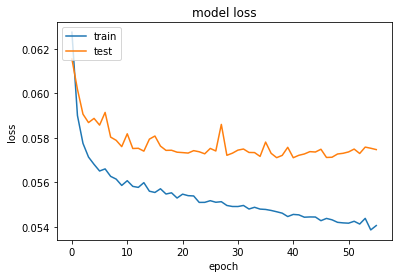

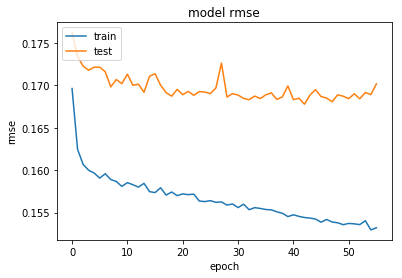

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [13]:
model.load_weights(experiment_name+'.hdf5')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  74.28608345985413 s =  1.2381013989448548 min =  0.020635023448202346 h


## Evaluate performance on validation data to improve model

In [15]:
model.load_weights(experiment_name+'.hdf5')

## Evaluate metrics

In [16]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.06153819164843479
Delay 100 ms: 0.005407541199152493
Delay 200 ms: 0.014714702614509984
Delay 300 ms: 0.026523929455313656
Delay 400 ms: 0.03958858981800796
Delay 500 ms: 0.05328506370498752
Delay 600 ms: 0.06729666971138552
Delay 700 ms: 0.08140811719559653
Delay 800 ms: 0.09543190980238372
Delay 900 ms: 0.10918978093273835
Delay 1000 ms: 0.12253561205027223

RMSE
Average rmse: 0.13030661366759236
Delay 100 ms: 0.016301489788415183
Delay 200 ms: 0.03288075478549163
Delay 300 ms: 0.05402945137953391
Delay 400 ms: 0.07723923602815867
Delay 500 ms: 0.101012174333503
Delay 600 ms: 0.12469457134198818
Delay 700 ms: 0.14794514162259964
Delay 800 ms: 0.17046457175604507
Delay 900 ms: 0.19212960946139165
Delay 1000 ms: 0.21279145672028754

SMAPE
Average smape: 13.267779335441436
Delay 100 ms: 2.2086513255840337
Delay 200 ms: 5.083951021929279
Delay 300 ms: 7.895228285101795
Delay 400 ms: 10.463179526442325
Delay 500 ms: 12.834670176548775
Delay 600 ms: 15.02627238661678
Del

(6028, 25, 3) (6028, 10, 3)


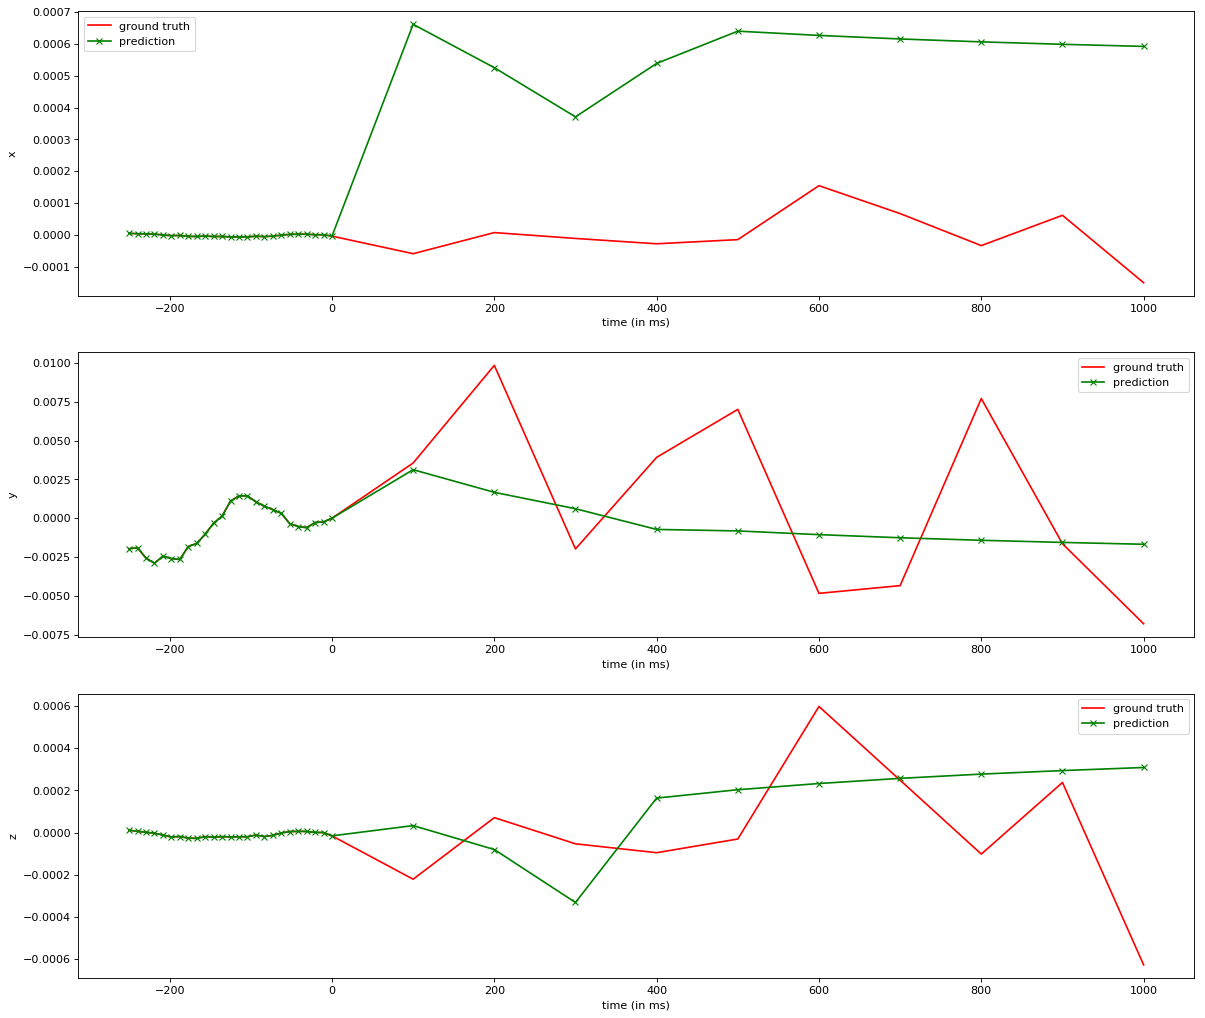

In [17]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

## Evaluate performance on test data